## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1096, 715)
Hypercube shape: (1096, 715, 102)


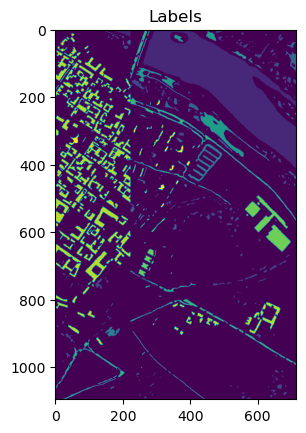

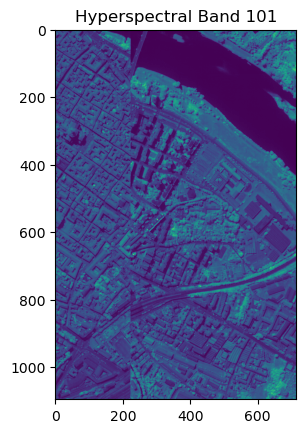

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Pavia_gt.mat'
data_files = 'Pavia.mat'
label_files = 'pavia_gt'
hypercube_files = 'pavia'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 148152
Extracted windows shape: (148152, 5, 5, 102)
Corresponding labels shape: (148152,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 65971 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 7598 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 3090 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 2685 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 6584 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 9248 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 7287 samples
Shuffled class indices for class '7'
Selected 40 train


 -- Test set created with: 
	147747 samples
	shape (147747, 5, 5, 102) --




All datasets saved to the 'indices' folder.
(360, 5, 5, 102)
(45, 5, 5, 102)
(147747, 5, 5, 102)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (118521, 5, 5, 102)
Validation data shape: (29631, 5, 5, 102)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

102


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/1852], Loss: 0.1658, PSNR: 5.2360


	 Training Batch [200/1852], Loss: 0.0841, PSNR: 7.8324


	 Training Batch [400/1852], Loss: 0.0419, PSNR: 8.5916


	 Training Batch [600/1852], Loss: 0.0268, PSNR: 11.6658


	 Training Batch [800/1852], Loss: 0.0134, PSNR: 16.5864


	 Training Batch [1000/1852], Loss: 0.0128, PSNR: 15.6775


	 Training Batch [1200/1852], Loss: 0.0084, PSNR: 16.3231


	 Training Batch [1400/1852], Loss: 0.0089, PSNR: 15.7801


	 Training Batch [1600/1852], Loss: 0.0067, PSNR: 17.7193


	 Training Batch [1800/1852], Loss: 0.0072, PSNR: 17.6698


Epoch [1/50] Training Loss: 0.0329, PSNR: 13.5923
	[Val]   Batch [1/463] Loss: 0.0054, PSNR: 17.9402
	[Val]   Batch [10/463] Loss: 0.0050, PSNR: 19.1137
	[Val]   Batch [20/463] Loss: 0.0050, PSNR: 18.1217
	[Val]   Batch [30/463] Loss: 0.0061, PSNR: 18.6338
	[Val]   Batch [40/463] Loss: 0.0048, PSNR: 17.8044
	[Val]   Batch [50/463] Loss: 0.0050, PSNR: 18.0233
	[Val]   Batch [60/463] Loss: 0.0048, PSNR: 18.0612


	[Val]   Batch [70/463] Loss: 0.0068, PSNR: 18.3755
	[Val]   Batch [80/463] Loss: 0.0060, PSNR: 20.3160
	[Val]   Batch [90/463] Loss: 0.0058, PSNR: 19.3949
	[Val]   Batch [100/463] Loss: 0.0059, PSNR: 19.0996
	[Val]   Batch [110/463] Loss: 0.0069, PSNR: 18.4946
	[Val]   Batch [120/463] Loss: 0.0046, PSNR: 18.0611
	[Val]   Batch [130/463] Loss: 0.0055, PSNR: 19.4082


	[Val]   Batch [140/463] Loss: 0.0064, PSNR: 18.9751
	[Val]   Batch [150/463] Loss: 0.0073, PSNR: 18.9810
	[Val]   Batch [160/463] Loss: 0.0059, PSNR: 19.2669
	[Val]   Batch [170/463] Loss: 0.0076, PSNR: 18.1826
	[Val]   Batch [180/463] Loss: 0.0054, PSNR: 19.0172
	[Val]   Batch [190/463] Loss: 0.0059, PSNR: 19.3341
	[Val]   Batch [200/463] Loss: 0.0059, PSNR: 18.7402


	[Val]   Batch [210/463] Loss: 0.0058, PSNR: 18.3135
	[Val]   Batch [220/463] Loss: 0.0057, PSNR: 19.5225
	[Val]   Batch [230/463] Loss: 0.0068, PSNR: 19.3284
	[Val]   Batch [240/463] Loss: 0.0051, PSNR: 18.1728
	[Val]   Batch [250/463] Loss: 0.0066, PSNR: 17.3282
	[Val]   Batch [260/463] Loss: 0.0057, PSNR: 18.3543
	[Val]   Batch [270/463] Loss: 0.0043, PSNR: 17.5727


	[Val]   Batch [280/463] Loss: 0.0054, PSNR: 20.2353
	[Val]   Batch [290/463] Loss: 0.0060, PSNR: 17.2319
	[Val]   Batch [300/463] Loss: 0.0060, PSNR: 19.5079
	[Val]   Batch [310/463] Loss: 0.0055, PSNR: 19.4069
	[Val]   Batch [320/463] Loss: 0.0056, PSNR: 19.2621
	[Val]   Batch [330/463] Loss: 0.0065, PSNR: 18.6533
	[Val]   Batch [340/463] Loss: 0.0053, PSNR: 19.6177


	[Val]   Batch [350/463] Loss: 0.0070, PSNR: 19.5015
	[Val]   Batch [360/463] Loss: 0.0047, PSNR: 20.4722
	[Val]   Batch [370/463] Loss: 0.0069, PSNR: 18.5544
	[Val]   Batch [380/463] Loss: 0.0068, PSNR: 18.7245
	[Val]   Batch [390/463] Loss: 0.0062, PSNR: 18.5414
	[Val]   Batch [400/463] Loss: 0.0055, PSNR: 17.6027
	[Val]   Batch [410/463] Loss: 0.0053, PSNR: 19.9479


	[Val]   Batch [420/463] Loss: 0.0055, PSNR: 18.7307
	[Val]   Batch [430/463] Loss: 0.0054, PSNR: 18.1577
	[Val]   Batch [440/463] Loss: 0.0054, PSNR: 19.1123
	[Val]   Batch [450/463] Loss: 0.0041, PSNR: 16.5301
	[Val]   Batch [460/463] Loss: 0.0058, PSNR: 17.8815
Epoch [1/50] Validation Loss: 0.0057, PSNR: 18.6963

LOG: Epoch [2/50]
	 Training Batch [1/1852], Loss: 0.0060, PSNR: 17.2745


	 Training Batch [200/1852], Loss: 0.0045, PSNR: 19.3736


	 Training Batch [400/1852], Loss: 0.0036, PSNR: 18.8363


	 Training Batch [600/1852], Loss: 0.0039, PSNR: 20.1895


	 Training Batch [800/1852], Loss: 0.0047, PSNR: 19.9636


	 Training Batch [1000/1852], Loss: 0.0045, PSNR: 20.7167


	 Training Batch [1200/1852], Loss: 0.0036, PSNR: 20.4809


	 Training Batch [1400/1852], Loss: 0.0037, PSNR: 20.7010


	 Training Batch [1600/1852], Loss: 0.0039, PSNR: 20.9436


	 Training Batch [1800/1852], Loss: 0.0031, PSNR: 21.0283


Epoch [2/50] Training Loss: 0.0046, PSNR: 19.8607
	[Val]   Batch [1/463] Loss: 0.0029, PSNR: 20.6033
	[Val]   Batch [10/463] Loss: 0.0027, PSNR: 21.7930
	[Val]   Batch [20/463] Loss: 0.0026, PSNR: 20.9133
	[Val]   Batch [30/463] Loss: 0.0034, PSNR: 21.1119
	[Val]   Batch [40/463] Loss: 0.0025, PSNR: 20.5315
	[Val]   Batch [50/463] Loss: 0.0027, PSNR: 20.6827


	[Val]   Batch [60/463] Loss: 0.0025, PSNR: 20.8027
	[Val]   Batch [70/463] Loss: 0.0040, PSNR: 20.7424
	[Val]   Batch [80/463] Loss: 0.0035, PSNR: 22.6746
	[Val]   Batch [90/463] Loss: 0.0032, PSNR: 22.0154
	[Val]   Batch [100/463] Loss: 0.0035, PSNR: 21.4275
	[Val]   Batch [110/463] Loss: 0.0040, PSNR: 20.9098
	[Val]   Batch [120/463] Loss: 0.0025, PSNR: 20.8097


	[Val]   Batch [130/463] Loss: 0.0030, PSNR: 22.0498
	[Val]   Batch [140/463] Loss: 0.0036, PSNR: 21.4328
	[Val]   Batch [150/463] Loss: 0.0042, PSNR: 21.4286
	[Val]   Batch [160/463] Loss: 0.0034, PSNR: 21.6404
	[Val]   Batch [170/463] Loss: 0.0044, PSNR: 20.5278
	[Val]   Batch [180/463] Loss: 0.0033, PSNR: 21.2611
	[Val]   Batch [190/463] Loss: 0.0033, PSNR: 21.9019


	[Val]   Batch [200/463] Loss: 0.0033, PSNR: 21.2356
	[Val]   Batch [210/463] Loss: 0.0034, PSNR: 20.6073
	[Val]   Batch [220/463] Loss: 0.0032, PSNR: 22.0060
	[Val]   Batch [230/463] Loss: 0.0038, PSNR: 21.8187
	[Val]   Batch [240/463] Loss: 0.0028, PSNR: 20.7550
	[Val]   Batch [250/463] Loss: 0.0037, PSNR: 19.7870
	[Val]   Batch [260/463] Loss: 0.0032, PSNR: 20.8432


	[Val]   Batch [270/463] Loss: 0.0022, PSNR: 20.4846
	[Val]   Batch [280/463] Loss: 0.0029, PSNR: 22.8540
	[Val]   Batch [290/463] Loss: 0.0033, PSNR: 19.8644
	[Val]   Batch [300/463] Loss: 0.0033, PSNR: 22.0399
	[Val]   Batch [310/463] Loss: 0.0032, PSNR: 21.8148
	[Val]   Batch [320/463] Loss: 0.0031, PSNR: 21.7700
	[Val]   Batch [330/463] Loss: 0.0036, PSNR: 21.2369


	[Val]   Batch [340/463] Loss: 0.0029, PSNR: 22.1760
	[Val]   Batch [350/463] Loss: 0.0042, PSNR: 21.7432
	[Val]   Batch [360/463] Loss: 0.0026, PSNR: 22.9360
	[Val]   Batch [370/463] Loss: 0.0039, PSNR: 21.1003
	[Val]   Batch [380/463] Loss: 0.0037, PSNR: 21.3779
	[Val]   Batch [390/463] Loss: 0.0034, PSNR: 21.1490
	[Val]   Batch [400/463] Loss: 0.0031, PSNR: 20.1147


	[Val]   Batch [410/463] Loss: 0.0028, PSNR: 22.6795
	[Val]   Batch [420/463] Loss: 0.0030, PSNR: 21.3416
	[Val]   Batch [430/463] Loss: 0.0031, PSNR: 20.6290
	[Val]   Batch [440/463] Loss: 0.0030, PSNR: 21.6052
	[Val]   Batch [450/463] Loss: 0.0022, PSNR: 19.2927
	[Val]   Batch [460/463] Loss: 0.0031, PSNR: 20.5420
Epoch [2/50] Validation Loss: 0.0032, PSNR: 21.2578

LOG: Epoch [3/50]
	 Training Batch [1/1852], Loss: 0.0036, PSNR: 21.3582


	 Training Batch [200/1852], Loss: 0.0036, PSNR: 20.1918


	 Training Batch [400/1852], Loss: 0.0028, PSNR: 20.2510


	 Training Batch [600/1852], Loss: 0.0025, PSNR: 20.7756


	 Training Batch [800/1852], Loss: 0.0027, PSNR: 23.1188


	 Training Batch [1000/1852], Loss: 0.0024, PSNR: 23.1415


	 Training Batch [1200/1852], Loss: 0.0021, PSNR: 23.4233


	 Training Batch [1400/1852], Loss: 0.0020, PSNR: 24.2764


	 Training Batch [1600/1852], Loss: 0.0022, PSNR: 22.8768


	 Training Batch [1800/1852], Loss: 0.0020, PSNR: 22.9571


Epoch [3/50] Training Loss: 0.0025, PSNR: 22.4144
	[Val]   Batch [1/463] Loss: 0.0015, PSNR: 23.3934
	[Val]   Batch [10/463] Loss: 0.0014, PSNR: 24.5988
	[Val]   Batch [20/463] Loss: 0.0014, PSNR: 23.7949
	[Val]   Batch [30/463] Loss: 0.0017, PSNR: 24.2652
	[Val]   Batch [40/463] Loss: 0.0015, PSNR: 22.9304
	[Val]   Batch [50/463] Loss: 0.0015, PSNR: 23.2762
	[Val]   Batch [60/463] Loss: 0.0014, PSNR: 23.3102


	[Val]   Batch [70/463] Loss: 0.0019, PSNR: 23.8618
	[Val]   Batch [80/463] Loss: 0.0017, PSNR: 25.6909
	[Val]   Batch [90/463] Loss: 0.0016, PSNR: 24.8810
	[Val]   Batch [100/463] Loss: 0.0018, PSNR: 24.3524
	[Val]   Batch [110/463] Loss: 0.0019, PSNR: 24.0430


	[Val]   Batch [120/463] Loss: 0.0014, PSNR: 23.2345
	[Val]   Batch [130/463] Loss: 0.0015, PSNR: 25.1693
	[Val]   Batch [140/463] Loss: 0.0018, PSNR: 24.4387
	[Val]   Batch [150/463] Loss: 0.0019, PSNR: 24.8902
	[Val]   Batch [160/463] Loss: 0.0019, PSNR: 24.1107
	[Val]   Batch [170/463] Loss: 0.0023, PSNR: 23.4529


	[Val]   Batch [180/463] Loss: 0.0018, PSNR: 23.9479
	[Val]   Batch [190/463] Loss: 0.0016, PSNR: 24.9443
	[Val]   Batch [200/463] Loss: 0.0016, PSNR: 24.2854
	[Val]   Batch [210/463] Loss: 0.0019, PSNR: 23.1389
	[Val]   Batch [220/463] Loss: 0.0018, PSNR: 24.5953
	[Val]   Batch [230/463] Loss: 0.0017, PSNR: 25.4360


	[Val]   Batch [240/463] Loss: 0.0015, PSNR: 23.5464
	[Val]   Batch [250/463] Loss: 0.0020, PSNR: 22.5481
	[Val]   Batch [260/463] Loss: 0.0017, PSNR: 23.5208
	[Val]   Batch [270/463] Loss: 0.0013, PSNR: 22.8611
	[Val]   Batch [280/463] Loss: 0.0016, PSNR: 25.5631
	[Val]   Batch [290/463] Loss: 0.0017, PSNR: 22.7322


	[Val]   Batch [300/463] Loss: 0.0018, PSNR: 24.7538
	[Val]   Batch [310/463] Loss: 0.0019, PSNR: 24.1057
	[Val]   Batch [320/463] Loss: 0.0017, PSNR: 24.5414
	[Val]   Batch [330/463] Loss: 0.0017, PSNR: 24.4523
	[Val]   Batch [340/463] Loss: 0.0016, PSNR: 24.8984


	[Val]   Batch [350/463] Loss: 0.0022, PSNR: 24.5736
	[Val]   Batch [360/463] Loss: 0.0017, PSNR: 24.7728
	[Val]   Batch [370/463] Loss: 0.0018, PSNR: 24.2913
	[Val]   Batch [380/463] Loss: 0.0016, PSNR: 24.9300
	[Val]   Batch [390/463] Loss: 0.0016, PSNR: 24.4790
	[Val]   Batch [400/463] Loss: 0.0017, PSNR: 22.6162


	[Val]   Batch [410/463] Loss: 0.0015, PSNR: 25.5027
	[Val]   Batch [420/463] Loss: 0.0015, PSNR: 24.3303
	[Val]   Batch [430/463] Loss: 0.0017, PSNR: 23.0576
	[Val]   Batch [440/463] Loss: 0.0017, PSNR: 24.1132
	[Val]   Batch [450/463] Loss: 0.0014, PSNR: 21.3022
	[Val]   Batch [460/463] Loss: 0.0016, PSNR: 23.3741
Epoch [3/50] Validation Loss: 0.0017, PSNR: 24.0986

LOG: Epoch [4/50]


	 Training Batch [1/1852], Loss: 0.0019, PSNR: 23.0381


	 Training Batch [200/1852], Loss: 0.0017, PSNR: 22.8292


	 Training Batch [400/1852], Loss: 0.0019, PSNR: 25.1233


	 Training Batch [600/1852], Loss: 0.0020, PSNR: 22.6180


	 Training Batch [800/1852], Loss: 0.0014, PSNR: 24.3987


	 Training Batch [1000/1852], Loss: 0.0014, PSNR: 25.7570


	 Training Batch [1200/1852], Loss: 0.0016, PSNR: 22.2702


	 Training Batch [1400/1852], Loss: 0.0013, PSNR: 24.4269


	 Training Batch [1600/1852], Loss: 0.0014, PSNR: 23.9963


	 Training Batch [1800/1852], Loss: 0.0015, PSNR: 24.5162


Epoch [4/50] Training Loss: 0.0016, PSNR: 24.2353
	[Val]   Batch [1/463] Loss: 0.0011, PSNR: 24.7176
	[Val]   Batch [10/463] Loss: 0.0010, PSNR: 25.9221
	[Val]   Batch [20/463] Loss: 0.0010, PSNR: 25.1451
	[Val]   Batch [30/463] Loss: 0.0012, PSNR: 25.6913
	[Val]   Batch [40/463] Loss: 0.0011, PSNR: 24.1252


	[Val]   Batch [50/463] Loss: 0.0011, PSNR: 24.5762
	[Val]   Batch [60/463] Loss: 0.0011, PSNR: 24.5453
	[Val]   Batch [70/463] Loss: 0.0014, PSNR: 25.3320
	[Val]   Batch [80/463] Loss: 0.0012, PSNR: 27.3538
	[Val]   Batch [90/463] Loss: 0.0012, PSNR: 26.2796
	[Val]   Batch [100/463] Loss: 0.0013, PSNR: 25.7919


	[Val]   Batch [110/463] Loss: 0.0013, PSNR: 25.6394
	[Val]   Batch [120/463] Loss: 0.0010, PSNR: 24.5050
	[Val]   Batch [130/463] Loss: 0.0010, PSNR: 26.6181
	[Val]   Batch [140/463] Loss: 0.0013, PSNR: 25.9285
	[Val]   Batch [150/463] Loss: 0.0013, PSNR: 26.5638
	[Val]   Batch [160/463] Loss: 0.0014, PSNR: 25.3819


	[Val]   Batch [170/463] Loss: 0.0017, PSNR: 24.7901
	[Val]   Batch [180/463] Loss: 0.0013, PSNR: 25.2423
	[Val]   Batch [190/463] Loss: 0.0012, PSNR: 26.3554
	[Val]   Batch [200/463] Loss: 0.0011, PSNR: 25.9052
	[Val]   Batch [210/463] Loss: 0.0014, PSNR: 24.4090
	[Val]   Batch [220/463] Loss: 0.0013, PSNR: 25.9363


	[Val]   Batch [230/463] Loss: 0.0011, PSNR: 27.1792
	[Val]   Batch [240/463] Loss: 0.0011, PSNR: 24.9063
	[Val]   Batch [250/463] Loss: 0.0015, PSNR: 23.8118
	[Val]   Batch [260/463] Loss: 0.0013, PSNR: 24.7325
	[Val]   Batch [270/463] Loss: 0.0009, PSNR: 24.2070
	[Val]   Batch [280/463] Loss: 0.0011, PSNR: 26.9378


	[Val]   Batch [290/463] Loss: 0.0012, PSNR: 24.1221
	[Val]   Batch [300/463] Loss: 0.0013, PSNR: 26.0214
	[Val]   Batch [310/463] Loss: 0.0014, PSNR: 25.3938
	[Val]   Batch [320/463] Loss: 0.0012, PSNR: 25.9587
	[Val]   Batch [330/463] Loss: 0.0012, PSNR: 25.9668


	[Val]   Batch [340/463] Loss: 0.0011, PSNR: 26.2723
	[Val]   Batch [350/463] Loss: 0.0016, PSNR: 26.0347
	[Val]   Batch [360/463] Loss: 0.0014, PSNR: 25.7213
	[Val]   Batch [370/463] Loss: 0.0013, PSNR: 25.8083
	[Val]   Batch [380/463] Loss: 0.0011, PSNR: 26.6274
	[Val]   Batch [390/463] Loss: 0.0011, PSNR: 26.0699


	[Val]   Batch [400/463] Loss: 0.0013, PSNR: 23.8545
	[Val]   Batch [410/463] Loss: 0.0011, PSNR: 26.8856
	[Val]   Batch [420/463] Loss: 0.0011, PSNR: 25.6893
	[Val]   Batch [430/463] Loss: 0.0013, PSNR: 24.2087
	[Val]   Batch [440/463] Loss: 0.0013, PSNR: 25.4143
	[Val]   Batch [450/463] Loss: 0.0010, PSNR: 22.4777


	[Val]   Batch [460/463] Loss: 0.0012, PSNR: 24.6928
Epoch [4/50] Validation Loss: 0.0012, PSNR: 25.4990

LOG: Epoch [5/50]
	 Training Batch [1/1852], Loss: 0.0012, PSNR: 25.5240


	 Training Batch [200/1852], Loss: 0.0011, PSNR: 25.4430


	 Training Batch [400/1852], Loss: 0.0013, PSNR: 25.8858


	 Training Batch [600/1852], Loss: 0.0013, PSNR: 25.2086


	 Training Batch [800/1852], Loss: 0.0015, PSNR: 26.2016


	 Training Batch [1000/1852], Loss: 0.0012, PSNR: 26.9949


	 Training Batch [1200/1852], Loss: 0.0013, PSNR: 24.7175


	 Training Batch [1400/1852], Loss: 0.0017, PSNR: 24.8156


	 Training Batch [1600/1852], Loss: 0.0010, PSNR: 25.7931


	 Training Batch [1800/1852], Loss: 0.0012, PSNR: 26.1296


Epoch [5/50] Training Loss: 0.0013, PSNR: 25.3588
	[Val]   Batch [1/463] Loss: 0.0009, PSNR: 25.6854
	[Val]   Batch [10/463] Loss: 0.0008, PSNR: 26.9961
	[Val]   Batch [20/463] Loss: 0.0008, PSNR: 26.2053
	[Val]   Batch [30/463] Loss: 0.0010, PSNR: 26.6593
	[Val]   Batch [40/463] Loss: 0.0009, PSNR: 25.0890
	[Val]   Batch [50/463] Loss: 0.0009, PSNR: 25.6037


	[Val]   Batch [60/463] Loss: 0.0009, PSNR: 25.5005
	[Val]   Batch [70/463] Loss: 0.0011, PSNR: 26.3267
	[Val]   Batch [80/463] Loss: 0.0009, PSNR: 28.5821
	[Val]   Batch [90/463] Loss: 0.0009, PSNR: 27.3352
	[Val]   Batch [100/463] Loss: 0.0010, PSNR: 26.8563
	[Val]   Batch [110/463] Loss: 0.0010, PSNR: 26.7099


	[Val]   Batch [120/463] Loss: 0.0008, PSNR: 25.5832
	[Val]   Batch [130/463] Loss: 0.0008, PSNR: 27.6382
	[Val]   Batch [140/463] Loss: 0.0010, PSNR: 26.9706
	[Val]   Batch [150/463] Loss: 0.0010, PSNR: 27.6400
	[Val]   Batch [160/463] Loss: 0.0012, PSNR: 26.3275
	[Val]   Batch [170/463] Loss: 0.0013, PSNR: 25.7054


	[Val]   Batch [180/463] Loss: 0.0010, PSNR: 26.3026
	[Val]   Batch [190/463] Loss: 0.0009, PSNR: 27.3614
	[Val]   Batch [200/463] Loss: 0.0009, PSNR: 27.0472
	[Val]   Batch [210/463] Loss: 0.0011, PSNR: 25.3772
	[Val]   Batch [220/463] Loss: 0.0010, PSNR: 26.8995
	[Val]   Batch [230/463] Loss: 0.0009, PSNR: 28.3131


	[Val]   Batch [240/463] Loss: 0.0008, PSNR: 26.0033
	[Val]   Batch [250/463] Loss: 0.0012, PSNR: 24.7527
	[Val]   Batch [260/463] Loss: 0.0011, PSNR: 25.5929
	[Val]   Batch [270/463] Loss: 0.0007, PSNR: 25.3680
	[Val]   Batch [280/463] Loss: 0.0009, PSNR: 27.9621
	[Val]   Batch [290/463] Loss: 0.0010, PSNR: 25.1281


	[Val]   Batch [300/463] Loss: 0.0011, PSNR: 26.8988
	[Val]   Batch [310/463] Loss: 0.0011, PSNR: 26.4266
	[Val]   Batch [320/463] Loss: 0.0009, PSNR: 27.0891
	[Val]   Batch [330/463] Loss: 0.0009, PSNR: 27.0152
	[Val]   Batch [340/463] Loss: 0.0009, PSNR: 27.3504
	[Val]   Batch [350/463] Loss: 0.0012, PSNR: 27.0243


	[Val]   Batch [360/463] Loss: 0.0012, PSNR: 26.5345
	[Val]   Batch [370/463] Loss: 0.0010, PSNR: 26.8105
	[Val]   Batch [380/463] Loss: 0.0009, PSNR: 27.7388
	[Val]   Batch [390/463] Loss: 0.0009, PSNR: 27.1850
	[Val]   Batch [400/463] Loss: 0.0010, PSNR: 24.8097
	[Val]   Batch [410/463] Loss: 0.0008, PSNR: 27.9381


	[Val]   Batch [420/463] Loss: 0.0009, PSNR: 26.7000
	[Val]   Batch [430/463] Loss: 0.0011, PSNR: 25.1344
	[Val]   Batch [440/463] Loss: 0.0010, PSNR: 26.4096
	[Val]   Batch [450/463] Loss: 0.0008, PSNR: 23.5454
	[Val]   Batch [460/463] Loss: 0.0010, PSNR: 25.6365
Epoch [5/50] Validation Loss: 0.0009, PSNR: 26.5371

LOG: Epoch [6/50]
	 Training Batch [1/1852], Loss: 0.0011, PSNR: 26.1149


	 Training Batch [200/1852], Loss: 0.0012, PSNR: 25.8364


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 24.2871


	 Training Batch [600/1852], Loss: 0.0009, PSNR: 26.8116


	 Training Batch [800/1852], Loss: 0.0012, PSNR: 26.7763


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 26.8270


	 Training Batch [1200/1852], Loss: 0.0012, PSNR: 26.2055


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 28.4535


	 Training Batch [1600/1852], Loss: 0.0009, PSNR: 26.2505


	 Training Batch [1800/1852], Loss: 0.0008, PSNR: 26.6760


Epoch [6/50] Training Loss: 0.0010, PSNR: 26.1985
	[Val]   Batch [1/463] Loss: 0.0007, PSNR: 26.7361
	[Val]   Batch [10/463] Loss: 0.0006, PSNR: 28.0723
	[Val]   Batch [20/463] Loss: 0.0006, PSNR: 27.3197
	[Val]   Batch [30/463] Loss: 0.0008, PSNR: 27.7232
	[Val]   Batch [40/463] Loss: 0.0007, PSNR: 26.0752
	[Val]   Batch [50/463] Loss: 0.0007, PSNR: 26.7028


	[Val]   Batch [60/463] Loss: 0.0007, PSNR: 26.4889
	[Val]   Batch [70/463] Loss: 0.0009, PSNR: 27.3726
	[Val]   Batch [80/463] Loss: 0.0007, PSNR: 29.9260
	[Val]   Batch [90/463] Loss: 0.0007, PSNR: 28.4909
	[Val]   Batch [100/463] Loss: 0.0008, PSNR: 27.9802
	[Val]   Batch [110/463] Loss: 0.0008, PSNR: 27.9128


	[Val]   Batch [120/463] Loss: 0.0006, PSNR: 26.6271
	[Val]   Batch [130/463] Loss: 0.0006, PSNR: 28.7491
	[Val]   Batch [140/463] Loss: 0.0008, PSNR: 28.0711
	[Val]   Batch [150/463] Loss: 0.0008, PSNR: 28.8372
	[Val]   Batch [160/463] Loss: 0.0009, PSNR: 27.2892
	[Val]   Batch [170/463] Loss: 0.0011, PSNR: 26.7114


	[Val]   Batch [180/463] Loss: 0.0008, PSNR: 27.3704
	[Val]   Batch [190/463] Loss: 0.0007, PSNR: 28.3753
	[Val]   Batch [200/463] Loss: 0.0007, PSNR: 28.2577
	[Val]   Batch [210/463] Loss: 0.0009, PSNR: 26.3611
	[Val]   Batch [220/463] Loss: 0.0008, PSNR: 27.8576
	[Val]   Batch [230/463] Loss: 0.0006, PSNR: 29.5877


	[Val]   Batch [240/463] Loss: 0.0007, PSNR: 27.0910
	[Val]   Batch [250/463] Loss: 0.0009, PSNR: 25.7535
	[Val]   Batch [260/463] Loss: 0.0009, PSNR: 26.4978
	[Val]   Batch [270/463] Loss: 0.0005, PSNR: 26.5388
	[Val]   Batch [280/463] Loss: 0.0007, PSNR: 29.0679
	[Val]   Batch [290/463] Loss: 0.0007, PSNR: 26.2634


	[Val]   Batch [300/463] Loss: 0.0009, PSNR: 27.8230
	[Val]   Batch [310/463] Loss: 0.0009, PSNR: 27.4339
	[Val]   Batch [320/463] Loss: 0.0007, PSNR: 28.2636
	[Val]   Batch [330/463] Loss: 0.0007, PSNR: 28.1451
	[Val]   Batch [340/463] Loss: 0.0007, PSNR: 28.4634


	[Val]   Batch [350/463] Loss: 0.0010, PSNR: 28.0634
	[Val]   Batch [360/463] Loss: 0.0010, PSNR: 27.2294
	[Val]   Batch [370/463] Loss: 0.0008, PSNR: 28.0063
	[Val]   Batch [380/463] Loss: 0.0006, PSNR: 28.9914
	[Val]   Batch [390/463] Loss: 0.0006, PSNR: 28.3800
	[Val]   Batch [400/463] Loss: 0.0008, PSNR: 25.7899


	[Val]   Batch [410/463] Loss: 0.0007, PSNR: 29.0162
	[Val]   Batch [420/463] Loss: 0.0007, PSNR: 27.7636
	[Val]   Batch [430/463] Loss: 0.0009, PSNR: 26.0446
	[Val]   Batch [440/463] Loss: 0.0008, PSNR: 27.4283
	[Val]   Batch [450/463] Loss: 0.0006, PSNR: 24.5568
	[Val]   Batch [460/463] Loss: 0.0008, PSNR: 26.6738
Epoch [6/50] Validation Loss: 0.0007, PSNR: 27.6333

LOG: Epoch [7/50]


	 Training Batch [1/1852], Loss: 0.0013, PSNR: 27.3361


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 26.0932


	 Training Batch [400/1852], Loss: 0.0010, PSNR: 27.1312


	 Training Batch [600/1852], Loss: 0.0010, PSNR: 26.8618


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 25.5651


	 Training Batch [1000/1852], Loss: 0.0010, PSNR: 24.8343


	 Training Batch [1200/1852], Loss: 0.0011, PSNR: 27.1307


	 Training Batch [1400/1852], Loss: 0.0010, PSNR: 26.7916


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 26.9963


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 26.1430


Epoch [7/50] Training Loss: 0.0009, PSNR: 26.9046
	[Val]   Batch [1/463] Loss: 0.0006, PSNR: 27.4900
	[Val]   Batch [10/463] Loss: 0.0005, PSNR: 28.8932
	[Val]   Batch [20/463] Loss: 0.0005, PSNR: 28.1272
	[Val]   Batch [30/463] Loss: 0.0006, PSNR: 28.5012
	[Val]   Batch [40/463] Loss: 0.0006, PSNR: 26.8891
	[Val]   Batch [50/463] Loss: 0.0006, PSNR: 27.5780


	[Val]   Batch [60/463] Loss: 0.0006, PSNR: 27.2450
	[Val]   Batch [70/463] Loss: 0.0007, PSNR: 28.1699
	[Val]   Batch [80/463] Loss: 0.0005, PSNR: 30.8507
	[Val]   Batch [90/463] Loss: 0.0006, PSNR: 29.2823
	[Val]   Batch [100/463] Loss: 0.0006, PSNR: 28.8401
	[Val]   Batch [110/463] Loss: 0.0006, PSNR: 28.7713


	[Val]   Batch [120/463] Loss: 0.0005, PSNR: 27.4719
	[Val]   Batch [130/463] Loss: 0.0005, PSNR: 29.5203
	[Val]   Batch [140/463] Loss: 0.0007, PSNR: 28.8616
	[Val]   Batch [150/463] Loss: 0.0006, PSNR: 29.7062
	[Val]   Batch [160/463] Loss: 0.0008, PSNR: 28.0854
	[Val]   Batch [170/463] Loss: 0.0009, PSNR: 27.4893


	[Val]   Batch [180/463] Loss: 0.0007, PSNR: 28.2446
	[Val]   Batch [190/463] Loss: 0.0006, PSNR: 29.1528
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.0995
	[Val]   Batch [210/463] Loss: 0.0007, PSNR: 27.1985
	[Val]   Batch [220/463] Loss: 0.0007, PSNR: 28.6592
	[Val]   Batch [230/463] Loss: 0.0005, PSNR: 30.3808


	[Val]   Batch [240/463] Loss: 0.0005, PSNR: 27.9164
	[Val]   Batch [250/463] Loss: 0.0008, PSNR: 26.5782
	[Val]   Batch [260/463] Loss: 0.0007, PSNR: 27.3174
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 27.4469
	[Val]   Batch [280/463] Loss: 0.0006, PSNR: 29.8819
	[Val]   Batch [290/463] Loss: 0.0006, PSNR: 27.0746


	[Val]   Batch [300/463] Loss: 0.0008, PSNR: 28.4923
	[Val]   Batch [310/463] Loss: 0.0007, PSNR: 28.2610
	[Val]   Batch [320/463] Loss: 0.0006, PSNR: 29.1427
	[Val]   Batch [330/463] Loss: 0.0006, PSNR: 28.9723
	[Val]   Batch [340/463] Loss: 0.0006, PSNR: 29.3057
	[Val]   Batch [350/463] Loss: 0.0008, PSNR: 28.8676


	[Val]   Batch [360/463] Loss: 0.0009, PSNR: 27.7922
	[Val]   Batch [370/463] Loss: 0.0007, PSNR: 28.8123
	[Val]   Batch [380/463] Loss: 0.0005, PSNR: 29.8740
	[Val]   Batch [390/463] Loss: 0.0005, PSNR: 29.1975
	[Val]   Batch [400/463] Loss: 0.0007, PSNR: 26.5463
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 29.8020


	[Val]   Batch [420/463] Loss: 0.0006, PSNR: 28.5434
	[Val]   Batch [430/463] Loss: 0.0007, PSNR: 26.8307
	[Val]   Batch [440/463] Loss: 0.0007, PSNR: 28.1763
	[Val]   Batch [450/463] Loss: 0.0005, PSNR: 25.4501
	[Val]   Batch [460/463] Loss: 0.0006, PSNR: 27.4634
Epoch [7/50] Validation Loss: 0.0006, PSNR: 28.4569

LOG: Epoch [8/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.0437


	 Training Batch [200/1852], Loss: 0.0009, PSNR: 28.9950


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.6350


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.4256


	 Training Batch [800/1852], Loss: 0.0009, PSNR: 26.2078


	 Training Batch [1000/1852], Loss: 0.0008, PSNR: 27.6745


	 Training Batch [1200/1852], Loss: 0.0007, PSNR: 28.5640


	 Training Batch [1400/1852], Loss: 0.0009, PSNR: 28.3449


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 28.3677


	 Training Batch [1800/1852], Loss: 0.0009, PSNR: 25.9729


Epoch [8/50] Training Loss: 0.0008, PSNR: 27.5454
	[Val]   Batch [1/463] Loss: 0.0005, PSNR: 28.2422
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 29.7474
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 28.9952
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.2934
	[Val]   Batch [40/463] Loss: 0.0005, PSNR: 27.6331
	[Val]   Batch [50/463] Loss: 0.0005, PSNR: 28.4162
	[Val]   Batch [60/463] Loss: 0.0005, PSNR: 27.9992


	[Val]   Batch [70/463] Loss: 0.0006, PSNR: 28.9461
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 31.7470
	[Val]   Batch [90/463] Loss: 0.0005, PSNR: 30.1122
	[Val]   Batch [100/463] Loss: 0.0005, PSNR: 29.6663
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 29.5805
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.2901
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.3356


	[Val]   Batch [140/463] Loss: 0.0006, PSNR: 29.6362
	[Val]   Batch [150/463] Loss: 0.0005, PSNR: 30.5875
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 28.8689
	[Val]   Batch [170/463] Loss: 0.0007, PSNR: 28.2651
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.0665
	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 29.9260
	[Val]   Batch [200/463] Loss: 0.0005, PSNR: 29.9114


	[Val]   Batch [210/463] Loss: 0.0006, PSNR: 28.0055
	[Val]   Batch [220/463] Loss: 0.0006, PSNR: 29.4196
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.1820
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 28.7844
	[Val]   Batch [250/463] Loss: 0.0007, PSNR: 27.3754
	[Val]   Batch [260/463] Loss: 0.0006, PSNR: 28.1399
	[Val]   Batch [270/463] Loss: 0.0004, PSNR: 28.3204


	[Val]   Batch [280/463] Loss: 0.0005, PSNR: 30.6997
	[Val]   Batch [290/463] Loss: 0.0005, PSNR: 27.9516
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.1831
	[Val]   Batch [310/463] Loss: 0.0006, PSNR: 29.0320
	[Val]   Batch [320/463] Loss: 0.0005, PSNR: 30.0312
	[Val]   Batch [330/463] Loss: 0.0005, PSNR: 29.8160
	[Val]   Batch [340/463] Loss: 0.0005, PSNR: 30.1419


	[Val]   Batch [350/463] Loss: 0.0007, PSNR: 29.6562
	[Val]   Batch [360/463] Loss: 0.0008, PSNR: 28.3271
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 29.6572
	[Val]   Batch [380/463] Loss: 0.0004, PSNR: 30.8540
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.0447
	[Val]   Batch [400/463] Loss: 0.0006, PSNR: 27.2872
	[Val]   Batch [410/463] Loss: 0.0005, PSNR: 30.5672


	[Val]   Batch [420/463] Loss: 0.0005, PSNR: 29.3598
	[Val]   Batch [430/463] Loss: 0.0006, PSNR: 27.6266
	[Val]   Batch [440/463] Loss: 0.0006, PSNR: 28.9099
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.2945
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.2630
Epoch [8/50] Validation Loss: 0.0005, PSNR: 29.2828

LOG: Epoch [9/50]
	 Training Batch [1/1852], Loss: 0.0006, PSNR: 27.6026


	 Training Batch [200/1852], Loss: 0.0007, PSNR: 26.0746


	 Training Batch [400/1852], Loss: 0.0007, PSNR: 28.1653


	 Training Batch [600/1852], Loss: 0.0007, PSNR: 27.3116


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.1308


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.0631


	 Training Batch [1200/1852], Loss: 0.0006, PSNR: 29.1129


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 28.0696


	 Training Batch [1600/1852], Loss: 0.0005, PSNR: 30.4118


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.6343


Epoch [9/50] Training Loss: 0.0007, PSNR: 28.0206
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 28.8265
	[Val]   Batch [10/463] Loss: 0.0004, PSNR: 30.3781
	[Val]   Batch [20/463] Loss: 0.0004, PSNR: 29.6467
	[Val]   Batch [30/463] Loss: 0.0005, PSNR: 29.9160
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.1938
	[Val]   Batch [50/463] Loss: 0.0004, PSNR: 29.1019


	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 28.5769
	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 29.5998
	[Val]   Batch [80/463] Loss: 0.0004, PSNR: 32.4638
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 30.7631
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.3079
	[Val]   Batch [110/463] Loss: 0.0005, PSNR: 30.2604
	[Val]   Batch [120/463] Loss: 0.0004, PSNR: 28.8716


	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 30.9303
	[Val]   Batch [140/463] Loss: 0.0005, PSNR: 30.2649
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.3622
	[Val]   Batch [160/463] Loss: 0.0006, PSNR: 29.5124
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 28.9217
	[Val]   Batch [180/463] Loss: 0.0005, PSNR: 29.7088


	[Val]   Batch [190/463] Loss: 0.0005, PSNR: 30.5086
	[Val]   Batch [200/463] Loss: 0.0004, PSNR: 30.5735
	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 28.7066
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 29.9450
	[Val]   Batch [230/463] Loss: 0.0004, PSNR: 31.8722
	[Val]   Batch [240/463] Loss: 0.0004, PSNR: 29.4418
	[Val]   Batch [250/463] Loss: 0.0006, PSNR: 28.0438


	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 28.7787
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 28.9691
	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.2929
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 28.6215
	[Val]   Batch [300/463] Loss: 0.0006, PSNR: 29.7743
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 29.6492
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 30.7152


	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.4929
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 30.7580
	[Val]   Batch [350/463] Loss: 0.0006, PSNR: 30.2945
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.6810
	[Val]   Batch [370/463] Loss: 0.0005, PSNR: 30.2963
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 31.6158
	[Val]   Batch [390/463] Loss: 0.0004, PSNR: 30.7237


	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 27.8412
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.1270
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 29.9925
	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.2542
	[Val]   Batch [440/463] Loss: 0.0005, PSNR: 29.4615
	[Val]   Batch [450/463] Loss: 0.0004, PSNR: 26.8960
	[Val]   Batch [460/463] Loss: 0.0005, PSNR: 28.9367
Epoch [9/50] Validation Loss: 0.0004, PSNR: 29.9249

LOG: Epoch [10/50]


	 Training Batch [1/1852], Loss: 0.0006, PSNR: 29.0126


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 28.0467


	 Training Batch [400/1852], Loss: 0.0006, PSNR: 29.2169


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 26.6392


	 Training Batch [800/1852], Loss: 0.0007, PSNR: 28.5637


	 Training Batch [1000/1852], Loss: 0.0006, PSNR: 27.1998


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 29.8127


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 30.1681


	 Training Batch [1600/1852], Loss: 0.0006, PSNR: 27.9196


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 28.1586


Epoch [10/50] Training Loss: 0.0006, PSNR: 28.5069
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.2014
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 30.8649
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.0729
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.3157
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 28.6175
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 29.6003
	[Val]   Batch [60/463] Loss: 0.0004, PSNR: 29.0547


	[Val]   Batch [70/463] Loss: 0.0005, PSNR: 30.0744
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.0028
	[Val]   Batch [90/463] Loss: 0.0004, PSNR: 31.1878
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 30.7630
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 30.7954
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.3139
	[Val]   Batch [130/463] Loss: 0.0004, PSNR: 31.3470


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 30.7373
	[Val]   Batch [150/463] Loss: 0.0004, PSNR: 31.9189
	[Val]   Batch [160/463] Loss: 0.0005, PSNR: 30.0300
	[Val]   Batch [170/463] Loss: 0.0006, PSNR: 29.3853
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.1582
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 30.9804
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.0991


	[Val]   Batch [210/463] Loss: 0.0005, PSNR: 29.2263
	[Val]   Batch [220/463] Loss: 0.0005, PSNR: 30.3380
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.2628
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 29.9142
	[Val]   Batch [250/463] Loss: 0.0005, PSNR: 28.5551
	[Val]   Batch [260/463] Loss: 0.0005, PSNR: 29.3192
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.4575


	[Val]   Batch [280/463] Loss: 0.0004, PSNR: 31.7243
	[Val]   Batch [290/463] Loss: 0.0004, PSNR: 29.1189
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.1911
	[Val]   Batch [310/463] Loss: 0.0005, PSNR: 30.1657
	[Val]   Batch [320/463] Loss: 0.0004, PSNR: 31.1896
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 30.9465
	[Val]   Batch [340/463] Loss: 0.0004, PSNR: 31.2637


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 30.8044
	[Val]   Batch [360/463] Loss: 0.0007, PSNR: 28.9881
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 30.6996
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.0383
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.1854
	[Val]   Batch [400/463] Loss: 0.0005, PSNR: 28.2827
	[Val]   Batch [410/463] Loss: 0.0004, PSNR: 31.5353
	[Val]   Batch [420/463] Loss: 0.0004, PSNR: 30.4707


	[Val]   Batch [430/463] Loss: 0.0005, PSNR: 28.7552
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 29.9031
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.4088
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.4323
Epoch [10/50] Validation Loss: 0.0004, PSNR: 30.3927

LOG: Epoch [11/50]
	 Training Batch [1/1852], Loss: 0.0008, PSNR: 28.9264


	 Training Batch [200/1852], Loss: 0.0004, PSNR: 28.3038


	 Training Batch [400/1852], Loss: 0.0005, PSNR: 30.1050


	 Training Batch [600/1852], Loss: 0.0006, PSNR: 27.5485


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 28.5813


	 Training Batch [1000/1852], Loss: 0.0004, PSNR: 29.9761


	 Training Batch [1200/1852], Loss: 0.0005, PSNR: 30.7618


	 Training Batch [1400/1852], Loss: 0.0006, PSNR: 27.8540


	 Training Batch [1600/1852], Loss: 0.0007, PSNR: 27.8156


	 Training Batch [1800/1852], Loss: 0.0007, PSNR: 27.7235


Epoch [11/50] Training Loss: 0.0006, PSNR: 28.8983
	[Val]   Batch [1/463] Loss: 0.0004, PSNR: 29.6384
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.2793
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.5253
	[Val]   Batch [30/463] Loss: 0.0004, PSNR: 30.7465
	[Val]   Batch [40/463] Loss: 0.0004, PSNR: 29.0467
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.0954
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.5479


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.4891
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.3850
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 31.6447
	[Val]   Batch [100/463] Loss: 0.0004, PSNR: 31.1934
	[Val]   Batch [110/463] Loss: 0.0004, PSNR: 31.1854
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.7483
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 31.7523


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.0555
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.2822
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.4895
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 29.8191
	[Val]   Batch [180/463] Loss: 0.0004, PSNR: 30.5731
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.2779
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.4561


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 29.7343
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.7014
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 32.6588
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.4135
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 28.9970
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 29.8144
	[Val]   Batch [270/463] Loss: 0.0003, PSNR: 29.9458


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.1281
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.5974
	[Val]   Batch [300/463] Loss: 0.0005, PSNR: 30.6259
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.5730
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.6347
	[Val]   Batch [330/463] Loss: 0.0004, PSNR: 31.3469
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 31.6764


	[Val]   Batch [350/463] Loss: 0.0005, PSNR: 31.1934
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.2732
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.1481
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.4453
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.5614
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.7127
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 31.8935


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 30.8896
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.2224
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.3298
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 27.9341
	[Val]   Batch [460/463] Loss: 0.0004, PSNR: 29.8835
Epoch [11/50] Validation Loss: 0.0004, PSNR: 30.8237

LOG: Epoch [12/50]
	 Training Batch [1/1852], Loss: 0.0005, PSNR: 29.1193


	 Training Batch [200/1852], Loss: 0.0005, PSNR: 29.2311


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.5480


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 28.8282


	 Training Batch [800/1852], Loss: 0.0005, PSNR: 30.0467


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 30.2092


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 29.9664


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 29.0879


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 29.6343


	 Training Batch [1800/1852], Loss: 0.0005, PSNR: 29.1663


Epoch [12/50] Training Loss: 0.0005, PSNR: 29.1938
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 29.9290
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 31.6577
	[Val]   Batch [20/463] Loss: 0.0003, PSNR: 30.8051
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.1324
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.3277
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.3996
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 29.8517


	[Val]   Batch [70/463] Loss: 0.0004, PSNR: 30.9160
	[Val]   Batch [80/463] Loss: 0.0003, PSNR: 33.7508
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.0330
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.5602
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 31.5674
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 29.9780
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.1215


	[Val]   Batch [140/463] Loss: 0.0004, PSNR: 31.4010
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 32.7947
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 30.8943
	[Val]   Batch [170/463] Loss: 0.0005, PSNR: 30.1992
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 30.9476
	[Val]   Batch [190/463] Loss: 0.0004, PSNR: 31.5829
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 31.8145


	[Val]   Batch [210/463] Loss: 0.0004, PSNR: 30.1545
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 30.9628
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.0419
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 30.7806
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.3457
	[Val]   Batch [260/463] Loss: 0.0004, PSNR: 30.2343
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.2094


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.4314
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 29.9707
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.0390
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 30.9063
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 31.9546
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 31.7545
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.0230


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 31.6148
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.4031
	[Val]   Batch [370/463] Loss: 0.0004, PSNR: 31.5081
	[Val]   Batch [380/463] Loss: 0.0003, PSNR: 32.9536
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 31.9549
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 28.9712
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.1730


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.2654
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.5149
	[Val]   Batch [440/463] Loss: 0.0004, PSNR: 30.5778
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.1682
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.2967
Epoch [12/50] Validation Loss: 0.0003, PSNR: 31.1677

LOG: Epoch [13/50]
	 Training Batch [1/1852], Loss: 0.0004, PSNR: 29.3900


	 Training Batch [200/1852], Loss: 0.0006, PSNR: 29.8862


	 Training Batch [400/1852], Loss: 0.0004, PSNR: 29.2306


	 Training Batch [600/1852], Loss: 0.0005, PSNR: 30.0293


	 Training Batch [800/1852], Loss: 0.0006, PSNR: 29.3801


	 Training Batch [1000/1852], Loss: 0.0005, PSNR: 27.7470


	 Training Batch [1200/1852], Loss: 0.0004, PSNR: 31.0256


	 Training Batch [1400/1852], Loss: 0.0005, PSNR: 28.3493


	 Training Batch [1600/1852], Loss: 0.0004, PSNR: 30.1498


	 Training Batch [1800/1852], Loss: 0.0004, PSNR: 30.3281


Epoch [13/50] Training Loss: 0.0005, PSNR: 29.4991
	[Val]   Batch [1/463] Loss: 0.0003, PSNR: 30.3359
	[Val]   Batch [10/463] Loss: 0.0003, PSNR: 32.0510
	[Val]   Batch [20/463] Loss: 0.0002, PSNR: 31.2146
	[Val]   Batch [30/463] Loss: 0.0003, PSNR: 31.4813
	[Val]   Batch [40/463] Loss: 0.0003, PSNR: 29.7289
	[Val]   Batch [50/463] Loss: 0.0003, PSNR: 30.9162
	[Val]   Batch [60/463] Loss: 0.0003, PSNR: 30.3438


	[Val]   Batch [70/463] Loss: 0.0003, PSNR: 31.3730
	[Val]   Batch [80/463] Loss: 0.0002, PSNR: 34.2136
	[Val]   Batch [90/463] Loss: 0.0003, PSNR: 32.4180
	[Val]   Batch [100/463] Loss: 0.0003, PSNR: 31.9790
	[Val]   Batch [110/463] Loss: 0.0003, PSNR: 32.0064
	[Val]   Batch [120/463] Loss: 0.0003, PSNR: 30.3663
	[Val]   Batch [130/463] Loss: 0.0003, PSNR: 32.5530


	[Val]   Batch [140/463] Loss: 0.0003, PSNR: 31.7950
	[Val]   Batch [150/463] Loss: 0.0003, PSNR: 33.1845
	[Val]   Batch [160/463] Loss: 0.0004, PSNR: 31.3901
	[Val]   Batch [170/463] Loss: 0.0004, PSNR: 30.6155
	[Val]   Batch [180/463] Loss: 0.0003, PSNR: 31.3494
	[Val]   Batch [190/463] Loss: 0.0003, PSNR: 31.9204
	[Val]   Batch [200/463] Loss: 0.0003, PSNR: 32.1855


	[Val]   Batch [210/463] Loss: 0.0003, PSNR: 30.5702
	[Val]   Batch [220/463] Loss: 0.0004, PSNR: 31.2840
	[Val]   Batch [230/463] Loss: 0.0003, PSNR: 33.4480
	[Val]   Batch [240/463] Loss: 0.0003, PSNR: 31.1742
	[Val]   Batch [250/463] Loss: 0.0004, PSNR: 29.8541
	[Val]   Batch [260/463] Loss: 0.0003, PSNR: 30.6937
	[Val]   Batch [270/463] Loss: 0.0002, PSNR: 30.6863


	[Val]   Batch [280/463] Loss: 0.0003, PSNR: 32.8242
	[Val]   Batch [290/463] Loss: 0.0003, PSNR: 30.4471
	[Val]   Batch [300/463] Loss: 0.0004, PSNR: 31.3599
	[Val]   Batch [310/463] Loss: 0.0004, PSNR: 31.3351
	[Val]   Batch [320/463] Loss: 0.0003, PSNR: 32.3921
	[Val]   Batch [330/463] Loss: 0.0003, PSNR: 32.1963
	[Val]   Batch [340/463] Loss: 0.0003, PSNR: 32.4527


	[Val]   Batch [350/463] Loss: 0.0004, PSNR: 32.0236
	[Val]   Batch [360/463] Loss: 0.0006, PSNR: 29.7145
	[Val]   Batch [370/463] Loss: 0.0003, PSNR: 31.8761
	[Val]   Batch [380/463] Loss: 0.0002, PSNR: 33.3843
	[Val]   Batch [390/463] Loss: 0.0003, PSNR: 32.3088
	[Val]   Batch [400/463] Loss: 0.0004, PSNR: 29.3311
	[Val]   Batch [410/463] Loss: 0.0003, PSNR: 32.5673


	[Val]   Batch [420/463] Loss: 0.0003, PSNR: 31.6138
	[Val]   Batch [430/463] Loss: 0.0004, PSNR: 29.9338
	[Val]   Batch [440/463] Loss: 0.0003, PSNR: 30.9939
	[Val]   Batch [450/463] Loss: 0.0003, PSNR: 28.6042
	[Val]   Batch [460/463] Loss: 0.0003, PSNR: 30.7015
Epoch [13/50] Validation Loss: 0.0003, PSNR: 31.5945
Early stopping triggered at epoch 13. No improvement for 3 epochs.


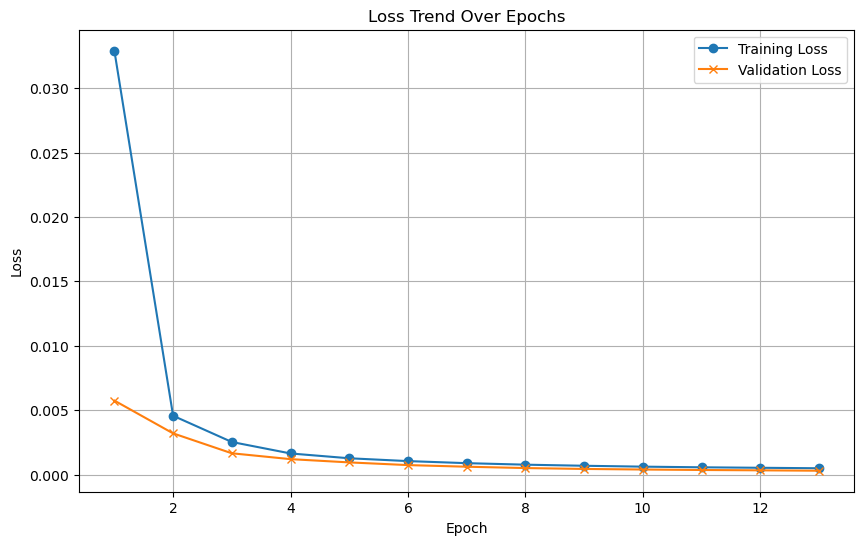

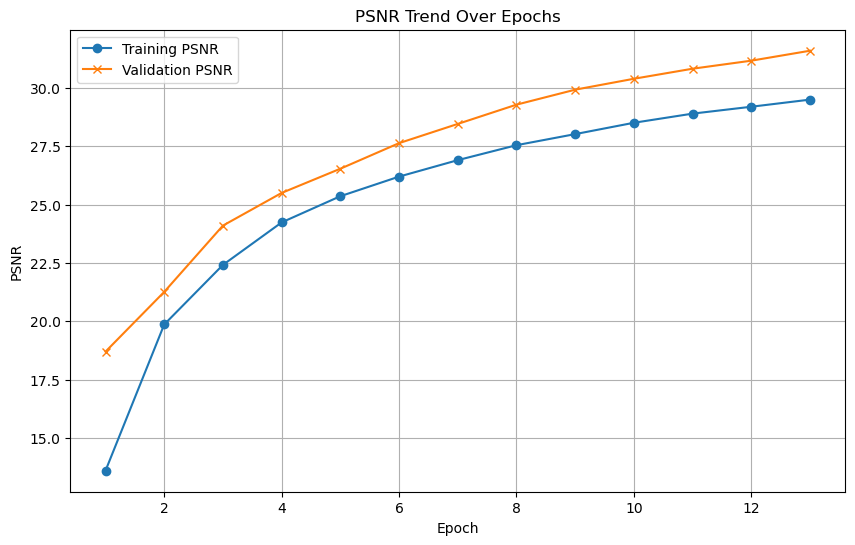

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/578 for test dataset.


    Processed batch 101/578 for test dataset.


    Processed batch 201/578 for test dataset.


    Processed batch 301/578 for test dataset.


    Processed batch 401/578 for test dataset.


    Processed batch 501/578 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1557
    Validation Batch [1/1], Loss: 2.2032
Validation Loss: 2.2032, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2032. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.0787
    Validation Batch [1/1], Loss: 2.2030
Validation Loss: 2.2030, Validation Accuracy: 11.11%
Validation loss improved from 2.2032 to 2.2030. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0353
    Validation Batch [1/1], Loss: 2.2028
Validation Loss: 2.2028, Validation Accuracy: 11.11%
Validation loss improved from 2.2030 to 2.2028. Saving model...

LOG: Epoch [4/1000] - Training


Epoch [4/1000] completed, Average Training Loss: 2.0007
    Validation Batch [1/1], Loss: 2.2027
Validation Loss: 2.2027, Validation Accuracy: 11.11%
Validation loss improved from 2.2028 to 2.2027. Saving model...

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Training Loss: 1.9648
    Validation Batch [1/1], Loss: 2.2022
Validation Loss: 2.2022, Validation Accuracy: 11.11%
Validation loss improved from 2.2027 to 2.2022. Saving model...

LOG: Epoch [6/1000] - Training
Epoch [6/1000] completed, Average Training Loss: 1.9485
    Validation Batch [1/1], Loss: 2.2017
Validation Loss: 2.2017, Validation Accuracy: 11.11%
Validation loss improved from 2.2022 to 2.2017. Saving model...

LOG: Epoch [7/1000] - Training
Epoch [7/1000] completed, Average Training Loss: 1.9155
    Validation Batch [1/1], Loss: 2.2009
Validation Loss: 2.2009, Validation Accuracy: 11.11%
Validation loss improved from 2.2017 to 2.2009. Saving model...

LOG: Epoch [8/1000] - Training
Epoch [8/1000] c

Epoch [21/1000] completed, Average Training Loss: 1.6084
    Validation Batch [1/1], Loss: 1.9562
Validation Loss: 1.9562, Validation Accuracy: 53.33%
Validation loss improved from 1.9973 to 1.9562. Saving model...

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 1.6107
    Validation Batch [1/1], Loss: 1.9099
Validation Loss: 1.9099, Validation Accuracy: 53.33%
Validation loss improved from 1.9562 to 1.9099. Saving model...

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 1.5941
    Validation Batch [1/1], Loss: 1.8613
Validation Loss: 1.8613, Validation Accuracy: 60.00%
Validation loss improved from 1.9099 to 1.8613. Saving model...

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 1.5762
    Validation Batch [1/1], Loss: 1.8112
Validation Loss: 1.8112, Validation Accuracy: 64.44%
Validation loss improved from 1.8613 to 1.8112. Saving model...

LOG: Epoch [25/1000] - Training
Epoch [2

Epoch [38/1000] completed, Average Training Loss: 1.3468
    Validation Batch [1/1], Loss: 1.3374
Validation Loss: 1.3374, Validation Accuracy: 82.22%
Validation loss improved from 1.3505 to 1.3374. Saving model...

LOG: Epoch [39/1000] - Training
Epoch [39/1000] completed, Average Training Loss: 1.3225
    Validation Batch [1/1], Loss: 1.3164
Validation Loss: 1.3164, Validation Accuracy: 82.22%
Validation loss improved from 1.3374 to 1.3164. Saving model...

LOG: Epoch [40/1000] - Training
Epoch [40/1000] completed, Average Training Loss: 1.3178
    Validation Batch [1/1], Loss: 1.2902
Validation Loss: 1.2902, Validation Accuracy: 80.00%
Validation loss improved from 1.3164 to 1.2902. Saving model...

LOG: Epoch [41/1000] - Training
Epoch [41/1000] completed, Average Training Loss: 1.3095
    Validation Batch [1/1], Loss: 1.2778
Validation Loss: 1.2778, Validation Accuracy: 82.22%
Validation loss improved from 1.2902 to 1.2778. Saving model...

LOG: Epoch [42/1000] - Training
Epoch [4

Epoch [55/1000] completed, Average Training Loss: 1.0491
    Validation Batch [1/1], Loss: 1.0577
Validation Loss: 1.0577, Validation Accuracy: 82.22%
Validation loss improved from 1.0716 to 1.0577. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.0713
    Validation Batch [1/1], Loss: 1.0325
Validation Loss: 1.0325, Validation Accuracy: 82.22%
Validation loss improved from 1.0577 to 1.0325. Saving model...

LOG: Epoch [57/1000] - Training
Epoch [57/1000] completed, Average Training Loss: 1.0479
    Validation Batch [1/1], Loss: 1.0217
Validation Loss: 1.0217, Validation Accuracy: 80.00%
Validation loss improved from 1.0325 to 1.0217. Saving model...

LOG: Epoch [58/1000] - Training
Epoch [58/1000] completed, Average Training Loss: 1.0287
    Validation Batch [1/1], Loss: 1.0069
Validation Loss: 1.0069, Validation Accuracy: 86.67%
Validation loss improved from 1.0217 to 1.0069. Saving model...

LOG: Epoch [59/1000] - Training
Epoch [5

Epoch [72/1000] completed, Average Training Loss: 0.8137
    Validation Batch [1/1], Loss: 0.8099
Validation Loss: 0.8099, Validation Accuracy: 91.11%
Validation loss improved from 0.8318 to 0.8099. Saving model...

LOG: Epoch [73/1000] - Training
Epoch [73/1000] completed, Average Training Loss: 0.8012
    Validation Batch [1/1], Loss: 0.7966
Validation Loss: 0.7966, Validation Accuracy: 93.33%
Validation loss improved from 0.8099 to 0.7966. Saving model...

LOG: Epoch [74/1000] - Training
Epoch [74/1000] completed, Average Training Loss: 0.7710
    Validation Batch [1/1], Loss: 0.7868
Validation Loss: 0.7868, Validation Accuracy: 93.33%
Validation loss improved from 0.7966 to 0.7868. Saving model...

LOG: Epoch [75/1000] - Training
Epoch [75/1000] completed, Average Training Loss: 0.7868
    Validation Batch [1/1], Loss: 0.7698
Validation Loss: 0.7698, Validation Accuracy: 91.11%
Validation loss improved from 0.7868 to 0.7698. Saving model...

LOG: Epoch [76/1000] - Training
Epoch [7

    Validation Batch [1/1], Loss: 0.6125
Validation Loss: 0.6125, Validation Accuracy: 93.33%
Validation loss improved from 0.6229 to 0.6125. Saving model...

LOG: Epoch [89/1000] - Training
Epoch [89/1000] completed, Average Training Loss: 0.5765
    Validation Batch [1/1], Loss: 0.6031
Validation Loss: 0.6031, Validation Accuracy: 91.11%
Validation loss improved from 0.6125 to 0.6031. Saving model...

LOG: Epoch [90/1000] - Training
Epoch [90/1000] completed, Average Training Loss: 0.5985
    Validation Batch [1/1], Loss: 0.6017
Validation Loss: 0.6017, Validation Accuracy: 91.11%
Validation loss improved from 0.6031 to 0.6017. Saving model...

LOG: Epoch [91/1000] - Training
Epoch [91/1000] completed, Average Training Loss: 0.5655
    Validation Batch [1/1], Loss: 0.5799
Validation Loss: 0.5799, Validation Accuracy: 93.33%
Validation loss improved from 0.6017 to 0.5799. Saving model...

LOG: Epoch [92/1000] - Training
Epoch [92/1000] completed, Average Training Loss: 0.5687
    Vali

Epoch [105/1000] completed, Average Training Loss: 0.4170
    Validation Batch [1/1], Loss: 0.4452
Validation Loss: 0.4452, Validation Accuracy: 91.11%
Validation loss improved from 0.4466 to 0.4452. Saving model...

LOG: Epoch [106/1000] - Training
Epoch [106/1000] completed, Average Training Loss: 0.4066
    Validation Batch [1/1], Loss: 0.4464
Validation Loss: 0.4464, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [107/1000] - Training
Epoch [107/1000] completed, Average Training Loss: 0.4028
    Validation Batch [1/1], Loss: 0.4367
Validation Loss: 0.4367, Validation Accuracy: 93.33%
Validation loss improved from 0.4452 to 0.4367. Saving model...

LOG: Epoch [108/1000] - Training
Epoch [108/1000] completed, Average Training Loss: 0.3834
    Validation Batch [1/1], Loss: 0.4287
Validation Loss: 0.4287, Validation Accuracy: 91.11%
Validation loss improved from 0.4367 to 0.4287. Saving model...

LOG: Epoch [109/1000] - Training
Epoch [109/1000

Epoch [122/1000] completed, Average Training Loss: 0.2800
    Validation Batch [1/1], Loss: 0.3629
Validation Loss: 0.3629, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [123/1000] - Training
Epoch [123/1000] completed, Average Training Loss: 0.2750
    Validation Batch [1/1], Loss: 0.3531
Validation Loss: 0.3531, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 0.2569
    Validation Batch [1/1], Loss: 0.3499
Validation Loss: 0.3499, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 0.2615
    Validation Batch [1/1], Loss: 0.3380
Validation Loss: 0.3380, Validation Accuracy: 93.33%
Validation loss improved from 0.3484 to 0.3380. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training 

Epoch [139/1000] completed, Average Training Loss: 0.1965
    Validation Batch [1/1], Loss: 0.2971
Validation Loss: 0.2971, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 0.1901
    Validation Batch [1/1], Loss: 0.2971
Validation Loss: 0.2971, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 0.2035
    Validation Batch [1/1], Loss: 0.2853
Validation Loss: 0.2853, Validation Accuracy: 91.11%
Validation loss improved from 0.2947 to 0.2853. Saving model...

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 0.1814
    Validation Batch [1/1], Loss: 0.2821
Validation Loss: 0.2821, Validation Accuracy: 91.11%
Validation loss improved from 0.2853 to 0.2821. Saving model...

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Av

Epoch [156/1000] completed, Average Training Loss: 0.1532
    Validation Batch [1/1], Loss: 0.2443
Validation Loss: 0.2443, Validation Accuracy: 91.11%
Validation loss improved from 0.2631 to 0.2443. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 0.1484
    Validation Batch [1/1], Loss: 0.2679
Validation Loss: 0.2679, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 0.1476
    Validation Batch [1/1], Loss: 0.2742
Validation Loss: 0.2742, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 0.1390
    Validation Batch [1/1], Loss: 0.2721
Validation Loss: 0.2721, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [160/1000] - Training
Epoch [160/1000] completed, Average Training 

Epoch [173/1000] completed, Average Training Loss: 0.1054
    Validation Batch [1/1], Loss: 0.2620
Validation Loss: 0.2620, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [174/1000] - Training
Epoch [174/1000] completed, Average Training Loss: 0.1115
    Validation Batch [1/1], Loss: 0.2654
Validation Loss: 0.2654, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [175/1000] - Training
Epoch [175/1000] completed, Average Training Loss: 0.1040
    Validation Batch [1/1], Loss: 0.2585
Validation Loss: 0.2585, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [176/1000] - Training
Epoch [176/1000] completed, Average Training Loss: 0.1064
    Validation Batch [1/1], Loss: 0.2600
Validation Loss: 0.2600, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [177/1000] - Training
Epoch [177/1000] completed, Average Training Loss: 0.100

    Validation Batch [1/1], Loss: 0.2354
Validation Loss: 0.2354, Validation Accuracy: 93.33%
Validation loss improved from 0.2410 to 0.2354. Saving model...

LOG: Epoch [191/1000] - Training
Epoch [191/1000] completed, Average Training Loss: 0.0850
    Validation Batch [1/1], Loss: 0.2567
Validation Loss: 0.2567, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [192/1000] - Training
Epoch [192/1000] completed, Average Training Loss: 0.0895
    Validation Batch [1/1], Loss: 0.2630
Validation Loss: 0.2630, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [193/1000] - Training
Epoch [193/1000] completed, Average Training Loss: 0.0907
    Validation Batch [1/1], Loss: 0.2543
Validation Loss: 0.2543, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [194/1000] - Training
Epoch [194/1000] completed, Average Training Loss: 0.0766
    Validation Batch [1/1], Loss: 0.2443
Vali

Epoch [207/1000] completed, Average Training Loss: 0.0751
    Validation Batch [1/1], Loss: 0.2480
Validation Loss: 0.2480, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [208/1000] - Training
Epoch [208/1000] completed, Average Training Loss: 0.0746
    Validation Batch [1/1], Loss: 0.2481
Validation Loss: 0.2481, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.0684
    Validation Batch [1/1], Loss: 0.2594
Validation Loss: 0.2594, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.0612
    Validation Batch [1/1], Loss: 0.2523
Validation Loss: 0.2523, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.064

Epoch [224/1000] completed, Average Training Loss: 0.0555
    Validation Batch [1/1], Loss: 0.2819
Validation Loss: 0.2819, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [225/1000] - Training
Epoch [225/1000] completed, Average Training Loss: 0.0677
    Validation Batch [1/1], Loss: 0.2958
Validation Loss: 0.2958, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 35/100

LOG: Epoch [226/1000] - Training
Epoch [226/1000] completed, Average Training Loss: 0.0526
    Validation Batch [1/1], Loss: 0.2625
Validation Loss: 0.2625, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [227/1000] - Training
Epoch [227/1000] completed, Average Training Loss: 0.0554
    Validation Batch [1/1], Loss: 0.2621
Validation Loss: 0.2621, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [228/1000] - Training
Epoch [228/1000] completed, Average Training Loss: 0.056

Epoch [241/1000] completed, Average Training Loss: 0.0487
    Validation Batch [1/1], Loss: 0.2555
Validation Loss: 0.2555, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.0445
    Validation Batch [1/1], Loss: 0.2436
Validation Loss: 0.2436, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.0429
    Validation Batch [1/1], Loss: 0.2507
Validation Loss: 0.2507, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.0456
    Validation Batch [1/1], Loss: 0.2536
Validation Loss: 0.2536, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [245/1000] - Training
Epoch [245/1000] completed, Average Training Loss: 0.045

Epoch [258/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.2597
Validation Loss: 0.2597, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 68/100

LOG: Epoch [259/1000] - Training
Epoch [259/1000] completed, Average Training Loss: 0.0398
    Validation Batch [1/1], Loss: 0.2967
Validation Loss: 0.2967, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 69/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.0385
    Validation Batch [1/1], Loss: 0.3100
Validation Loss: 0.3100, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 70/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.2395
Validation Loss: 0.2395, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.039

Epoch [275/1000] completed, Average Training Loss: 0.0383
    Validation Batch [1/1], Loss: 0.2784
Validation Loss: 0.2784, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 85/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.0333
    Validation Batch [1/1], Loss: 0.2836
Validation Loss: 0.2836, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 86/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training Loss: 0.0347
    Validation Batch [1/1], Loss: 0.2993
Validation Loss: 0.2993, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 87/100

LOG: Epoch [278/1000] - Training
Epoch [278/1000] completed, Average Training Loss: 0.0376
    Validation Batch [1/1], Loss: 0.2709
Validation Loss: 0.2709, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 88/100

LOG: Epoch [279/1000] - Training
Epoch [279/1000] completed, Average Training Loss: 0.031

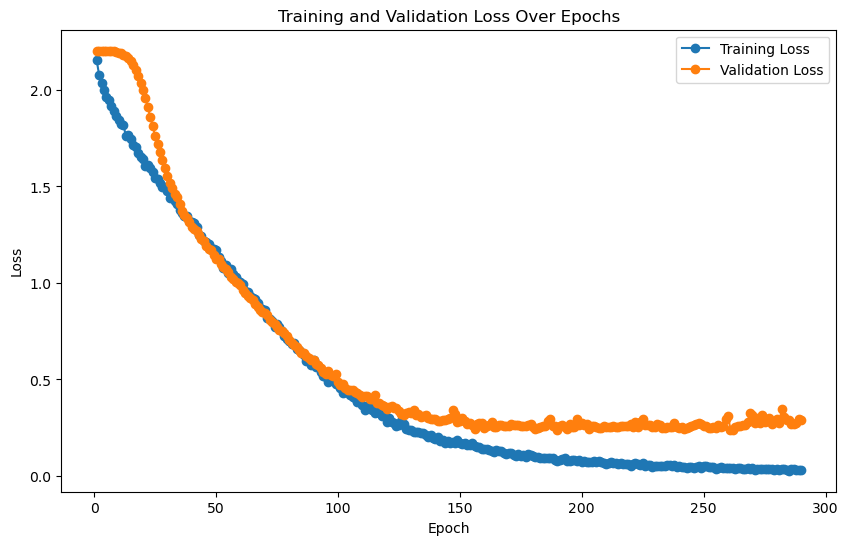

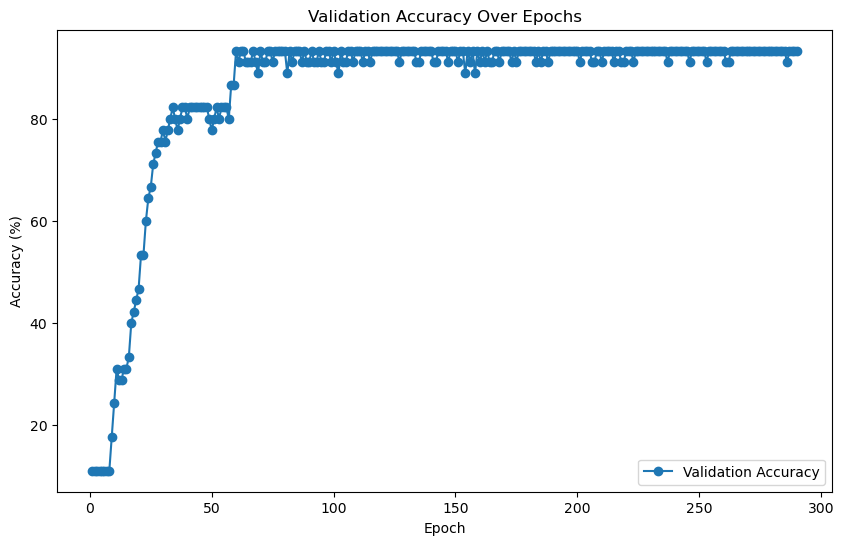


Evaluating on the test set...
    Test Batch [1/578], Loss: 0.0599



Final Test Loss: 0.0560, Test Accuracy: 98.72%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.


  Processed batch 40/578 for test dataset.


  Processed batch 50/578 for test dataset.
  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.


  Processed batch 90/578 for test dataset.


  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.
  Processed batch 130/578 for test dataset.


  Processed batch 140/578 for test dataset.


  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.
  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.


  Processed batch 190/578 for test dataset.


  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.


  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.


  Processed batch 290/578 for test dataset.


  Processed batch 300/578 for test dataset.
  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.


  Processed batch 340/578 for test dataset.


  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.
  Processed batch 380/578 for test dataset.


  Processed batch 390/578 for test dataset.


  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.


  Processed batch 440/578 for test dataset.
  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.


  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.
  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.


  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (147747, 64), Test labels shape: (147747,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       0.83      1.00      0.91         5
           4       1.00      0.80      0.89         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00    


Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.96      0.91      0.93      7553
           2       0.78      0.91      0.84      3045
           3       0.61      0.98      0.75      2640
           4       0.95      0.87      0.91      6539
           5       0.89      0.95      0.92      9203
           6       0.96      0.85      0.90      7242
           7       0.99      0.98      0.99     42781
           8       0.98      1.00      0.99      2818

    accuracy                           0.97    147747
   macro avg       0.90      0.94      0.91    147747
weighted avg       0.97      0.97      0.97    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (147747, 64)
Test labels shape: (147747,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.0151  |  Val Loss: 1.8159
Validation loss improved from inf to 1.8159.


[Epoch 2/1000] Train Loss: 1.7207  |  Val Loss: 1.5804
Validation loss improved from 1.8159 to 1.5804.
[Epoch 3/1000] Train Loss: 1.5149  |  Val Loss: 1.3897
Validation loss improved from 1.5804 to 1.3897.
[Epoch 4/1000] Train Loss: 1.3323  |  Val Loss: 1.2083
Validation loss improved from 1.3897 to 1.2083.
[Epoch 5/1000] Train Loss: 1.1679  |  Val Loss: 1.0435
Validation loss improved from 1.2083 to 1.0435.
[Epoch 6/1000] Train Loss: 1.0084  |  Val Loss: 0.8826
Validation loss improved from 1.0435 to 0.8826.
[Epoch 7/1000] Train Loss: 0.8585  |  Val Loss: 0.7324
Validation loss improved from 0.8826 to 0.7324.
[Epoch 8/1000] Train Loss: 0.7194  |  Val Loss: 0.5957
Validation loss improved from 0.7324 to 0.5957.
[Epoch 9/1000] Train Loss: 0.5911  |  Val Loss: 0.4988
Validation loss improved from 0.5957 to 0.4988.
[Epoch 10/1000] Train Loss: 0.5034  |  Val Loss: 0.4138
Validation loss improved from 0.4988 to 0.4138.
[Epoch 11/1000] Train Loss: 0.4375  |  Val Loss: 0.3618
Validation loss 

[Epoch 18/1000] Train Loss: 0.2262  |  Val Loss: 0.2025
Validation loss improved from 0.2098 to 0.2025.
[Epoch 19/1000] Train Loss: 0.2205  |  Val Loss: 0.1930
Validation loss improved from 0.2025 to 0.1930.
[Epoch 20/1000] Train Loss: 0.2086  |  Val Loss: 0.1805
Validation loss improved from 0.1930 to 0.1805.
[Epoch 21/1000] Train Loss: 0.2006  |  Val Loss: 0.1759
Validation loss improved from 0.1805 to 0.1759.
[Epoch 22/1000] Train Loss: 0.1933  |  Val Loss: 0.1729
Validation loss improved from 0.1759 to 0.1729.
[Epoch 23/1000] Train Loss: 0.1859  |  Val Loss: 0.1700
Validation loss improved from 0.1729 to 0.1700.
[Epoch 24/1000] Train Loss: 0.1821  |  Val Loss: 0.1635
Validation loss improved from 0.1700 to 0.1635.
[Epoch 25/1000] Train Loss: 0.1712  |  Val Loss: 0.1610
Validation loss improved from 0.1635 to 0.1610.
[Epoch 26/1000] Train Loss: 0.1708  |  Val Loss: 0.1630
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.1608  |  Val Loss: 0.1604
Va

[Epoch 35/1000] Train Loss: 0.1317  |  Val Loss: 0.1786
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 0.1271  |  Val Loss: 0.1392
Validation loss improved from 0.1450 to 0.1392.
[Epoch 37/1000] Train Loss: 0.1267  |  Val Loss: 0.1438
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 38/1000] Train Loss: 0.1200  |  Val Loss: 0.1436
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 39/1000] Train Loss: 0.1188  |  Val Loss: 0.1363
Validation loss improved from 0.1392 to 0.1363.
[Epoch 40/1000] Train Loss: 0.1196  |  Val Loss: 0.1429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.1135  |  Val Loss: 0.1363
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 42/1000] Train Loss: 0.1057  |  Val Loss: 0.1495
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 43/1000] Train Loss: 0.1204  |  Val Loss: 0.1368
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 44/1000] Train 

[Epoch 52/1000] Train Loss: 0.0987  |  Val Loss: 0.1397
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 53/1000] Train Loss: 0.0936  |  Val Loss: 0.1234
Validation loss improved from 0.1277 to 0.1234.
[Epoch 54/1000] Train Loss: 0.0941  |  Val Loss: 0.1492
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.0966  |  Val Loss: 0.1245
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 56/1000] Train Loss: 0.0880  |  Val Loss: 0.1385
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 57/1000] Train Loss: 0.0986  |  Val Loss: 0.1320
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 58/1000] Train Loss: 0.0919  |  Val Loss: 0.1288
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 59/1000] Train Loss: 0.0946  |  Val Loss: 0.1575
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 60/1000] Train Loss: 0.0837  |  Val Loss: 0.1312
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 61/1000] 

[Epoch 68/1000] Train Loss: 0.0799  |  Val Loss: 0.1330
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 69/1000] Train Loss: 0.0824  |  Val Loss: 0.1157
Validation loss improved from 0.1206 to 0.1157.
[Epoch 70/1000] Train Loss: 0.0663  |  Val Loss: 0.1521
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 71/1000] Train Loss: 0.0791  |  Val Loss: 0.1178
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 72/1000] Train Loss: 0.0762  |  Val Loss: 0.1293
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 73/1000] Train Loss: 0.0679  |  Val Loss: 0.1194
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 74/1000] Train Loss: 0.0671  |  Val Loss: 0.1290
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 75/1000] Train Loss: 0.0672  |  Val Loss: 0.1295
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 76/1000] Train Loss: 0.0713  |  Val Loss: 0.1312
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 77/1000] 

[Epoch 84/1000] Train Loss: 0.0615  |  Val Loss: 0.1093
Validation loss improved from 0.1097 to 0.1093.
[Epoch 85/1000] Train Loss: 0.0597  |  Val Loss: 0.1303
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 86/1000] Train Loss: 0.0610  |  Val Loss: 0.1077
Validation loss improved from 0.1093 to 0.1077.
[Epoch 87/1000] Train Loss: 0.0579  |  Val Loss: 0.1213
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 88/1000] Train Loss: 0.0596  |  Val Loss: 0.1210
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 89/1000] Train Loss: 0.0554  |  Val Loss: 0.1160
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 90/1000] Train Loss: 0.0570  |  Val Loss: 0.1138
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 91/1000] Train Loss: 0.0555  |  Val Loss: 0.1228
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 92/1000] Train Loss: 0.0542  |  Val Loss: 0.1044
Validation loss improved from 0.1077 to 0.1044.
[Epoch 93/1000] Train Loss: 

[Epoch 101/1000] Train Loss: 0.0493  |  Val Loss: 0.1031
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.0470  |  Val Loss: 0.1082
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 0.0477  |  Val Loss: 0.1045
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 104/1000] Train Loss: 0.0476  |  Val Loss: 0.1050
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 105/1000] Train Loss: 0.0472  |  Val Loss: 0.1168
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 106/1000] Train Loss: 0.0500  |  Val Loss: 0.1042
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 107/1000] Train Loss: 0.0478  |  Val Loss: 0.1013
Validation loss improved from 0.1021 to 0.1013.
[Epoch 108/1000] Train Loss: 0.0462  |  Val Loss: 0.0986
Validation loss improved from 0.1013 to 0.0986.
[Epoch 109/1000] Train Loss: 0.0459  |  Val Loss: 0.1026
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 110/10

[Epoch 118/1000] Train Loss: 0.0483  |  Val Loss: 0.1155
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 0.0542  |  Val Loss: 0.0938
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 0.0567  |  Val Loss: 0.0972
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 0.0472  |  Val Loss: 0.0836
Validation loss improved from 0.0861 to 0.0836.
[Epoch 122/1000] Train Loss: 0.0393  |  Val Loss: 0.1245
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 123/1000] Train Loss: 0.0384  |  Val Loss: 0.0983
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 124/1000] Train Loss: 0.0392  |  Val Loss: 0.0972
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 125/1000] Train Loss: 0.0393  |  Val Loss: 0.0942
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 126/1000] Train Loss: 0.0364  |  Val Loss: 0.1017
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 135/1000] Train Loss: 0.0339  |  Val Loss: 0.0985
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 136/1000] Train Loss: 0.0320  |  Val Loss: 0.0798
Validation loss improved from 0.0826 to 0.0798.
[Epoch 137/1000] Train Loss: 0.0301  |  Val Loss: 0.0949
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 138/1000] Train Loss: 0.0323  |  Val Loss: 0.0786
Validation loss improved from 0.0798 to 0.0786.
[Epoch 139/1000] Train Loss: 0.0325  |  Val Loss: 0.1123
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Loss: 0.0358  |  Val Loss: 0.0800
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 141/1000] Train Loss: 0.0354  |  Val Loss: 0.1221
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 142/1000] Train Loss: 0.0399  |  Val Loss: 0.0830
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 143/1000] Train Loss: 0.0300  |  Val Loss: 0.0917
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 144/10

[Epoch 153/1000] Train Loss: 0.0307  |  Val Loss: 0.1001
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 154/1000] Train Loss: 0.0273  |  Val Loss: 0.0610
Validation loss improved from 0.0754 to 0.0610.
[Epoch 155/1000] Train Loss: 0.0288  |  Val Loss: 0.0756
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 0.0288  |  Val Loss: 0.0728
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 0.0235  |  Val Loss: 0.0965
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 0.0251  |  Val Loss: 0.0910
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 0.0240  |  Val Loss: 0.0728
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 160/1000] Train Loss: 0.0248  |  Val Loss: 0.0788
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 161/1000] Train Loss: 0.0246  |  Val Loss: 0.0787
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 

[Epoch 171/1000] Train Loss: 0.0243  |  Val Loss: 0.0692
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 172/1000] Train Loss: 0.0196  |  Val Loss: 0.0988
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 173/1000] Train Loss: 0.0212  |  Val Loss: 0.0763
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 174/1000] Train Loss: 0.0233  |  Val Loss: 0.0530
Validation loss improved from 0.0589 to 0.0530.
[Epoch 175/1000] Train Loss: 0.0217  |  Val Loss: 0.0787
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 0.0261  |  Val Loss: 0.0802
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 0.0215  |  Val Loss: 0.0670
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Loss: 0.0241  |  Val Loss: 0.0708
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 179/1000] Train Loss: 0.0216  |  Val Loss: 0.0682
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 

[Epoch 188/1000] Train Loss: 0.0161  |  Val Loss: 0.0636
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 189/1000] Train Loss: 0.0160  |  Val Loss: 0.0737
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 190/1000] Train Loss: 0.0172  |  Val Loss: 0.0787
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 191/1000] Train Loss: 0.0162  |  Val Loss: 0.0675
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 192/1000] Train Loss: 0.0161  |  Val Loss: 0.0710
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 193/1000] Train Loss: 0.0172  |  Val Loss: 0.0663
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 194/1000] Train Loss: 0.0155  |  Val Loss: 0.0681
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 195/1000] Train Loss: 0.0183  |  Val Loss: 0.0540
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 196/1000] Train Loss: 0.0248  |  Val Loss: 0.1225
!! Validation loss did NOT improve !! Patience:

[Epoch 205/1000] Train Loss: 0.0205  |  Val Loss: 0.0812
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 206/1000] Train Loss: 0.0275  |  Val Loss: 0.0777
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 207/1000] Train Loss: 0.0302  |  Val Loss: 0.0476
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 208/1000] Train Loss: 0.0264  |  Val Loss: 0.0738
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 209/1000] Train Loss: 0.0132  |  Val Loss: 0.0912
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 210/1000] Train Loss: 0.0170  |  Val Loss: 0.0523
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 211/1000] Train Loss: 0.0149  |  Val Loss: 0.0908
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 212/1000] Train Loss: 0.0165  |  Val Loss: 0.0670
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 213/1000] Train Loss: 0.0176  |  Val Loss: 0.0608
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 222/1000] Train Loss: 0.0114  |  Val Loss: 0.0803
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 223/1000] Train Loss: 0.0106  |  Val Loss: 0.0594
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 224/1000] Train Loss: 0.0137  |  Val Loss: 0.0810
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 225/1000] Train Loss: 0.0256  |  Val Loss: 0.0571
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 226/1000] Train Loss: 0.0217  |  Val Loss: 0.0821
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 227/1000] Train Loss: 0.0141  |  Val Loss: 0.0628
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 228/1000] Train Loss: 0.0115  |  Val Loss: 0.0692
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 229/1000] Train Loss: 0.0106  |  Val Loss: 0.0887
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 230/1000] Train Loss: 0.0140  |  Val Loss: 0.0547
!! Validation loss did NOT improve !! Patience:

[Epoch 240/1000] Train Loss: 0.0130  |  Val Loss: 0.0686
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 241/1000] Train Loss: 0.0131  |  Val Loss: 0.0643
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 242/1000] Train Loss: 0.0101  |  Val Loss: 0.0628
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 243/1000] Train Loss: 0.0100  |  Val Loss: 0.0665
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 244/1000] Train Loss: 0.0104  |  Val Loss: 0.0647
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 245/1000] Train Loss: 0.0109  |  Val Loss: 0.0739
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 246/1000] Train Loss: 0.0104  |  Val Loss: 0.0518
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 247/1000] Train Loss: 0.0139  |  Val Loss: 0.0779
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 248/1000] Train Loss: 0.0079  |  Val Loss: 0.0489
!! Validation loss did NOT improve !! Patience:

[Epoch 257/1000] Train Loss: 0.0166  |  Val Loss: 0.0482
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 258/1000] Train Loss: 0.0143  |  Val Loss: 0.0880
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 259/1000] Train Loss: 0.0089  |  Val Loss: 0.0521
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 260/1000] Train Loss: 0.0155  |  Val Loss: 0.0896
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 261/1000] Train Loss: 0.0111  |  Val Loss: 0.0541
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 262/1000] Train Loss: 0.0169  |  Val Loss: 0.1171
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 263/1000] Train Loss: 0.0085  |  Val Loss: 0.0446
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 264/1000] Train Loss: 0.0096  |  Val Loss: 0.0697
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 265/1000] Train Loss: 0.0116  |  Val Loss: 0.0940
!! Validation loss did NOT improve !! Patience:

[Epoch 275/1000] Train Loss: 0.0067  |  Val Loss: 0.0611
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 276/1000] Train Loss: 0.0059  |  Val Loss: 0.0560
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 277/1000] Train Loss: 0.0076  |  Val Loss: 0.0677
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 278/1000] Train Loss: 0.0089  |  Val Loss: 0.0667
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 279/1000] Train Loss: 0.0119  |  Val Loss: 0.0737
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 280/1000] Train Loss: 0.0131  |  Val Loss: 0.0479
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 281/1000] Train Loss: 0.0105  |  Val Loss: 0.0944
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 282/1000] Train Loss: 0.0096  |  Val Loss: 0.0574
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 283/1000] Train Loss: 0.0060  |  Val Loss: 0.0587
!! Validation loss did NOT improve !! Patience:

[Epoch 293/1000] Train Loss: 0.0067  |  Val Loss: 0.0611
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 294/1000] Train Loss: 0.0059  |  Val Loss: 0.0402
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 295/1000] Train Loss: 0.0050  |  Val Loss: 0.0737
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 296/1000] Train Loss: 0.0052  |  Val Loss: 0.0659
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 297/1000] Train Loss: 0.0046  |  Val Loss: 0.0586
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 298/1000] Train Loss: 0.0044  |  Val Loss: 0.0539
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 299/1000] Train Loss: 0.0047  |  Val Loss: 0.0588
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 300/1000] Train Loss: 0.0046  |  Val Loss: 0.0769
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 301/1000] Train Loss: 0.0065  |  Val Loss: 0.0593
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 310/1000] Train Loss: 0.0084  |  Val Loss: 0.0499
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 311/1000] Train Loss: 0.0053  |  Val Loss: 0.0754
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 312/1000] Train Loss: 0.0044  |  Val Loss: 0.0511
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 313/1000] Train Loss: 0.0040  |  Val Loss: 0.0614
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 314/1000] Train Loss: 0.0043  |  Val Loss: 0.0521
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 315/1000] Train Loss: 0.0057  |  Val Loss: 0.0770
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 316/1000] Train Loss: 0.0053  |  Val Loss: 0.0556
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 317/1000] Train Loss: 0.0040  |  Val Loss: 0.0492
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 318/1000] Train Loss: 0.0037  |  Val Loss: 0.0577
!! Validation loss did NOT improve !! Patience:

[Epoch 327/1000] Train Loss: 0.0039  |  Val Loss: 0.0541
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 328/1000] Train Loss: 0.0033  |  Val Loss: 0.0592
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 329/1000] Train Loss: 0.0038  |  Val Loss: 0.0493
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 330/1000] Train Loss: 0.0030  |  Val Loss: 0.0584
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 331/1000] Train Loss: 0.0034  |  Val Loss: 0.0613
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 332/1000] Train Loss: 0.0035  |  Val Loss: 0.0483
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 333/1000] Train Loss: 0.0032  |  Val Loss: 0.0559
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 334/1000] Train Loss: 0.0032  |  Val Loss: 0.0515
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 335/1000] Train Loss: 0.0031  |  Val Loss: 0.0565
!! Validation loss did NOT improve !! Patience:

[Epoch 345/1000] Train Loss: 0.0035  |  Val Loss: 0.0535
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 346/1000] Train Loss: 0.0027  |  Val Loss: 0.0671
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 347/1000] Train Loss: 0.0028  |  Val Loss: 0.0564
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 348/1000] Train Loss: 0.0026  |  Val Loss: 0.0521
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 349/1000] Train Loss: 0.0028  |  Val Loss: 0.0493
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 350/1000] Train Loss: 0.0025  |  Val Loss: 0.0645
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 351/1000] Train Loss: 0.0026  |  Val Loss: 0.0587
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 352/1000] Train Loss: 0.0030  |  Val Loss: 0.0454
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 353/1000] Train Loss: 0.0024  |  Val Loss: 0.0521
!! Validation loss did NOT improve !! Patience:

[Epoch 362/1000] Train Loss: 0.0029  |  Val Loss: 0.0586
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 363/1000] Train Loss: 0.0034  |  Val Loss: 0.0492
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 364/1000] Train Loss: 0.0029  |  Val Loss: 0.0617
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 365/1000] Train Loss: 0.0023  |  Val Loss: 0.0518
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 366/1000] Train Loss: 0.0023  |  Val Loss: 0.0630
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 367/1000] Train Loss: 0.0025  |  Val Loss: 0.0481
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 368/1000] Train Loss: 0.0024  |  Val Loss: 0.0534
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 369/1000] Train Loss: 0.0021  |  Val Loss: 0.0575
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 370/1000] Train Loss: 0.0021  |  Val Loss: 0.0515
!! Validation loss did NOT improve !! Patience:

[Epoch 380/1000] Train Loss: 0.0020  |  Val Loss: 0.0549
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 381/1000] Train Loss: 0.0020  |  Val Loss: 0.0449
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 382/1000] Train Loss: 0.0019  |  Val Loss: 0.0598
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 383/1000] Train Loss: 0.0018  |  Val Loss: 0.0551
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 384/1000] Train Loss: 0.0018  |  Val Loss: 0.0532
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 385/1000] Train Loss: 0.0023  |  Val Loss: 0.0462
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 386/1000] Train Loss: 0.0017  |  Val Loss: 0.0667
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 387/1000] Train Loss: 0.0031  |  Val Loss: 0.0481
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 388/1000] Train Loss: 0.0016  |  Val Loss: 0.0686
!! Validation loss did NOT improve !! Patience:

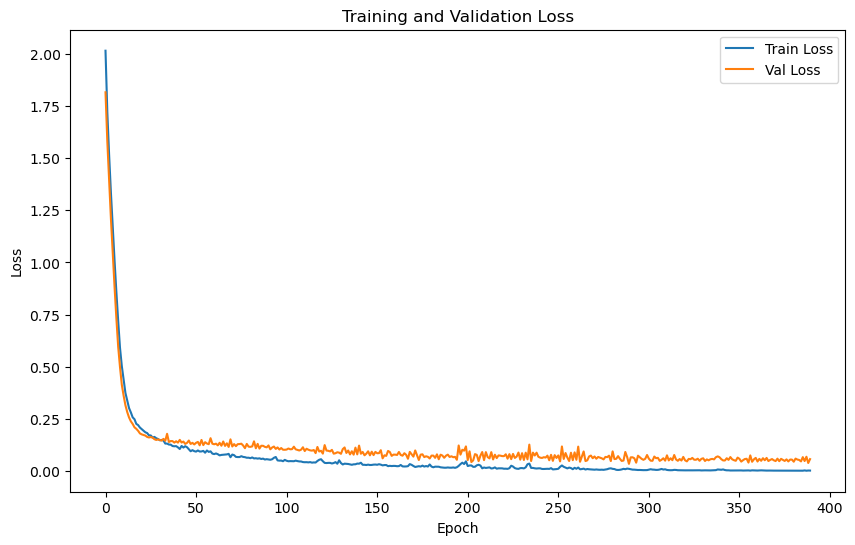

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 0.2099 | Test Accuracy: 96.36%


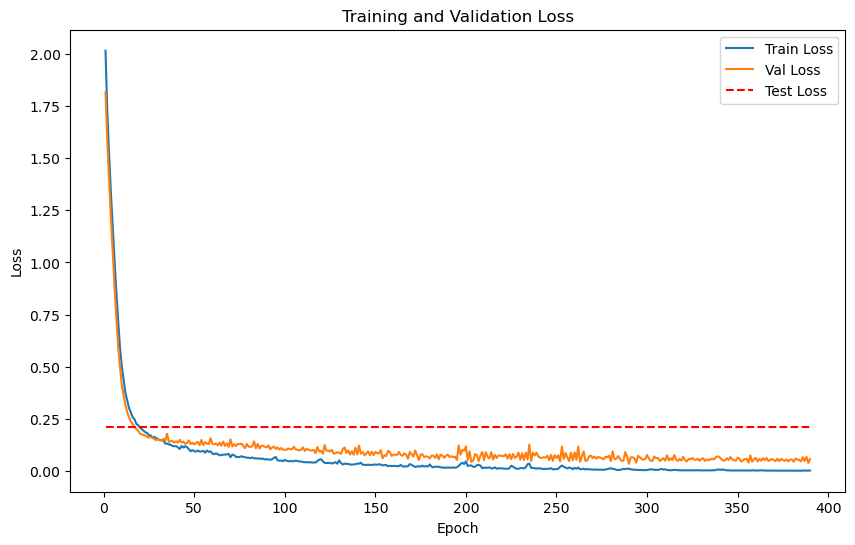

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 9.0906


    Batch [2/2], Train Loss: 9.0123
Epoch [1/2000], Avg Train Loss: 9.0514
Epoch [1/2000], Avg Val Loss: 3.8213
Validation loss improved from inf to 3.8213. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.9115
    Batch [2/2], Train Loss: 8.6859
Epoch [2/2000], Avg Train Loss: 8.7987
Epoch [2/2000], Avg Val Loss: 3.7261
Validation loss improved from 3.8213 to 3.7261. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.6707
    Batch [2/2], Train Loss: 8.6896
Epoch [3/2000], Avg Train Loss: 8.6801
Epoch [3/2000], Avg Val Loss: 3.6356
Validation loss improved from 3.7261 to 3.6356. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.7894
    Batch [2/2], Train Loss: 8.6295
Epoch [4/2000], Avg Train Loss: 8.7094
Epoch [4/2000], Avg Val Loss: 3.5501
Validation loss improved from 3.6356 to 3.5501. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 8.3995
    Batch [2/2], Train Loss: 8.3051
Epoch [5/2000], Avg Train Loss: 8.3523
Epoch [5/2000], Avg Val Loss: 3.4695
Validation loss improved from 3.5501 to 3.4695. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 8.4071
    Batch [2/2], Train Loss: 8.1457
Epoch [6/2000], Avg Train Loss: 8.2764
Epoch [6/2000], Avg Val Loss: 3.3938
Validation loss improved from 3.4695 to 3.3938. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 8.3122
    Batch [2/2], Train Loss: 8.1467
Epoch [7/2000], Avg Train Loss: 8.2294
Epoch [7/2000], Avg Val Loss: 3.3223
Validation loss improved from 3.3938 to 3.3223. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 8.0436
    Batch [2/2], Train Loss: 7.8504
Epoch [8/2000], Avg Train Loss: 7.9470
Epoch [8/2000], Avg Val Loss: 3.2551
Validation loss improved from 3.3223 to 3.2551. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train L

    Batch [2/2], Train Loss: 5.9840
Epoch [25/2000], Avg Train Loss: 6.0864
Epoch [25/2000], Avg Val Loss: 2.6293
Validation loss improved from 2.6465 to 2.6293. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.9670
    Batch [2/2], Train Loss: 5.9009
Epoch [26/2000], Avg Train Loss: 5.9340
Epoch [26/2000], Avg Val Loss: 2.6137
Validation loss improved from 2.6293 to 2.6137. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.7962
    Batch [2/2], Train Loss: 5.8181
Epoch [27/2000], Avg Train Loss: 5.8072
Epoch [27/2000], Avg Val Loss: 2.5996
Validation loss improved from 2.6137 to 2.5996. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.7684
    Batch [2/2], Train Loss: 5.7837
Epoch [28/2000], Avg Train Loss: 5.7760
Epoch [28/2000], Avg Val Loss: 2.5868
Validation loss improved from 2.5996 to 2.5868. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.5537
    Batch [2

    Batch [1/2], Train Loss: 5.5204
    Batch [2/2], Train Loss: 5.6589
Epoch [31/2000], Avg Train Loss: 5.5897
Epoch [31/2000], Avg Val Loss: 2.5552
Validation loss improved from 2.5648 to 2.5552. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 5.6404
    Batch [2/2], Train Loss: 5.6317
Epoch [32/2000], Avg Train Loss: 5.6361
Epoch [32/2000], Avg Val Loss: 2.5466
Validation loss improved from 2.5552 to 2.5466. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 5.5559
    Batch [2/2], Train Loss: 5.3975
Epoch [33/2000], Avg Train Loss: 5.4767
Epoch [33/2000], Avg Val Loss: 2.5387
Validation loss improved from 2.5466 to 2.5387. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.3988
    Batch [2/2], Train Loss: 5.4992
Epoch [34/2000], Avg Train Loss: 5.4490
Epoch [34/2000], Avg Val Loss: 2.5315
Validation loss improved from 2.5387 to 2.5315. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.8721
    Batch [2/2], Train Loss: 4.8408
Epoch [51/2000], Avg Train Loss: 4.8564
Epoch [51/2000], Avg Val Loss: 2.4722
Validation loss improved from 2.4740 to 2.4722. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 4.7751
    Batch [2/2], Train Loss: 4.7445
Epoch [52/2000], Avg Train Loss: 4.7598
Epoch [52/2000], Avg Val Loss: 2.4706
Validation loss improved from 2.4722 to 2.4706. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 4.7011
    Batch [2/2], Train Loss: 4.8252
Epoch [53/2000], Avg Train Loss: 4.7632
Epoch [53/2000], Avg Val Loss: 2.4690
Validation loss improved from 2.4706 to 2.4690. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.7025
    Batch [2/2], Train Loss: 4.7156
Epoch [54/2000], Avg Train Loss: 4.7090
Epoch [54/2000], Avg Val Loss: 2.4675
Validation loss improved from 2.4690 to 2.4675. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.7250
    Batch [2/2], Train Loss: 4.7407
Epoch [56/2000], Avg Train Loss: 4.7328
Epoch [56/2000], Avg Val Loss: 2.4646
Validation loss improved from 2.4660 to 2.4646. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 4.6977
    Batch [2/2], Train Loss: 4.6841
Epoch [57/2000], Avg Train Loss: 4.6909
Epoch [57/2000], Avg Val Loss: 2.4633
Validation loss improved from 2.4646 to 2.4633. Saving model...

LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 4.6663
    Batch [2/2], Train Loss: 4.6423
Epoch [58/2000], Avg Train Loss: 4.6543
Epoch [58/2000], Avg Val Loss: 2.4619
Validation loss improved from 2.4633 to 2.4619. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 4.6357
    Batch [2/2], Train Loss: 4.7207
Epoch [59/2000], Avg Train Loss: 4.6782
Epoch [59/2000], Avg Val Loss: 2.4606
Validation loss improved from 2.4619 to 2.4606. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1

    Batch [1/2], Train Loss: 4.5218
    Batch [2/2], Train Loss: 4.4272
Epoch [75/2000], Avg Train Loss: 4.4745
Epoch [75/2000], Avg Val Loss: 2.4385
Validation loss improved from 2.4399 to 2.4385. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.5354
    Batch [2/2], Train Loss: 4.4755
Epoch [76/2000], Avg Train Loss: 4.5055
Epoch [76/2000], Avg Val Loss: 2.4371
Validation loss improved from 2.4385 to 2.4371. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.4591
    Batch [2/2], Train Loss: 4.4961
Epoch [77/2000], Avg Train Loss: 4.4776
Epoch [77/2000], Avg Val Loss: 2.4357
Validation loss improved from 2.4371 to 2.4357. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.4473
    Batch [2/2], Train Loss: 4.3874
Epoch [78/2000], Avg Train Loss: 4.4174
Epoch [78/2000], Avg Val Loss: 2.4342
Validation loss improved from 2.4357 to 2.4342. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1

Epoch [80/2000], Avg Val Loss: 2.4312
Validation loss improved from 2.4327 to 2.4312. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 4.4380
    Batch [2/2], Train Loss: 4.3772
Epoch [81/2000], Avg Train Loss: 4.4076
Epoch [81/2000], Avg Val Loss: 2.4297
Validation loss improved from 2.4312 to 2.4297. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.3696
    Batch [2/2], Train Loss: 4.3842
Epoch [82/2000], Avg Train Loss: 4.3769
Epoch [82/2000], Avg Val Loss: 2.4281
Validation loss improved from 2.4297 to 2.4281. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.4042
    Batch [2/2], Train Loss: 4.3261
Epoch [83/2000], Avg Train Loss: 4.3651
Epoch [83/2000], Avg Val Loss: 2.4265
Validation loss improved from 2.4281 to 2.4265. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.3408
    Batch [2/2], Train Loss: 4.3887
Epoch [84/2000], Avg Train Loss: 4.3648
Epoch [84/20

    Batch [2/2], Train Loss: 4.3320
Epoch [101/2000], Avg Train Loss: 4.3266
Epoch [101/2000], Avg Val Loss: 2.3953
Validation loss improved from 2.3970 to 2.3953. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.2630
    Batch [2/2], Train Loss: 4.3270
Epoch [102/2000], Avg Train Loss: 4.2950
Epoch [102/2000], Avg Val Loss: 2.3935
Validation loss improved from 2.3953 to 2.3935. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.2225
    Batch [2/2], Train Loss: 4.2422
Epoch [103/2000], Avg Train Loss: 4.2323
Epoch [103/2000], Avg Val Loss: 2.3918
Validation loss improved from 2.3935 to 2.3918. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.2454
    Batch [2/2], Train Loss: 4.3321
Epoch [104/2000], Avg Train Loss: 4.2887
Epoch [104/2000], Avg Val Loss: 2.3900
Validation loss improved from 2.3918 to 2.3900. Saving model...

LOG: Epoch [105/2000] - Training
    Batch [1/2], Train Loss: 4.2581


    Batch [1/2], Train Loss: 4.2591
    Batch [2/2], Train Loss: 4.3096
Epoch [107/2000], Avg Train Loss: 4.2844
Epoch [107/2000], Avg Val Loss: 2.3849
Validation loss improved from 2.3866 to 2.3849. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.2375
    Batch [2/2], Train Loss: 4.2622
Epoch [108/2000], Avg Train Loss: 4.2499
Epoch [108/2000], Avg Val Loss: 2.3832
Validation loss improved from 2.3849 to 2.3832. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.2201
    Batch [2/2], Train Loss: 4.2603
Epoch [109/2000], Avg Train Loss: 4.2402
Epoch [109/2000], Avg Val Loss: 2.3814
Validation loss improved from 2.3832 to 2.3814. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.2445
    Batch [2/2], Train Loss: 4.2766
Epoch [110/2000], Avg Train Loss: 4.2606
Epoch [110/2000], Avg Val Loss: 2.3797
Validation loss improved from 2.3814 to 2.3797. Saving model...

LOG: Epoch [111/2000] - Training


    Batch [2/2], Train Loss: 4.1564
Epoch [125/2000], Avg Train Loss: 4.1594
Epoch [125/2000], Avg Val Loss: 2.3533
Validation loss improved from 2.3552 to 2.3533. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 4.1892
    Batch [2/2], Train Loss: 4.1838
Epoch [126/2000], Avg Train Loss: 4.1865
Epoch [126/2000], Avg Val Loss: 2.3515
Validation loss improved from 2.3533 to 2.3515. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 4.2070
    Batch [2/2], Train Loss: 4.1301
Epoch [127/2000], Avg Train Loss: 4.1685
Epoch [127/2000], Avg Val Loss: 2.3497
Validation loss improved from 2.3515 to 2.3497. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 4.1771
    Batch [2/2], Train Loss: 4.1585
Epoch [128/2000], Avg Train Loss: 4.1678
Epoch [128/2000], Avg Val Loss: 2.3480
Validation loss improved from 2.3497 to 2.3480. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 4.1395


    Batch [1/2], Train Loss: 4.0874
    Batch [2/2], Train Loss: 4.0723
Epoch [134/2000], Avg Train Loss: 4.0798
Epoch [134/2000], Avg Val Loss: 2.3372
Validation loss improved from 2.3390 to 2.3372. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 4.1511
    Batch [2/2], Train Loss: 4.1420
Epoch [135/2000], Avg Train Loss: 4.1466
Epoch [135/2000], Avg Val Loss: 2.3353
Validation loss improved from 2.3372 to 2.3353. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 4.1050
    Batch [2/2], Train Loss: 4.0853
Epoch [136/2000], Avg Train Loss: 4.0952
Epoch [136/2000], Avg Val Loss: 2.3335
Validation loss improved from 2.3353 to 2.3335. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 4.1069
    Batch [2/2], Train Loss: 4.1393
Epoch [137/2000], Avg Train Loss: 4.1231
Epoch [137/2000], Avg Val Loss: 2.3317
Validation loss improved from 2.3335 to 2.3317. Saving model...

LOG: Epoch [138/2000] - Training


    Batch [2/2], Train Loss: 4.0637
Epoch [149/2000], Avg Train Loss: 4.0515
Epoch [149/2000], Avg Val Loss: 2.3105
Validation loss improved from 2.3122 to 2.3105. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 4.0948
    Batch [2/2], Train Loss: 4.1125
Epoch [150/2000], Avg Train Loss: 4.1036
Epoch [150/2000], Avg Val Loss: 2.3087
Validation loss improved from 2.3105 to 2.3087. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 4.0838
    Batch [2/2], Train Loss: 4.0374
Epoch [151/2000], Avg Train Loss: 4.0606
Epoch [151/2000], Avg Val Loss: 2.3069
Validation loss improved from 2.3087 to 2.3069. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 4.1098
    Batch [2/2], Train Loss: 4.0954
Epoch [152/2000], Avg Train Loss: 4.1026
Epoch [152/2000], Avg Val Loss: 2.3052
Validation loss improved from 2.3069 to 2.3052. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 4.0620


    Batch [2/2], Train Loss: 4.0533
Epoch [160/2000], Avg Train Loss: 4.0384
Epoch [160/2000], Avg Val Loss: 2.2917
Validation loss improved from 2.2934 to 2.2917. Saving model...

LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 4.0685
    Batch [2/2], Train Loss: 4.0484
Epoch [161/2000], Avg Train Loss: 4.0585
Epoch [161/2000], Avg Val Loss: 2.2901
Validation loss improved from 2.2917 to 2.2901. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 4.0508
    Batch [2/2], Train Loss: 4.0487
Epoch [162/2000], Avg Train Loss: 4.0498
Epoch [162/2000], Avg Val Loss: 2.2885
Validation loss improved from 2.2901 to 2.2885. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 4.0292
    Batch [2/2], Train Loss: 4.0844
Epoch [163/2000], Avg Train Loss: 4.0568
Epoch [163/2000], Avg Val Loss: 2.2869
Validation loss improved from 2.2885 to 2.2869. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 4.0445


    Batch [1/2], Train Loss: 3.9926
    Batch [2/2], Train Loss: 4.0315
Epoch [175/2000], Avg Train Loss: 4.0120
Epoch [175/2000], Avg Val Loss: 2.2678
Validation loss improved from 2.2694 to 2.2678. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 3.9657
    Batch [2/2], Train Loss: 4.0186
Epoch [176/2000], Avg Train Loss: 3.9921
Epoch [176/2000], Avg Val Loss: 2.2663
Validation loss improved from 2.2678 to 2.2663. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.0303
    Batch [2/2], Train Loss: 3.9797
Epoch [177/2000], Avg Train Loss: 4.0050
Epoch [177/2000], Avg Val Loss: 2.2647
Validation loss improved from 2.2663 to 2.2647. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 3.9765
    Batch [2/2], Train Loss: 3.9662
Epoch [178/2000], Avg Train Loss: 3.9713
Epoch [178/2000], Avg Val Loss: 2.2631
Validation loss improved from 2.2647 to 2.2631. Saving model...

LOG: Epoch [179/2000] - Training


    Batch [2/2], Train Loss: 3.9811
Epoch [186/2000], Avg Train Loss: 3.9801
Epoch [186/2000], Avg Val Loss: 2.2508
Validation loss improved from 2.2523 to 2.2508. Saving model...

LOG: Epoch [187/2000] - Training
    Batch [1/2], Train Loss: 3.9369
    Batch [2/2], Train Loss: 3.9789
Epoch [187/2000], Avg Train Loss: 3.9579
Epoch [187/2000], Avg Val Loss: 2.2492
Validation loss improved from 2.2508 to 2.2492. Saving model...

LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 3.9635
    Batch [2/2], Train Loss: 3.9549
Epoch [188/2000], Avg Train Loss: 3.9592
Epoch [188/2000], Avg Val Loss: 2.2477
Validation loss improved from 2.2492 to 2.2477. Saving model...

LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 3.9662
    Batch [2/2], Train Loss: 4.0016
Epoch [189/2000], Avg Train Loss: 3.9839
Epoch [189/2000], Avg Val Loss: 2.2461
Validation loss improved from 2.2477 to 2.2461. Saving model...

LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 3.9815


    Batch [2/2], Train Loss: 3.9639
Epoch [201/2000], Avg Train Loss: 3.9619
Epoch [201/2000], Avg Val Loss: 2.2278
Validation loss improved from 2.2291 to 2.2278. Saving model...

LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 3.9088
    Batch [2/2], Train Loss: 3.9417
Epoch [202/2000], Avg Train Loss: 3.9253
Epoch [202/2000], Avg Val Loss: 2.2264
Validation loss improved from 2.2278 to 2.2264. Saving model...

LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 3.9770
    Batch [2/2], Train Loss: 3.9072
Epoch [203/2000], Avg Train Loss: 3.9421
Epoch [203/2000], Avg Val Loss: 2.2251
Validation loss improved from 2.2264 to 2.2251. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 3.9263
    Batch [2/2], Train Loss: 3.9383
Epoch [204/2000], Avg Train Loss: 3.9323
Epoch [204/2000], Avg Val Loss: 2.2237
Validation loss improved from 2.2251 to 2.2237. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 3.9539


    Batch [2/2], Train Loss: 3.9251
Epoch [213/2000], Avg Train Loss: 3.9259
Epoch [213/2000], Avg Val Loss: 2.2108
Validation loss improved from 2.2122 to 2.2108. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/2], Train Loss: 3.9687
    Batch [2/2], Train Loss: 3.8865
Epoch [214/2000], Avg Train Loss: 3.9276
Epoch [214/2000], Avg Val Loss: 2.2094
Validation loss improved from 2.2108 to 2.2094. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 3.9607
    Batch [2/2], Train Loss: 3.9353
Epoch [215/2000], Avg Train Loss: 3.9480
Epoch [215/2000], Avg Val Loss: 2.2081
Validation loss improved from 2.2094 to 2.2081. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 3.8670
    Batch [2/2], Train Loss: 3.8527
Epoch [216/2000], Avg Train Loss: 3.8599
Epoch [216/2000], Avg Val Loss: 2.2067
Validation loss improved from 2.2081 to 2.2067. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 3.9666


    Batch [2/2], Train Loss: 3.8848
Epoch [227/2000], Avg Train Loss: 3.8815
Epoch [227/2000], Avg Val Loss: 2.1925
Validation loss improved from 2.1937 to 2.1925. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 3.8885
    Batch [2/2], Train Loss: 3.8734
Epoch [228/2000], Avg Train Loss: 3.8810
Epoch [228/2000], Avg Val Loss: 2.1913
Validation loss improved from 2.1925 to 2.1913. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 3.9183
    Batch [2/2], Train Loss: 3.9360
Epoch [229/2000], Avg Train Loss: 3.9271
Epoch [229/2000], Avg Val Loss: 2.1901
Validation loss improved from 2.1913 to 2.1901. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 3.9107
    Batch [2/2], Train Loss: 3.8999
Epoch [230/2000], Avg Train Loss: 3.9053
Epoch [230/2000], Avg Val Loss: 2.1888
Validation loss improved from 2.1901 to 2.1888. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 3.9282


    Batch [2/2], Train Loss: 3.8682
Epoch [236/2000], Avg Train Loss: 3.8889
Epoch [236/2000], Avg Val Loss: 2.1819
Validation loss improved from 2.1831 to 2.1819. Saving model...

LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 3.8833
    Batch [2/2], Train Loss: 3.9071
Epoch [237/2000], Avg Train Loss: 3.8952
Epoch [237/2000], Avg Val Loss: 2.1807
Validation loss improved from 2.1819 to 2.1807. Saving model...

LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 3.8688
    Batch [2/2], Train Loss: 3.8923
Epoch [238/2000], Avg Train Loss: 3.8806
Epoch [238/2000], Avg Val Loss: 2.1795
Validation loss improved from 2.1807 to 2.1795. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 3.8691
    Batch [2/2], Train Loss: 3.8287
Epoch [239/2000], Avg Train Loss: 3.8489
Epoch [239/2000], Avg Val Loss: 2.1784
Validation loss improved from 2.1795 to 2.1784. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 3.8295


    Batch [2/2], Train Loss: 3.8556
Epoch [251/2000], Avg Train Loss: 3.8551
Epoch [251/2000], Avg Val Loss: 2.1643
Validation loss improved from 2.1654 to 2.1643. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 3.8303
    Batch [2/2], Train Loss: 3.8389
Epoch [252/2000], Avg Train Loss: 3.8346
Epoch [252/2000], Avg Val Loss: 2.1631
Validation loss improved from 2.1643 to 2.1631. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 3.8228
    Batch [2/2], Train Loss: 3.8153
Epoch [253/2000], Avg Train Loss: 3.8191
Epoch [253/2000], Avg Val Loss: 2.1620
Validation loss improved from 2.1631 to 2.1620. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 3.8459
    Batch [2/2], Train Loss: 3.8637
Epoch [254/2000], Avg Train Loss: 3.8548
Epoch [254/2000], Avg Val Loss: 2.1608
Validation loss improved from 2.1620 to 2.1608. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 3.8695


    Batch [2/2], Train Loss: 3.8074
Epoch [259/2000], Avg Train Loss: 3.8079
Epoch [259/2000], Avg Val Loss: 2.1549
Validation loss improved from 2.1561 to 2.1549. Saving model...

LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 3.8205
    Batch [2/2], Train Loss: 3.7927
Epoch [260/2000], Avg Train Loss: 3.8066
Epoch [260/2000], Avg Val Loss: 2.1538
Validation loss improved from 2.1549 to 2.1538. Saving model...

LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 3.8372
    Batch [2/2], Train Loss: 3.8267
Epoch [261/2000], Avg Train Loss: 3.8319
Epoch [261/2000], Avg Val Loss: 2.1526
Validation loss improved from 2.1538 to 2.1526. Saving model...

LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 3.8894
    Batch [2/2], Train Loss: 3.8085
Epoch [262/2000], Avg Train Loss: 3.8489
Epoch [262/2000], Avg Val Loss: 2.1514
Validation loss improved from 2.1526 to 2.1514. Saving model...

LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 3.7551


    Batch [2/2], Train Loss: 3.8261
Epoch [276/2000], Avg Train Loss: 3.8015
Epoch [276/2000], Avg Val Loss: 2.1353
Validation loss improved from 2.1365 to 2.1353. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 3.7697
    Batch [2/2], Train Loss: 3.7637
Epoch [277/2000], Avg Train Loss: 3.7667
Epoch [277/2000], Avg Val Loss: 2.1341
Validation loss improved from 2.1353 to 2.1341. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 3.7897
    Batch [2/2], Train Loss: 3.7932
Epoch [278/2000], Avg Train Loss: 3.7914
Epoch [278/2000], Avg Val Loss: 2.1330
Validation loss improved from 2.1341 to 2.1330. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 3.7746
    Batch [2/2], Train Loss: 3.8099
Epoch [279/2000], Avg Train Loss: 3.7923
Epoch [279/2000], Avg Val Loss: 2.1319
Validation loss improved from 2.1330 to 2.1319. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 3.7550


    Batch [2/2], Train Loss: 3.7488
Epoch [285/2000], Avg Train Loss: 3.7265
Epoch [285/2000], Avg Val Loss: 2.1255
Validation loss improved from 2.1266 to 2.1255. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/2], Train Loss: 3.7882
    Batch [2/2], Train Loss: 3.7440
Epoch [286/2000], Avg Train Loss: 3.7661
Epoch [286/2000], Avg Val Loss: 2.1245
Validation loss improved from 2.1255 to 2.1245. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 3.7489
    Batch [2/2], Train Loss: 3.7026
Epoch [287/2000], Avg Train Loss: 3.7257
Epoch [287/2000], Avg Val Loss: 2.1234
Validation loss improved from 2.1245 to 2.1234. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 3.7832
    Batch [2/2], Train Loss: 3.7477
Epoch [288/2000], Avg Train Loss: 3.7655
Epoch [288/2000], Avg Val Loss: 2.1223
Validation loss improved from 2.1234 to 2.1223. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 3.7726


    Batch [1/2], Train Loss: 3.7171
    Batch [2/2], Train Loss: 3.7467
Epoch [302/2000], Avg Train Loss: 3.7319
Epoch [302/2000], Avg Val Loss: 2.1070
Validation loss improved from 2.1081 to 2.1070. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/2], Train Loss: 3.7381
    Batch [2/2], Train Loss: 3.6750
Epoch [303/2000], Avg Train Loss: 3.7066
Epoch [303/2000], Avg Val Loss: 2.1059
Validation loss improved from 2.1070 to 2.1059. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 3.7697
    Batch [2/2], Train Loss: 3.7369
Epoch [304/2000], Avg Train Loss: 3.7533
Epoch [304/2000], Avg Val Loss: 2.1048
Validation loss improved from 2.1059 to 2.1048. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.7120
    Batch [2/2], Train Loss: 3.7746
Epoch [305/2000], Avg Train Loss: 3.7433
Epoch [305/2000], Avg Val Loss: 2.1036
Validation loss improved from 2.1048 to 2.1036. Saving model...

LOG: Epoch [306/2000] - Training


    Batch [2/2], Train Loss: 3.7157
Epoch [309/2000], Avg Train Loss: 3.7289
Epoch [309/2000], Avg Val Loss: 2.0993
Validation loss improved from 2.1004 to 2.0993. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 3.6795
    Batch [2/2], Train Loss: 3.7498
Epoch [310/2000], Avg Train Loss: 3.7147
Epoch [310/2000], Avg Val Loss: 2.0982
Validation loss improved from 2.0993 to 2.0982. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 3.7156
    Batch [2/2], Train Loss: 3.7314
Epoch [311/2000], Avg Train Loss: 3.7235
Epoch [311/2000], Avg Val Loss: 2.0971
Validation loss improved from 2.0982 to 2.0971. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 3.7803
    Batch [2/2], Train Loss: 3.7576
Epoch [312/2000], Avg Train Loss: 3.7689
Epoch [312/2000], Avg Val Loss: 2.0960
Validation loss improved from 2.0971 to 2.0960. Saving model...

LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 3.7370


    Batch [2/2], Train Loss: 3.6596
Epoch [316/2000], Avg Train Loss: 3.6874
Epoch [316/2000], Avg Val Loss: 2.0919
Validation loss improved from 2.0928 to 2.0919. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 3.7377
    Batch [2/2], Train Loss: 3.7149
Epoch [317/2000], Avg Train Loss: 3.7263
Epoch [317/2000], Avg Val Loss: 2.0909
Validation loss improved from 2.0919 to 2.0909. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 3.7200
    Batch [2/2], Train Loss: 3.7533
Epoch [318/2000], Avg Train Loss: 3.7366
Epoch [318/2000], Avg Val Loss: 2.0900
Validation loss improved from 2.0909 to 2.0900. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 3.7264
    Batch [2/2], Train Loss: 3.7371
Epoch [319/2000], Avg Train Loss: 3.7318
Epoch [319/2000], Avg Val Loss: 2.0891
Validation loss improved from 2.0900 to 2.0891. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 3.7192


    Batch [1/2], Train Loss: 3.7016
    Batch [2/2], Train Loss: 3.7053
Epoch [335/2000], Avg Train Loss: 3.7035
Epoch [335/2000], Avg Val Loss: 2.0755
Validation loss improved from 2.0763 to 2.0755. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 3.7024
    Batch [2/2], Train Loss: 3.7091
Epoch [336/2000], Avg Train Loss: 3.7057
Epoch [336/2000], Avg Val Loss: 2.0747
Validation loss improved from 2.0755 to 2.0747. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 3.6806
    Batch [2/2], Train Loss: 3.7244
Epoch [337/2000], Avg Train Loss: 3.7025
Epoch [337/2000], Avg Val Loss: 2.0739
Validation loss improved from 2.0747 to 2.0739. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 3.6992
    Batch [2/2], Train Loss: 3.6986
Epoch [338/2000], Avg Train Loss: 3.6989
Epoch [338/2000], Avg Val Loss: 2.0731
Validation loss improved from 2.0739 to 2.0731. Saving model...

LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 3.6486
    Batch [2/2], Train Loss: 3.6943
Epoch [342/2000], Avg Train Loss: 3.6714
Epoch [342/2000], Avg Val Loss: 2.0702
Validation loss improved from 2.0709 to 2.0702. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.7119
    Batch [2/2], Train Loss: 3.6418
Epoch [343/2000], Avg Train Loss: 3.6769
Epoch [343/2000], Avg Val Loss: 2.0695
Validation loss improved from 2.0702 to 2.0695. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.6800
    Batch [2/2], Train Loss: 3.6696
Epoch [344/2000], Avg Train Loss: 3.6748
Epoch [344/2000], Avg Val Loss: 2.0687
Validation loss improved from 2.0695 to 2.0687. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 3.7001
    Batch [2/2], Train Loss: 3.7018
Epoch [345/2000], Avg Train Loss: 3.7010
Epoch [345/2000], Avg Val Loss: 2.0680
Validation loss improved from 2.0687 to 2.0680. Saving model...

LOG: Epoch [346/2000] - Training


    Batch [2/2], Train Loss: 3.6815
Epoch [362/2000], Avg Train Loss: 3.6746
Epoch [362/2000], Avg Val Loss: 2.0548
Validation loss improved from 2.0556 to 2.0548. Saving model...

LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 3.6687
    Batch [2/2], Train Loss: 3.6980
Epoch [363/2000], Avg Train Loss: 3.6833
Epoch [363/2000], Avg Val Loss: 2.0541
Validation loss improved from 2.0548 to 2.0541. Saving model...

LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 3.6957
    Batch [2/2], Train Loss: 3.6926
Epoch [364/2000], Avg Train Loss: 3.6941
Epoch [364/2000], Avg Val Loss: 2.0533
Validation loss improved from 2.0541 to 2.0533. Saving model...

LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 3.6809
    Batch [2/2], Train Loss: 3.6426
Epoch [365/2000], Avg Train Loss: 3.6617
Epoch [365/2000], Avg Val Loss: 2.0526
Validation loss improved from 2.0533 to 2.0526. Saving model...

LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 3.6848


Epoch [367/2000], Avg Val Loss: 2.0511
Validation loss improved from 2.0519 to 2.0511. Saving model...

LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 3.6376
    Batch [2/2], Train Loss: 3.6535
Epoch [368/2000], Avg Train Loss: 3.6455
Epoch [368/2000], Avg Val Loss: 2.0504
Validation loss improved from 2.0511 to 2.0504. Saving model...

LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 3.6794
    Batch [2/2], Train Loss: 3.6239
Epoch [369/2000], Avg Train Loss: 3.6517
Epoch [369/2000], Avg Val Loss: 2.0497
Validation loss improved from 2.0504 to 2.0497. Saving model...

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.6318
    Batch [2/2], Train Loss: 3.6407
Epoch [370/2000], Avg Train Loss: 3.6362
Epoch [370/2000], Avg Val Loss: 2.0490
Validation loss improved from 2.0497 to 2.0490. Saving model...

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.6551
    Batch [2/2], Train Loss: 3.6849
Epoch [371/2000], Avg Train Loss: 3.6700


Epoch [385/2000], Avg Val Loss: 2.0381
Validation loss improved from 2.0389 to 2.0381. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 3.6037
    Batch [2/2], Train Loss: 3.6325
Epoch [386/2000], Avg Train Loss: 3.6181
Epoch [386/2000], Avg Val Loss: 2.0374
Validation loss improved from 2.0381 to 2.0374. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 3.6759
    Batch [2/2], Train Loss: 3.6498
Epoch [387/2000], Avg Train Loss: 3.6629
Epoch [387/2000], Avg Val Loss: 2.0366
Validation loss improved from 2.0374 to 2.0366. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 3.6590
    Batch [2/2], Train Loss: 3.6185
Epoch [388/2000], Avg Train Loss: 3.6387
Epoch [388/2000], Avg Val Loss: 2.0359
Validation loss improved from 2.0366 to 2.0359. Saving model...

LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 3.6593
    Batch [2/2], Train Loss: 3.6537
Epoch [389/2000], Avg Train Loss: 3.6565


    Batch [1/2], Train Loss: 3.6916
    Batch [2/2], Train Loss: 3.6062
Epoch [392/2000], Avg Train Loss: 3.6489
Epoch [392/2000], Avg Val Loss: 2.0334
Validation loss improved from 2.0340 to 2.0334. Saving model...

LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 3.6452
    Batch [2/2], Train Loss: 3.5848
Epoch [393/2000], Avg Train Loss: 3.6150
Epoch [393/2000], Avg Val Loss: 2.0327
Validation loss improved from 2.0334 to 2.0327. Saving model...

LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 3.6108
    Batch [2/2], Train Loss: 3.6189
Epoch [394/2000], Avg Train Loss: 3.6149
Epoch [394/2000], Avg Val Loss: 2.0320
Validation loss improved from 2.0327 to 2.0320. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 3.6365
    Batch [2/2], Train Loss: 3.6343
Epoch [395/2000], Avg Train Loss: 3.6354
Epoch [395/2000], Avg Val Loss: 2.0313
Validation loss improved from 2.0320 to 2.0313. Saving model...

LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 3.6278
    Batch [2/2], Train Loss: 3.6149
Epoch [410/2000], Avg Train Loss: 3.6214
Epoch [410/2000], Avg Val Loss: 2.0223
Validation loss improved from 2.0229 to 2.0223. Saving model...

LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 3.6175
    Batch [2/2], Train Loss: 3.6131
Epoch [411/2000], Avg Train Loss: 3.6153
Epoch [411/2000], Avg Val Loss: 2.0218
Validation loss improved from 2.0223 to 2.0218. Saving model...

LOG: Epoch [412/2000] - Training
    Batch [1/2], Train Loss: 3.6454
    Batch [2/2], Train Loss: 3.6492
Epoch [412/2000], Avg Train Loss: 3.6473
Epoch [412/2000], Avg Val Loss: 2.0213
Validation loss improved from 2.0218 to 2.0213. Saving model...

LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 3.6534
    Batch [2/2], Train Loss: 3.6031
Epoch [413/2000], Avg Train Loss: 3.6282
Epoch [413/2000], Avg Val Loss: 2.0208
Validation loss improved from 2.0213 to 2.0208. Saving model...

LOG: Epoch [414/2000] - Training


    Batch [2/2], Train Loss: 3.5745
Epoch [419/2000], Avg Train Loss: 3.5964
Epoch [419/2000], Avg Val Loss: 2.0177
Validation loss improved from 2.0182 to 2.0177. Saving model...

LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 3.5824
    Batch [2/2], Train Loss: 3.5888
Epoch [420/2000], Avg Train Loss: 3.5856
Epoch [420/2000], Avg Val Loss: 2.0171
Validation loss improved from 2.0177 to 2.0171. Saving model...

LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 3.6322
    Batch [2/2], Train Loss: 3.6175
Epoch [421/2000], Avg Train Loss: 3.6248
Epoch [421/2000], Avg Val Loss: 2.0166
Validation loss improved from 2.0171 to 2.0166. Saving model...

LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 3.5726
    Batch [2/2], Train Loss: 3.6188
Epoch [422/2000], Avg Train Loss: 3.5957
Epoch [422/2000], Avg Val Loss: 2.0161
Validation loss improved from 2.0166 to 2.0161. Saving model...

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 3.5926


    Batch [2/2], Train Loss: 3.5855
Epoch [436/2000], Avg Train Loss: 3.5997
Epoch [436/2000], Avg Val Loss: 2.0090
Validation loss improved from 2.0095 to 2.0090. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 3.6361
    Batch [2/2], Train Loss: 3.5937
Epoch [437/2000], Avg Train Loss: 3.6149
Epoch [437/2000], Avg Val Loss: 2.0085
Validation loss improved from 2.0090 to 2.0085. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 3.5854
    Batch [2/2], Train Loss: 3.6181
Epoch [438/2000], Avg Train Loss: 3.6017
Epoch [438/2000], Avg Val Loss: 2.0081
Validation loss improved from 2.0085 to 2.0081. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 3.5962
    Batch [2/2], Train Loss: 3.5621
Epoch [439/2000], Avg Train Loss: 3.5791
Epoch [439/2000], Avg Val Loss: 2.0076
Validation loss improved from 2.0081 to 2.0076. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 3.5611


    Batch [1/2], Train Loss: 3.6054
    Batch [2/2], Train Loss: 3.6247
Epoch [446/2000], Avg Train Loss: 3.6151
Epoch [446/2000], Avg Val Loss: 2.0045
Validation loss improved from 2.0050 to 2.0045. Saving model...

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.5837
    Batch [2/2], Train Loss: 3.6331
Epoch [447/2000], Avg Train Loss: 3.6084
Epoch [447/2000], Avg Val Loss: 2.0041
Validation loss improved from 2.0045 to 2.0041. Saving model...

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.5756
    Batch [2/2], Train Loss: 3.5687
Epoch [448/2000], Avg Train Loss: 3.5721
Epoch [448/2000], Avg Val Loss: 2.0037
Validation loss improved from 2.0041 to 2.0037. Saving model...

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.5328
    Batch [2/2], Train Loss: 3.5361
Epoch [449/2000], Avg Train Loss: 3.5345
Epoch [449/2000], Avg Val Loss: 2.0034
Validation loss improved from 2.0037 to 2.0034. Saving model...

LOG: Epoch [450/2000] - Training


    Batch [2/2], Train Loss: 3.5160
Epoch [463/2000], Avg Train Loss: 3.5424
Epoch [463/2000], Avg Val Loss: 1.9977
Validation loss improved from 1.9982 to 1.9977. Saving model...

LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 3.5221
    Batch [2/2], Train Loss: 3.5201
Epoch [464/2000], Avg Train Loss: 3.5211
Epoch [464/2000], Avg Val Loss: 1.9972
Validation loss improved from 1.9977 to 1.9972. Saving model...

LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 3.5830
    Batch [2/2], Train Loss: 3.5738
Epoch [465/2000], Avg Train Loss: 3.5784
Epoch [465/2000], Avg Val Loss: 1.9969
Validation loss improved from 1.9972 to 1.9969. Saving model...

LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 3.5676
    Batch [2/2], Train Loss: 3.5553
Epoch [466/2000], Avg Train Loss: 3.5615
Epoch [466/2000], Avg Val Loss: 1.9965
Validation loss improved from 1.9969 to 1.9965. Saving model...

LOG: Epoch [467/2000] - Training
    Batch [1/2], Train Loss: 3.5032


    Batch [1/2], Train Loss: 3.5704
    Batch [2/2], Train Loss: 3.5055
Epoch [473/2000], Avg Train Loss: 3.5380
Epoch [473/2000], Avg Val Loss: 1.9942
Validation loss improved from 1.9945 to 1.9942. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.5671
    Batch [2/2], Train Loss: 3.5583
Epoch [474/2000], Avg Train Loss: 3.5627
Epoch [474/2000], Avg Val Loss: 1.9938
Validation loss improved from 1.9942 to 1.9938. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 3.5463
    Batch [2/2], Train Loss: 3.5286
Epoch [475/2000], Avg Train Loss: 3.5375
Epoch [475/2000], Avg Val Loss: 1.9934
Validation loss improved from 1.9938 to 1.9934. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 3.5634
    Batch [2/2], Train Loss: 3.5357
Epoch [476/2000], Avg Train Loss: 3.5495
Epoch [476/2000], Avg Val Loss: 1.9929
Validation loss improved from 1.9934 to 1.9929. Saving model...

LOG: Epoch [477/2000] - Training


    Batch [2/2], Train Loss: 3.5258
Epoch [489/2000], Avg Train Loss: 3.5270
Epoch [489/2000], Avg Val Loss: 1.9882
Validation loss improved from 1.9885 to 1.9882. Saving model...

LOG: Epoch [490/2000] - Training
    Batch [1/2], Train Loss: 3.5121
    Batch [2/2], Train Loss: 3.5575
Epoch [490/2000], Avg Train Loss: 3.5348
Epoch [490/2000], Avg Val Loss: 1.9879
Validation loss improved from 1.9882 to 1.9879. Saving model...

LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 3.5481
    Batch [2/2], Train Loss: 3.5004
Epoch [491/2000], Avg Train Loss: 3.5243
Epoch [491/2000], Avg Val Loss: 1.9876
Validation loss improved from 1.9879 to 1.9876. Saving model...

LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 3.5768
    Batch [2/2], Train Loss: 3.5493
Epoch [492/2000], Avg Train Loss: 3.5631
Epoch [492/2000], Avg Val Loss: 1.9874
Validation loss improved from 1.9876 to 1.9874. Saving model...

LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 3.5503


    Batch [2/2], Train Loss: 3.5494
Epoch [498/2000], Avg Train Loss: 3.5530
Epoch [498/2000], Avg Val Loss: 1.9852
Validation loss improved from 1.9856 to 1.9852. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.5330
    Batch [2/2], Train Loss: 3.5484
Epoch [499/2000], Avg Train Loss: 3.5407
Epoch [499/2000], Avg Val Loss: 1.9849
Validation loss improved from 1.9852 to 1.9849. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.5277
    Batch [2/2], Train Loss: 3.4608
Epoch [500/2000], Avg Train Loss: 3.4942
Epoch [500/2000], Avg Val Loss: 1.9845
Validation loss improved from 1.9849 to 1.9845. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 3.5673
    Batch [2/2], Train Loss: 3.5413
Epoch [501/2000], Avg Train Loss: 3.5543
Epoch [501/2000], Avg Val Loss: 1.9841
Validation loss improved from 1.9845 to 1.9841. Saving model...

LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 3.5199


    Batch [2/2], Train Loss: 3.5466
Epoch [515/2000], Avg Train Loss: 3.5232
Epoch [515/2000], Avg Val Loss: 1.9793
Validation loss improved from 1.9797 to 1.9793. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/2], Train Loss: 3.5244
    Batch [2/2], Train Loss: 3.5365
Epoch [516/2000], Avg Train Loss: 3.5305
Epoch [516/2000], Avg Val Loss: 1.9790
Validation loss improved from 1.9793 to 1.9790. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/2], Train Loss: 3.5109
    Batch [2/2], Train Loss: 3.5253
Epoch [517/2000], Avg Train Loss: 3.5181
Epoch [517/2000], Avg Val Loss: 1.9787
Validation loss improved from 1.9790 to 1.9787. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 3.4976
    Batch [2/2], Train Loss: 3.5496
Epoch [518/2000], Avg Train Loss: 3.5236
Epoch [518/2000], Avg Val Loss: 1.9783
Validation loss improved from 1.9787 to 1.9783. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 3.5596


    Batch [1/2], Train Loss: 3.5193
    Batch [2/2], Train Loss: 3.5373
Epoch [523/2000], Avg Train Loss: 3.5283
Epoch [523/2000], Avg Val Loss: 1.9766
Validation loss improved from 1.9770 to 1.9766. Saving model...

LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 3.5313
    Batch [2/2], Train Loss: 3.5101
Epoch [524/2000], Avg Train Loss: 3.5207
Epoch [524/2000], Avg Val Loss: 1.9762
Validation loss improved from 1.9766 to 1.9762. Saving model...

LOG: Epoch [525/2000] - Training
    Batch [1/2], Train Loss: 3.4773
    Batch [2/2], Train Loss: 3.6086
Epoch [525/2000], Avg Train Loss: 3.5430
Epoch [525/2000], Avg Val Loss: 1.9759
Validation loss improved from 1.9762 to 1.9759. Saving model...

LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 3.5392
    Batch [2/2], Train Loss: 3.4898
Epoch [526/2000], Avg Train Loss: 3.5145
Epoch [526/2000], Avg Val Loss: 1.9755
Validation loss improved from 1.9759 to 1.9755. Saving model...

LOG: Epoch [527/2000] - Training


    Batch [2/2], Train Loss: 3.5088
Epoch [541/2000], Avg Train Loss: 3.4850
Epoch [541/2000], Avg Val Loss: 1.9701
Validation loss improved from 1.9705 to 1.9701. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/2], Train Loss: 3.4930
    Batch [2/2], Train Loss: 3.5107
Epoch [542/2000], Avg Train Loss: 3.5019
Epoch [542/2000], Avg Val Loss: 1.9698
Validation loss improved from 1.9701 to 1.9698. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 3.5582
    Batch [2/2], Train Loss: 3.4893
Epoch [543/2000], Avg Train Loss: 3.5238
Epoch [543/2000], Avg Val Loss: 1.9695
Validation loss improved from 1.9698 to 1.9695. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 3.4986
    Batch [2/2], Train Loss: 3.5309
Epoch [544/2000], Avg Train Loss: 3.5147
Epoch [544/2000], Avg Val Loss: 1.9693
Validation loss improved from 1.9695 to 1.9693. Saving model...

LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 3.4752


Epoch [548/2000], Avg Val Loss: 1.9684
Validation loss improved from 1.9686 to 1.9684. Saving model...

LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 3.4961
    Batch [2/2], Train Loss: 3.5387
Epoch [549/2000], Avg Train Loss: 3.5174
Epoch [549/2000], Avg Val Loss: 1.9682
Validation loss improved from 1.9684 to 1.9682. Saving model...

LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 3.4955
    Batch [2/2], Train Loss: 3.5260
Epoch [550/2000], Avg Train Loss: 3.5107
Epoch [550/2000], Avg Val Loss: 1.9680
Validation loss improved from 1.9682 to 1.9680. Saving model...

LOG: Epoch [551/2000] - Training
    Batch [1/2], Train Loss: 3.4838
    Batch [2/2], Train Loss: 3.4857
Epoch [551/2000], Avg Train Loss: 3.4847
Epoch [551/2000], Avg Val Loss: 1.9677
Validation loss improved from 1.9680 to 1.9677. Saving model...

LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 3.4970
    Batch [2/2], Train Loss: 3.5258
Epoch [552/2000], Avg Train Loss: 3.5114


    Batch [1/2], Train Loss: 3.5490
    Batch [2/2], Train Loss: 3.4633
Epoch [567/2000], Avg Train Loss: 3.5061
Epoch [567/2000], Avg Val Loss: 1.9649
Validation loss improved from 1.9650 to 1.9649. Saving model...

LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 3.4526
    Batch [2/2], Train Loss: 3.5282
Epoch [568/2000], Avg Train Loss: 3.4904
Epoch [568/2000], Avg Val Loss: 1.9648
Validation loss improved from 1.9649 to 1.9648. Saving model...

LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 3.4881
    Batch [2/2], Train Loss: 3.4808
Epoch [569/2000], Avg Train Loss: 3.4844
Epoch [569/2000], Avg Val Loss: 1.9647
Validation loss improved from 1.9648 to 1.9647. Saving model...

LOG: Epoch [570/2000] - Training
    Batch [1/2], Train Loss: 3.4908
    Batch [2/2], Train Loss: 3.4771
Epoch [570/2000], Avg Train Loss: 3.4839
Epoch [570/2000], Avg Val Loss: 1.9646
Validation loss improved from 1.9647 to 1.9646. Saving model...

LOG: Epoch [571/2000] - Training


Epoch [572/2000], Avg Val Loss: 1.9643
Validation loss improved from 1.9644 to 1.9643. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/2], Train Loss: 3.5263
    Batch [2/2], Train Loss: 3.4761
Epoch [573/2000], Avg Train Loss: 3.5012
Epoch [573/2000], Avg Val Loss: 1.9641
Validation loss improved from 1.9643 to 1.9641. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 3.5136
    Batch [2/2], Train Loss: 3.4686
Epoch [574/2000], Avg Train Loss: 3.4911
Epoch [574/2000], Avg Val Loss: 1.9640
Validation loss improved from 1.9641 to 1.9640. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 3.5489
    Batch [2/2], Train Loss: 3.5253
Epoch [575/2000], Avg Train Loss: 3.5371
Epoch [575/2000], Avg Val Loss: 1.9639
Validation loss improved from 1.9640 to 1.9639. Saving model...

LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 3.5339
    Batch [2/2], Train Loss: 3.4617
Epoch [576/2000], Avg Train Loss: 3.4978


    Batch [1/2], Train Loss: 3.4535
    Batch [2/2], Train Loss: 3.4664
Epoch [593/2000], Avg Train Loss: 3.4600
Epoch [593/2000], Avg Val Loss: 1.9610
Validation loss improved from 1.9613 to 1.9610. Saving model...

LOG: Epoch [594/2000] - Training
    Batch [1/2], Train Loss: 3.4374
    Batch [2/2], Train Loss: 3.4812
Epoch [594/2000], Avg Train Loss: 3.4593
Epoch [594/2000], Avg Val Loss: 1.9608
Validation loss improved from 1.9610 to 1.9608. Saving model...

LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 3.4645
    Batch [2/2], Train Loss: 3.4798
Epoch [595/2000], Avg Train Loss: 3.4721
Epoch [595/2000], Avg Val Loss: 1.9605
Validation loss improved from 1.9608 to 1.9605. Saving model...

LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 3.4639
    Batch [2/2], Train Loss: 3.4837
Epoch [596/2000], Avg Train Loss: 3.4738
Epoch [596/2000], Avg Val Loss: 1.9603
Validation loss improved from 1.9605 to 1.9603. Saving model...

LOG: Epoch [597/2000] - Training


    Batch [2/2], Train Loss: 3.4793
Epoch [598/2000], Avg Train Loss: 3.4705
Epoch [598/2000], Avg Val Loss: 1.9598
Validation loss improved from 1.9601 to 1.9598. Saving model...

LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 3.4642
    Batch [2/2], Train Loss: 3.5039
Epoch [599/2000], Avg Train Loss: 3.4840
Epoch [599/2000], Avg Val Loss: 1.9596
Validation loss improved from 1.9598 to 1.9596. Saving model...

LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 3.4630
    Batch [2/2], Train Loss: 3.4707
Epoch [600/2000], Avg Train Loss: 3.4669
Epoch [600/2000], Avg Val Loss: 1.9594
Validation loss improved from 1.9596 to 1.9594. Saving model...

LOG: Epoch [601/2000] - Training
    Batch [1/2], Train Loss: 3.4827
    Batch [2/2], Train Loss: 3.4929
Epoch [601/2000], Avg Train Loss: 3.4878
Epoch [601/2000], Avg Val Loss: 1.9591
Validation loss improved from 1.9594 to 1.9591. Saving model...

LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 3.4608


    Batch [2/2], Train Loss: 3.4400
Epoch [618/2000], Avg Train Loss: 3.4404
Epoch [618/2000], Avg Val Loss: 1.9561
Validation loss improved from 1.9563 to 1.9561. Saving model...

LOG: Epoch [619/2000] - Training
    Batch [1/2], Train Loss: 3.4945
    Batch [2/2], Train Loss: 3.4645
Epoch [619/2000], Avg Train Loss: 3.4795
Epoch [619/2000], Avg Val Loss: 1.9558
Validation loss improved from 1.9561 to 1.9558. Saving model...

LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 3.4574
    Batch [2/2], Train Loss: 3.4372
Epoch [620/2000], Avg Train Loss: 3.4473
Epoch [620/2000], Avg Val Loss: 1.9555
Validation loss improved from 1.9558 to 1.9555. Saving model...

LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 3.4859
    Batch [2/2], Train Loss: 3.4748
Epoch [621/2000], Avg Train Loss: 3.4804
Epoch [621/2000], Avg Val Loss: 1.9553
Validation loss improved from 1.9555 to 1.9553. Saving model...

LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 3.4612


    Batch [1/2], Train Loss: 3.4446
    Batch [2/2], Train Loss: 3.4655
Epoch [624/2000], Avg Train Loss: 3.4551
Epoch [624/2000], Avg Val Loss: 1.9547
Validation loss improved from 1.9549 to 1.9547. Saving model...

LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 3.4526
    Batch [2/2], Train Loss: 3.4375
Epoch [625/2000], Avg Train Loss: 3.4450
Epoch [625/2000], Avg Val Loss: 1.9545
Validation loss improved from 1.9547 to 1.9545. Saving model...

LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 3.4622
    Batch [2/2], Train Loss: 3.4213
Epoch [626/2000], Avg Train Loss: 3.4418
Epoch [626/2000], Avg Val Loss: 1.9545
Validation loss improved from 1.9545 to 1.9545. Saving model...

LOG: Epoch [627/2000] - Training
    Batch [1/2], Train Loss: 3.4822
    Batch [2/2], Train Loss: 3.4738
Epoch [627/2000], Avg Train Loss: 3.4780
Epoch [627/2000], Avg Val Loss: 1.9544
Validation loss improved from 1.9545 to 1.9544. Saving model...

LOG: Epoch [628/2000] - Training


    Batch [1/2], Train Loss: 3.4605
    Batch [2/2], Train Loss: 3.4978
Epoch [645/2000], Avg Train Loss: 3.4791
Epoch [645/2000], Avg Val Loss: 1.9517
Validation loss improved from 1.9519 to 1.9517. Saving model...

LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 3.4992
    Batch [2/2], Train Loss: 3.4137
Epoch [646/2000], Avg Train Loss: 3.4565
Epoch [646/2000], Avg Val Loss: 1.9514
Validation loss improved from 1.9517 to 1.9514. Saving model...

LOG: Epoch [647/2000] - Training
    Batch [1/2], Train Loss: 3.4366
    Batch [2/2], Train Loss: 3.4472
Epoch [647/2000], Avg Train Loss: 3.4419
Epoch [647/2000], Avg Val Loss: 1.9512
Validation loss improved from 1.9514 to 1.9512. Saving model...

LOG: Epoch [648/2000] - Training
    Batch [1/2], Train Loss: 3.4791
    Batch [2/2], Train Loss: 3.4348
Epoch [648/2000], Avg Train Loss: 3.4570
Epoch [648/2000], Avg Val Loss: 1.9509
Validation loss improved from 1.9512 to 1.9509. Saving model...

LOG: Epoch [649/2000] - Training


    Batch [2/2], Train Loss: 3.4919
Epoch [650/2000], Avg Train Loss: 3.4848
Epoch [650/2000], Avg Val Loss: 1.9505
Validation loss improved from 1.9506 to 1.9505. Saving model...

LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 3.4411
    Batch [2/2], Train Loss: 3.4217
Epoch [651/2000], Avg Train Loss: 3.4314
Epoch [651/2000], Avg Val Loss: 1.9503
Validation loss improved from 1.9505 to 1.9503. Saving model...

LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 3.4805
    Batch [2/2], Train Loss: 3.4448
Epoch [652/2000], Avg Train Loss: 3.4626
Epoch [652/2000], Avg Val Loss: 1.9501
Validation loss improved from 1.9503 to 1.9501. Saving model...

LOG: Epoch [653/2000] - Training
    Batch [1/2], Train Loss: 3.4770
    Batch [2/2], Train Loss: 3.4532
Epoch [653/2000], Avg Train Loss: 3.4651
Epoch [653/2000], Avg Val Loss: 1.9500
Validation loss improved from 1.9501 to 1.9500. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 3.4512


    Batch [2/2], Train Loss: 3.4654
Epoch [670/2000], Avg Train Loss: 3.4519
Epoch [670/2000], Avg Val Loss: 1.9478
Validation loss improved from 1.9479 to 1.9478. Saving model...

LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 3.4119
    Batch [2/2], Train Loss: 3.4106
Epoch [671/2000], Avg Train Loss: 3.4112
Epoch [671/2000], Avg Val Loss: 1.9477
Validation loss improved from 1.9478 to 1.9477. Saving model...

LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 3.4765
    Batch [2/2], Train Loss: 3.4248
Epoch [672/2000], Avg Train Loss: 3.4506
Epoch [672/2000], Avg Val Loss: 1.9476
Validation loss improved from 1.9477 to 1.9476. Saving model...

LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 3.4306
    Batch [2/2], Train Loss: 3.4417
Epoch [673/2000], Avg Train Loss: 3.4362
Epoch [673/2000], Avg Val Loss: 1.9475
Validation loss improved from 1.9476 to 1.9475. Saving model...

LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 3.3924
    Batch [2/2], Train Loss: 3.4302
Epoch [674/2000], Avg Train Loss: 3.4113
Epoch [674/2000], Avg Val Loss: 1.9473
Validation loss improved from 1.9475 to 1.9473. Saving model...

LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 3.4686
    Batch [2/2], Train Loss: 3.4462
Epoch [675/2000], Avg Train Loss: 3.4574
Epoch [675/2000], Avg Val Loss: 1.9472
Validation loss improved from 1.9473 to 1.9472. Saving model...

LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 3.4137
    Batch [2/2], Train Loss: 3.4402
Epoch [676/2000], Avg Train Loss: 3.4270
Epoch [676/2000], Avg Val Loss: 1.9470
Validation loss improved from 1.9472 to 1.9470. Saving model...

LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 3.4352
    Batch [2/2], Train Loss: 3.4313
Epoch [677/2000], Avg Train Loss: 3.4333
Epoch [677/2000], Avg Val Loss: 1.9468
Validation loss improved from 1.9470 to 1.9468. Saving model...

LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 3.4638
    Batch [2/2], Train Loss: 3.4198
Epoch [697/2000], Avg Train Loss: 3.4418
Epoch [697/2000], Avg Val Loss: 1.9427
Validation loss improved from 1.9429 to 1.9427. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/2], Train Loss: 3.4594
    Batch [2/2], Train Loss: 3.4196
Epoch [698/2000], Avg Train Loss: 3.4395
Epoch [698/2000], Avg Val Loss: 1.9425
Validation loss improved from 1.9427 to 1.9425. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/2], Train Loss: 3.4503
    Batch [2/2], Train Loss: 3.4211
Epoch [699/2000], Avg Train Loss: 3.4357
Epoch [699/2000], Avg Val Loss: 1.9424
Validation loss improved from 1.9425 to 1.9424. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/2], Train Loss: 3.4072
    Batch [2/2], Train Loss: 3.4172
Epoch [700/2000], Avg Train Loss: 3.4122
Epoch [700/2000], Avg Val Loss: 1.9422
Validation loss improved from 1.9424 to 1.9422. Saving model...

LOG: Epoch [701/2000] - Training


Epoch [722/2000], Avg Val Loss: 1.9394
Validation loss improved from 1.9396 to 1.9394. Saving model...

LOG: Epoch [723/2000] - Training
    Batch [1/2], Train Loss: 3.4022
    Batch [2/2], Train Loss: 3.3809
Epoch [723/2000], Avg Train Loss: 3.3916
Epoch [723/2000], Avg Val Loss: 1.9393
Validation loss improved from 1.9394 to 1.9393. Saving model...

LOG: Epoch [724/2000] - Training
    Batch [1/2], Train Loss: 3.3992
    Batch [2/2], Train Loss: 3.3949
Epoch [724/2000], Avg Train Loss: 3.3970
Epoch [724/2000], Avg Val Loss: 1.9391
Validation loss improved from 1.9393 to 1.9391. Saving model...

LOG: Epoch [725/2000] - Training
    Batch [1/2], Train Loss: 3.3935
    Batch [2/2], Train Loss: 3.4009
Epoch [725/2000], Avg Train Loss: 3.3972
Epoch [725/2000], Avg Val Loss: 1.9389
Validation loss improved from 1.9391 to 1.9389. Saving model...

LOG: Epoch [726/2000] - Training
    Batch [1/2], Train Loss: 3.3970
    Batch [2/2], Train Loss: 3.4283
Epoch [726/2000], Avg Train Loss: 3.4127


Epoch [748/2000], Avg Val Loss: 1.9356
Validation loss improved from 1.9357 to 1.9356. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/2], Train Loss: 3.4453
    Batch [2/2], Train Loss: 3.4138
Epoch [749/2000], Avg Train Loss: 3.4296
Epoch [749/2000], Avg Val Loss: 1.9355
Validation loss improved from 1.9356 to 1.9355. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/2], Train Loss: 3.3656
    Batch [2/2], Train Loss: 3.4069
Epoch [750/2000], Avg Train Loss: 3.3863
Epoch [750/2000], Avg Val Loss: 1.9354
Validation loss improved from 1.9355 to 1.9354. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/2], Train Loss: 3.4214
    Batch [2/2], Train Loss: 3.3918
Epoch [751/2000], Avg Train Loss: 3.4066
Epoch [751/2000], Avg Val Loss: 1.9354
Validation loss improved from 1.9354 to 1.9354. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/2], Train Loss: 3.3923
    Batch [2/2], Train Loss: 3.3575
Epoch [752/2000], Avg Train Loss: 3.3749


    Batch [2/2], Train Loss: 3.3380
Epoch [775/2000], Avg Train Loss: 3.3621
Epoch [775/2000], Avg Val Loss: 1.9344
Validation loss improved from 1.9344 to 1.9344. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/2], Train Loss: 3.3742
    Batch [2/2], Train Loss: 3.3767
Epoch [776/2000], Avg Train Loss: 3.3755
Epoch [776/2000], Avg Val Loss: 1.9343
Validation loss improved from 1.9344 to 1.9343. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/2], Train Loss: 3.3946
    Batch [2/2], Train Loss: 3.3921
Epoch [777/2000], Avg Train Loss: 3.3934
Epoch [777/2000], Avg Val Loss: 1.9341
Validation loss improved from 1.9343 to 1.9341. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/2], Train Loss: 3.3871
    Batch [2/2], Train Loss: 3.3526
Epoch [778/2000], Avg Train Loss: 3.3698
Epoch [778/2000], Avg Val Loss: 1.9341
Validation loss improved from 1.9341 to 1.9341. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/2], Train Loss: 3.3927


    Batch [2/2], Train Loss: 3.3805
Epoch [801/2000], Avg Train Loss: 3.3901
Epoch [801/2000], Avg Val Loss: 1.9308
Validation loss improved from 1.9309 to 1.9308. Saving model...

LOG: Epoch [802/2000] - Training
    Batch [1/2], Train Loss: 3.3798
    Batch [2/2], Train Loss: 3.4049
Epoch [802/2000], Avg Train Loss: 3.3923
Epoch [802/2000], Avg Val Loss: 1.9307
Validation loss improved from 1.9308 to 1.9307. Saving model...

LOG: Epoch [803/2000] - Training
    Batch [1/2], Train Loss: 3.4070
    Batch [2/2], Train Loss: 3.3693
Epoch [803/2000], Avg Train Loss: 3.3882
Epoch [803/2000], Avg Val Loss: 1.9307
Validation loss improved from 1.9307 to 1.9307. Saving model...

LOG: Epoch [804/2000] - Training
    Batch [1/2], Train Loss: 3.3890
    Batch [2/2], Train Loss: 3.3545
Epoch [804/2000], Avg Train Loss: 3.3717
Epoch [804/2000], Avg Val Loss: 1.9305
Validation loss improved from 1.9307 to 1.9305. Saving model...

LOG: Epoch [805/2000] - Training
    Batch [1/2], Train Loss: 3.3450


Epoch [828/2000], Avg Val Loss: 1.9277
Validation loss improved from 1.9279 to 1.9277. Saving model...

LOG: Epoch [829/2000] - Training
    Batch [1/2], Train Loss: 3.3902
    Batch [2/2], Train Loss: 3.3926
Epoch [829/2000], Avg Train Loss: 3.3914
Epoch [829/2000], Avg Val Loss: 1.9277
Validation loss improved from 1.9277 to 1.9277. Saving model...

LOG: Epoch [830/2000] - Training
    Batch [1/2], Train Loss: 3.3639
    Batch [2/2], Train Loss: 3.3630
Epoch [830/2000], Avg Train Loss: 3.3635
Epoch [830/2000], Avg Val Loss: 1.9276
Validation loss improved from 1.9277 to 1.9276. Saving model...

LOG: Epoch [831/2000] - Training
    Batch [1/2], Train Loss: 3.3553
    Batch [2/2], Train Loss: 3.3850
Epoch [831/2000], Avg Train Loss: 3.3702
Epoch [831/2000], Avg Val Loss: 1.9276
Validation loss improved from 1.9276 to 1.9276. Saving model...

LOG: Epoch [832/2000] - Training
    Batch [1/2], Train Loss: 3.4270
    Batch [2/2], Train Loss: 3.3549
Epoch [832/2000], Avg Train Loss: 3.3909


    Batch [1/2], Train Loss: 3.3351
    Batch [2/2], Train Loss: 3.3309
Epoch [855/2000], Avg Train Loss: 3.3330
Epoch [855/2000], Avg Val Loss: 1.9254
Validation loss improved from 1.9255 to 1.9254. Saving model...

LOG: Epoch [856/2000] - Training
    Batch [1/2], Train Loss: 3.3783
    Batch [2/2], Train Loss: 3.3334
Epoch [856/2000], Avg Train Loss: 3.3558
Epoch [856/2000], Avg Val Loss: 1.9253
Validation loss improved from 1.9254 to 1.9253. Saving model...

LOG: Epoch [857/2000] - Training
    Batch [1/2], Train Loss: 3.3423
    Batch [2/2], Train Loss: 3.3731
Epoch [857/2000], Avg Train Loss: 3.3577
Epoch [857/2000], Avg Val Loss: 1.9253
Validation loss improved from 1.9253 to 1.9253. Saving model...

LOG: Epoch [858/2000] - Training
    Batch [1/2], Train Loss: 3.3260
    Batch [2/2], Train Loss: 3.3359
Epoch [858/2000], Avg Train Loss: 3.3309
Epoch [858/2000], Avg Val Loss: 1.9253
Validation loss improved from 1.9253 to 1.9253. Saving model...

LOG: Epoch [859/2000] - Training


    Batch [1/2], Train Loss: 3.3764
    Batch [2/2], Train Loss: 3.3879
Epoch [881/2000], Avg Train Loss: 3.3821
Epoch [881/2000], Avg Val Loss: 1.9216
Validation loss improved from 1.9217 to 1.9216. Saving model...

LOG: Epoch [882/2000] - Training
    Batch [1/2], Train Loss: 3.3251
    Batch [2/2], Train Loss: 3.3416
Epoch [882/2000], Avg Train Loss: 3.3333
Epoch [882/2000], Avg Val Loss: 1.9215
Validation loss improved from 1.9216 to 1.9215. Saving model...

LOG: Epoch [883/2000] - Training
    Batch [1/2], Train Loss: 3.3072
    Batch [2/2], Train Loss: 3.3437
Epoch [883/2000], Avg Train Loss: 3.3254
Epoch [883/2000], Avg Val Loss: 1.9214
Validation loss improved from 1.9215 to 1.9214. Saving model...

LOG: Epoch [884/2000] - Training
    Batch [1/2], Train Loss: 3.3471
    Batch [2/2], Train Loss: 3.3599
Epoch [884/2000], Avg Train Loss: 3.3535
Epoch [884/2000], Avg Val Loss: 1.9213
Validation loss improved from 1.9214 to 1.9213. Saving model...

LOG: Epoch [885/2000] - Training


    Batch [2/2], Train Loss: 3.3520
Epoch [907/2000], Avg Train Loss: 3.3419
Epoch [907/2000], Avg Val Loss: 1.9199
Validation loss did not improve. Patience: 2/100

LOG: Epoch [908/2000] - Training
    Batch [1/2], Train Loss: 3.3780
    Batch [2/2], Train Loss: 3.3425
Epoch [908/2000], Avg Train Loss: 3.3603
Epoch [908/2000], Avg Val Loss: 1.9199
Validation loss did not improve. Patience: 3/100

LOG: Epoch [909/2000] - Training
    Batch [1/2], Train Loss: 3.3588
    Batch [2/2], Train Loss: 3.3337
Epoch [909/2000], Avg Train Loss: 3.3463
Epoch [909/2000], Avg Val Loss: 1.9198
Validation loss improved from 1.9199 to 1.9198. Saving model...

LOG: Epoch [910/2000] - Training
    Batch [1/2], Train Loss: 3.3374
    Batch [2/2], Train Loss: 3.3447
Epoch [910/2000], Avg Train Loss: 3.3411
Epoch [910/2000], Avg Val Loss: 1.9197
Validation loss improved from 1.9198 to 1.9197. Saving model...

LOG: Epoch [911/2000] - Training
    Batch [1/2], Train Loss: 3.3436
    Batch [2/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.3290
Epoch [933/2000], Avg Train Loss: 3.3208
Epoch [933/2000], Avg Val Loss: 1.9196
Validation loss did not improve. Patience: 15/100

LOG: Epoch [934/2000] - Training
    Batch [1/2], Train Loss: 3.3321
    Batch [2/2], Train Loss: 3.3469
Epoch [934/2000], Avg Train Loss: 3.3395
Epoch [934/2000], Avg Val Loss: 1.9196
Validation loss did not improve. Patience: 16/100

LOG: Epoch [935/2000] - Training
    Batch [1/2], Train Loss: 3.3541
    Batch [2/2], Train Loss: 3.3286
Epoch [935/2000], Avg Train Loss: 3.3414
Epoch [935/2000], Avg Val Loss: 1.9196
Validation loss did not improve. Patience: 17/100

LOG: Epoch [936/2000] - Training
    Batch [1/2], Train Loss: 3.3765
    Batch [2/2], Train Loss: 3.3391
Epoch [936/2000], Avg Train Loss: 3.3578
Epoch [936/2000], Avg Val Loss: 1.9194
Validation loss did not improve. Patience: 18/100

LOG: Epoch [937/2000] - Training
    Batch [1/2], Train Loss: 3.3584
    Batch [2/2], Train Loss: 3.3492
Epoch [937/2000], Av

Epoch [958/2000], Avg Val Loss: 1.9172
Validation loss did not improve. Patience: 9/100

LOG: Epoch [959/2000] - Training
    Batch [1/2], Train Loss: 3.3140
    Batch [2/2], Train Loss: 3.2957
Epoch [959/2000], Avg Train Loss: 3.3049
Epoch [959/2000], Avg Val Loss: 1.9172
Validation loss did not improve. Patience: 10/100

LOG: Epoch [960/2000] - Training
    Batch [1/2], Train Loss: 3.3102
    Batch [2/2], Train Loss: 3.3019
Epoch [960/2000], Avg Train Loss: 3.3061
Epoch [960/2000], Avg Val Loss: 1.9173
Validation loss did not improve. Patience: 11/100

LOG: Epoch [961/2000] - Training
    Batch [1/2], Train Loss: 3.3639
    Batch [2/2], Train Loss: 3.3344
Epoch [961/2000], Avg Train Loss: 3.3491
Epoch [961/2000], Avg Val Loss: 1.9174
Validation loss did not improve. Patience: 12/100

LOG: Epoch [962/2000] - Training
    Batch [1/2], Train Loss: 3.3341
    Batch [2/2], Train Loss: 3.3203
Epoch [962/2000], Avg Train Loss: 3.3272
Epoch [962/2000], Avg Val Loss: 1.9174
Validation loss di

    Batch [1/2], Train Loss: 3.3054
    Batch [2/2], Train Loss: 3.3344
Epoch [985/2000], Avg Train Loss: 3.3199
Epoch [985/2000], Avg Val Loss: 1.9152
Validation loss improved from 1.9153 to 1.9152. Saving model...

LOG: Epoch [986/2000] - Training
    Batch [1/2], Train Loss: 3.3671
    Batch [2/2], Train Loss: 3.3281
Epoch [986/2000], Avg Train Loss: 3.3476
Epoch [986/2000], Avg Val Loss: 1.9151
Validation loss improved from 1.9152 to 1.9151. Saving model...

LOG: Epoch [987/2000] - Training
    Batch [1/2], Train Loss: 3.3414
    Batch [2/2], Train Loss: 3.3158
Epoch [987/2000], Avg Train Loss: 3.3286
Epoch [987/2000], Avg Val Loss: 1.9152
Validation loss did not improve. Patience: 1/100

LOG: Epoch [988/2000] - Training
    Batch [1/2], Train Loss: 3.3356
    Batch [2/2], Train Loss: 3.3220
Epoch [988/2000], Avg Train Loss: 3.3288
Epoch [988/2000], Avg Val Loss: 1.9152
Validation loss did not improve. Patience: 2/100

LOG: Epoch [989/2000] - Training
    Batch [1/2], Train Loss: 3

    Batch [2/2], Train Loss: 3.2903
Epoch [1011/2000], Avg Train Loss: 3.2970
Epoch [1011/2000], Avg Val Loss: 1.9149
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1012/2000] - Training
    Batch [1/2], Train Loss: 3.3254
    Batch [2/2], Train Loss: 3.3161
Epoch [1012/2000], Avg Train Loss: 3.3207
Epoch [1012/2000], Avg Val Loss: 1.9149
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1013/2000] - Training
    Batch [1/2], Train Loss: 3.3145
    Batch [2/2], Train Loss: 3.2735
Epoch [1013/2000], Avg Train Loss: 3.2940
Epoch [1013/2000], Avg Val Loss: 1.9149
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1014/2000] - Training
    Batch [1/2], Train Loss: 3.3466
    Batch [2/2], Train Loss: 3.3086
Epoch [1014/2000], Avg Train Loss: 3.3276
Epoch [1014/2000], Avg Val Loss: 1.9148
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1015/2000] - Training
    Batch [1/2], Train Loss: 3.3427
    Batch [2/2], Train Loss: 3.2625
Epoch [1015/

    Batch [1/2], Train Loss: 3.3481
    Batch [2/2], Train Loss: 3.3136
Epoch [1038/2000], Avg Train Loss: 3.3308
Epoch [1038/2000], Avg Val Loss: 1.9120
Validation loss improved from 1.9121 to 1.9120. Saving model...

LOG: Epoch [1039/2000] - Training
    Batch [1/2], Train Loss: 3.3089
    Batch [2/2], Train Loss: 3.3536
Epoch [1039/2000], Avg Train Loss: 3.3312
Epoch [1039/2000], Avg Val Loss: 1.9119
Validation loss improved from 1.9120 to 1.9119. Saving model...

LOG: Epoch [1040/2000] - Training
    Batch [1/2], Train Loss: 3.2921
    Batch [2/2], Train Loss: 3.3572
Epoch [1040/2000], Avg Train Loss: 3.3247
Epoch [1040/2000], Avg Val Loss: 1.9118
Validation loss improved from 1.9119 to 1.9118. Saving model...

LOG: Epoch [1041/2000] - Training
    Batch [1/2], Train Loss: 3.2920
    Batch [2/2], Train Loss: 3.3445
Epoch [1041/2000], Avg Train Loss: 3.3182
Epoch [1041/2000], Avg Val Loss: 1.9119
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1042/2000] - Training
   

    Batch [1/2], Train Loss: 3.3013
    Batch [2/2], Train Loss: 3.3190
Epoch [1064/2000], Avg Train Loss: 3.3101
Epoch [1064/2000], Avg Val Loss: 1.9132
Validation loss did not improve. Patience: 24/100

LOG: Epoch [1065/2000] - Training
    Batch [1/2], Train Loss: 3.3233
    Batch [2/2], Train Loss: 3.3244
Epoch [1065/2000], Avg Train Loss: 3.3238
Epoch [1065/2000], Avg Val Loss: 1.9131
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1066/2000] - Training
    Batch [1/2], Train Loss: 3.3156
    Batch [2/2], Train Loss: 3.2871
Epoch [1066/2000], Avg Train Loss: 3.3014
Epoch [1066/2000], Avg Val Loss: 1.9131
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1067/2000] - Training
    Batch [1/2], Train Loss: 3.3241
    Batch [2/2], Train Loss: 3.3014
Epoch [1067/2000], Avg Train Loss: 3.3127
Epoch [1067/2000], Avg Val Loss: 1.9131
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1068/2000] - Training
    Batch [1/2], Train Loss: 3.2644
    Batc

    Batch [2/2], Train Loss: 3.3256
Epoch [1089/2000], Avg Train Loss: 3.3270
Epoch [1089/2000], Avg Val Loss: 1.9121
Validation loss did not improve. Patience: 49/100

LOG: Epoch [1090/2000] - Training
    Batch [1/2], Train Loss: 3.3031
    Batch [2/2], Train Loss: 3.2745
Epoch [1090/2000], Avg Train Loss: 3.2888
Epoch [1090/2000], Avg Val Loss: 1.9120
Validation loss did not improve. Patience: 50/100

LOG: Epoch [1091/2000] - Training
    Batch [1/2], Train Loss: 3.2722
    Batch [2/2], Train Loss: 3.3341
Epoch [1091/2000], Avg Train Loss: 3.3031
Epoch [1091/2000], Avg Val Loss: 1.9121
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1092/2000] - Training
    Batch [1/2], Train Loss: 3.2935
    Batch [2/2], Train Loss: 3.2811
Epoch [1092/2000], Avg Train Loss: 3.2873
Epoch [1092/2000], Avg Val Loss: 1.9123
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1093/2000] - Training
    Batch [1/2], Train Loss: 3.2900
    Batch [2/2], Train Loss: 3.3001
Epoch [1

    Batch [1/2], Train Loss: 3.2718
    Batch [2/2], Train Loss: 3.2458
Epoch [1117/2000], Avg Train Loss: 3.2588
Epoch [1117/2000], Avg Val Loss: 1.9103
Validation loss improved from 1.9107 to 1.9103. Saving model...

LOG: Epoch [1118/2000] - Training
    Batch [1/2], Train Loss: 3.2720
    Batch [2/2], Train Loss: 3.2569
Epoch [1118/2000], Avg Train Loss: 3.2645
Epoch [1118/2000], Avg Val Loss: 1.9098
Validation loss improved from 1.9103 to 1.9098. Saving model...

LOG: Epoch [1119/2000] - Training
    Batch [1/2], Train Loss: 3.3060
    Batch [2/2], Train Loss: 3.2932
Epoch [1119/2000], Avg Train Loss: 3.2996
Epoch [1119/2000], Avg Val Loss: 1.9093
Validation loss improved from 1.9098 to 1.9093. Saving model...

LOG: Epoch [1120/2000] - Training
    Batch [1/2], Train Loss: 3.2992
    Batch [2/2], Train Loss: 3.2914
Epoch [1120/2000], Avg Train Loss: 3.2953
Epoch [1120/2000], Avg Val Loss: 1.9089
Validation loss improved from 1.9093 to 1.9089. Saving model...

LOG: Epoch [1121/2000]

    Batch [1/2], Train Loss: 3.2881
    Batch [2/2], Train Loss: 3.2870
Epoch [1132/2000], Avg Train Loss: 3.2875
Epoch [1132/2000], Avg Val Loss: 1.9072
Validation loss improved from 1.9072 to 1.9072. Saving model...

LOG: Epoch [1133/2000] - Training
    Batch [1/2], Train Loss: 3.3186
    Batch [2/2], Train Loss: 3.2510
Epoch [1133/2000], Avg Train Loss: 3.2848
Epoch [1133/2000], Avg Val Loss: 1.9073
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1134/2000] - Training
    Batch [1/2], Train Loss: 3.2790
    Batch [2/2], Train Loss: 3.2135
Epoch [1134/2000], Avg Train Loss: 3.2462
Epoch [1134/2000], Avg Val Loss: 1.9074
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1135/2000] - Training
    Batch [1/2], Train Loss: 3.3180
    Batch [2/2], Train Loss: 3.3176
Epoch [1135/2000], Avg Train Loss: 3.3178
Epoch [1135/2000], Avg Val Loss: 1.9074
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1136/2000] - Training
    Batch [1/2], Train Loss: 3.24

    Batch [2/2], Train Loss: 3.3049
Epoch [1157/2000], Avg Train Loss: 3.3097
Epoch [1157/2000], Avg Val Loss: 1.9043
Validation loss improved from 1.9044 to 1.9043. Saving model...

LOG: Epoch [1158/2000] - Training
    Batch [1/2], Train Loss: 3.3021
    Batch [2/2], Train Loss: 3.2838
Epoch [1158/2000], Avg Train Loss: 3.2930
Epoch [1158/2000], Avg Val Loss: 1.9042
Validation loss improved from 1.9043 to 1.9042. Saving model...

LOG: Epoch [1159/2000] - Training
    Batch [1/2], Train Loss: 3.3018
    Batch [2/2], Train Loss: 3.3022
Epoch [1159/2000], Avg Train Loss: 3.3020
Epoch [1159/2000], Avg Val Loss: 1.9040
Validation loss improved from 1.9042 to 1.9040. Saving model...

LOG: Epoch [1160/2000] - Training
    Batch [1/2], Train Loss: 3.3025
    Batch [2/2], Train Loss: 3.2673
Epoch [1160/2000], Avg Train Loss: 3.2849
Epoch [1160/2000], Avg Val Loss: 1.9042
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1161/2000] - Training
    Batch [1/2], Train Loss: 3.2717
   

    Batch [2/2], Train Loss: 3.2939
Epoch [1183/2000], Avg Train Loss: 3.2884
Epoch [1183/2000], Avg Val Loss: 1.9019
Validation loss improved from 1.9019 to 1.9019. Saving model...

LOG: Epoch [1184/2000] - Training
    Batch [1/2], Train Loss: 3.3103
    Batch [2/2], Train Loss: 3.2832
Epoch [1184/2000], Avg Train Loss: 3.2967
Epoch [1184/2000], Avg Val Loss: 1.9019
Validation loss improved from 1.9019 to 1.9019. Saving model...

LOG: Epoch [1185/2000] - Training
    Batch [1/2], Train Loss: 3.2859
    Batch [2/2], Train Loss: 3.3037
Epoch [1185/2000], Avg Train Loss: 3.2948
Epoch [1185/2000], Avg Val Loss: 1.9018
Validation loss improved from 1.9019 to 1.9018. Saving model...

LOG: Epoch [1186/2000] - Training
    Batch [1/2], Train Loss: 3.2821
    Batch [2/2], Train Loss: 3.2642
Epoch [1186/2000], Avg Train Loss: 3.2731
Epoch [1186/2000], Avg Val Loss: 1.9018
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1187/2000] - Training
    Batch [1/2], Train Loss: 3.2868
   

    Batch [2/2], Train Loss: 3.2505
Epoch [1208/2000], Avg Train Loss: 3.2580
Epoch [1208/2000], Avg Val Loss: 1.9011
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1209/2000] - Training
    Batch [1/2], Train Loss: 3.2322
    Batch [2/2], Train Loss: 3.2654
Epoch [1209/2000], Avg Train Loss: 3.2488
Epoch [1209/2000], Avg Val Loss: 1.9012
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1210/2000] - Training
    Batch [1/2], Train Loss: 3.2777
    Batch [2/2], Train Loss: 3.2633
Epoch [1210/2000], Avg Train Loss: 3.2705
Epoch [1210/2000], Avg Val Loss: 1.9013
Validation loss did not improve. Patience: 6/100

LOG: Epoch [1211/2000] - Training
    Batch [1/2], Train Loss: 3.2385
    Batch [2/2], Train Loss: 3.2474
Epoch [1211/2000], Avg Train Loss: 3.2430
Epoch [1211/2000], Avg Val Loss: 1.9015
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1212/2000] - Training
    Batch [1/2], Train Loss: 3.2504
    Batch [2/2], Train Loss: 3.2668
Epoch [1212/

    Batch [1/2], Train Loss: 3.2400
    Batch [2/2], Train Loss: 3.2295
Epoch [1235/2000], Avg Train Loss: 3.2347
Epoch [1235/2000], Avg Val Loss: 1.8998
Validation loss improved from 1.8999 to 1.8998. Saving model...

LOG: Epoch [1236/2000] - Training
    Batch [1/2], Train Loss: 3.2514
    Batch [2/2], Train Loss: 3.2570
Epoch [1236/2000], Avg Train Loss: 3.2542
Epoch [1236/2000], Avg Val Loss: 1.8996
Validation loss improved from 1.8998 to 1.8996. Saving model...

LOG: Epoch [1237/2000] - Training
    Batch [1/2], Train Loss: 3.2883
    Batch [2/2], Train Loss: 3.2830
Epoch [1237/2000], Avg Train Loss: 3.2856
Epoch [1237/2000], Avg Val Loss: 1.8993
Validation loss improved from 1.8996 to 1.8993. Saving model...

LOG: Epoch [1238/2000] - Training
    Batch [1/2], Train Loss: 3.2840
    Batch [2/2], Train Loss: 3.2900
Epoch [1238/2000], Avg Train Loss: 3.2870
Epoch [1238/2000], Avg Val Loss: 1.8990
Validation loss improved from 1.8993 to 1.8990. Saving model...

LOG: Epoch [1239/2000]

Epoch [1260/2000], Avg Val Loss: 1.8974
Validation loss did not improve. Patience: 13/100

LOG: Epoch [1261/2000] - Training
    Batch [1/2], Train Loss: 3.2326
    Batch [2/2], Train Loss: 3.2963
Epoch [1261/2000], Avg Train Loss: 3.2645
Epoch [1261/2000], Avg Val Loss: 1.8975
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1262/2000] - Training
    Batch [1/2], Train Loss: 3.2438
    Batch [2/2], Train Loss: 3.2628
Epoch [1262/2000], Avg Train Loss: 3.2533
Epoch [1262/2000], Avg Val Loss: 1.8978
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1263/2000] - Training
    Batch [1/2], Train Loss: 3.2486
    Batch [2/2], Train Loss: 3.2652
Epoch [1263/2000], Avg Train Loss: 3.2569
Epoch [1263/2000], Avg Val Loss: 1.8982
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1264/2000] - Training
    Batch [1/2], Train Loss: 3.2671
    Batch [2/2], Train Loss: 3.2525
Epoch [1264/2000], Avg Train Loss: 3.2598
Epoch [1264/2000], Avg Val Loss: 1.8985
Vali

    Batch [2/2], Train Loss: 3.2534
Epoch [1287/2000], Avg Train Loss: 3.2498
Epoch [1287/2000], Avg Val Loss: 1.8969
Validation loss improved from 1.8972 to 1.8969. Saving model...

LOG: Epoch [1288/2000] - Training
    Batch [1/2], Train Loss: 3.2622
    Batch [2/2], Train Loss: 3.2571
Epoch [1288/2000], Avg Train Loss: 3.2597
Epoch [1288/2000], Avg Val Loss: 1.8968
Validation loss improved from 1.8969 to 1.8968. Saving model...

LOG: Epoch [1289/2000] - Training
    Batch [1/2], Train Loss: 3.2537
    Batch [2/2], Train Loss: 3.2611
Epoch [1289/2000], Avg Train Loss: 3.2574
Epoch [1289/2000], Avg Val Loss: 1.8969
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1290/2000] - Training
    Batch [1/2], Train Loss: 3.2695
    Batch [2/2], Train Loss: 3.2379
Epoch [1290/2000], Avg Train Loss: 3.2537
Epoch [1290/2000], Avg Val Loss: 1.8970
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1291/2000] - Training
    Batch [1/2], Train Loss: 3.2350
    Batch [2/2], T

    Batch [2/2], Train Loss: 3.2686
Epoch [1313/2000], Avg Train Loss: 3.2639
Epoch [1313/2000], Avg Val Loss: 1.8999
Validation loss did not improve. Patience: 25/100

LOG: Epoch [1314/2000] - Training
    Batch [1/2], Train Loss: 3.2634
    Batch [2/2], Train Loss: 3.2263
Epoch [1314/2000], Avg Train Loss: 3.2449
Epoch [1314/2000], Avg Val Loss: 1.9000
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1315/2000] - Training
    Batch [1/2], Train Loss: 3.2507
    Batch [2/2], Train Loss: 3.2683
Epoch [1315/2000], Avg Train Loss: 3.2595
Epoch [1315/2000], Avg Val Loss: 1.9001
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1316/2000] - Training
    Batch [1/2], Train Loss: 3.2510
    Batch [2/2], Train Loss: 3.2817
Epoch [1316/2000], Avg Train Loss: 3.2663
Epoch [1316/2000], Avg Val Loss: 1.9003
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1317/2000] - Training
    Batch [1/2], Train Loss: 3.2188
    Batch [2/2], Train Loss: 3.2780
Epoch [1

    Batch [2/2], Train Loss: 3.2298
Epoch [1339/2000], Avg Train Loss: 3.2468
Epoch [1339/2000], Avg Val Loss: 1.8997
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1340/2000] - Training
    Batch [1/2], Train Loss: 3.2758
    Batch [2/2], Train Loss: 3.2548
Epoch [1340/2000], Avg Train Loss: 3.2653
Epoch [1340/2000], Avg Val Loss: 1.8993
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1341/2000] - Training
    Batch [1/2], Train Loss: 3.2271
    Batch [2/2], Train Loss: 3.2581
Epoch [1341/2000], Avg Train Loss: 3.2426
Epoch [1341/2000], Avg Val Loss: 1.8988
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1342/2000] - Training
    Batch [1/2], Train Loss: 3.2664
    Batch [2/2], Train Loss: 3.2227
Epoch [1342/2000], Avg Train Loss: 3.2445
Epoch [1342/2000], Avg Val Loss: 1.8984
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1343/2000] - Training
    Batch [1/2], Train Loss: 3.2786
    Batch [2/2], Train Loss: 3.2359
Epoch [1

    Batch [2/2], Train Loss: 3.2288
Epoch [1365/2000], Avg Train Loss: 3.2396
Epoch [1365/2000], Avg Val Loss: 1.8970
Validation loss did not improve. Patience: 77/100

LOG: Epoch [1366/2000] - Training
    Batch [1/2], Train Loss: 3.2192
    Batch [2/2], Train Loss: 3.2309
Epoch [1366/2000], Avg Train Loss: 3.2251
Epoch [1366/2000], Avg Val Loss: 1.8969
Validation loss did not improve. Patience: 78/100

LOG: Epoch [1367/2000] - Training
    Batch [1/2], Train Loss: 3.2150
    Batch [2/2], Train Loss: 3.2868
Epoch [1367/2000], Avg Train Loss: 3.2509
Epoch [1367/2000], Avg Val Loss: 1.8970
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1368/2000] - Training
    Batch [1/2], Train Loss: 3.2238
    Batch [2/2], Train Loss: 3.2200
Epoch [1368/2000], Avg Train Loss: 3.2219
Epoch [1368/2000], Avg Val Loss: 1.8971
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1369/2000] - Training
    Batch [1/2], Train Loss: 3.2564
    Batch [2/2], Train Loss: 3.2580
Epoch [1

    Batch [2/2], Train Loss: 3.2336
Epoch [1389/2000], Avg Train Loss: 3.2410
Epoch [1389/2000], Avg Val Loss: 1.8945
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1390/2000] - Training
    Batch [1/2], Train Loss: 3.2298
    Batch [2/2], Train Loss: 3.2464
Epoch [1390/2000], Avg Train Loss: 3.2381
Epoch [1390/2000], Avg Val Loss: 1.8951
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1391/2000] - Training
    Batch [1/2], Train Loss: 3.2497
    Batch [2/2], Train Loss: 3.2453
Epoch [1391/2000], Avg Train Loss: 3.2475
Epoch [1391/2000], Avg Val Loss: 1.8956
Validation loss did not improve. Patience: 4/100

LOG: Epoch [1392/2000] - Training
    Batch [1/2], Train Loss: 3.2255
    Batch [2/2], Train Loss: 3.2512
Epoch [1392/2000], Avg Train Loss: 3.2383
Epoch [1392/2000], Avg Val Loss: 1.8962
Validation loss did not improve. Patience: 5/100

LOG: Epoch [1393/2000] - Training
    Batch [1/2], Train Loss: 3.2414
    Batch [2/2], Train Loss: 3.2073
Epoch [1393/

    Batch [1/2], Train Loss: 3.1981
    Batch [2/2], Train Loss: 3.2741
Epoch [1413/2000], Avg Train Loss: 3.2361
Epoch [1413/2000], Avg Val Loss: 1.8971
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1414/2000] - Training
    Batch [1/2], Train Loss: 3.2388
    Batch [2/2], Train Loss: 3.2208
Epoch [1414/2000], Avg Train Loss: 3.2298
Epoch [1414/2000], Avg Val Loss: 1.8969
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1415/2000] - Training
    Batch [1/2], Train Loss: 3.2132
    Batch [2/2], Train Loss: 3.2538
Epoch [1415/2000], Avg Train Loss: 3.2335
Epoch [1415/2000], Avg Val Loss: 1.8966
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1416/2000] - Training
    Batch [1/2], Train Loss: 3.2081
    Batch [2/2], Train Loss: 3.2161
Epoch [1416/2000], Avg Train Loss: 3.2121
Epoch [1416/2000], Avg Val Loss: 1.8963
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1417/2000] - Training
    Batch [1/2], Train Loss: 3.2511
    Batc

    Batch [2/2], Train Loss: 3.2360
Epoch [1438/2000], Avg Train Loss: 3.2336
Epoch [1438/2000], Avg Val Loss: 1.8946
Validation loss did not improve. Patience: 51/100

LOG: Epoch [1439/2000] - Training
    Batch [1/2], Train Loss: 3.2253
    Batch [2/2], Train Loss: 3.2368
Epoch [1439/2000], Avg Train Loss: 3.2311
Epoch [1439/2000], Avg Val Loss: 1.8942
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1440/2000] - Training
    Batch [1/2], Train Loss: 3.1897
    Batch [2/2], Train Loss: 3.2642
Epoch [1440/2000], Avg Train Loss: 3.2269
Epoch [1440/2000], Avg Val Loss: 1.8940
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1441/2000] - Training
    Batch [1/2], Train Loss: 3.2267
    Batch [2/2], Train Loss: 3.1960
Epoch [1441/2000], Avg Train Loss: 3.2114
Epoch [1441/2000], Avg Val Loss: 1.8939
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1442/2000] - Training
    Batch [1/2], Train Loss: 3.2476
    Batch [2/2], Train Loss: 3.2297
Epoch [1

Epoch [1464/2000], Avg Val Loss: 1.8928
Validation loss improved from 1.8929 to 1.8928. Saving model...

LOG: Epoch [1465/2000] - Training
    Batch [1/2], Train Loss: 3.2207
    Batch [2/2], Train Loss: 3.1964
Epoch [1465/2000], Avg Train Loss: 3.2086
Epoch [1465/2000], Avg Val Loss: 1.8928
Validation loss improved from 1.8928 to 1.8928. Saving model...

LOG: Epoch [1466/2000] - Training
    Batch [1/2], Train Loss: 3.2309
    Batch [2/2], Train Loss: 3.2250
Epoch [1466/2000], Avg Train Loss: 3.2279
Epoch [1466/2000], Avg Val Loss: 1.8929
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1467/2000] - Training
    Batch [1/2], Train Loss: 3.2655
    Batch [2/2], Train Loss: 3.2250
Epoch [1467/2000], Avg Train Loss: 3.2452
Epoch [1467/2000], Avg Val Loss: 1.8930
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1468/2000] - Training
    Batch [1/2], Train Loss: 3.2096
    Batch [2/2], Train Loss: 3.1913
Epoch [1468/2000], Avg Train Loss: 3.2005
Epoch [1468/2000],

    Batch [2/2], Train Loss: 3.2322
Epoch [1491/2000], Avg Train Loss: 3.2410
Epoch [1491/2000], Avg Val Loss: 1.8937
Validation loss did not improve. Patience: 26/100

LOG: Epoch [1492/2000] - Training
    Batch [1/2], Train Loss: 3.2243
    Batch [2/2], Train Loss: 3.2054
Epoch [1492/2000], Avg Train Loss: 3.2148
Epoch [1492/2000], Avg Val Loss: 1.8938
Validation loss did not improve. Patience: 27/100

LOG: Epoch [1493/2000] - Training
    Batch [1/2], Train Loss: 3.2152
    Batch [2/2], Train Loss: 3.2497
Epoch [1493/2000], Avg Train Loss: 3.2324
Epoch [1493/2000], Avg Val Loss: 1.8940
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1494/2000] - Training
    Batch [1/2], Train Loss: 3.1764
    Batch [2/2], Train Loss: 3.2514
Epoch [1494/2000], Avg Train Loss: 3.2139
Epoch [1494/2000], Avg Val Loss: 1.8943
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1495/2000] - Training
    Batch [1/2], Train Loss: 3.2090
    Batch [2/2], Train Loss: 3.2326
Epoch [1

Epoch [1517/2000], Avg Val Loss: 1.8959
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1518/2000] - Training
    Batch [1/2], Train Loss: 3.2538
    Batch [2/2], Train Loss: 3.2377
Epoch [1518/2000], Avg Train Loss: 3.2458
Epoch [1518/2000], Avg Val Loss: 1.8957
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1519/2000] - Training
    Batch [1/2], Train Loss: 3.1958
    Batch [2/2], Train Loss: 3.1967
Epoch [1519/2000], Avg Train Loss: 3.1962
Epoch [1519/2000], Avg Val Loss: 1.8956
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1520/2000] - Training
    Batch [1/2], Train Loss: 3.1941
    Batch [2/2], Train Loss: 3.2531
Epoch [1520/2000], Avg Train Loss: 3.2236
Epoch [1520/2000], Avg Val Loss: 1.8956
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1521/2000] - Training
    Batch [1/2], Train Loss: 3.2114
    Batch [2/2], Train Loss: 3.2441
Epoch [1521/2000], Avg Train Loss: 3.2278
Epoch [1521/2000], Avg Val Loss: 1.8954
Vali

    Batch [1/2], Train Loss: 3.2441
    Batch [2/2], Train Loss: 3.2070
Epoch [1544/2000], Avg Train Loss: 3.2256
Epoch [1544/2000], Avg Val Loss: 1.8940
Validation loss did not improve. Patience: 79/100

LOG: Epoch [1545/2000] - Training
    Batch [1/2], Train Loss: 3.1881
    Batch [2/2], Train Loss: 3.1950
Epoch [1545/2000], Avg Train Loss: 3.1915
Epoch [1545/2000], Avg Val Loss: 1.8940
Validation loss did not improve. Patience: 80/100

LOG: Epoch [1546/2000] - Training
    Batch [1/2], Train Loss: 3.1929
    Batch [2/2], Train Loss: 3.2195
Epoch [1546/2000], Avg Train Loss: 3.2062
Epoch [1546/2000], Avg Val Loss: 1.8940
Validation loss did not improve. Patience: 81/100

LOG: Epoch [1547/2000] - Training
    Batch [1/2], Train Loss: 3.1822
    Batch [2/2], Train Loss: 3.2110
Epoch [1547/2000], Avg Train Loss: 3.1966
Epoch [1547/2000], Avg Val Loss: 1.8940
Validation loss did not improve. Patience: 82/100

LOG: Epoch [1548/2000] - Training
    Batch [1/2], Train Loss: 3.2410
    Batc

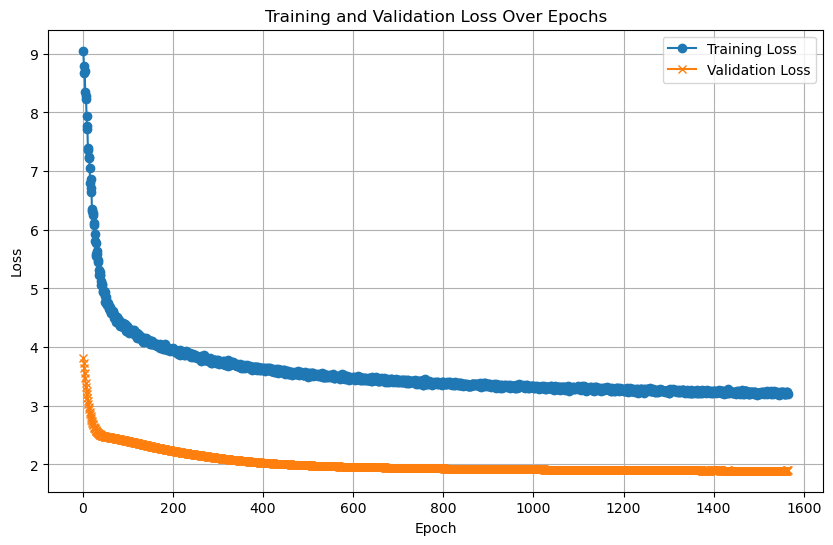

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/578], Loss: 4.6785
Test Batch [20/578], Loss: 4.3442
Test Batch [30/578], Loss: 4.4964
Test Batch [40/578], Loss: 4.4290
Test Batch [50/578], Loss: 4.4457
Test Batch [60/578], Loss: 4.3321
Test Batch [70/578], Loss: 4.1876
Test Batch [80/578], Loss: 4.7644
Test Batch [90/578], Loss: 5.1199
Test Batch [100/578], Loss: 4.2089
Test Batch [110/578], Loss: 4.4869
Test Batch [120/578], Loss: 4.2884
Test Batch [130/578], Loss: 4.3221
Test Batch [140/578], Loss: 4.2658
Test Batch [150/578], Loss: 4.3892


Test Batch [160/578], Loss: 4.4763
Test Batch [170/578], Loss: 4.5416
Test Batch [180/578], Loss: 4.3182
Test Batch [190/578], Loss: 4.4203
Test Batch [200/578], Loss: 4.3719
Test Batch [210/578], Loss: 4.5162
Test Batch [220/578], Loss: 4.5249
Test Batch [230/578], Loss: 4.3911
Test Batch [240/578], Loss: 4.4206
Test Batch [250/578], Loss: 4.4724
Test Batch [260/578], Loss: 4.3614
Test Batch [270/578], Loss: 4.4447
Test Batch [280/578], Loss: 4.4680
Test Batch [290/578], Loss: 4.4742


Test Batch [300/578], Loss: 4.5718
Test Batch [310/578], Loss: 4.7025
Test Batch [320/578], Loss: 4.8867
Test Batch [330/578], Loss: 4.9158
Test Batch [340/578], Loss: 4.9153
Test Batch [350/578], Loss: 5.0438
Test Batch [360/578], Loss: 5.0445
Test Batch [370/578], Loss: 5.0464
Test Batch [380/578], Loss: 4.0884
Test Batch [390/578], Loss: 4.8530
Test Batch [400/578], Loss: 5.1160
Test Batch [410/578], Loss: 5.3269
Test Batch [420/578], Loss: 4.8595
Test Batch [430/578], Loss: 4.7920
Test Batch [440/578], Loss: 4.8120


Test Batch [450/578], Loss: 4.8746
Test Batch [460/578], Loss: 5.1106
Test Batch [470/578], Loss: 4.8624
Test Batch [480/578], Loss: 4.2452
Test Batch [490/578], Loss: 5.3350
Test Batch [500/578], Loss: 5.0501
Test Batch [510/578], Loss: 5.0478
Test Batch [520/578], Loss: 5.1003
Test Batch [530/578], Loss: 6.7747
Test Batch [540/578], Loss: 4.6688
Test Batch [550/578], Loss: 4.2825
Test Batch [560/578], Loss: 4.1364
Test Batch [570/578], Loss: 4.2339

Test Loss: 4.6430


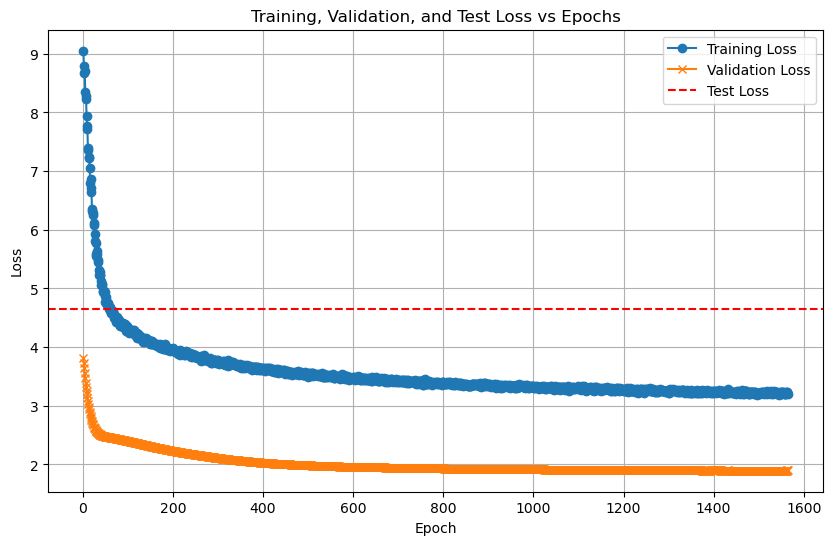

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/578 for test dataset.
  Processed batch 20/578 for test dataset.
  Processed batch 30/578 for test dataset.
  Processed batch 40/578 for test dataset.
  Processed batch 50/578 for test dataset.


  Processed batch 60/578 for test dataset.
  Processed batch 70/578 for test dataset.
  Processed batch 80/578 for test dataset.
  Processed batch 90/578 for test dataset.
  Processed batch 100/578 for test dataset.
  Processed batch 110/578 for test dataset.
  Processed batch 120/578 for test dataset.


  Processed batch 130/578 for test dataset.
  Processed batch 140/578 for test dataset.
  Processed batch 150/578 for test dataset.
  Processed batch 160/578 for test dataset.


  Processed batch 170/578 for test dataset.
  Processed batch 180/578 for test dataset.
  Processed batch 190/578 for test dataset.
  Processed batch 200/578 for test dataset.
  Processed batch 210/578 for test dataset.
  Processed batch 220/578 for test dataset.
  Processed batch 230/578 for test dataset.


  Processed batch 240/578 for test dataset.
  Processed batch 250/578 for test dataset.
  Processed batch 260/578 for test dataset.
  Processed batch 270/578 for test dataset.
  Processed batch 280/578 for test dataset.
  Processed batch 290/578 for test dataset.
  Processed batch 300/578 for test dataset.


  Processed batch 310/578 for test dataset.
  Processed batch 320/578 for test dataset.
  Processed batch 330/578 for test dataset.
  Processed batch 340/578 for test dataset.
  Processed batch 350/578 for test dataset.
  Processed batch 360/578 for test dataset.
  Processed batch 370/578 for test dataset.


  Processed batch 380/578 for test dataset.
  Processed batch 390/578 for test dataset.
  Processed batch 400/578 for test dataset.
  Processed batch 410/578 for test dataset.
  Processed batch 420/578 for test dataset.
  Processed batch 430/578 for test dataset.
  Processed batch 440/578 for test dataset.


  Processed batch 450/578 for test dataset.
  Processed batch 460/578 for test dataset.
  Processed batch 470/578 for test dataset.
  Processed batch 480/578 for test dataset.
  Processed batch 490/578 for test dataset.
  Processed batch 500/578 for test dataset.
  Processed batch 510/578 for test dataset.


  Processed batch 520/578 for test dataset.
  Processed batch 530/578 for test dataset.
  Processed batch 540/578 for test dataset.
  Processed batch 550/578 for test dataset.
  Processed batch 560/578 for test dataset.
  Processed batch 570/578 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 95.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.83      1.00      0.91         5
           2       1.00      0.80      0.89         5
           3       1.00      0.80      0.89         5
           4       0.83      1.00      0.91         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45


LOG: Evaluating on the test set...
Test Accuracy: 97.28%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.93      0.93      0.93      7553
           2       0.81      0.83      0.82      3045
           3       0.64      0.96      0.77      2640
           4       0.97      0.90      0.94      6539
           5       0.91      0.95      0.93      9203
           6       0.95      0.86      0.91      7242
           7       1.00      0.99      1.00     42781
           8       0.97      1.00      0.99      2818

    accuracy                           0.97    147747
   macro avg       0.91      0.94      0.92    147747
weighted avg       0.98      0.97      0.97    147747

Saved CAE+LRM predictions and true labels to model_predictions


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3004  |  Val Loss: 2.2631
Validation loss improved from inf to 2.2631.
[Epoch 2/1000] Train Loss: 2.2266  |  Val Loss: 2.1959
Validation loss improved from 2.2631 to 2.1959.
[Epoch 3/1000] Train Loss: 2.1590  |  Val Loss: 2.1325
Validation loss improved from 2.1959 to 2.1325.
[Epoch 4/1000] Train Loss: 2.0956  |  Val Loss: 2.0731
Validation loss improved from 2.1325 to 2.0731.
[Epoch 5/1000] Train Loss: 2.0338  |  Val Loss: 2.0156
Validation loss improved from 2.0731 to 2.0156.
[Epoch 6/1000] Train Loss: 1.9762  |  Val Loss: 1.9626
Validation loss improved from 2.0156 to 1.9626.
[Epoch 7/1000] Train Loss: 1.9240  |  Val Loss: 1.9131
Validation loss improved from 1.9626 to 1.9131.
[Epoch 8/1000] Train Loss: 1.8744  |  Val Loss: 1.8664
Validation loss improved from 1.9131 to 1.8664.
[Epoch 9/1000] Train Loss: 1.8268  |  Val Loss: 1.8219
Validation loss improved from 1.8664 to 1.8219.
[Epoch 10/1000] Train Loss: 1.7824  |  Val Loss: 1.7790
Validation loss impr

[Epoch 16/1000] Train Loss: 1.5514  |  Val Loss: 1.5577
Validation loss improved from 1.5907 to 1.5577.
[Epoch 17/1000] Train Loss: 1.5184  |  Val Loss: 1.5264
Validation loss improved from 1.5577 to 1.5264.
[Epoch 18/1000] Train Loss: 1.4866  |  Val Loss: 1.4961
Validation loss improved from 1.5264 to 1.4961.
[Epoch 19/1000] Train Loss: 1.4557  |  Val Loss: 1.4670
Validation loss improved from 1.4961 to 1.4670.


[Epoch 20/1000] Train Loss: 1.4260  |  Val Loss: 1.4385
Validation loss improved from 1.4670 to 1.4385.
[Epoch 21/1000] Train Loss: 1.3973  |  Val Loss: 1.4117
Validation loss improved from 1.4385 to 1.4117.
[Epoch 22/1000] Train Loss: 1.3704  |  Val Loss: 1.3849
Validation loss improved from 1.4117 to 1.3849.
[Epoch 23/1000] Train Loss: 1.3438  |  Val Loss: 1.3596
Validation loss improved from 1.3849 to 1.3596.
[Epoch 24/1000] Train Loss: 1.3188  |  Val Loss: 1.3354
Validation loss improved from 1.3596 to 1.3354.
[Epoch 25/1000] Train Loss: 1.2938  |  Val Loss: 1.3111
Validation loss improved from 1.3354 to 1.3111.
[Epoch 26/1000] Train Loss: 1.2693  |  Val Loss: 1.2860
Validation loss improved from 1.3111 to 1.2860.
[Epoch 27/1000] Train Loss: 1.2444  |  Val Loss: 1.2606
Validation loss improved from 1.2860 to 1.2606.
[Epoch 28/1000] Train Loss: 1.2189  |  Val Loss: 1.2359
Validation loss improved from 1.2606 to 1.2359.
[Epoch 29/1000] Train Loss: 1.1938  |  Val Loss: 1.2108
Validati

[Epoch 31/1000] Train Loss: 1.1448  |  Val Loss: 1.1612
Validation loss improved from 1.1855 to 1.1612.
[Epoch 32/1000] Train Loss: 1.1210  |  Val Loss: 1.1371
Validation loss improved from 1.1612 to 1.1371.
[Epoch 33/1000] Train Loss: 1.0970  |  Val Loss: 1.1136
Validation loss improved from 1.1371 to 1.1136.
[Epoch 34/1000] Train Loss: 1.0740  |  Val Loss: 1.0895
Validation loss improved from 1.1136 to 1.0895.


[Epoch 35/1000] Train Loss: 1.0502  |  Val Loss: 1.0666
Validation loss improved from 1.0895 to 1.0666.
[Epoch 36/1000] Train Loss: 1.0271  |  Val Loss: 1.0434
Validation loss improved from 1.0666 to 1.0434.
[Epoch 37/1000] Train Loss: 1.0044  |  Val Loss: 1.0211
Validation loss improved from 1.0434 to 1.0211.
[Epoch 38/1000] Train Loss: 0.9816  |  Val Loss: 0.9985
Validation loss improved from 1.0211 to 0.9985.
[Epoch 39/1000] Train Loss: 0.9592  |  Val Loss: 0.9763
Validation loss improved from 0.9985 to 0.9763.
[Epoch 40/1000] Train Loss: 0.9372  |  Val Loss: 0.9553
Validation loss improved from 0.9763 to 0.9553.
[Epoch 41/1000] Train Loss: 0.9154  |  Val Loss: 0.9338
Validation loss improved from 0.9553 to 0.9338.
[Epoch 42/1000] Train Loss: 0.8930  |  Val Loss: 0.9118
Validation loss improved from 0.9338 to 0.9118.
[Epoch 43/1000] Train Loss: 0.8715  |  Val Loss: 0.8882
Validation loss improved from 0.9118 to 0.8882.
[Epoch 44/1000] Train Loss: 0.8493  |  Val Loss: 0.8653
Validati

[Epoch 46/1000] Train Loss: 0.8053  |  Val Loss: 0.8207
Validation loss improved from 0.8428 to 0.8207.
[Epoch 47/1000] Train Loss: 0.7834  |  Val Loss: 0.7982
Validation loss improved from 0.8207 to 0.7982.
[Epoch 48/1000] Train Loss: 0.7614  |  Val Loss: 0.7764
Validation loss improved from 0.7982 to 0.7764.


[Epoch 49/1000] Train Loss: 0.7393  |  Val Loss: 0.7551
Validation loss improved from 0.7764 to 0.7551.
[Epoch 50/1000] Train Loss: 0.7176  |  Val Loss: 0.7337
Validation loss improved from 0.7551 to 0.7337.
[Epoch 51/1000] Train Loss: 0.6963  |  Val Loss: 0.7122
Validation loss improved from 0.7337 to 0.7122.
[Epoch 52/1000] Train Loss: 0.6750  |  Val Loss: 0.6906
Validation loss improved from 0.7122 to 0.6906.
[Epoch 53/1000] Train Loss: 0.6544  |  Val Loss: 0.6698
Validation loss improved from 0.6906 to 0.6698.
[Epoch 54/1000] Train Loss: 0.6344  |  Val Loss: 0.6495
Validation loss improved from 0.6698 to 0.6495.
[Epoch 55/1000] Train Loss: 0.6148  |  Val Loss: 0.6308
Validation loss improved from 0.6495 to 0.6308.
[Epoch 56/1000] Train Loss: 0.5958  |  Val Loss: 0.6137
Validation loss improved from 0.6308 to 0.6137.
[Epoch 57/1000] Train Loss: 0.5773  |  Val Loss: 0.5970
Validation loss improved from 0.6137 to 0.5970.
[Epoch 58/1000] Train Loss: 0.5595  |  Val Loss: 0.5811
Validati

[Epoch 63/1000] Train Loss: 0.4783  |  Val Loss: 0.5016
Validation loss improved from 0.5162 to 0.5016.
[Epoch 64/1000] Train Loss: 0.4637  |  Val Loss: 0.4886
Validation loss improved from 0.5016 to 0.4886.
[Epoch 65/1000] Train Loss: 0.4490  |  Val Loss: 0.4753
Validation loss improved from 0.4886 to 0.4753.
[Epoch 66/1000] Train Loss: 0.4351  |  Val Loss: 0.4619
Validation loss improved from 0.4753 to 0.4619.
[Epoch 67/1000] Train Loss: 0.4217  |  Val Loss: 0.4486
Validation loss improved from 0.4619 to 0.4486.
[Epoch 68/1000] Train Loss: 0.4084  |  Val Loss: 0.4365
Validation loss improved from 0.4486 to 0.4365.
[Epoch 69/1000] Train Loss: 0.3956  |  Val Loss: 0.4251
Validation loss improved from 0.4365 to 0.4251.
[Epoch 70/1000] Train Loss: 0.3831  |  Val Loss: 0.4125
Validation loss improved from 0.4251 to 0.4125.
[Epoch 71/1000] Train Loss: 0.3707  |  Val Loss: 0.4014
Validation loss improved from 0.4125 to 0.4014.
[Epoch 72/1000] Train Loss: 0.3590  |  Val Loss: 0.3908
Validati

[Epoch 79/1000] Train Loss: 0.2869  |  Val Loss: 0.3225
Validation loss improved from 0.3295 to 0.3225.
[Epoch 80/1000] Train Loss: 0.2781  |  Val Loss: 0.3141
Validation loss improved from 0.3225 to 0.3141.
[Epoch 81/1000] Train Loss: 0.2699  |  Val Loss: 0.3054
Validation loss improved from 0.3141 to 0.3054.
[Epoch 82/1000] Train Loss: 0.2614  |  Val Loss: 0.2999
Validation loss improved from 0.3054 to 0.2999.
[Epoch 83/1000] Train Loss: 0.2538  |  Val Loss: 0.2910
Validation loss improved from 0.2999 to 0.2910.
[Epoch 84/1000] Train Loss: 0.2462  |  Val Loss: 0.2846
Validation loss improved from 0.2910 to 0.2846.
[Epoch 85/1000] Train Loss: 0.2391  |  Val Loss: 0.2773
Validation loss improved from 0.2846 to 0.2773.
[Epoch 86/1000] Train Loss: 0.2323  |  Val Loss: 0.2689
Validation loss improved from 0.2773 to 0.2689.
[Epoch 87/1000] Train Loss: 0.2254  |  Val Loss: 0.2631
Validation loss improved from 0.2689 to 0.2631.
[Epoch 88/1000] Train Loss: 0.2193  |  Val Loss: 0.2584
Validati

[Epoch 95/1000] Train Loss: 0.1806  |  Val Loss: 0.2201
Validation loss improved from 0.2238 to 0.2201.
[Epoch 96/1000] Train Loss: 0.1761  |  Val Loss: 0.2176
Validation loss improved from 0.2201 to 0.2176.
[Epoch 97/1000] Train Loss: 0.1717  |  Val Loss: 0.2120
Validation loss improved from 0.2176 to 0.2120.
[Epoch 98/1000] Train Loss: 0.1676  |  Val Loss: 0.2070
Validation loss improved from 0.2120 to 0.2070.
[Epoch 99/1000] Train Loss: 0.1635  |  Val Loss: 0.2053
Validation loss improved from 0.2070 to 0.2053.
[Epoch 100/1000] Train Loss: 0.1597  |  Val Loss: 0.2017
Validation loss improved from 0.2053 to 0.2017.
[Epoch 101/1000] Train Loss: 0.1562  |  Val Loss: 0.1984
Validation loss improved from 0.2017 to 0.1984.
[Epoch 102/1000] Train Loss: 0.1527  |  Val Loss: 0.1938
Validation loss improved from 0.1984 to 0.1938.
[Epoch 103/1000] Train Loss: 0.1493  |  Val Loss: 0.1906
Validation loss improved from 0.1938 to 0.1906.
[Epoch 104/1000] Train Loss: 0.1461  |  Val Loss: 0.1904
Val

[Epoch 112/1000] Train Loss: 0.1249  |  Val Loss: 0.1697
Validation loss improved from 0.1732 to 0.1697.
[Epoch 113/1000] Train Loss: 0.1230  |  Val Loss: 0.1697
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 114/1000] Train Loss: 0.1206  |  Val Loss: 0.1670
Validation loss improved from 0.1697 to 0.1670.
[Epoch 115/1000] Train Loss: 0.1186  |  Val Loss: 0.1620
Validation loss improved from 0.1670 to 0.1620.
[Epoch 116/1000] Train Loss: 0.1165  |  Val Loss: 0.1624
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 117/1000] Train Loss: 0.1145  |  Val Loss: 0.1628
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 118/1000] Train Loss: 0.1127  |  Val Loss: 0.1598
Validation loss improved from 0.1620 to 0.1598.
[Epoch 119/1000] Train Loss: 0.1110  |  Val Loss: 0.1591
Validation loss improved from 0.1598 to 0.1591.
[Epoch 120/1000] Train Loss: 0.1095  |  Val Loss: 0.1546
Validation loss improved from 0.1591 to 0.1546.
[Epoch 121/1000] Train Loss: 0.1075  

[Epoch 127/1000] Train Loss: 0.0985  |  Val Loss: 0.1473
Validation loss improved from 0.1474 to 0.1473.
[Epoch 128/1000] Train Loss: 0.0972  |  Val Loss: 0.1471
Validation loss improved from 0.1473 to 0.1471.
[Epoch 129/1000] Train Loss: 0.0961  |  Val Loss: 0.1464
Validation loss improved from 0.1471 to 0.1464.
[Epoch 130/1000] Train Loss: 0.0948  |  Val Loss: 0.1447
Validation loss improved from 0.1464 to 0.1447.
[Epoch 131/1000] Train Loss: 0.0935  |  Val Loss: 0.1453
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 0.0923  |  Val Loss: 0.1437
Validation loss improved from 0.1447 to 0.1437.
[Epoch 133/1000] Train Loss: 0.0910  |  Val Loss: 0.1433
Validation loss improved from 0.1437 to 0.1433.
[Epoch 134/1000] Train Loss: 0.0899  |  Val Loss: 0.1443
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 135/1000] Train Loss: 0.0892  |  Val Loss: 0.1465
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 136/1000] Train Loss: 0.0878  

[Epoch 143/1000] Train Loss: 0.0815  |  Val Loss: 0.1355
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 144/1000] Train Loss: 0.0806  |  Val Loss: 0.1364
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 145/1000] Train Loss: 0.0798  |  Val Loss: 0.1367
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 146/1000] Train Loss: 0.0790  |  Val Loss: 0.1362
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 147/1000] Train Loss: 0.0784  |  Val Loss: 0.1364
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 148/1000] Train Loss: 0.0782  |  Val Loss: 0.1451
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 149/1000] Train Loss: 0.0771  |  Val Loss: 0.1458
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 150/1000] Train Loss: 0.0763  |  Val Loss: 0.1395
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 151/1000] Train Loss: 0.0753  |  Val Loss: 0.1354
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 159/1000] Train Loss: 0.0705  |  Val Loss: 0.1336
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 0.0700  |  Val Loss: 0.1334
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 0.0695  |  Val Loss: 0.1370
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 162/1000] Train Loss: 0.0690  |  Val Loss: 0.1353
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 163/1000] Train Loss: 0.0684  |  Val Loss: 0.1377
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 164/1000] Train Loss: 0.0682  |  Val Loss: 0.1391
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 165/1000] Train Loss: 0.0675  |  Val Loss: 0.1350
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 166/1000] Train Loss: 0.0673  |  Val Loss: 0.1318
Validation loss improved from 0.1323 to 0.1318.
[Epoch 167/1000] Train Loss: 0.0665  |  Val Loss: 0.1332
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 

[Epoch 175/1000] Train Loss: 0.0634  |  Val Loss: 0.1298
Validation loss improved from 0.1318 to 0.1298.
[Epoch 176/1000] Train Loss: 0.0631  |  Val Loss: 0.1343
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 177/1000] Train Loss: 0.0624  |  Val Loss: 0.1352
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 178/1000] Train Loss: 0.0623  |  Val Loss: 0.1310
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 179/1000] Train Loss: 0.0616  |  Val Loss: 0.1303
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 180/1000] Train Loss: 0.0612  |  Val Loss: 0.1307
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 181/1000] Train Loss: 0.0610  |  Val Loss: 0.1316
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 182/1000] Train Loss: 0.0608  |  Val Loss: 0.1367
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 183/1000] Train Loss: 0.0604  |  Val Loss: 0.1351
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 190/1000] Train Loss: 0.0585  |  Val Loss: 0.1364
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 191/1000] Train Loss: 0.0580  |  Val Loss: 0.1385
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 192/1000] Train Loss: 0.0577  |  Val Loss: 0.1348
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 193/1000] Train Loss: 0.0573  |  Val Loss: 0.1340
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 194/1000] Train Loss: 0.0571  |  Val Loss: 0.1358
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 195/1000] Train Loss: 0.0569  |  Val Loss: 0.1323
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 196/1000] Train Loss: 0.0566  |  Val Loss: 0.1318
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 197/1000] Train Loss: 0.0565  |  Val Loss: 0.1295
Validation loss improved from 0.1298 to 0.1295.
[Epoch 198/1000] Train Loss: 0.0561  |  Val Loss: 0.1361
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch

[Epoch 207/1000] Train Loss: 0.0538  |  Val Loss: 0.1373
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 208/1000] Train Loss: 0.0536  |  Val Loss: 0.1360
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 209/1000] Train Loss: 0.0534  |  Val Loss: 0.1352
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 210/1000] Train Loss: 0.0533  |  Val Loss: 0.1374
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 211/1000] Train Loss: 0.0530  |  Val Loss: 0.1385
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 212/1000] Train Loss: 0.0531  |  Val Loss: 0.1346
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 213/1000] Train Loss: 0.0528  |  Val Loss: 0.1385
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 214/1000] Train Loss: 0.0525  |  Val Loss: 0.1346
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 215/1000] Train Loss: 0.0522  |  Val Loss: 0.1342
!! Validation loss did NOT improve !! Patience:

[Epoch 224/1000] Train Loss: 0.0507  |  Val Loss: 0.1369
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 225/1000] Train Loss: 0.0504  |  Val Loss: 0.1368
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 226/1000] Train Loss: 0.0503  |  Val Loss: 0.1398
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 227/1000] Train Loss: 0.0501  |  Val Loss: 0.1432
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 228/1000] Train Loss: 0.0504  |  Val Loss: 0.1394
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 229/1000] Train Loss: 0.0501  |  Val Loss: 0.1459
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 230/1000] Train Loss: 0.0497  |  Val Loss: 0.1457
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 231/1000] Train Loss: 0.0495  |  Val Loss: 0.1427
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 232/1000] Train Loss: 0.0493  |  Val Loss: 0.1431
!! Validation loss did NOT improve !! Patience:

[Epoch 240/1000] Train Loss: 0.0483  |  Val Loss: 0.1370
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 241/1000] Train Loss: 0.0483  |  Val Loss: 0.1344
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 242/1000] Train Loss: 0.0479  |  Val Loss: 0.1381
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 243/1000] Train Loss: 0.0476  |  Val Loss: 0.1413
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 244/1000] Train Loss: 0.0476  |  Val Loss: 0.1407
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 245/1000] Train Loss: 0.0476  |  Val Loss: 0.1403
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 246/1000] Train Loss: 0.0478  |  Val Loss: 0.1435
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 247/1000] Train Loss: 0.0474  |  Val Loss: 0.1370
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 248/1000] Train Loss: 0.0471  |  Val Loss: 0.1348
!! Validation loss did NOT improve !! Patience:

[Epoch 256/1000] Train Loss: 0.0461  |  Val Loss: 0.1415
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 257/1000] Train Loss: 0.0459  |  Val Loss: 0.1399
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 258/1000] Train Loss: 0.0460  |  Val Loss: 0.1405
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 259/1000] Train Loss: 0.0459  |  Val Loss: 0.1430
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 260/1000] Train Loss: 0.0456  |  Val Loss: 0.1435
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 261/1000] Train Loss: 0.0456  |  Val Loss: 0.1421
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 262/1000] Train Loss: 0.0455  |  Val Loss: 0.1455
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 263/1000] Train Loss: 0.0460  |  Val Loss: 0.1482
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 264/1000] Train Loss: 0.0456  |  Val Loss: 0.1422
!! Validation loss did NOT improve !! Patience:

[Epoch 272/1000] Train Loss: 0.0445  |  Val Loss: 0.1420
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 273/1000] Train Loss: 0.0447  |  Val Loss: 0.1416
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 274/1000] Train Loss: 0.0446  |  Val Loss: 0.1489
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 275/1000] Train Loss: 0.0442  |  Val Loss: 0.1456
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 276/1000] Train Loss: 0.0442  |  Val Loss: 0.1427
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 277/1000] Train Loss: 0.0440  |  Val Loss: 0.1421
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 278/1000] Train Loss: 0.0441  |  Val Loss: 0.1404
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 279/1000] Train Loss: 0.0442  |  Val Loss: 0.1450
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 280/1000] Train Loss: 0.0438  |  Val Loss: 0.1485
!! Validation loss did NOT improve !! Patience:

[Epoch 288/1000] Train Loss: 0.0431  |  Val Loss: 0.1437
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 289/1000] Train Loss: 0.0435  |  Val Loss: 0.1414
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 290/1000] Train Loss: 0.0433  |  Val Loss: 0.1416
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 291/1000] Train Loss: 0.0428  |  Val Loss: 0.1438
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 292/1000] Train Loss: 0.0427  |  Val Loss: 0.1457
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 293/1000] Train Loss: 0.0426  |  Val Loss: 0.1468
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 294/1000] Train Loss: 0.0427  |  Val Loss: 0.1493
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 295/1000] Train Loss: 0.0428  |  Val Loss: 0.1472
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 296/1000] Train Loss: 0.0425  |  Val Loss: 0.1539
!! Validation loss did NOT improve !! Patience:

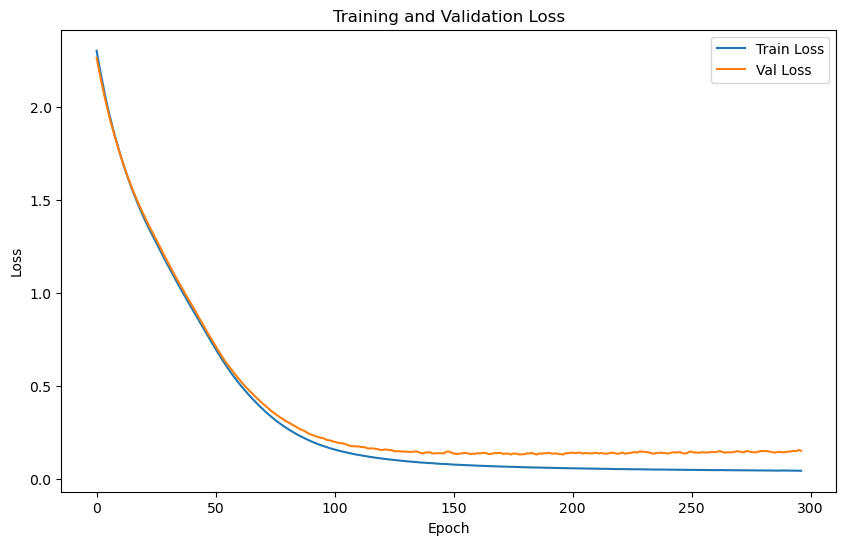

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.1258 | Test Accuracy: 97.09%


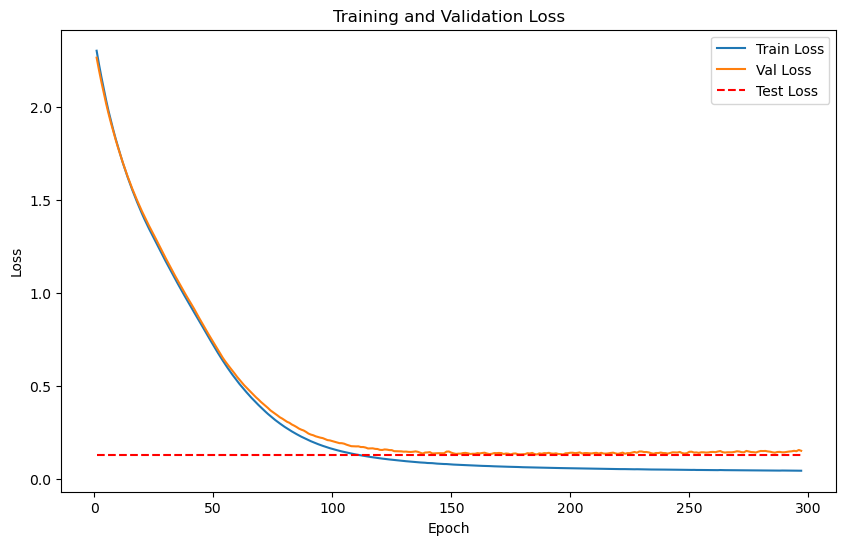

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 147747 samples with 64 features each
LOG: Labels shape: (147747,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (147747, 64), 
Test labels shape: (147747,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4473
    Batch [2/2], Train Loss: 0.4411
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.3605
Epoch [1/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.3605

Validation loss improved from inf to 0.3605. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/2], Train Loss: 0.4465
    Batch [2/2], Train Loss: 0.4513
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [2/2000], Avg Train Loss: 0.4489, Avg Val Loss: 0.3610

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 0.4447


    Batch [2/2], Train Loss: 0.4441
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.3645
Epoch [3/2000], Avg Train Loss: 0.4444, Avg Val Loss: 0.3645

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 0.4393
    Batch [2/2], Train Loss: 0.4400
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.3671
Epoch [4/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.3671

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 0.4352
    Batch [2/2], Train Loss: 0.4430
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.3672
Epoch [5/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3672

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/2], Train Loss: 0.4390
    Batch [2/2], Train Loss: 0.4391
LOG: Epoch [6/2000] - Validation
    Batch [1/1], Val Loss: 0.3658
Epoch [6/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.3658

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4335


    Batch [2/2], Train Loss: 0.4288
LOG: Epoch [7/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [7/2000], Avg Train Loss: 0.4311, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4325
    Batch [2/2], Train Loss: 0.4348
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.3650
Epoch [8/2000], Avg Train Loss: 0.4336, Avg Val Loss: 0.3650

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.4360
    Batch [2/2], Train Loss: 0.4322
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [9/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4236
    Batch [2/2], Train Loss: 0.4345
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [10/2000], Avg Train Loss: 0.4291, Avg Val Loss: 0.3652

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4200


    Batch [2/2], Train Loss: 0.4224
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.3651
Epoch [11/2000], Avg Train Loss: 0.4212, Avg Val Loss: 0.3651

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4292
    Batch [2/2], Train Loss: 0.4251
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.3644
Epoch [12/2000], Avg Train Loss: 0.4271, Avg Val Loss: 0.3644

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4211
    Batch [2/2], Train Loss: 0.4259
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [13/2000], Avg Train Loss: 0.4235, Avg Val Loss: 0.3635

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 0.4253


    Batch [2/2], Train Loss: 0.4253
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.3624
Epoch [14/2000], Avg Train Loss: 0.4253, Avg Val Loss: 0.3624

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4133
    Batch [2/2], Train Loss: 0.4222
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [15/2000], Avg Train Loss: 0.4178, Avg Val Loss: 0.3614

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [16/2000] - Training


    Batch [1/2], Train Loss: 0.4195
    Batch [2/2], Train Loss: 0.4191
LOG: Epoch [16/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [16/2000], Avg Train Loss: 0.4193, Avg Val Loss: 0.3600

Validation loss improved from 0.3605 to 0.3600. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4185


    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.3584
Epoch [17/2000], Avg Train Loss: 0.4159, Avg Val Loss: 0.3584

Validation loss improved from 0.3600 to 0.3584. Saving model...
LOG: Epoch [18/2000] - Training
    Batch [1/2], Train Loss: 0.4148
    Batch [2/2], Train Loss: 0.4157
LOG: Epoch [18/2000] - Validation


    Batch [1/1], Val Loss: 0.3566
Epoch [18/2000], Avg Train Loss: 0.4153, Avg Val Loss: 0.3566

Validation loss improved from 0.3584 to 0.3566. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4175
    Batch [2/2], Train Loss: 0.4137
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.3549
Epoch [19/2000], Avg Train Loss: 0.4156, Avg Val Loss: 0.3549

Validation loss improved from 0.3566 to 0.3549. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/2], Train Loss: 0.4097
    Batch [2/2], Train Loss: 0.4134
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [20/2000], Avg Train Loss: 0.4116, Avg Val Loss: 0.3531

Validation loss improved from 0.3549 to 0.3531. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 0.4091


    Batch [2/2], Train Loss: 0.4021
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [21/2000], Avg Train Loss: 0.4056, Avg Val Loss: 0.3513

Validation loss improved from 0.3531 to 0.3513. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4076
    Batch [2/2], Train Loss: 0.4087
LOG: Epoch [22/2000] - Validation


    Batch [1/1], Val Loss: 0.3494
Epoch [22/2000], Avg Train Loss: 0.4081, Avg Val Loss: 0.3494

Validation loss improved from 0.3513 to 0.3494. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4043
    Batch [2/2], Train Loss: 0.4103
LOG: Epoch [23/2000] - Validation
    Batch [1/1], Val Loss: 0.3476
Epoch [23/2000], Avg Train Loss: 0.4073, Avg Val Loss: 0.3476

Validation loss improved from 0.3494 to 0.3476. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/2], Train Loss: 0.4047
    Batch [2/2], Train Loss: 0.4025
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [24/2000], Avg Train Loss: 0.4036, Avg Val Loss: 0.3456

Validation loss improved from 0.3476 to 0.3456. Saving model...
LOG: Epoch [25/2000] - Training
    Batch [1/2], Train Loss: 0.4060


    Batch [2/2], Train Loss: 0.4077
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [25/2000], Avg Train Loss: 0.4069, Avg Val Loss: 0.3437

Validation loss improved from 0.3456 to 0.3437. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4025


    Batch [2/2], Train Loss: 0.3997
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [26/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3418

Validation loss improved from 0.3437 to 0.3418. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.3987
    Batch [2/2], Train Loss: 0.3904
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.3400
Epoch [27/2000], Avg Train Loss: 0.3945, Avg Val Loss: 0.3400

Validation loss improved from 0.3418 to 0.3400. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.3995
    Batch [2/2], Train Loss: 0.3985
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.3382
Epoch [28/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3382

Validation loss improved from 0.3400 to 0.3382. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.3891


    Batch [2/2], Train Loss: 0.3982
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.3363
Epoch [29/2000], Avg Train Loss: 0.3936, Avg Val Loss: 0.3363

Validation loss improved from 0.3382 to 0.3363. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4069
    Batch [2/2], Train Loss: 0.3881
LOG: Epoch [30/2000] - Validation
    Batch [1/1], Val Loss: 0.3344
Epoch [30/2000], Avg Train Loss: 0.3975, Avg Val Loss: 0.3344

Validation loss improved from 0.3363 to 0.3344. Saving model...
LOG: Epoch [31/2000] - Training


    Batch [1/2], Train Loss: 0.3919
    Batch [2/2], Train Loss: 0.3873
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [31/2000], Avg Train Loss: 0.3896, Avg Val Loss: 0.3326

Validation loss improved from 0.3344 to 0.3326. Saving model...
LOG: Epoch [32/2000] - Training
    Batch [1/2], Train Loss: 0.3903


    Batch [2/2], Train Loss: 0.3992
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.3308
Epoch [32/2000], Avg Train Loss: 0.3948, Avg Val Loss: 0.3308

Validation loss improved from 0.3326 to 0.3308. Saving model...
LOG: Epoch [33/2000] - Training
    Batch [1/2], Train Loss: 0.3793
    Batch [2/2], Train Loss: 0.3847
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.3291
Epoch [33/2000], Avg Train Loss: 0.3820, Avg Val Loss: 0.3291

Validation loss improved from 0.3308 to 0.3291. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/2], Train Loss: 0.3862
    Batch [2/2], Train Loss: 0.3894
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.3271
Epoch [34/2000], Avg Train Loss: 0.3878, Avg Val Loss: 0.3271

Validation loss improved from 0.3291 to 0.3271. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.3825


    Batch [2/2], Train Loss: 0.3804
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.3255
Epoch [35/2000], Avg Train Loss: 0.3815, Avg Val Loss: 0.3255

Validation loss improved from 0.3271 to 0.3255. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.3856
    Batch [2/2], Train Loss: 0.3809
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.3238
Epoch [36/2000], Avg Train Loss: 0.3832, Avg Val Loss: 0.3238

Validation loss improved from 0.3255 to 0.3238. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/2], Train Loss: 0.3814
    Batch [2/2], Train Loss: 0.3836
LOG: Epoch [37/2000] - Validation
    Batch [1/1], Val Loss: 0.3219
Epoch [37/2000], Avg Train Loss: 0.3825, Avg Val Loss: 0.3219

Validation loss improved from 0.3238 to 0.3219. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.3750


    Batch [2/2], Train Loss: 0.3756
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.3205
Epoch [38/2000], Avg Train Loss: 0.3753, Avg Val Loss: 0.3205

Validation loss improved from 0.3219 to 0.3205. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/2], Train Loss: 0.3819
    Batch [2/2], Train Loss: 0.3708
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.3190
Epoch [39/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3190

Validation loss improved from 0.3205 to 0.3190. Saving model...
LOG: Epoch [40/2000] - Training


    Batch [1/2], Train Loss: 0.3739
    Batch [2/2], Train Loss: 0.3789
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.3175
Epoch [40/2000], Avg Train Loss: 0.3764, Avg Val Loss: 0.3175

Validation loss improved from 0.3190 to 0.3175. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.3620


    Batch [2/2], Train Loss: 0.3746
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.3160
Epoch [41/2000], Avg Train Loss: 0.3683, Avg Val Loss: 0.3160

Validation loss improved from 0.3175 to 0.3160. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 0.3753
    Batch [2/2], Train Loss: 0.3768
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3144
Epoch [42/2000], Avg Train Loss: 0.3761, Avg Val Loss: 0.3144

Validation loss improved from 0.3160 to 0.3144. Saving model...
LOG: Epoch [43/2000] - Training


    Batch [1/2], Train Loss: 0.3807
    Batch [2/2], Train Loss: 0.3746
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3128
Epoch [43/2000], Avg Train Loss: 0.3777, Avg Val Loss: 0.3128

Validation loss improved from 0.3144 to 0.3128. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.3812


    Batch [2/2], Train Loss: 0.3756
LOG: Epoch [44/2000] - Validation
    Batch [1/1], Val Loss: 0.3112
Epoch [44/2000], Avg Train Loss: 0.3784, Avg Val Loss: 0.3112

Validation loss improved from 0.3128 to 0.3112. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.3679
    Batch [2/2], Train Loss: 0.3711
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3097
Epoch [45/2000], Avg Train Loss: 0.3695, Avg Val Loss: 0.3097

Validation loss improved from 0.3112 to 0.3097. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.3744
    Batch [2/2], Train Loss: 0.3663
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3080
Epoch [46/2000], Avg Train Loss: 0.3704, Avg Val Loss: 0.3080

Validation loss improved from 0.3097 to 0.3080. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.3700


    Batch [2/2], Train Loss: 0.3548
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3065
Epoch [47/2000], Avg Train Loss: 0.3624, Avg Val Loss: 0.3065

Validation loss improved from 0.3080 to 0.3065. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.3666
    Batch [2/2], Train Loss: 0.3668
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3051
Epoch [48/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3051

Validation loss improved from 0.3065 to 0.3051. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.3651
    Batch [2/2], Train Loss: 0.3659
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3038
Epoch [49/2000], Avg Train Loss: 0.3655, Avg Val Loss: 0.3038

Validation loss improved from 0.3051 to 0.3038. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.3612
    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3023
Epoch [50/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3023

Validation loss improved from 0.3038 to 0.3023. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.3683


    Batch [2/2], Train Loss: 0.3647
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3008
Epoch [51/2000], Avg Train Loss: 0.3665, Avg Val Loss: 0.3008

Validation loss improved from 0.3023 to 0.3008. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.3599
    Batch [2/2], Train Loss: 0.3613
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.2996
Epoch [52/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.2996

Validation loss improved from 0.3008 to 0.2996. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.3644
    Batch [2/2], Train Loss: 0.3638
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.2981
Epoch [53/2000], Avg Train Loss: 0.3641, Avg Val Loss: 0.2981

Validation loss improved from 0.2996 to 0.2981. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.3477
    Batch [2/2], Train Loss: 0.3574
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.2970
Epoch [54/2000], Avg Train Loss: 0.3525, Avg Val Loss: 0.2970

Validation loss improved from 0.2981 to 0.2970. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.3519


    Batch [2/2], Train Loss: 0.3588
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.2958
Epoch [55/2000], Avg Train Loss: 0.3554, Avg Val Loss: 0.2958

Validation loss improved from 0.2970 to 0.2958. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3545
    Batch [2/2], Train Loss: 0.3497
LOG: Epoch [56/2000] - Validation
    Batch [1/1], Val Loss: 0.2947
Epoch [56/2000], Avg Train Loss: 0.3521, Avg Val Loss: 0.2947

Validation loss improved from 0.2958 to 0.2947. Saving model...
LOG: Epoch [57/2000] - Training


    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3650
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.2936
Epoch [57/2000], Avg Train Loss: 0.3617, Avg Val Loss: 0.2936

Validation loss improved from 0.2947 to 0.2936. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/2], Train Loss: 0.3505


    Batch [2/2], Train Loss: 0.3491
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.2923
Epoch [58/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.2923

Validation loss improved from 0.2936 to 0.2923. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3558
    Batch [2/2], Train Loss: 0.3623
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.2908
Epoch [59/2000], Avg Train Loss: 0.3590, Avg Val Loss: 0.2908

Validation loss improved from 0.2923 to 0.2908. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/2], Train Loss: 0.3529
    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [60/2000] - Validation
    Batch [1/1], Val Loss: 0.2896
Epoch [60/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.2896

Validation loss improved from 0.2908 to 0.2896. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.3572


    Batch [2/2], Train Loss: 0.3489
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.2886
Epoch [61/2000], Avg Train Loss: 0.3530, Avg Val Loss: 0.2886

Validation loss improved from 0.2896 to 0.2886. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 0.3609
    Batch [2/2], Train Loss: 0.3430
LOG: Epoch [62/2000] - Validation


    Batch [1/1], Val Loss: 0.2875
Epoch [62/2000], Avg Train Loss: 0.3519, Avg Val Loss: 0.2875

Validation loss improved from 0.2886 to 0.2875. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3477
    Batch [2/2], Train Loss: 0.3432
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.2865
Epoch [63/2000], Avg Train Loss: 0.3455, Avg Val Loss: 0.2865

Validation loss improved from 0.2875 to 0.2865. Saving model...
LOG: Epoch [64/2000] - Training


    Batch [1/2], Train Loss: 0.3484
    Batch [2/2], Train Loss: 0.3415
LOG: Epoch [64/2000] - Validation
    Batch [1/1], Val Loss: 0.2852
Epoch [64/2000], Avg Train Loss: 0.3450, Avg Val Loss: 0.2852

Validation loss improved from 0.2865 to 0.2852. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3325


    Batch [2/2], Train Loss: 0.3322
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.2840
Epoch [65/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.2840

Validation loss improved from 0.2852 to 0.2840. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 0.3522
    Batch [2/2], Train Loss: 0.3400
LOG: Epoch [66/2000] - Validation


    Batch [1/1], Val Loss: 0.2830
Epoch [66/2000], Avg Train Loss: 0.3461, Avg Val Loss: 0.2830

Validation loss improved from 0.2840 to 0.2830. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.3385
    Batch [2/2], Train Loss: 0.3373
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.2819
Epoch [67/2000], Avg Train Loss: 0.3379, Avg Val Loss: 0.2819

Validation loss improved from 0.2830 to 0.2819. Saving model...
LOG: Epoch [68/2000] - Training


    Batch [1/2], Train Loss: 0.3355
    Batch [2/2], Train Loss: 0.3369
LOG: Epoch [68/2000] - Validation
    Batch [1/1], Val Loss: 0.2807
Epoch [68/2000], Avg Train Loss: 0.3362, Avg Val Loss: 0.2807

Validation loss improved from 0.2819 to 0.2807. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3462


    Batch [2/2], Train Loss: 0.3345
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.2797
Epoch [69/2000], Avg Train Loss: 0.3404, Avg Val Loss: 0.2797

Validation loss improved from 0.2807 to 0.2797. Saving model...
LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 0.3369
    Batch [2/2], Train Loss: 0.3397
LOG: Epoch [70/2000] - Validation


    Batch [1/1], Val Loss: 0.2787
Epoch [70/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.2787

Validation loss improved from 0.2797 to 0.2787. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.3350
    Batch [2/2], Train Loss: 0.3331
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.2777
Epoch [71/2000], Avg Train Loss: 0.3341, Avg Val Loss: 0.2777

Validation loss improved from 0.2787 to 0.2777. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/2], Train Loss: 0.3376
    Batch [2/2], Train Loss: 0.3409
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.2768
Epoch [72/2000], Avg Train Loss: 0.3392, Avg Val Loss: 0.2768

Validation loss improved from 0.2777 to 0.2768. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/2], Train Loss: 0.3223


    Batch [2/2], Train Loss: 0.3195
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.2759
Epoch [73/2000], Avg Train Loss: 0.3209, Avg Val Loss: 0.2759

Validation loss improved from 0.2768 to 0.2759. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3334
    Batch [2/2], Train Loss: 0.3276
LOG: Epoch [74/2000] - Validation


    Batch [1/1], Val Loss: 0.2749
Epoch [74/2000], Avg Train Loss: 0.3305, Avg Val Loss: 0.2749

Validation loss improved from 0.2759 to 0.2749. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3251
    Batch [2/2], Train Loss: 0.3344
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.2739
Epoch [75/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.2739

Validation loss improved from 0.2749 to 0.2739. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3317
    Batch [2/2], Train Loss: 0.3238
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.2728
Epoch [76/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2728

Validation loss improved from 0.2739 to 0.2728. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3381


    Batch [2/2], Train Loss: 0.3238
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.2719
Epoch [77/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.2719

Validation loss improved from 0.2728 to 0.2719. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3287
    Batch [2/2], Train Loss: 0.3360
LOG: Epoch [78/2000] - Validation


    Batch [1/1], Val Loss: 0.2710
Epoch [78/2000], Avg Train Loss: 0.3324, Avg Val Loss: 0.2710

Validation loss improved from 0.2719 to 0.2710. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 0.3292
    Batch [2/2], Train Loss: 0.3314
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.2700
Epoch [79/2000], Avg Train Loss: 0.3303, Avg Val Loss: 0.2700

Validation loss improved from 0.2710 to 0.2700. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/2], Train Loss: 0.3251
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.2690
Epoch [80/2000], Avg Train Loss: 0.3260, Avg Val Loss: 0.2690

Validation loss improved from 0.2700 to 0.2690. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3270


    Batch [2/2], Train Loss: 0.3286
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.2680
Epoch [81/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.2680

Validation loss improved from 0.2690 to 0.2680. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 0.3305
    Batch [2/2], Train Loss: 0.3235
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.2669
Epoch [82/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.2669

Validation loss improved from 0.2680 to 0.2669. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/2], Train Loss: 0.3109
    Batch [2/2], Train Loss: 0.3086
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.2661
Epoch [83/2000], Avg Train Loss: 0.3097, Avg Val Loss: 0.2661

Validation loss improved from 0.2669 to 0.2661. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.3253


    Batch [2/2], Train Loss: 0.3130
LOG: Epoch [84/2000] - Validation
    Batch [1/1], Val Loss: 0.2653
Epoch [84/2000], Avg Train Loss: 0.3192, Avg Val Loss: 0.2653

Validation loss improved from 0.2661 to 0.2653. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3200
    Batch [2/2], Train Loss: 0.3144
LOG: Epoch [85/2000] - Validation


    Batch [1/1], Val Loss: 0.2643
Epoch [85/2000], Avg Train Loss: 0.3172, Avg Val Loss: 0.2643

Validation loss improved from 0.2653 to 0.2643. Saving model...
LOG: Epoch [86/2000] - Training
    Batch [1/2], Train Loss: 0.3256
    Batch [2/2], Train Loss: 0.3217
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.2631
Epoch [86/2000], Avg Train Loss: 0.3236, Avg Val Loss: 0.2631

Validation loss improved from 0.2643 to 0.2631. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/2], Train Loss: 0.3201
    Batch [2/2], Train Loss: 0.3299
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.2622
Epoch [87/2000], Avg Train Loss: 0.3250, Avg Val Loss: 0.2622

Validation loss improved from 0.2631 to 0.2622. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3158


    Batch [2/2], Train Loss: 0.3044
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.2613
Epoch [88/2000], Avg Train Loss: 0.3101, Avg Val Loss: 0.2613

Validation loss improved from 0.2622 to 0.2613. Saving model...
LOG: Epoch [89/2000] - Training
    Batch [1/2], Train Loss: 0.3187
    Batch [2/2], Train Loss: 0.3190
LOG: Epoch [89/2000] - Validation


    Batch [1/1], Val Loss: 0.2603
Epoch [89/2000], Avg Train Loss: 0.3188, Avg Val Loss: 0.2603

Validation loss improved from 0.2613 to 0.2603. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3136
    Batch [2/2], Train Loss: 0.3128
LOG: Epoch [90/2000] - Validation


    Batch [1/1], Val Loss: 0.2593
Epoch [90/2000], Avg Train Loss: 0.3132, Avg Val Loss: 0.2593

Validation loss improved from 0.2603 to 0.2593. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3168
    Batch [2/2], Train Loss: 0.3211
LOG: Epoch [91/2000] - Validation
    Batch [1/1], Val Loss: 0.2585
Epoch [91/2000], Avg Train Loss: 0.3190, Avg Val Loss: 0.2585

Validation loss improved from 0.2593 to 0.2585. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/2], Train Loss: 0.3093
    Batch [2/2], Train Loss: 0.3107
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.2577
Epoch [92/2000], Avg Train Loss: 0.3100, Avg Val Loss: 0.2577

Validation loss improved from 0.2585 to 0.2577. Saving model...
LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 0.3127


    Batch [2/2], Train Loss: 0.3040
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.2569
Epoch [93/2000], Avg Train Loss: 0.3084, Avg Val Loss: 0.2569

Validation loss improved from 0.2577 to 0.2569. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3002
    Batch [2/2], Train Loss: 0.3208
LOG: Epoch [94/2000] - Validation


    Batch [1/1], Val Loss: 0.2560
Epoch [94/2000], Avg Train Loss: 0.3105, Avg Val Loss: 0.2560

Validation loss improved from 0.2569 to 0.2560. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.3153
    Batch [2/2], Train Loss: 0.2942
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.2550
Epoch [95/2000], Avg Train Loss: 0.3048, Avg Val Loss: 0.2550

Validation loss improved from 0.2560 to 0.2550. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3090
    Batch [2/2], Train Loss: 0.3054
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.2543
Epoch [96/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.2543

Validation loss improved from 0.2550 to 0.2543. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.2976


    Batch [2/2], Train Loss: 0.3077
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.2537
Epoch [97/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.2537

Validation loss improved from 0.2543 to 0.2537. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3069


    Batch [2/2], Train Loss: 0.3014
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.2530
Epoch [98/2000], Avg Train Loss: 0.3041, Avg Val Loss: 0.2530

Validation loss improved from 0.2537 to 0.2530. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.3014


    Batch [2/2], Train Loss: 0.2934
LOG: Epoch [99/2000] - Validation
    Batch [1/1], Val Loss: 0.2523
Epoch [99/2000], Avg Train Loss: 0.2974, Avg Val Loss: 0.2523

Validation loss improved from 0.2530 to 0.2523. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.2981
    Batch [2/2], Train Loss: 0.3100
LOG: Epoch [100/2000] - Validation


    Batch [1/1], Val Loss: 0.2517
Epoch [100/2000], Avg Train Loss: 0.3040, Avg Val Loss: 0.2517

Validation loss improved from 0.2523 to 0.2517. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/2], Train Loss: 0.3098
    Batch [2/2], Train Loss: 0.3010
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.2510
Epoch [101/2000], Avg Train Loss: 0.3054, Avg Val Loss: 0.2510

Validation loss improved from 0.2517 to 0.2510. Saving model...
LOG: Epoch [102/2000] - Training


    Batch [1/2], Train Loss: 0.3102
    Batch [2/2], Train Loss: 0.3003
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.2503
Epoch [102/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.2503

Validation loss improved from 0.2510 to 0.2503. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3117


    Batch [2/2], Train Loss: 0.3081
LOG: Epoch [103/2000] - Validation
    Batch [1/1], Val Loss: 0.2495
Epoch [103/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.2495

Validation loss improved from 0.2503 to 0.2495. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.2909
    Batch [2/2], Train Loss: 0.2967
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.2490
Epoch [104/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.2490

Validation loss improved from 0.2495 to 0.2490. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.2870
    Batch [2/2], Train Loss: 0.2939
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.2483
Epoch [105/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2483

Validation loss improved from 0.2490 to 0.2483. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.2969


    Batch [2/2], Train Loss: 0.2897
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.2477
Epoch [106/2000], Avg Train Loss: 0.2933, Avg Val Loss: 0.2477

Validation loss improved from 0.2483 to 0.2477. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3010
    Batch [2/2], Train Loss: 0.2911
LOG: Epoch [107/2000] - Validation


    Batch [1/1], Val Loss: 0.2470
Epoch [107/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.2470

Validation loss improved from 0.2477 to 0.2470. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 0.3014
    Batch [2/2], Train Loss: 0.2986
LOG: Epoch [108/2000] - Validation


    Batch [1/1], Val Loss: 0.2464
Epoch [108/2000], Avg Train Loss: 0.3000, Avg Val Loss: 0.2464

Validation loss improved from 0.2470 to 0.2464. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.2889
    Batch [2/2], Train Loss: 0.3007
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.2457
Epoch [109/2000], Avg Train Loss: 0.2948, Avg Val Loss: 0.2457

Validation loss improved from 0.2464 to 0.2457. Saving model...
LOG: Epoch [110/2000] - Training


    Batch [1/2], Train Loss: 0.2971
    Batch [2/2], Train Loss: 0.2837
LOG: Epoch [110/2000] - Validation
    Batch [1/1], Val Loss: 0.2451
Epoch [110/2000], Avg Train Loss: 0.2904, Avg Val Loss: 0.2451

Validation loss improved from 0.2457 to 0.2451. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.2893


    Batch [2/2], Train Loss: 0.2920
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.2442
Epoch [111/2000], Avg Train Loss: 0.2906, Avg Val Loss: 0.2442

Validation loss improved from 0.2451 to 0.2442. Saving model...
LOG: Epoch [112/2000] - Training
    Batch [1/2], Train Loss: 0.3012
    Batch [2/2], Train Loss: 0.3014
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.2438
Epoch [112/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.2438

Validation loss improved from 0.2442 to 0.2438. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/2], Train Loss: 0.2931
    Batch [2/2], Train Loss: 0.2815
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.2432
Epoch [113/2000], Avg Train Loss: 0.2873, Avg Val Loss: 0.2432

Validation loss improved from 0.2438 to 0.2432. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.2933


    Batch [2/2], Train Loss: 0.2937
LOG: Epoch [114/2000] - Validation
    Batch [1/1], Val Loss: 0.2426
Epoch [114/2000], Avg Train Loss: 0.2935, Avg Val Loss: 0.2426

Validation loss improved from 0.2432 to 0.2426. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.2890
    Batch [2/2], Train Loss: 0.2939
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.2418
Epoch [115/2000], Avg Train Loss: 0.2915, Avg Val Loss: 0.2418

Validation loss improved from 0.2426 to 0.2418. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.2762
    Batch [2/2], Train Loss: 0.2886
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.2411
Epoch [116/2000], Avg Train Loss: 0.2824, Avg Val Loss: 0.2411

Validation loss improved from 0.2418 to 0.2411. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.2981


    Batch [2/2], Train Loss: 0.2853
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.2407
Epoch [117/2000], Avg Train Loss: 0.2917, Avg Val Loss: 0.2407

Validation loss improved from 0.2411 to 0.2407. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.2889
    Batch [2/2], Train Loss: 0.2879
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.2399
Epoch [118/2000], Avg Train Loss: 0.2884, Avg Val Loss: 0.2399

Validation loss improved from 0.2407 to 0.2399. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.2810
    Batch [2/2], Train Loss: 0.2807
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.2394
Epoch [119/2000], Avg Train Loss: 0.2808, Avg Val Loss: 0.2394

Validation loss improved from 0.2399 to 0.2394. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.2809


    Batch [2/2], Train Loss: 0.2930
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.2388
Epoch [120/2000], Avg Train Loss: 0.2869, Avg Val Loss: 0.2388

Validation loss improved from 0.2394 to 0.2388. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.2882
    Batch [2/2], Train Loss: 0.2832
LOG: Epoch [121/2000] - Validation


    Batch [1/1], Val Loss: 0.2381
Epoch [121/2000], Avg Train Loss: 0.2857, Avg Val Loss: 0.2381

Validation loss improved from 0.2388 to 0.2381. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 0.2886
    Batch [2/2], Train Loss: 0.2904
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.2375
Epoch [122/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.2375

Validation loss improved from 0.2381 to 0.2375. Saving model...
LOG: Epoch [123/2000] - Training


    Batch [1/2], Train Loss: 0.2876
    Batch [2/2], Train Loss: 0.2784
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.2369
Epoch [123/2000], Avg Train Loss: 0.2830, Avg Val Loss: 0.2369

Validation loss improved from 0.2375 to 0.2369. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.2825


    Batch [2/2], Train Loss: 0.2763
LOG: Epoch [124/2000] - Validation
    Batch [1/1], Val Loss: 0.2361
Epoch [124/2000], Avg Train Loss: 0.2794, Avg Val Loss: 0.2361

Validation loss improved from 0.2369 to 0.2361. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.2763
    Batch [2/2], Train Loss: 0.2876
LOG: Epoch [125/2000] - Validation


    Batch [1/1], Val Loss: 0.2354
Epoch [125/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.2354

Validation loss improved from 0.2361 to 0.2354. Saving model...
LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 0.2807
    Batch [2/2], Train Loss: 0.2949
LOG: Epoch [126/2000] - Validation


    Batch [1/1], Val Loss: 0.2347
Epoch [126/2000], Avg Train Loss: 0.2878, Avg Val Loss: 0.2347

Validation loss improved from 0.2354 to 0.2347. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.2910
    Batch [2/2], Train Loss: 0.2788
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.2340
Epoch [127/2000], Avg Train Loss: 0.2849, Avg Val Loss: 0.2340

Validation loss improved from 0.2347 to 0.2340. Saving model...
LOG: Epoch [128/2000] - Training


    Batch [1/2], Train Loss: 0.2845
    Batch [2/2], Train Loss: 0.2797
LOG: Epoch [128/2000] - Validation
    Batch [1/1], Val Loss: 0.2333
Epoch [128/2000], Avg Train Loss: 0.2821, Avg Val Loss: 0.2333

Validation loss improved from 0.2340 to 0.2333. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.2783


    Batch [2/2], Train Loss: 0.2918
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.2326
Epoch [129/2000], Avg Train Loss: 0.2850, Avg Val Loss: 0.2326

Validation loss improved from 0.2333 to 0.2326. Saving model...
LOG: Epoch [130/2000] - Training
    Batch [1/2], Train Loss: 0.2749
    Batch [2/2], Train Loss: 0.2699
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.2319
Epoch [130/2000], Avg Train Loss: 0.2724, Avg Val Loss: 0.2319

Validation loss improved from 0.2326 to 0.2319. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/2], Train Loss: 0.2598
    Batch [2/2], Train Loss: 0.2514
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.2313
Epoch [131/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.2313

Validation loss improved from 0.2319 to 0.2313. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.2611


    Batch [2/2], Train Loss: 0.2835
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.2308
Epoch [132/2000], Avg Train Loss: 0.2723, Avg Val Loss: 0.2308

Validation loss improved from 0.2313 to 0.2308. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 0.2641
    Batch [2/2], Train Loss: 0.2744
LOG: Epoch [133/2000] - Validation


    Batch [1/1], Val Loss: 0.2302
Epoch [133/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.2302

Validation loss improved from 0.2308 to 0.2302. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.2640
    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.2296
Epoch [134/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.2296

Validation loss improved from 0.2302 to 0.2296. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 0.2664
    Batch [2/2], Train Loss: 0.2680
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.2290
Epoch [135/2000], Avg Train Loss: 0.2672, Avg Val Loss: 0.2290

Validation loss improved from 0.2296 to 0.2290. Saving model...
LOG: Epoch [136/2000] - Training
    Batch [1/2], Train Loss: 0.2775


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.2285
Epoch [136/2000], Avg Train Loss: 0.2708, Avg Val Loss: 0.2285

Validation loss improved from 0.2290 to 0.2285. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.2884
    Batch [2/2], Train Loss: 0.2750
LOG: Epoch [137/2000] - Validation


    Batch [1/1], Val Loss: 0.2281
Epoch [137/2000], Avg Train Loss: 0.2817, Avg Val Loss: 0.2281

Validation loss improved from 0.2285 to 0.2281. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.2808
    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.2278
Epoch [138/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.2278

Validation loss improved from 0.2281 to 0.2278. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.2663
    Batch [2/2], Train Loss: 0.2758
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.2273
Epoch [139/2000], Avg Train Loss: 0.2711, Avg Val Loss: 0.2273

Validation loss improved from 0.2278 to 0.2273. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/2], Train Loss: 0.2796
    Batch [2/2], Train Loss: 0.2705
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.2267
Epoch [140/2000], Avg Train Loss: 0.2750, Avg Val Loss: 0.2267

Validation loss improved from 0.2273 to 0.2267. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.2613


    Batch [2/2], Train Loss: 0.2587
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.2262
Epoch [141/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.2262

Validation loss improved from 0.2267 to 0.2262. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 0.2680
    Batch [2/2], Train Loss: 0.2719
LOG: Epoch [142/2000] - Validation


    Batch [1/1], Val Loss: 0.2257
Epoch [142/2000], Avg Train Loss: 0.2699, Avg Val Loss: 0.2257

Validation loss improved from 0.2262 to 0.2257. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.2706
    Batch [2/2], Train Loss: 0.2612
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.2251
Epoch [143/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2251

Validation loss improved from 0.2257 to 0.2251. Saving model...
LOG: Epoch [144/2000] - Training


    Batch [1/2], Train Loss: 0.2583
    Batch [2/2], Train Loss: 0.2658
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.2244
Epoch [144/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2244

Validation loss improved from 0.2251 to 0.2244. Saving model...
LOG: Epoch [145/2000] - Training
    Batch [1/2], Train Loss: 0.2678


    Batch [2/2], Train Loss: 0.2578
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.2237
Epoch [145/2000], Avg Train Loss: 0.2628, Avg Val Loss: 0.2237

Validation loss improved from 0.2244 to 0.2237. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.2754


    Batch [2/2], Train Loss: 0.2658
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.2231
Epoch [146/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.2231

Validation loss improved from 0.2237 to 0.2231. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.2635
    Batch [2/2], Train Loss: 0.2684
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.2225
Epoch [147/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.2225

Validation loss improved from 0.2231 to 0.2225. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/2], Train Loss: 0.2674
    Batch [2/2], Train Loss: 0.2778
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.2220
Epoch [148/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.2220

Validation loss improved from 0.2225 to 0.2220. Saving model...
LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 0.2678


    Batch [2/2], Train Loss: 0.2528
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.2214
Epoch [149/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.2214

Validation loss improved from 0.2220 to 0.2214. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.2471


    Batch [2/2], Train Loss: 0.2490
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.2210
Epoch [150/2000], Avg Train Loss: 0.2480, Avg Val Loss: 0.2210

Validation loss improved from 0.2214 to 0.2210. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.2667
    Batch [2/2], Train Loss: 0.2583
LOG: Epoch [151/2000] - Validation
    Batch [1/1], Val Loss: 0.2203
Epoch [151/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2203

Validation loss improved from 0.2210 to 0.2203. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/2], Train Loss: 0.2638
    Batch [2/2], Train Loss: 0.2733
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.2199
Epoch [152/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.2199

Validation loss improved from 0.2203 to 0.2199. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 0.2540


    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.2195
Epoch [153/2000], Avg Train Loss: 0.2604, Avg Val Loss: 0.2195

Validation loss improved from 0.2199 to 0.2195. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 0.2610
    Batch [2/2], Train Loss: 0.2485
LOG: Epoch [154/2000] - Validation


    Batch [1/1], Val Loss: 0.2191
Epoch [154/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2191

Validation loss improved from 0.2195 to 0.2191. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.2529
    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.2185
Epoch [155/2000], Avg Train Loss: 0.2625, Avg Val Loss: 0.2185

Validation loss improved from 0.2191 to 0.2185. Saving model...
LOG: Epoch [156/2000] - Training


    Batch [1/2], Train Loss: 0.2571
    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [156/2000] - Validation
    Batch [1/1], Val Loss: 0.2180
Epoch [156/2000], Avg Train Loss: 0.2511, Avg Val Loss: 0.2180

Validation loss improved from 0.2185 to 0.2180. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.2680


    Batch [2/2], Train Loss: 0.2560
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.2175
Epoch [157/2000], Avg Train Loss: 0.2620, Avg Val Loss: 0.2175

Validation loss improved from 0.2180 to 0.2175. Saving model...
LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 0.2586
    Batch [2/2], Train Loss: 0.2539
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.2171
Epoch [158/2000], Avg Train Loss: 0.2563, Avg Val Loss: 0.2171

Validation loss improved from 0.2175 to 0.2171. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/2], Train Loss: 0.2538
    Batch [2/2], Train Loss: 0.2558
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.2167
Epoch [159/2000], Avg Train Loss: 0.2548, Avg Val Loss: 0.2167

Validation loss improved from 0.2171 to 0.2167. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.2528


    Batch [2/2], Train Loss: 0.2504
LOG: Epoch [160/2000] - Validation
    Batch [1/1], Val Loss: 0.2163
Epoch [160/2000], Avg Train Loss: 0.2516, Avg Val Loss: 0.2163

Validation loss improved from 0.2167 to 0.2163. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.2400
    Batch [2/2], Train Loss: 0.2473
LOG: Epoch [161/2000] - Validation


    Batch [1/1], Val Loss: 0.2159
Epoch [161/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2159

Validation loss improved from 0.2163 to 0.2159. Saving model...
LOG: Epoch [162/2000] - Training
    Batch [1/2], Train Loss: 0.2541
    Batch [2/2], Train Loss: 0.2595
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.2157
Epoch [162/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.2157

Validation loss improved from 0.2159 to 0.2157. Saving model...
LOG: Epoch [163/2000] - Training


    Batch [1/2], Train Loss: 0.2645
    Batch [2/2], Train Loss: 0.2572
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.2154
Epoch [163/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.2154

Validation loss improved from 0.2157 to 0.2154. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.2394


    Batch [2/2], Train Loss: 0.2394
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.2152
Epoch [164/2000], Avg Train Loss: 0.2394, Avg Val Loss: 0.2152

Validation loss improved from 0.2154 to 0.2152. Saving model...
LOG: Epoch [165/2000] - Training
    Batch [1/2], Train Loss: 0.2365
    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [165/2000] - Validation


    Batch [1/1], Val Loss: 0.2149
Epoch [165/2000], Avg Train Loss: 0.2432, Avg Val Loss: 0.2149

Validation loss improved from 0.2152 to 0.2149. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.2335
    Batch [2/2], Train Loss: 0.2565
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.2147
Epoch [166/2000], Avg Train Loss: 0.2450, Avg Val Loss: 0.2147

Validation loss improved from 0.2149 to 0.2147. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/2], Train Loss: 0.2501
    Batch [2/2], Train Loss: 0.2493
LOG: Epoch [167/2000] - Validation
    Batch [1/1], Val Loss: 0.2142
Epoch [167/2000], Avg Train Loss: 0.2497, Avg Val Loss: 0.2142

Validation loss improved from 0.2147 to 0.2142. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.2567


    Batch [2/2], Train Loss: 0.2421
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.2138
Epoch [168/2000], Avg Train Loss: 0.2494, Avg Val Loss: 0.2138

Validation loss improved from 0.2142 to 0.2138. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 0.2395
    Batch [2/2], Train Loss: 0.2357
LOG: Epoch [169/2000] - Validation


    Batch [1/1], Val Loss: 0.2134
Epoch [169/2000], Avg Train Loss: 0.2376, Avg Val Loss: 0.2134

Validation loss improved from 0.2138 to 0.2134. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.2510
    Batch [2/2], Train Loss: 0.2510
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.2129
Epoch [170/2000], Avg Train Loss: 0.2510, Avg Val Loss: 0.2129

Validation loss improved from 0.2134 to 0.2129. Saving model...
LOG: Epoch [171/2000] - Training


    Batch [1/2], Train Loss: 0.2521
    Batch [2/2], Train Loss: 0.2412
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.2126
Epoch [171/2000], Avg Train Loss: 0.2466, Avg Val Loss: 0.2126

Validation loss improved from 0.2129 to 0.2126. Saving model...
LOG: Epoch [172/2000] - Training
    Batch [1/2], Train Loss: 0.2442


    Batch [2/2], Train Loss: 0.2475
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.2122
Epoch [172/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2122

Validation loss improved from 0.2126 to 0.2122. Saving model...
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.2376
    Batch [2/2], Train Loss: 0.2490
LOG: Epoch [173/2000] - Validation


    Batch [1/1], Val Loss: 0.2118
Epoch [173/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.2118

Validation loss improved from 0.2122 to 0.2118. Saving model...
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.2378
    Batch [2/2], Train Loss: 0.2460
LOG: Epoch [174/2000] - Validation
    Batch [1/1], Val Loss: 0.2115
Epoch [174/2000], Avg Train Loss: 0.2419, Avg Val Loss: 0.2115

Validation loss improved from 0.2118 to 0.2115. Saving model...
LOG: Epoch [175/2000] - Training


    Batch [1/2], Train Loss: 0.2329
    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.2111
Epoch [175/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.2111

Validation loss improved from 0.2115 to 0.2111. Saving model...
LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 0.2410


    Batch [2/2], Train Loss: 0.2343
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.2107
Epoch [176/2000], Avg Train Loss: 0.2377, Avg Val Loss: 0.2107

Validation loss improved from 0.2111 to 0.2107. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.2465
    Batch [2/2], Train Loss: 0.2471
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.2103
Epoch [177/2000], Avg Train Loss: 0.2468, Avg Val Loss: 0.2103

Validation loss improved from 0.2107 to 0.2103. Saving model...
LOG: Epoch [178/2000] - Training


    Batch [1/2], Train Loss: 0.2449
    Batch [2/2], Train Loss: 0.2416
LOG: Epoch [178/2000] - Validation
    Batch [1/1], Val Loss: 0.2099
Epoch [178/2000], Avg Train Loss: 0.2433, Avg Val Loss: 0.2099

Validation loss improved from 0.2103 to 0.2099. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.2577


    Batch [2/2], Train Loss: 0.2371
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.2095
Epoch [179/2000], Avg Train Loss: 0.2474, Avg Val Loss: 0.2095

Validation loss improved from 0.2099 to 0.2095. Saving model...
LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 0.2299
    Batch [2/2], Train Loss: 0.2462
LOG: Epoch [180/2000] - Validation


    Batch [1/1], Val Loss: 0.2092
Epoch [180/2000], Avg Train Loss: 0.2381, Avg Val Loss: 0.2092

Validation loss improved from 0.2095 to 0.2092. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.2396
    Batch [2/2], Train Loss: 0.2459
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.2089
Epoch [181/2000], Avg Train Loss: 0.2428, Avg Val Loss: 0.2089

Validation loss improved from 0.2092 to 0.2089. Saving model...
LOG: Epoch [182/2000] - Training


    Batch [1/2], Train Loss: 0.2542
    Batch [2/2], Train Loss: 0.2261
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.2088
Epoch [182/2000], Avg Train Loss: 0.2402, Avg Val Loss: 0.2088

Validation loss improved from 0.2089 to 0.2088. Saving model...
LOG: Epoch [183/2000] - Training
    Batch [1/2], Train Loss: 0.2304


    Batch [2/2], Train Loss: 0.2370
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.2086
Epoch [183/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.2086

Validation loss improved from 0.2088 to 0.2086. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.2393
    Batch [2/2], Train Loss: 0.2376
LOG: Epoch [184/2000] - Validation


    Batch [1/1], Val Loss: 0.2082
Epoch [184/2000], Avg Train Loss: 0.2385, Avg Val Loss: 0.2082

Validation loss improved from 0.2086 to 0.2082. Saving model...
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.2355
    Batch [2/2], Train Loss: 0.2432
LOG: Epoch [185/2000] - Validation


    Batch [1/1], Val Loss: 0.2080
Epoch [185/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.2080

Validation loss improved from 0.2082 to 0.2080. Saving model...
LOG: Epoch [186/2000] - Training
    Batch [1/2], Train Loss: 0.2424
    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.2078
Epoch [186/2000], Avg Train Loss: 0.2407, Avg Val Loss: 0.2078

Validation loss improved from 0.2080 to 0.2078. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.2395
    Batch [2/2], Train Loss: 0.2316
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.2076
Epoch [187/2000], Avg Train Loss: 0.2355, Avg Val Loss: 0.2076

Validation loss improved from 0.2078 to 0.2076. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.2389


    Batch [2/2], Train Loss: 0.2397
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.2075
Epoch [188/2000], Avg Train Loss: 0.2393, Avg Val Loss: 0.2075

Validation loss improved from 0.2076 to 0.2075. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.2405
    Batch [2/2], Train Loss: 0.2440
LOG: Epoch [189/2000] - Validation


    Batch [1/1], Val Loss: 0.2073
Epoch [189/2000], Avg Train Loss: 0.2422, Avg Val Loss: 0.2073

Validation loss improved from 0.2075 to 0.2073. Saving model...
LOG: Epoch [190/2000] - Training
    Batch [1/2], Train Loss: 0.2484
    Batch [2/2], Train Loss: 0.2389
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.2070
Epoch [190/2000], Avg Train Loss: 0.2437, Avg Val Loss: 0.2070

Validation loss improved from 0.2073 to 0.2070. Saving model...
LOG: Epoch [191/2000] - Training


    Batch [1/2], Train Loss: 0.2327
    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.2066
Epoch [191/2000], Avg Train Loss: 0.2305, Avg Val Loss: 0.2066

Validation loss improved from 0.2070 to 0.2066. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.2499


    Batch [2/2], Train Loss: 0.2417
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.2061
Epoch [192/2000], Avg Train Loss: 0.2458, Avg Val Loss: 0.2061

Validation loss improved from 0.2066 to 0.2061. Saving model...
LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 0.2273
    Batch [2/2], Train Loss: 0.2401
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.2057
Epoch [193/2000], Avg Train Loss: 0.2337, Avg Val Loss: 0.2057

Validation loss improved from 0.2061 to 0.2057. Saving model...
LOG: Epoch [194/2000] - Training


    Batch [1/2], Train Loss: 0.2131
    Batch [2/2], Train Loss: 0.2280
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.2054
Epoch [194/2000], Avg Train Loss: 0.2206, Avg Val Loss: 0.2054

Validation loss improved from 0.2057 to 0.2054. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.2392


    Batch [2/2], Train Loss: 0.2276
LOG: Epoch [195/2000] - Validation
    Batch [1/1], Val Loss: 0.2050
Epoch [195/2000], Avg Train Loss: 0.2334, Avg Val Loss: 0.2050

Validation loss improved from 0.2054 to 0.2050. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.2339
    Batch [2/2], Train Loss: 0.2197
LOG: Epoch [196/2000] - Validation


    Batch [1/1], Val Loss: 0.2046
Epoch [196/2000], Avg Train Loss: 0.2268, Avg Val Loss: 0.2046

Validation loss improved from 0.2050 to 0.2046. Saving model...
LOG: Epoch [197/2000] - Training
    Batch [1/2], Train Loss: 0.2235
    Batch [2/2], Train Loss: 0.2369
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.2043
Epoch [197/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2043

Validation loss improved from 0.2046 to 0.2043. Saving model...
LOG: Epoch [198/2000] - Training


    Batch [1/2], Train Loss: 0.2252
    Batch [2/2], Train Loss: 0.2300
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.2040
Epoch [198/2000], Avg Train Loss: 0.2276, Avg Val Loss: 0.2040

Validation loss improved from 0.2043 to 0.2040. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.2260


    Batch [2/2], Train Loss: 0.2247
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.2039
Epoch [199/2000], Avg Train Loss: 0.2254, Avg Val Loss: 0.2039

Validation loss improved from 0.2040 to 0.2039. Saving model...
LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 0.2278
    Batch [2/2], Train Loss: 0.2326
LOG: Epoch [200/2000] - Validation


    Batch [1/1], Val Loss: 0.2036
Epoch [200/2000], Avg Train Loss: 0.2302, Avg Val Loss: 0.2036

Validation loss improved from 0.2039 to 0.2036. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.2260
    Batch [2/2], Train Loss: 0.2451
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.2032
Epoch [201/2000], Avg Train Loss: 0.2356, Avg Val Loss: 0.2032

Validation loss improved from 0.2036 to 0.2032. Saving model...
LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 0.2299
    Batch [2/2], Train Loss: 0.2353
LOG: Epoch [202/2000] - Validation
    Batch [1/1], Val Loss: 0.2029
Epoch [202/2000], Avg Train Loss: 0.2326, Avg Val Loss: 0.2029

Validation loss improved from 0.2032 to 0.2029. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.2436


    Batch [2/2], Train Loss: 0.2229
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.2028
Epoch [203/2000], Avg Train Loss: 0.2333, Avg Val Loss: 0.2028

Validation loss improved from 0.2029 to 0.2028. Saving model...
LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 0.2455
    Batch [2/2], Train Loss: 0.2282
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.2026
Epoch [204/2000], Avg Train Loss: 0.2369, Avg Val Loss: 0.2026

Validation loss improved from 0.2028 to 0.2026. Saving model...
LOG: Epoch [205/2000] - Training


    Batch [1/2], Train Loss: 0.2328
    Batch [2/2], Train Loss: 0.2393
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.2025
Epoch [205/2000], Avg Train Loss: 0.2360, Avg Val Loss: 0.2025

Validation loss improved from 0.2026 to 0.2025. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.2232


    Batch [2/2], Train Loss: 0.2292
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.2022
Epoch [206/2000], Avg Train Loss: 0.2262, Avg Val Loss: 0.2022

Validation loss improved from 0.2025 to 0.2022. Saving model...
LOG: Epoch [207/2000] - Training
    Batch [1/2], Train Loss: 0.2115
    Batch [2/2], Train Loss: 0.2180
LOG: Epoch [207/2000] - Validation


    Batch [1/1], Val Loss: 0.2018
Epoch [207/2000], Avg Train Loss: 0.2147, Avg Val Loss: 0.2018

Validation loss improved from 0.2022 to 0.2018. Saving model...
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.2244
    Batch [2/2], Train Loss: 0.2220
LOG: Epoch [208/2000] - Validation


    Batch [1/1], Val Loss: 0.2013
Epoch [208/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.2013

Validation loss improved from 0.2018 to 0.2013. Saving model...
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.2186
    Batch [2/2], Train Loss: 0.2200
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.2008
Epoch [209/2000], Avg Train Loss: 0.2193, Avg Val Loss: 0.2008

Validation loss improved from 0.2013 to 0.2008. Saving model...
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.2167
    Batch [2/2], Train Loss: 0.2153
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.2003
Epoch [210/2000], Avg Train Loss: 0.2160, Avg Val Loss: 0.2003

Validation loss improved from 0.2008 to 0.2003. Saving model...
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.2192


    Batch [2/2], Train Loss: 0.2231
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.2002
Epoch [211/2000], Avg Train Loss: 0.2211, Avg Val Loss: 0.2002

Validation loss improved from 0.2003 to 0.2002. Saving model...
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.2297
    Batch [2/2], Train Loss: 0.2325
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.1998
Epoch [212/2000], Avg Train Loss: 0.2311, Avg Val Loss: 0.1998

Validation loss improved from 0.2002 to 0.1998. Saving model...
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.2256
    Batch [2/2], Train Loss: 0.2283
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.1994
Epoch [213/2000], Avg Train Loss: 0.2270, Avg Val Loss: 0.1994

Validation loss improved from 0.1998 to 0.1994. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.2295
    Batch [2/2], Train Loss: 0.2238
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.1989
Epoch [214/2000], Avg Train Loss: 0.2266, Avg Val Loss: 0.1989

Validation loss improved from 0.1994 to 0.1989. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.2148


    Batch [2/2], Train Loss: 0.2129
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.1986
Epoch [215/2000], Avg Train Loss: 0.2138, Avg Val Loss: 0.1986

Validation loss improved from 0.1989 to 0.1986. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.2313
    Batch [2/2], Train Loss: 0.2221
LOG: Epoch [216/2000] - Validation
    Batch [1/1], Val Loss: 0.1982
Epoch [216/2000], Avg Train Loss: 0.2267, Avg Val Loss: 0.1982

Validation loss improved from 0.1986 to 0.1982. Saving model...
LOG: Epoch [217/2000] - Training


    Batch [1/2], Train Loss: 0.2122
    Batch [2/2], Train Loss: 0.2214
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.1980
Epoch [217/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1980

Validation loss improved from 0.1982 to 0.1980. Saving model...
LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 0.2284


    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.1977
Epoch [218/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1977

Validation loss improved from 0.1980 to 0.1977. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.2159
    Batch [2/2], Train Loss: 0.2293
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.1975
Epoch [219/2000], Avg Train Loss: 0.2226, Avg Val Loss: 0.1975

Validation loss improved from 0.1977 to 0.1975. Saving model...
LOG: Epoch [220/2000] - Training


    Batch [1/2], Train Loss: 0.2293
    Batch [2/2], Train Loss: 0.2170
LOG: Epoch [220/2000] - Validation
    Batch [1/1], Val Loss: 0.1973
Epoch [220/2000], Avg Train Loss: 0.2232, Avg Val Loss: 0.1973

Validation loss improved from 0.1975 to 0.1973. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.2197


    Batch [2/2], Train Loss: 0.2108
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.1969
Epoch [221/2000], Avg Train Loss: 0.2153, Avg Val Loss: 0.1969

Validation loss improved from 0.1973 to 0.1969. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/2], Train Loss: 0.2305
    Batch [2/2], Train Loss: 0.2246
LOG: Epoch [222/2000] - Validation


    Batch [1/1], Val Loss: 0.1966
Epoch [222/2000], Avg Train Loss: 0.2275, Avg Val Loss: 0.1966

Validation loss improved from 0.1969 to 0.1966. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.2153
    Batch [2/2], Train Loss: 0.2281
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.1962
Epoch [223/2000], Avg Train Loss: 0.2217, Avg Val Loss: 0.1962

Validation loss improved from 0.1966 to 0.1962. Saving model...
LOG: Epoch [224/2000] - Training


    Batch [1/2], Train Loss: 0.2238
    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.1960
Epoch [224/2000], Avg Train Loss: 0.2216, Avg Val Loss: 0.1960

Validation loss improved from 0.1962 to 0.1960. Saving model...
LOG: Epoch [225/2000] - Training
    Batch [1/2], Train Loss: 0.2146


    Batch [2/2], Train Loss: 0.2193
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.1959
Epoch [225/2000], Avg Train Loss: 0.2169, Avg Val Loss: 0.1959

Validation loss improved from 0.1960 to 0.1959. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.2212
    Batch [2/2], Train Loss: 0.1974
LOG: Epoch [226/2000] - Validation


    Batch [1/1], Val Loss: 0.1956
Epoch [226/2000], Avg Train Loss: 0.2093, Avg Val Loss: 0.1956

Validation loss improved from 0.1959 to 0.1956. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.2254
    Batch [2/2], Train Loss: 0.2277
LOG: Epoch [227/2000] - Validation
    Batch [1/1], Val Loss: 0.1953
Epoch [227/2000], Avg Train Loss: 0.2265, Avg Val Loss: 0.1953

Validation loss improved from 0.1956 to 0.1953. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/2], Train Loss: 0.1956
    Batch [2/2], Train Loss: 0.2057
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.1951
Epoch [228/2000], Avg Train Loss: 0.2006, Avg Val Loss: 0.1951

Validation loss improved from 0.1953 to 0.1951. Saving model...
LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 0.2232


    Batch [2/2], Train Loss: 0.2114
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.1951
Epoch [229/2000], Avg Train Loss: 0.2173, Avg Val Loss: 0.1951

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.1973
    Batch [2/2], Train Loss: 0.1958
LOG: Epoch [230/2000] - Validation


    Batch [1/1], Val Loss: 0.1950
Epoch [230/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1950

Validation loss improved from 0.1951 to 0.1950. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.2069
    Batch [2/2], Train Loss: 0.2149
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.1950
Epoch [231/2000], Avg Train Loss: 0.2109, Avg Val Loss: 0.1950

Validation loss improved from 0.1950 to 0.1950. Saving model...
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.2110
    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.1947
Epoch [232/2000], Avg Train Loss: 0.2168, Avg Val Loss: 0.1947

Validation loss improved from 0.1950 to 0.1947. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.2103


    Batch [2/2], Train Loss: 0.2122
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.1942
Epoch [233/2000], Avg Train Loss: 0.2112, Avg Val Loss: 0.1942

Validation loss improved from 0.1947 to 0.1942. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.2154
    Batch [2/2], Train Loss: 0.2094
LOG: Epoch [234/2000] - Validation


    Batch [1/1], Val Loss: 0.1938
Epoch [234/2000], Avg Train Loss: 0.2124, Avg Val Loss: 0.1938

Validation loss improved from 0.1942 to 0.1938. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.2052
    Batch [2/2], Train Loss: 0.2159
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.1937
Epoch [235/2000], Avg Train Loss: 0.2106, Avg Val Loss: 0.1937

Validation loss improved from 0.1938 to 0.1937. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.2063
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.1934
Epoch [236/2000], Avg Train Loss: 0.2051, Avg Val Loss: 0.1934

Validation loss improved from 0.1937 to 0.1934. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2099


    Batch [2/2], Train Loss: 0.2225
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.1932
Epoch [237/2000], Avg Train Loss: 0.2162, Avg Val Loss: 0.1932

Validation loss improved from 0.1934 to 0.1932. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.2062
    Batch [2/2], Train Loss: 0.2212
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.1930
Epoch [238/2000], Avg Train Loss: 0.2137, Avg Val Loss: 0.1930

Validation loss improved from 0.1932 to 0.1930. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2080
    Batch [2/2], Train Loss: 0.2073
LOG: Epoch [239/2000] - Validation


    Batch [1/1], Val Loss: 0.1929
Epoch [239/2000], Avg Train Loss: 0.2077, Avg Val Loss: 0.1929

Validation loss improved from 0.1930 to 0.1929. Saving model...
LOG: Epoch [240/2000] - Training
    Batch [1/2], Train Loss: 0.2184
    Batch [2/2], Train Loss: 0.2150
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.1929
Epoch [240/2000], Avg Train Loss: 0.2167, Avg Val Loss: 0.1929

Validation loss improved from 0.1929 to 0.1929. Saving model...
LOG: Epoch [241/2000] - Training


    Batch [1/2], Train Loss: 0.2088
    Batch [2/2], Train Loss: 0.2196
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.1928
Epoch [241/2000], Avg Train Loss: 0.2142, Avg Val Loss: 0.1928

Validation loss improved from 0.1929 to 0.1928. Saving model...
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.2164


    Batch [2/2], Train Loss: 0.2099
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.1925
Epoch [242/2000], Avg Train Loss: 0.2131, Avg Val Loss: 0.1925

Validation loss improved from 0.1928 to 0.1925. Saving model...
LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 0.2126
    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [243/2000] - Validation


    Batch [1/1], Val Loss: 0.1926
Epoch [243/2000], Avg Train Loss: 0.2075, Avg Val Loss: 0.1926

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.1949
    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.1925
Epoch [244/2000], Avg Train Loss: 0.1950, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 0.1987
    Batch [2/2], Train Loss: 0.2091
LOG: Epoch [245/2000] - Validation
    Batch [1/1], Val Loss: 0.1925
Epoch [245/2000], Avg Train Loss: 0.2039, Avg Val Loss: 0.1925

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2023


    Batch [2/2], Train Loss: 0.2023
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.1924
Epoch [246/2000], Avg Train Loss: 0.2023, Avg Val Loss: 0.1924

Validation loss improved from 0.1925 to 0.1924. Saving model...
LOG: Epoch [247/2000] - Training
    Batch [1/2], Train Loss: 0.2112
    Batch [2/2], Train Loss: 0.1986
LOG: Epoch [247/2000] - Validation


    Batch [1/1], Val Loss: 0.1921
Epoch [247/2000], Avg Train Loss: 0.2049, Avg Val Loss: 0.1921

Validation loss improved from 0.1924 to 0.1921. Saving model...
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2100
    Batch [2/2], Train Loss: 0.2014
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.1919
Epoch [248/2000], Avg Train Loss: 0.2057, Avg Val Loss: 0.1919

Validation loss improved from 0.1921 to 0.1919. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/2], Train Loss: 0.2119
    Batch [2/2], Train Loss: 0.2039
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.1917
Epoch [249/2000], Avg Train Loss: 0.2079, Avg Val Loss: 0.1917

Validation loss improved from 0.1919 to 0.1917. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/2], Train Loss: 0.2224


    Batch [2/2], Train Loss: 0.2083
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.1915
Epoch [250/2000], Avg Train Loss: 0.2154, Avg Val Loss: 0.1915

Validation loss improved from 0.1917 to 0.1915. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.2015
    Batch [2/2], Train Loss: 0.2156
LOG: Epoch [251/2000] - Validation


    Batch [1/1], Val Loss: 0.1914
Epoch [251/2000], Avg Train Loss: 0.2086, Avg Val Loss: 0.1914

Validation loss improved from 0.1915 to 0.1914. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.1904
    Batch [2/2], Train Loss: 0.2126
LOG: Epoch [252/2000] - Validation
    Batch [1/1], Val Loss: 0.1914
Epoch [252/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1914

Validation loss improved from 0.1914 to 0.1914. Saving model...
LOG: Epoch [253/2000] - Training


    Batch [1/2], Train Loss: 0.2047
    Batch [2/2], Train Loss: 0.2088
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.1911
Epoch [253/2000], Avg Train Loss: 0.2068, Avg Val Loss: 0.1911

Validation loss improved from 0.1914 to 0.1911. Saving model...
LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 0.2043


    Batch [2/2], Train Loss: 0.2047
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.1908
Epoch [254/2000], Avg Train Loss: 0.2045, Avg Val Loss: 0.1908

Validation loss improved from 0.1911 to 0.1908. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.2018
    Batch [2/2], Train Loss: 0.2002
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.1906
Epoch [255/2000], Avg Train Loss: 0.2010, Avg Val Loss: 0.1906

Validation loss improved from 0.1908 to 0.1906. Saving model...
LOG: Epoch [256/2000] - Training


    Batch [1/2], Train Loss: 0.1999
    Batch [2/2], Train Loss: 0.1978
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.1903
Epoch [256/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1903

Validation loss improved from 0.1906 to 0.1903. Saving model...
LOG: Epoch [257/2000] - Training
    Batch [1/2], Train Loss: 0.1990


    Batch [2/2], Train Loss: 0.2040
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.1898
Epoch [257/2000], Avg Train Loss: 0.2015, Avg Val Loss: 0.1898

Validation loss improved from 0.1903 to 0.1898. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.1939
    Batch [2/2], Train Loss: 0.2167
LOG: Epoch [258/2000] - Validation


    Batch [1/1], Val Loss: 0.1894
Epoch [258/2000], Avg Train Loss: 0.2053, Avg Val Loss: 0.1894

Validation loss improved from 0.1898 to 0.1894. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.2054
    Batch [2/2], Train Loss: 0.2106
LOG: Epoch [259/2000] - Validation


    Batch [1/1], Val Loss: 0.1890
Epoch [259/2000], Avg Train Loss: 0.2080, Avg Val Loss: 0.1890

Validation loss improved from 0.1894 to 0.1890. Saving model...
LOG: Epoch [260/2000] - Training
    Batch [1/2], Train Loss: 0.1952
    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.1885
Epoch [260/2000], Avg Train Loss: 0.1922, Avg Val Loss: 0.1885

Validation loss improved from 0.1890 to 0.1885. Saving model...
LOG: Epoch [261/2000] - Training


    Batch [1/2], Train Loss: 0.1994
    Batch [2/2], Train Loss: 0.2117
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.1882
Epoch [261/2000], Avg Train Loss: 0.2055, Avg Val Loss: 0.1882

Validation loss improved from 0.1885 to 0.1882. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.1907


    Batch [2/2], Train Loss: 0.2107
LOG: Epoch [262/2000] - Validation
    Batch [1/1], Val Loss: 0.1878
Epoch [262/2000], Avg Train Loss: 0.2007, Avg Val Loss: 0.1878

Validation loss improved from 0.1882 to 0.1878. Saving model...
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.1893
    Batch [2/2], Train Loss: 0.2146
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.1874
Epoch [263/2000], Avg Train Loss: 0.2020, Avg Val Loss: 0.1874

Validation loss improved from 0.1878 to 0.1874. Saving model...
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2016
    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.1874
Epoch [264/2000], Avg Train Loss: 0.1944, Avg Val Loss: 0.1874

Validation loss improved from 0.1874 to 0.1874. Saving model...
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.1992


    Batch [2/2], Train Loss: 0.1912
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.1871
Epoch [265/2000], Avg Train Loss: 0.1952, Avg Val Loss: 0.1871

Validation loss improved from 0.1874 to 0.1871. Saving model...
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.2044
    Batch [2/2], Train Loss: 0.1882
LOG: Epoch [266/2000] - Validation


    Batch [1/1], Val Loss: 0.1870
Epoch [266/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1870

Validation loss improved from 0.1871 to 0.1870. Saving model...
LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 0.1891
    Batch [2/2], Train Loss: 0.2019
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.1870
Epoch [267/2000], Avg Train Loss: 0.1955, Avg Val Loss: 0.1870

Validation loss improved from 0.1870 to 0.1870. Saving model...
LOG: Epoch [268/2000] - Training


    Batch [1/2], Train Loss: 0.1904
    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.1867
Epoch [268/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1867

Validation loss improved from 0.1870 to 0.1867. Saving model...
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.1912


    Batch [2/2], Train Loss: 0.1901
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.1867
Epoch [269/2000], Avg Train Loss: 0.1907, Avg Val Loss: 0.1867

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [270/2000] - Training
    Batch [1/2], Train Loss: 0.2058
    Batch [2/2], Train Loss: 0.1880
LOG: Epoch [270/2000] - Validation


    Batch [1/1], Val Loss: 0.1866
Epoch [270/2000], Avg Train Loss: 0.1969, Avg Val Loss: 0.1866

Validation loss improved from 0.1867 to 0.1866. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.1953
    Batch [2/2], Train Loss: 0.2034
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.1864
Epoch [271/2000], Avg Train Loss: 0.1993, Avg Val Loss: 0.1864

Validation loss improved from 0.1866 to 0.1864. Saving model...
LOG: Epoch [272/2000] - Training


    Batch [1/2], Train Loss: 0.2034
    Batch [2/2], Train Loss: 0.2042
LOG: Epoch [272/2000] - Validation
    Batch [1/1], Val Loss: 0.1861
Epoch [272/2000], Avg Train Loss: 0.2038, Avg Val Loss: 0.1861

Validation loss improved from 0.1864 to 0.1861. Saving model...
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.1731


    Batch [2/2], Train Loss: 0.2101
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.1859
Epoch [273/2000], Avg Train Loss: 0.1916, Avg Val Loss: 0.1859

Validation loss improved from 0.1861 to 0.1859. Saving model...
LOG: Epoch [274/2000] - Training
    Batch [1/2], Train Loss: 0.1986
    Batch [2/2], Train Loss: 0.1941
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [274/2000], Avg Train Loss: 0.1963, Avg Val Loss: 0.1856

Validation loss improved from 0.1859 to 0.1856. Saving model...
LOG: Epoch [275/2000] - Training


    Batch [1/2], Train Loss: 0.1883
    Batch [2/2], Train Loss: 0.1969
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [275/2000], Avg Train Loss: 0.1926, Avg Val Loss: 0.1856

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2001


    Batch [2/2], Train Loss: 0.1842
LOG: Epoch [276/2000] - Validation
    Batch [1/1], Val Loss: 0.1856
Epoch [276/2000], Avg Train Loss: 0.1921, Avg Val Loss: 0.1856

Validation loss improved from 0.1856 to 0.1856. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.1854
    Batch [2/2], Train Loss: 0.2078
LOG: Epoch [277/2000] - Validation


    Batch [1/1], Val Loss: 0.1854
Epoch [277/2000], Avg Train Loss: 0.1966, Avg Val Loss: 0.1854

Validation loss improved from 0.1856 to 0.1854. Saving model...
LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 0.1847
    Batch [2/2], Train Loss: 0.2026
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.1852
Epoch [278/2000], Avg Train Loss: 0.1936, Avg Val Loss: 0.1852

Validation loss improved from 0.1854 to 0.1852. Saving model...
LOG: Epoch [279/2000] - Training


    Batch [1/2], Train Loss: 0.1939
    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.1853
Epoch [279/2000], Avg Train Loss: 0.1949, Avg Val Loss: 0.1853

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.1958


    Batch [2/2], Train Loss: 0.1963
LOG: Epoch [280/2000] - Validation
    Batch [1/1], Val Loss: 0.1851
Epoch [280/2000], Avg Train Loss: 0.1961, Avg Val Loss: 0.1851

Validation loss improved from 0.1852 to 0.1851. Saving model...
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.1935
    Batch [2/2], Train Loss: 0.1946
LOG: Epoch [281/2000] - Validation


    Batch [1/1], Val Loss: 0.1848
Epoch [281/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1848

Validation loss improved from 0.1851 to 0.1848. Saving model...
LOG: Epoch [282/2000] - Training
    Batch [1/2], Train Loss: 0.1901
    Batch [2/2], Train Loss: 0.1900
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.1845
Epoch [282/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1845

Validation loss improved from 0.1848 to 0.1845. Saving model...
LOG: Epoch [283/2000] - Training


    Batch [1/2], Train Loss: 0.2023
    Batch [2/2], Train Loss: 0.1928
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.1840
Epoch [283/2000], Avg Train Loss: 0.1976, Avg Val Loss: 0.1840

Validation loss improved from 0.1845 to 0.1840. Saving model...
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.1963


    Batch [2/2], Train Loss: 0.1826
LOG: Epoch [284/2000] - Validation
    Batch [1/1], Val Loss: 0.1835
Epoch [284/2000], Avg Train Loss: 0.1894, Avg Val Loss: 0.1835

Validation loss improved from 0.1840 to 0.1835. Saving model...
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.2034
    Batch [2/2], Train Loss: 0.1942
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.1830
Epoch [285/2000], Avg Train Loss: 0.1988, Avg Val Loss: 0.1830

Validation loss improved from 0.1835 to 0.1830. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.1878
    Batch [2/2], Train Loss: 0.1924
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.1826
Epoch [286/2000], Avg Train Loss: 0.1901, Avg Val Loss: 0.1826

Validation loss improved from 0.1830 to 0.1826. Saving model...
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.1797


    Batch [2/2], Train Loss: 0.1923
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.1824
Epoch [287/2000], Avg Train Loss: 0.1860, Avg Val Loss: 0.1824

Validation loss improved from 0.1826 to 0.1824. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.1827
    Batch [2/2], Train Loss: 0.1938
LOG: Epoch [288/2000] - Validation


    Batch [1/1], Val Loss: 0.1823
Epoch [288/2000], Avg Train Loss: 0.1883, Avg Val Loss: 0.1823

Validation loss improved from 0.1824 to 0.1823. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/2], Train Loss: 0.2039
    Batch [2/2], Train Loss: 0.1785
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.1821
Epoch [289/2000], Avg Train Loss: 0.1912, Avg Val Loss: 0.1821

Validation loss improved from 0.1823 to 0.1821. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/2], Train Loss: 0.1894
    Batch [2/2], Train Loss: 0.1685
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.1823
Epoch [290/2000], Avg Train Loss: 0.1790, Avg Val Loss: 0.1823

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.1870


    Batch [2/2], Train Loss: 0.1873
LOG: Epoch [291/2000] - Validation
    Batch [1/1], Val Loss: 0.1821
Epoch [291/2000], Avg Train Loss: 0.1871, Avg Val Loss: 0.1821

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.1985


    Batch [2/2], Train Loss: 0.1959
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.1818
Epoch [292/2000], Avg Train Loss: 0.1972, Avg Val Loss: 0.1818

Validation loss improved from 0.1821 to 0.1818. Saving model...
LOG: Epoch [293/2000] - Training
    Batch [1/2], Train Loss: 0.1836
    Batch [2/2], Train Loss: 0.1948
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.1815
Epoch [293/2000], Avg Train Loss: 0.1892, Avg Val Loss: 0.1815

Validation loss improved from 0.1818 to 0.1815. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/2], Train Loss: 0.1966
    Batch [2/2], Train Loss: 0.1774
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.1813
Epoch [294/2000], Avg Train Loss: 0.1870, Avg Val Loss: 0.1813

Validation loss improved from 0.1815 to 0.1813. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.1929


    Batch [2/2], Train Loss: 0.1952
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.1809
Epoch [295/2000], Avg Train Loss: 0.1941, Avg Val Loss: 0.1809

Validation loss improved from 0.1813 to 0.1809. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/2], Train Loss: 0.1808
    Batch [2/2], Train Loss: 0.1796
LOG: Epoch [296/2000] - Validation


    Batch [1/1], Val Loss: 0.1805
Epoch [296/2000], Avg Train Loss: 0.1802, Avg Val Loss: 0.1805

Validation loss improved from 0.1809 to 0.1805. Saving model...
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.1898
    Batch [2/2], Train Loss: 0.1719
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.1803
Epoch [297/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1803

Validation loss improved from 0.1805 to 0.1803. Saving model...
LOG: Epoch [298/2000] - Training


    Batch [1/2], Train Loss: 0.2019
    Batch [2/2], Train Loss: 0.1989
LOG: Epoch [298/2000] - Validation
    Batch [1/1], Val Loss: 0.1800
Epoch [298/2000], Avg Train Loss: 0.2004, Avg Val Loss: 0.1800

Validation loss improved from 0.1803 to 0.1800. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.1880


    Batch [2/2], Train Loss: 0.1777
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.1797
Epoch [299/2000], Avg Train Loss: 0.1829, Avg Val Loss: 0.1797

Validation loss improved from 0.1800 to 0.1797. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/2], Train Loss: 0.1798
    Batch [2/2], Train Loss: 0.1797
LOG: Epoch [300/2000] - Validation


    Batch [1/1], Val Loss: 0.1796
Epoch [300/2000], Avg Train Loss: 0.1798, Avg Val Loss: 0.1796

Validation loss improved from 0.1797 to 0.1796. Saving model...
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.1868
    Batch [2/2], Train Loss: 0.1891
LOG: Epoch [301/2000] - Validation


    Batch [1/1], Val Loss: 0.1795
Epoch [301/2000], Avg Train Loss: 0.1880, Avg Val Loss: 0.1795

Validation loss improved from 0.1796 to 0.1795. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.1666
    Batch [2/2], Train Loss: 0.1805
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.1794
Epoch [302/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1794

Validation loss improved from 0.1795 to 0.1794. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.1819
    Batch [2/2], Train Loss: 0.1794
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.1793
Epoch [303/2000], Avg Train Loss: 0.1806, Avg Val Loss: 0.1793

Validation loss improved from 0.1794 to 0.1793. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.1782


    Batch [2/2], Train Loss: 0.1752
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.1793
Epoch [304/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1793

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.1733
    Batch [2/2], Train Loss: 0.1892
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.1795
Epoch [305/2000], Avg Train Loss: 0.1812, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.1725
    Batch [2/2], Train Loss: 0.1865
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.1794
Epoch [306/2000], Avg Train Loss: 0.1795, Avg Val Loss: 0.1794

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.1690
    Batch [2/2], Train Loss: 0.1781
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.1795
Epoch [307/2000], Avg Train Loss: 0.1736, Avg Val Loss: 0.1795

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [308/2000] - Training
    Batch [1/2], Train Loss: 0.1857


    Batch [2/2], Train Loss: 0.1768
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.1793
Epoch [308/2000], Avg Train Loss: 0.1813, Avg Val Loss: 0.1793

Validation loss improved from 0.1793 to 0.1793. Saving model...
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.1688
    Batch [2/2], Train Loss: 0.1918
LOG: Epoch [309/2000] - Validation


    Batch [1/1], Val Loss: 0.1792
Epoch [309/2000], Avg Train Loss: 0.1803, Avg Val Loss: 0.1792

Validation loss improved from 0.1793 to 0.1792. Saving model...
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.1716
    Batch [2/2], Train Loss: 0.1871
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [310/2000], Avg Train Loss: 0.1794, Avg Val Loss: 0.1790

Validation loss improved from 0.1792 to 0.1790. Saving model...
LOG: Epoch [311/2000] - Training


    Batch [1/2], Train Loss: 0.1918
    Batch [2/2], Train Loss: 0.1738
LOG: Epoch [311/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [311/2000], Avg Train Loss: 0.1828, Avg Val Loss: 0.1789

Validation loss improved from 0.1790 to 0.1789. Saving model...
LOG: Epoch [312/2000] - Training


    Batch [1/2], Train Loss: 0.1782
    Batch [2/2], Train Loss: 0.1638
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [312/2000], Avg Train Loss: 0.1710, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [313/2000] - Training
    Batch [1/2], Train Loss: 0.1665


    Batch [2/2], Train Loss: 0.1818
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.1791
Epoch [313/2000], Avg Train Loss: 0.1742, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.1787
    Batch [2/2], Train Loss: 0.1713
LOG: Epoch [314/2000] - Validation


    Batch [1/1], Val Loss: 0.1790
Epoch [314/2000], Avg Train Loss: 0.1750, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.1632
    Batch [2/2], Train Loss: 0.1716
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.1790
Epoch [315/2000], Avg Train Loss: 0.1674, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.1909
    Batch [2/2], Train Loss: 0.1813
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [316/2000], Avg Train Loss: 0.1861, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.1819


    Batch [2/2], Train Loss: 0.1783
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [317/2000], Avg Train Loss: 0.1801, Avg Val Loss: 0.1788

Validation loss improved from 0.1789 to 0.1788. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.1763
    Batch [2/2], Train Loss: 0.1698
LOG: Epoch [318/2000] - Validation


    Batch [1/1], Val Loss: 0.1789
Epoch [318/2000], Avg Train Loss: 0.1730, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.1835
    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [319/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [319/2000], Avg Train Loss: 0.1799, Avg Val Loss: 0.1788

Validation loss improved from 0.1788 to 0.1788. Saving model...
LOG: Epoch [320/2000] - Training


    Batch [1/2], Train Loss: 0.1775
    Batch [2/2], Train Loss: 0.1786
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [320/2000], Avg Train Loss: 0.1780, Avg Val Loss: 0.1788

Validation loss improved from 0.1788 to 0.1788. Saving model...
LOG: Epoch [321/2000] - Training
    Batch [1/2], Train Loss: 0.1915


    Batch [2/2], Train Loss: 0.1874
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.1787
Epoch [321/2000], Avg Train Loss: 0.1895, Avg Val Loss: 0.1787

Validation loss improved from 0.1788 to 0.1787. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.1839
    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [322/2000] - Validation


    Batch [1/1], Val Loss: 0.1786
Epoch [322/2000], Avg Train Loss: 0.1784, Avg Val Loss: 0.1786

Validation loss improved from 0.1787 to 0.1786. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.1833
    Batch [2/2], Train Loss: 0.1922
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.1786
Epoch [323/2000], Avg Train Loss: 0.1878, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.1777
    Batch [2/2], Train Loss: 0.1734
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.1787
Epoch [324/2000], Avg Train Loss: 0.1755, Avg Val Loss: 0.1787

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.1612


    Batch [2/2], Train Loss: 0.1763
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [325/2000], Avg Train Loss: 0.1687, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.1659
    Batch [2/2], Train Loss: 0.1865
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.1790
Epoch [326/2000], Avg Train Loss: 0.1762, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.1770
    Batch [2/2], Train Loss: 0.1621
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [327/2000], Avg Train Loss: 0.1695, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.1752
    Batch [2/2], Train Loss: 0.1488
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.1788
Epoch [328/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.1734


    Batch [2/2], Train Loss: 0.1815
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [329/2000], Avg Train Loss: 0.1775, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.1726
    Batch [2/2], Train Loss: 0.1764
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.1790
Epoch [330/2000], Avg Train Loss: 0.1745, Avg Val Loss: 0.1790

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.1745
    Batch [2/2], Train Loss: 0.1666
LOG: Epoch [331/2000] - Validation


    Batch [1/1], Val Loss: 0.1788
Epoch [331/2000], Avg Train Loss: 0.1706, Avg Val Loss: 0.1788

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [332/2000] - Training
    Batch [1/2], Train Loss: 0.1797
    Batch [2/2], Train Loss: 0.1745
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.1791
Epoch [332/2000], Avg Train Loss: 0.1771, Avg Val Loss: 0.1791

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [333/2000] - Training


    Batch [1/2], Train Loss: 0.1827
    Batch [2/2], Train Loss: 0.1688
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [333/2000], Avg Train Loss: 0.1757, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.1775


    Batch [2/2], Train Loss: 0.1737
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [334/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.1844
    Batch [2/2], Train Loss: 0.1771
LOG: Epoch [335/2000] - Validation


    Batch [1/1], Val Loss: 0.1792
Epoch [335/2000], Avg Train Loss: 0.1808, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [336/2000] - Training
    Batch [1/2], Train Loss: 0.1681
    Batch [2/2], Train Loss: 0.1717
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.1792
Epoch [336/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1792

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [337/2000] - Training


    Batch [1/2], Train Loss: 0.1773
    Batch [2/2], Train Loss: 0.1661
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.1789
Epoch [337/2000], Avg Train Loss: 0.1717, Avg Val Loss: 0.1789

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.1667


    Batch [2/2], Train Loss: 0.1647
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.1786
Epoch [338/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.1786

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [339/2000] - Training
    Batch [1/2], Train Loss: 0.1725
    Batch [2/2], Train Loss: 0.1622
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.1782
Epoch [339/2000], Avg Train Loss: 0.1673, Avg Val Loss: 0.1782

Validation loss improved from 0.1786 to 0.1782. Saving model...
LOG: Epoch [340/2000] - Training


    Batch [1/2], Train Loss: 0.1741
    Batch [2/2], Train Loss: 0.1706
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.1777
Epoch [340/2000], Avg Train Loss: 0.1723, Avg Val Loss: 0.1777

Validation loss improved from 0.1782 to 0.1777. Saving model...
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.1689


    Batch [2/2], Train Loss: 0.1709
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.1773
Epoch [341/2000], Avg Train Loss: 0.1699, Avg Val Loss: 0.1773

Validation loss improved from 0.1777 to 0.1773. Saving model...
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.1726
    Batch [2/2], Train Loss: 0.1844
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.1767
Epoch [342/2000], Avg Train Loss: 0.1785, Avg Val Loss: 0.1767

Validation loss improved from 0.1773 to 0.1767. Saving model...
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.1768
    Batch [2/2], Train Loss: 0.1564
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.1763
Epoch [343/2000], Avg Train Loss: 0.1666, Avg Val Loss: 0.1763

Validation loss improved from 0.1767 to 0.1763. Saving model...
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.1671


    Batch [2/2], Train Loss: 0.1596
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.1759
Epoch [344/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1759

Validation loss improved from 0.1763 to 0.1759. Saving model...
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.1589
    Batch [2/2], Train Loss: 0.1690
LOG: Epoch [345/2000] - Validation


    Batch [1/1], Val Loss: 0.1754
Epoch [345/2000], Avg Train Loss: 0.1640, Avg Val Loss: 0.1754

Validation loss improved from 0.1759 to 0.1754. Saving model...
LOG: Epoch [346/2000] - Training
    Batch [1/2], Train Loss: 0.1745
    Batch [2/2], Train Loss: 0.1768
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.1750
Epoch [346/2000], Avg Train Loss: 0.1756, Avg Val Loss: 0.1750

Validation loss improved from 0.1754 to 0.1750. Saving model...
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.1721
    Batch [2/2], Train Loss: 0.1604
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.1746
Epoch [347/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.1746

Validation loss improved from 0.1750 to 0.1746. Saving model...
LOG: Epoch [348/2000] - Training
    Batch [1/2], Train Loss: 0.1687


    Batch [2/2], Train Loss: 0.1600
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.1746
Epoch [348/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1746

Validation loss improved from 0.1746 to 0.1746. Saving model...
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.1791
    Batch [2/2], Train Loss: 0.1563
LOG: Epoch [349/2000] - Validation


    Batch [1/1], Val Loss: 0.1745
Epoch [349/2000], Avg Train Loss: 0.1677, Avg Val Loss: 0.1745

Validation loss improved from 0.1746 to 0.1745. Saving model...
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.1739
    Batch [2/2], Train Loss: 0.1691
LOG: Epoch [350/2000] - Validation
    Batch [1/1], Val Loss: 0.1745
Epoch [350/2000], Avg Train Loss: 0.1715, Avg Val Loss: 0.1745

Validation loss improved from 0.1745 to 0.1745. Saving model...
LOG: Epoch [351/2000] - Training


    Batch [1/2], Train Loss: 0.1754
    Batch [2/2], Train Loss: 0.1690
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.1746
Epoch [351/2000], Avg Train Loss: 0.1722, Avg Val Loss: 0.1746

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [352/2000] - Training
    Batch [1/2], Train Loss: 0.1670


    Batch [2/2], Train Loss: 0.1864
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.1745
Epoch [352/2000], Avg Train Loss: 0.1767, Avg Val Loss: 0.1745

Validation loss improved from 0.1745 to 0.1745. Saving model...
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.1732
    Batch [2/2], Train Loss: 0.1610
LOG: Epoch [353/2000] - Validation


    Batch [1/1], Val Loss: 0.1745
Epoch [353/2000], Avg Train Loss: 0.1671, Avg Val Loss: 0.1745

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.1660
    Batch [2/2], Train Loss: 0.1485
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.1744
Epoch [354/2000], Avg Train Loss: 0.1573, Avg Val Loss: 0.1744

Validation loss improved from 0.1745 to 0.1744. Saving model...
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.1642
    Batch [2/2], Train Loss: 0.1837
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.1742
Epoch [355/2000], Avg Train Loss: 0.1739, Avg Val Loss: 0.1742

Validation loss improved from 0.1744 to 0.1742. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.1688


    Batch [2/2], Train Loss: 0.1859
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.1741
Epoch [356/2000], Avg Train Loss: 0.1773, Avg Val Loss: 0.1741

Validation loss improved from 0.1742 to 0.1741. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 0.1640
    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [357/2000] - Validation


    Batch [1/1], Val Loss: 0.1738
Epoch [357/2000], Avg Train Loss: 0.1643, Avg Val Loss: 0.1738

Validation loss improved from 0.1741 to 0.1738. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.1683
    Batch [2/2], Train Loss: 0.1607
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.1737
Epoch [358/2000], Avg Train Loss: 0.1645, Avg Val Loss: 0.1737

Validation loss improved from 0.1738 to 0.1737. Saving model...
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.1569
    Batch [2/2], Train Loss: 0.1695
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.1735
Epoch [359/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1735

Validation loss improved from 0.1737 to 0.1735. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.1684


    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.1735
Epoch [360/2000], Avg Train Loss: 0.1670, Avg Val Loss: 0.1735

Validation loss improved from 0.1735 to 0.1735. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.1661
    Batch [2/2], Train Loss: 0.1564
LOG: Epoch [361/2000] - Validation
    Batch [1/1], Val Loss: 0.1734
Epoch [361/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1734

Validation loss improved from 0.1735 to 0.1734. Saving model...
LOG: Epoch [362/2000] - Training


    Batch [1/2], Train Loss: 0.1673
    Batch [2/2], Train Loss: 0.1590
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.1733
Epoch [362/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1733

Validation loss improved from 0.1734 to 0.1733. Saving model...
LOG: Epoch [363/2000] - Training
    Batch [1/2], Train Loss: 0.1752


    Batch [2/2], Train Loss: 0.1583
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.1730
Epoch [363/2000], Avg Train Loss: 0.1667, Avg Val Loss: 0.1730

Validation loss improved from 0.1733 to 0.1730. Saving model...
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.1618


    Batch [2/2], Train Loss: 0.1641
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.1730
Epoch [364/2000], Avg Train Loss: 0.1629, Avg Val Loss: 0.1730

Validation loss improved from 0.1730 to 0.1730. Saving model...
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.1648
    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [365/2000] - Validation
    Batch [1/1], Val Loss: 0.1730
Epoch [365/2000], Avg Train Loss: 0.1625, Avg Val Loss: 0.1730

Validation loss improved from 0.1730 to 0.1730. Saving model...
LOG: Epoch [366/2000] - Training


    Batch [1/2], Train Loss: 0.1694
    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.1729
Epoch [366/2000], Avg Train Loss: 0.1712, Avg Val Loss: 0.1729

Validation loss improved from 0.1730 to 0.1729. Saving model...
LOG: Epoch [367/2000] - Training
    Batch [1/2], Train Loss: 0.1575


    Batch [2/2], Train Loss: 0.1695
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.1728
Epoch [367/2000], Avg Train Loss: 0.1635, Avg Val Loss: 0.1728

Validation loss improved from 0.1729 to 0.1728. Saving model...
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.1728
    Batch [2/2], Train Loss: 0.1598
LOG: Epoch [368/2000] - Validation


    Batch [1/1], Val Loss: 0.1726
Epoch [368/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.1726

Validation loss improved from 0.1728 to 0.1726. Saving model...
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.1655
    Batch [2/2], Train Loss: 0.1709
LOG: Epoch [369/2000] - Validation
    Batch [1/1], Val Loss: 0.1727
Epoch [369/2000], Avg Train Loss: 0.1682, Avg Val Loss: 0.1727

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [370/2000] - Training


    Batch [1/2], Train Loss: 0.1524
    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.1726
Epoch [370/2000], Avg Train Loss: 0.1585, Avg Val Loss: 0.1726

Validation loss improved from 0.1726 to 0.1726. Saving model...
LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 0.1605


    Batch [2/2], Train Loss: 0.1688
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.1725
Epoch [371/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1725

Validation loss improved from 0.1726 to 0.1725. Saving model...
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.1552
    Batch [2/2], Train Loss: 0.1773
LOG: Epoch [372/2000] - Validation


    Batch [1/1], Val Loss: 0.1722
Epoch [372/2000], Avg Train Loss: 0.1663, Avg Val Loss: 0.1722

Validation loss improved from 0.1725 to 0.1722. Saving model...
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.1655
    Batch [2/2], Train Loss: 0.1529
LOG: Epoch [373/2000] - Validation
    Batch [1/1], Val Loss: 0.1719
Epoch [373/2000], Avg Train Loss: 0.1592, Avg Val Loss: 0.1719

Validation loss improved from 0.1722 to 0.1719. Saving model...
LOG: Epoch [374/2000] - Training


    Batch [1/2], Train Loss: 0.1612
    Batch [2/2], Train Loss: 0.1656
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.1716
Epoch [374/2000], Avg Train Loss: 0.1634, Avg Val Loss: 0.1716

Validation loss improved from 0.1719 to 0.1716. Saving model...
LOG: Epoch [375/2000] - Training
    Batch [1/2], Train Loss: 0.1664


    Batch [2/2], Train Loss: 0.1575
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.1713
Epoch [375/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.1713

Validation loss improved from 0.1716 to 0.1713. Saving model...
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.1559
    Batch [2/2], Train Loss: 0.1704
LOG: Epoch [376/2000] - Validation


    Batch [1/1], Val Loss: 0.1711
Epoch [376/2000], Avg Train Loss: 0.1632, Avg Val Loss: 0.1711

Validation loss improved from 0.1713 to 0.1711. Saving model...
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.1550
    Batch [2/2], Train Loss: 0.1642
LOG: Epoch [377/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [377/2000], Avg Train Loss: 0.1596, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [378/2000] - Training


    Batch [1/2], Train Loss: 0.1515
    Batch [2/2], Train Loss: 0.1646
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.1712
Epoch [378/2000], Avg Train Loss: 0.1580, Avg Val Loss: 0.1712

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [379/2000] - Training
    Batch [1/2], Train Loss: 0.1651


    Batch [2/2], Train Loss: 0.1601
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.1711
Epoch [379/2000], Avg Train Loss: 0.1626, Avg Val Loss: 0.1711

Validation loss improved from 0.1711 to 0.1711. Saving model...
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.1499
    Batch [2/2], Train Loss: 0.1689
LOG: Epoch [380/2000] - Validation


    Batch [1/1], Val Loss: 0.1711
Epoch [380/2000], Avg Train Loss: 0.1594, Avg Val Loss: 0.1711

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.1672
    Batch [2/2], Train Loss: 0.1544
LOG: Epoch [381/2000] - Validation


    Batch [1/1], Val Loss: 0.1710
Epoch [381/2000], Avg Train Loss: 0.1608, Avg Val Loss: 0.1710

Validation loss improved from 0.1711 to 0.1710. Saving model...
LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 0.1697
    Batch [2/2], Train Loss: 0.1490
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.1710
Epoch [382/2000], Avg Train Loss: 0.1593, Avg Val Loss: 0.1710

Validation loss improved from 0.1710 to 0.1710. Saving model...
LOG: Epoch [383/2000] - Training


    Batch [1/2], Train Loss: 0.1520
    Batch [2/2], Train Loss: 0.1531
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.1710
Epoch [383/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.1710

Validation loss improved from 0.1710 to 0.1710. Saving model...
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.1566


    Batch [2/2], Train Loss: 0.1514
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.1709
Epoch [384/2000], Avg Train Loss: 0.1540, Avg Val Loss: 0.1709

Validation loss improved from 0.1710 to 0.1709. Saving model...
LOG: Epoch [385/2000] - Training
    Batch [1/2], Train Loss: 0.1578
    Batch [2/2], Train Loss: 0.1714
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.1708
Epoch [385/2000], Avg Train Loss: 0.1646, Avg Val Loss: 0.1708

Validation loss improved from 0.1709 to 0.1708. Saving model...
LOG: Epoch [386/2000] - Training


    Batch [1/2], Train Loss: 0.1599
    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.1705
Epoch [386/2000], Avg Train Loss: 0.1549, Avg Val Loss: 0.1705

Validation loss improved from 0.1708 to 0.1705. Saving model...
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.1687


    Batch [2/2], Train Loss: 0.1633
LOG: Epoch [387/2000] - Validation
    Batch [1/1], Val Loss: 0.1701
Epoch [387/2000], Avg Train Loss: 0.1660, Avg Val Loss: 0.1701

Validation loss improved from 0.1705 to 0.1701. Saving model...
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.1447
    Batch [2/2], Train Loss: 0.1465
LOG: Epoch [388/2000] - Validation


    Batch [1/1], Val Loss: 0.1700
Epoch [388/2000], Avg Train Loss: 0.1456, Avg Val Loss: 0.1700

Validation loss improved from 0.1701 to 0.1700. Saving model...
LOG: Epoch [389/2000] - Training
    Batch [1/2], Train Loss: 0.1644
    Batch [2/2], Train Loss: 0.1445
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.1696
Epoch [389/2000], Avg Train Loss: 0.1545, Avg Val Loss: 0.1696

Validation loss improved from 0.1700 to 0.1696. Saving model...
LOG: Epoch [390/2000] - Training


    Batch [1/2], Train Loss: 0.1684
    Batch [2/2], Train Loss: 0.1629
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.1691
Epoch [390/2000], Avg Train Loss: 0.1657, Avg Val Loss: 0.1691

Validation loss improved from 0.1696 to 0.1691. Saving model...
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.1487


    Batch [2/2], Train Loss: 0.1694
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.1685
Epoch [391/2000], Avg Train Loss: 0.1591, Avg Val Loss: 0.1685

Validation loss improved from 0.1691 to 0.1685. Saving model...
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.1599
    Batch [2/2], Train Loss: 0.1625
LOG: Epoch [392/2000] - Validation


    Batch [1/1], Val Loss: 0.1682
Epoch [392/2000], Avg Train Loss: 0.1612, Avg Val Loss: 0.1682

Validation loss improved from 0.1685 to 0.1682. Saving model...
LOG: Epoch [393/2000] - Training
    Batch [1/2], Train Loss: 0.1596
    Batch [2/2], Train Loss: 0.1583
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.1679
Epoch [393/2000], Avg Train Loss: 0.1590, Avg Val Loss: 0.1679

Validation loss improved from 0.1682 to 0.1679. Saving model...
LOG: Epoch [394/2000] - Training


    Batch [1/2], Train Loss: 0.1504
    Batch [2/2], Train Loss: 0.1546
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.1677
Epoch [394/2000], Avg Train Loss: 0.1525, Avg Val Loss: 0.1677

Validation loss improved from 0.1679 to 0.1677. Saving model...
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.1617


    Batch [2/2], Train Loss: 0.1493
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.1675
Epoch [395/2000], Avg Train Loss: 0.1555, Avg Val Loss: 0.1675

Validation loss improved from 0.1677 to 0.1675. Saving model...
LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 0.1521


    Batch [2/2], Train Loss: 0.1541
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.1672
Epoch [396/2000], Avg Train Loss: 0.1531, Avg Val Loss: 0.1672

Validation loss improved from 0.1675 to 0.1672. Saving model...
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.1416
    Batch [2/2], Train Loss: 0.1524
LOG: Epoch [397/2000] - Validation


    Batch [1/1], Val Loss: 0.1672
Epoch [397/2000], Avg Train Loss: 0.1470, Avg Val Loss: 0.1672

Validation loss improved from 0.1672 to 0.1672. Saving model...
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.1723
    Batch [2/2], Train Loss: 0.1514
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.1672
Epoch [398/2000], Avg Train Loss: 0.1619, Avg Val Loss: 0.1672

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [399/2000] - Training


    Batch [1/2], Train Loss: 0.1655
    Batch [2/2], Train Loss: 0.1545
LOG: Epoch [399/2000] - Validation
    Batch [1/1], Val Loss: 0.1672
Epoch [399/2000], Avg Train Loss: 0.1600, Avg Val Loss: 0.1672

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.1499


    Batch [2/2], Train Loss: 0.1516
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.1671
Epoch [400/2000], Avg Train Loss: 0.1508, Avg Val Loss: 0.1671

Validation loss improved from 0.1672 to 0.1671. Saving model...
LOG: Epoch [401/2000] - Training
    Batch [1/2], Train Loss: 0.1509
    Batch [2/2], Train Loss: 0.1457
LOG: Epoch [401/2000] - Validation


    Batch [1/1], Val Loss: 0.1670
Epoch [401/2000], Avg Train Loss: 0.1483, Avg Val Loss: 0.1670

Validation loss improved from 0.1671 to 0.1670. Saving model...
LOG: Epoch [402/2000] - Training
    Batch [1/2], Train Loss: 0.1462
    Batch [2/2], Train Loss: 0.1632
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.1668
Epoch [402/2000], Avg Train Loss: 0.1547, Avg Val Loss: 0.1668

Validation loss improved from 0.1670 to 0.1668. Saving model...
LOG: Epoch [403/2000] - Training


    Batch [1/2], Train Loss: 0.1529
    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.1665
Epoch [403/2000], Avg Train Loss: 0.1527, Avg Val Loss: 0.1665

Validation loss improved from 0.1668 to 0.1665. Saving model...
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.1437


    Batch [2/2], Train Loss: 0.1527
LOG: Epoch [404/2000] - Validation
    Batch [1/1], Val Loss: 0.1664
Epoch [404/2000], Avg Train Loss: 0.1482, Avg Val Loss: 0.1664

Validation loss improved from 0.1665 to 0.1664. Saving model...
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.1653
    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [405/2000] - Validation


    Batch [1/1], Val Loss: 0.1664
Epoch [405/2000], Avg Train Loss: 0.1620, Avg Val Loss: 0.1664

Validation loss improved from 0.1664 to 0.1664. Saving model...
LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 0.1438
    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [406/2000] - Validation


    Batch [1/1], Val Loss: 0.1662
Epoch [406/2000], Avg Train Loss: 0.1475, Avg Val Loss: 0.1662

Validation loss improved from 0.1664 to 0.1662. Saving model...
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.1487
    Batch [2/2], Train Loss: 0.1469
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.1666
Epoch [407/2000], Avg Train Loss: 0.1478, Avg Val Loss: 0.1666

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [408/2000] - Training


    Batch [1/2], Train Loss: 0.1526
    Batch [2/2], Train Loss: 0.1392
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.1668
Epoch [408/2000], Avg Train Loss: 0.1459, Avg Val Loss: 0.1668

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [409/2000] - Training
    Batch [1/2], Train Loss: 0.1485


    Batch [2/2], Train Loss: 0.1513
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.1670
Epoch [409/2000], Avg Train Loss: 0.1499, Avg Val Loss: 0.1670

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.1613
    Batch [2/2], Train Loss: 0.1528
LOG: Epoch [410/2000] - Validation


    Batch [1/1], Val Loss: 0.1669
Epoch [410/2000], Avg Train Loss: 0.1571, Avg Val Loss: 0.1669

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.1425
    Batch [2/2], Train Loss: 0.1533
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.1667
Epoch [411/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.1667

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.1430
    Batch [2/2], Train Loss: 0.1498
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.1665
Epoch [412/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.1665

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.1677


    Batch [2/2], Train Loss: 0.1410
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.1664
Epoch [413/2000], Avg Train Loss: 0.1544, Avg Val Loss: 0.1664

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.1446
    Batch [2/2], Train Loss: 0.1655
LOG: Epoch [414/2000] - Validation


    Batch [1/1], Val Loss: 0.1660
Epoch [414/2000], Avg Train Loss: 0.1551, Avg Val Loss: 0.1660

Validation loss improved from 0.1662 to 0.1660. Saving model...
LOG: Epoch [415/2000] - Training
    Batch [1/2], Train Loss: 0.1457
    Batch [2/2], Train Loss: 0.1588
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.1655
Epoch [415/2000], Avg Train Loss: 0.1523, Avg Val Loss: 0.1655

Validation loss improved from 0.1660 to 0.1655. Saving model...
LOG: Epoch [416/2000] - Training


    Batch [1/2], Train Loss: 0.1494
    Batch [2/2], Train Loss: 0.1434
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.1652
Epoch [416/2000], Avg Train Loss: 0.1464, Avg Val Loss: 0.1652

Validation loss improved from 0.1655 to 0.1652. Saving model...
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.1547


    Batch [2/2], Train Loss: 0.1405
LOG: Epoch [417/2000] - Validation
    Batch [1/1], Val Loss: 0.1651
Epoch [417/2000], Avg Train Loss: 0.1476, Avg Val Loss: 0.1651

Validation loss improved from 0.1652 to 0.1651. Saving model...
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.1435
    Batch [2/2], Train Loss: 0.1631
LOG: Epoch [418/2000] - Validation


    Batch [1/1], Val Loss: 0.1648
Epoch [418/2000], Avg Train Loss: 0.1533, Avg Val Loss: 0.1648

Validation loss improved from 0.1651 to 0.1648. Saving model...
LOG: Epoch [419/2000] - Training
    Batch [1/2], Train Loss: 0.1422
    Batch [2/2], Train Loss: 0.1657
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.1647
Epoch [419/2000], Avg Train Loss: 0.1539, Avg Val Loss: 0.1647

Validation loss improved from 0.1648 to 0.1647. Saving model...
LOG: Epoch [420/2000] - Training


    Batch [1/2], Train Loss: 0.1443
    Batch [2/2], Train Loss: 0.1730
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.1644
Epoch [420/2000], Avg Train Loss: 0.1586, Avg Val Loss: 0.1644

Validation loss improved from 0.1647 to 0.1644. Saving model...
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.1431


    Batch [2/2], Train Loss: 0.1540
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.1642
Epoch [421/2000], Avg Train Loss: 0.1485, Avg Val Loss: 0.1642

Validation loss improved from 0.1644 to 0.1642. Saving model...
LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 0.1509
    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [422/2000] - Validation


    Batch [1/1], Val Loss: 0.1643
Epoch [422/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1643

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 0.1436
    Batch [2/2], Train Loss: 0.1398
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.1642
Epoch [423/2000], Avg Train Loss: 0.1417, Avg Val Loss: 0.1642

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [424/2000] - Training


    Batch [1/2], Train Loss: 0.1405
    Batch [2/2], Train Loss: 0.1616
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.1641
Epoch [424/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.1641

Validation loss improved from 0.1642 to 0.1641. Saving model...
LOG: Epoch [425/2000] - Training


    Batch [1/2], Train Loss: 0.1438
    Batch [2/2], Train Loss: 0.1595
LOG: Epoch [425/2000] - Validation
    Batch [1/1], Val Loss: 0.1640
Epoch [425/2000], Avg Train Loss: 0.1517, Avg Val Loss: 0.1640

Validation loss improved from 0.1641 to 0.1640. Saving model...
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.1544


    Batch [2/2], Train Loss: 0.1424
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.1640
Epoch [426/2000], Avg Train Loss: 0.1484, Avg Val Loss: 0.1640

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [427/2000] - Training
    Batch [1/2], Train Loss: 0.1425
    Batch [2/2], Train Loss: 0.1628
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.1636
Epoch [427/2000], Avg Train Loss: 0.1526, Avg Val Loss: 0.1636

Validation loss improved from 0.1640 to 0.1636. Saving model...
LOG: Epoch [428/2000] - Training


    Batch [1/2], Train Loss: 0.1412
    Batch [2/2], Train Loss: 0.1525
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.1631
Epoch [428/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.1631

Validation loss improved from 0.1636 to 0.1631. Saving model...
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.1409


    Batch [2/2], Train Loss: 0.1505
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.1625
Epoch [429/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.1625

Validation loss improved from 0.1631 to 0.1625. Saving model...
LOG: Epoch [430/2000] - Training
    Batch [1/2], Train Loss: 0.1379
    Batch [2/2], Train Loss: 0.1463
LOG: Epoch [430/2000] - Validation


    Batch [1/1], Val Loss: 0.1622
Epoch [430/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.1622

Validation loss improved from 0.1625 to 0.1622. Saving model...
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.1560
    Batch [2/2], Train Loss: 0.1458
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.1619
Epoch [431/2000], Avg Train Loss: 0.1509, Avg Val Loss: 0.1619

Validation loss improved from 0.1622 to 0.1619. Saving model...
LOG: Epoch [432/2000] - Training


    Batch [1/2], Train Loss: 0.1499
    Batch [2/2], Train Loss: 0.1342
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.1619
Epoch [432/2000], Avg Train Loss: 0.1421, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [433/2000] - Training
    Batch [1/2], Train Loss: 0.1425


    Batch [2/2], Train Loss: 0.1511
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [433/2000], Avg Train Loss: 0.1468, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.1505
    Batch [2/2], Train Loss: 0.1515
LOG: Epoch [434/2000] - Validation


    Batch [1/1], Val Loss: 0.1620
Epoch [434/2000], Avg Train Loss: 0.1510, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.1521
    Batch [2/2], Train Loss: 0.1553
LOG: Epoch [435/2000] - Validation
    Batch [1/1], Val Loss: 0.1619
Epoch [435/2000], Avg Train Loss: 0.1537, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [436/2000] - Training


    Batch [1/2], Train Loss: 0.1456
    Batch [2/2], Train Loss: 0.1364
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [436/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 0.1459


    Batch [2/2], Train Loss: 0.1455
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.1619
Epoch [437/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.1517
    Batch [2/2], Train Loss: 0.1308
LOG: Epoch [438/2000] - Validation


    Batch [1/1], Val Loss: 0.1620
Epoch [438/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.1511
    Batch [2/2], Train Loss: 0.1491
LOG: Epoch [439/2000] - Validation
    Batch [1/1], Val Loss: 0.1620
Epoch [439/2000], Avg Train Loss: 0.1501, Avg Val Loss: 0.1620

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [440/2000] - Training


    Batch [1/2], Train Loss: 0.1332
    Batch [2/2], Train Loss: 0.1550
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.1621
Epoch [440/2000], Avg Train Loss: 0.1441, Avg Val Loss: 0.1621

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [441/2000] - Training
    Batch [1/2], Train Loss: 0.1518


    Batch [2/2], Train Loss: 0.1419
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.1619
Epoch [441/2000], Avg Train Loss: 0.1469, Avg Val Loss: 0.1619

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.1464
    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [442/2000] - Validation


    Batch [1/1], Val Loss: 0.1617
Epoch [442/2000], Avg Train Loss: 0.1445, Avg Val Loss: 0.1617

Validation loss improved from 0.1619 to 0.1617. Saving model...
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.1506
    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [443/2000] - Validation
    Batch [1/1], Val Loss: 0.1614
Epoch [443/2000], Avg Train Loss: 0.1423, Avg Val Loss: 0.1614

Validation loss improved from 0.1617 to 0.1614. Saving model...
LOG: Epoch [444/2000] - Training


    Batch [1/2], Train Loss: 0.1550
    Batch [2/2], Train Loss: 0.1323
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.1610
Epoch [444/2000], Avg Train Loss: 0.1436, Avg Val Loss: 0.1610

Validation loss improved from 0.1614 to 0.1610. Saving model...
LOG: Epoch [445/2000] - Training
    Batch [1/2], Train Loss: 0.1536


    Batch [2/2], Train Loss: 0.1478
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.1605
Epoch [445/2000], Avg Train Loss: 0.1507, Avg Val Loss: 0.1605

Validation loss improved from 0.1610 to 0.1605. Saving model...
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.1659
    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.1598
Epoch [446/2000], Avg Train Loss: 0.1543, Avg Val Loss: 0.1598

Validation loss improved from 0.1605 to 0.1598. Saving model...
LOG: Epoch [447/2000] - Training


    Batch [1/2], Train Loss: 0.1416
    Batch [2/2], Train Loss: 0.1408
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.1594
Epoch [447/2000], Avg Train Loss: 0.1412, Avg Val Loss: 0.1594

Validation loss improved from 0.1598 to 0.1594. Saving model...
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.1343


    Batch [2/2], Train Loss: 0.1336
LOG: Epoch [448/2000] - Validation
    Batch [1/1], Val Loss: 0.1590
Epoch [448/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1590

Validation loss improved from 0.1594 to 0.1590. Saving model...
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.1380
    Batch [2/2], Train Loss: 0.1534
LOG: Epoch [449/2000] - Validation


    Batch [1/1], Val Loss: 0.1587
Epoch [449/2000], Avg Train Loss: 0.1457, Avg Val Loss: 0.1587

Validation loss improved from 0.1590 to 0.1587. Saving model...
LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 0.1487
    Batch [2/2], Train Loss: 0.1549
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.1586
Epoch [450/2000], Avg Train Loss: 0.1518, Avg Val Loss: 0.1586

Validation loss improved from 0.1587 to 0.1586. Saving model...
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.1378
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.1586
Epoch [451/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1586

Validation loss improved from 0.1586 to 0.1586. Saving model...
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.1457


    Batch [2/2], Train Loss: 0.1500
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.1584
Epoch [452/2000], Avg Train Loss: 0.1479, Avg Val Loss: 0.1584

Validation loss improved from 0.1586 to 0.1584. Saving model...
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.1528


    Batch [2/2], Train Loss: 0.1532
LOG: Epoch [453/2000] - Validation
    Batch [1/1], Val Loss: 0.1577
Epoch [453/2000], Avg Train Loss: 0.1530, Avg Val Loss: 0.1577

Validation loss improved from 0.1584 to 0.1577. Saving model...
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.1352
    Batch [2/2], Train Loss: 0.1399
LOG: Epoch [454/2000] - Validation
    Batch [1/1], Val Loss: 0.1575
Epoch [454/2000], Avg Train Loss: 0.1376, Avg Val Loss: 0.1575

Validation loss improved from 0.1577 to 0.1575. Saving model...
LOG: Epoch [455/2000] - Training


    Batch [1/2], Train Loss: 0.1549
    Batch [2/2], Train Loss: 0.1518
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.1571
Epoch [455/2000], Avg Train Loss: 0.1534, Avg Val Loss: 0.1571

Validation loss improved from 0.1575 to 0.1571. Saving model...
LOG: Epoch [456/2000] - Training
    Batch [1/2], Train Loss: 0.1367


    Batch [2/2], Train Loss: 0.1427
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.1569
Epoch [456/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.1569

Validation loss improved from 0.1571 to 0.1569. Saving model...
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.1469
    Batch [2/2], Train Loss: 0.1359
LOG: Epoch [457/2000] - Validation


    Batch [1/1], Val Loss: 0.1569
Epoch [457/2000], Avg Train Loss: 0.1414, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.1473
    Batch [2/2], Train Loss: 0.1263
LOG: Epoch [458/2000] - Validation
    Batch [1/1], Val Loss: 0.1571
Epoch [458/2000], Avg Train Loss: 0.1368, Avg Val Loss: 0.1571

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [459/2000] - Training


    Batch [1/2], Train Loss: 0.1350
    Batch [2/2], Train Loss: 0.1428
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.1575
Epoch [459/2000], Avg Train Loss: 0.1389, Avg Val Loss: 0.1575

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 0.1430


    Batch [2/2], Train Loss: 0.1395
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [460/2000], Avg Train Loss: 0.1413, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.1477
    Batch [2/2], Train Loss: 0.1508
LOG: Epoch [461/2000] - Validation


    Batch [1/1], Val Loss: 0.1580
Epoch [461/2000], Avg Train Loss: 0.1492, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.1347
    Batch [2/2], Train Loss: 0.1400
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.1579
Epoch [462/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.1579

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.1376
    Batch [2/2], Train Loss: 0.1366
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.1580
Epoch [463/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.1580

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.1286


    Batch [2/2], Train Loss: 0.1487
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [464/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.1476


    Batch [2/2], Train Loss: 0.1407
LOG: Epoch [465/2000] - Validation
    Batch [1/1], Val Loss: 0.1577
Epoch [465/2000], Avg Train Loss: 0.1442, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.1399
    Batch [2/2], Train Loss: 0.1341
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.1577
Epoch [466/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.1431
    Batch [2/2], Train Loss: 0.1344
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.1577
Epoch [467/2000], Avg Train Loss: 0.1388, Avg Val Loss: 0.1577

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [468/2000] - Training
    Batch [1/2], Train Loss: 0.1346


    Batch [2/2], Train Loss: 0.1398
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.1579
Epoch [468/2000], Avg Train Loss: 0.1372, Avg Val Loss: 0.1579

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.1465
    Batch [2/2], Train Loss: 0.1308
LOG: Epoch [469/2000] - Validation


    Batch [1/1], Val Loss: 0.1578
Epoch [469/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.1414
    Batch [2/2], Train Loss: 0.1443
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [470/2000], Avg Train Loss: 0.1428, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.1436
    Batch [2/2], Train Loss: 0.1425
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [471/2000], Avg Train Loss: 0.1431, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.1253


    Batch [2/2], Train Loss: 0.1390
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.1578
Epoch [472/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.1578

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.1399
    Batch [2/2], Train Loss: 0.1431
LOG: Epoch [473/2000] - Validation


    Batch [1/1], Val Loss: 0.1575
Epoch [473/2000], Avg Train Loss: 0.1415, Avg Val Loss: 0.1575

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 0.1455
    Batch [2/2], Train Loss: 0.1362
LOG: Epoch [474/2000] - Validation
    Batch [1/1], Val Loss: 0.1573
Epoch [474/2000], Avg Train Loss: 0.1408, Avg Val Loss: 0.1573

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [475/2000] - Training


    Batch [1/2], Train Loss: 0.1265
    Batch [2/2], Train Loss: 0.1377
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.1572
Epoch [475/2000], Avg Train Loss: 0.1321, Avg Val Loss: 0.1572

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [476/2000] - Training
    Batch [1/2], Train Loss: 0.1273


    Batch [2/2], Train Loss: 0.1502
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.1572
Epoch [476/2000], Avg Train Loss: 0.1387, Avg Val Loss: 0.1572

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.1481
    Batch [2/2], Train Loss: 0.1330
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.1570
Epoch [477/2000], Avg Train Loss: 0.1406, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [478/2000] - Training


    Batch [1/2], Train Loss: 0.1224
    Batch [2/2], Train Loss: 0.1329
LOG: Epoch [478/2000] - Validation
    Batch [1/1], Val Loss: 0.1570
Epoch [478/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.1481


    Batch [2/2], Train Loss: 0.1277
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.1570
Epoch [479/2000], Avg Train Loss: 0.1379, Avg Val Loss: 0.1570

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [480/2000] - Training
    Batch [1/2], Train Loss: 0.1378


    Batch [2/2], Train Loss: 0.1422
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.1566
Epoch [480/2000], Avg Train Loss: 0.1400, Avg Val Loss: 0.1566

Validation loss improved from 0.1569 to 0.1566. Saving model...
LOG: Epoch [481/2000] - Training
    Batch [1/2], Train Loss: 0.1520
    Batch [2/2], Train Loss: 0.1369
LOG: Epoch [481/2000] - Validation


    Batch [1/1], Val Loss: 0.1564
Epoch [481/2000], Avg Train Loss: 0.1444, Avg Val Loss: 0.1564

Validation loss improved from 0.1566 to 0.1564. Saving model...
LOG: Epoch [482/2000] - Training
    Batch [1/2], Train Loss: 0.1402
    Batch [2/2], Train Loss: 0.1298
LOG: Epoch [482/2000] - Validation
    Batch [1/1], Val Loss: 0.1565
Epoch [482/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [483/2000] - Training


    Batch [1/2], Train Loss: 0.1217
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [483/2000] - Validation
    Batch [1/1], Val Loss: 0.1565
Epoch [483/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 0.1289


    Batch [2/2], Train Loss: 0.1272
LOG: Epoch [484/2000] - Validation
    Batch [1/1], Val Loss: 0.1567
Epoch [484/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.1567

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 0.1171
    Batch [2/2], Train Loss: 0.1287
LOG: Epoch [485/2000] - Validation
    Batch [1/1], Val Loss: 0.1569
Epoch [485/2000], Avg Train Loss: 0.1229, Avg Val Loss: 0.1569

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [486/2000] - Training


    Batch [1/2], Train Loss: 0.1458
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [486/2000] - Validation
    Batch [1/1], Val Loss: 0.1568
Epoch [486/2000], Avg Train Loss: 0.1390, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 0.1282


    Batch [2/2], Train Loss: 0.1281
LOG: Epoch [487/2000] - Validation
    Batch [1/1], Val Loss: 0.1568
Epoch [487/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.1568

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [488/2000] - Training
    Batch [1/2], Train Loss: 0.1308
    Batch [2/2], Train Loss: 0.1375
LOG: Epoch [488/2000] - Validation


    Batch [1/1], Val Loss: 0.1565
Epoch [488/2000], Avg Train Loss: 0.1342, Avg Val Loss: 0.1565

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [489/2000] - Training
    Batch [1/2], Train Loss: 0.1575
    Batch [2/2], Train Loss: 0.1430
LOG: Epoch [489/2000] - Validation
    Batch [1/1], Val Loss: 0.1564
Epoch [489/2000], Avg Train Loss: 0.1502, Avg Val Loss: 0.1564

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [490/2000] - Training


    Batch [1/2], Train Loss: 0.1390
    Batch [2/2], Train Loss: 0.1412
LOG: Epoch [490/2000] - Validation
    Batch [1/1], Val Loss: 0.1567
Epoch [490/2000], Avg Train Loss: 0.1401, Avg Val Loss: 0.1567

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [491/2000] - Training
    Batch [1/2], Train Loss: 0.1361


    Batch [2/2], Train Loss: 0.1433
LOG: Epoch [491/2000] - Validation
    Batch [1/1], Val Loss: 0.1566
Epoch [491/2000], Avg Train Loss: 0.1397, Avg Val Loss: 0.1566

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [492/2000] - Training
    Batch [1/2], Train Loss: 0.1269


    Batch [2/2], Train Loss: 0.1296
LOG: Epoch [492/2000] - Validation
    Batch [1/1], Val Loss: 0.1563
Epoch [492/2000], Avg Train Loss: 0.1282, Avg Val Loss: 0.1563

Validation loss improved from 0.1564 to 0.1563. Saving model...
LOG: Epoch [493/2000] - Training
    Batch [1/2], Train Loss: 0.1421
    Batch [2/2], Train Loss: 0.1280
LOG: Epoch [493/2000] - Validation


    Batch [1/1], Val Loss: 0.1559
Epoch [493/2000], Avg Train Loss: 0.1350, Avg Val Loss: 0.1559

Validation loss improved from 0.1563 to 0.1559. Saving model...
LOG: Epoch [494/2000] - Training
    Batch [1/2], Train Loss: 0.1403
    Batch [2/2], Train Loss: 0.1347
LOG: Epoch [494/2000] - Validation
    Batch [1/1], Val Loss: 0.1556
Epoch [494/2000], Avg Train Loss: 0.1375, Avg Val Loss: 0.1556

Validation loss improved from 0.1559 to 0.1556. Saving model...
LOG: Epoch [495/2000] - Training


    Batch [1/2], Train Loss: 0.1273
    Batch [2/2], Train Loss: 0.1338
LOG: Epoch [495/2000] - Validation
    Batch [1/1], Val Loss: 0.1553
Epoch [495/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.1553

Validation loss improved from 0.1556 to 0.1553. Saving model...
LOG: Epoch [496/2000] - Training
    Batch [1/2], Train Loss: 0.1249


    Batch [2/2], Train Loss: 0.1350
LOG: Epoch [496/2000] - Validation
    Batch [1/1], Val Loss: 0.1554
Epoch [496/2000], Avg Train Loss: 0.1299, Avg Val Loss: 0.1554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 0.1330
    Batch [2/2], Train Loss: 0.1302
LOG: Epoch [497/2000] - Validation
    Batch [1/1], Val Loss: 0.1553
Epoch [497/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1553

Validation loss improved from 0.1553 to 0.1553. Saving model...
LOG: Epoch [498/2000] - Training


    Batch [1/2], Train Loss: 0.1413
    Batch [2/2], Train Loss: 0.1308
LOG: Epoch [498/2000] - Validation
    Batch [1/1], Val Loss: 0.1551
Epoch [498/2000], Avg Train Loss: 0.1360, Avg Val Loss: 0.1551

Validation loss improved from 0.1553 to 0.1551. Saving model...
LOG: Epoch [499/2000] - Training


    Batch [1/2], Train Loss: 0.1328
    Batch [2/2], Train Loss: 0.1338
LOG: Epoch [499/2000] - Validation
    Batch [1/1], Val Loss: 0.1552
Epoch [499/2000], Avg Train Loss: 0.1333, Avg Val Loss: 0.1552

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 0.1332


    Batch [2/2], Train Loss: 0.1417
LOG: Epoch [500/2000] - Validation
    Batch [1/1], Val Loss: 0.1553
Epoch [500/2000], Avg Train Loss: 0.1374, Avg Val Loss: 0.1553

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [501/2000] - Training
    Batch [1/2], Train Loss: 0.1382
    Batch [2/2], Train Loss: 0.1358
LOG: Epoch [501/2000] - Validation


    Batch [1/1], Val Loss: 0.1556
Epoch [501/2000], Avg Train Loss: 0.1370, Avg Val Loss: 0.1556

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [502/2000] - Training
    Batch [1/2], Train Loss: 0.1261
    Batch [2/2], Train Loss: 0.1296
LOG: Epoch [502/2000] - Validation
    Batch [1/1], Val Loss: 0.1560
Epoch [502/2000], Avg Train Loss: 0.1278, Avg Val Loss: 0.1560

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [503/2000] - Training


    Batch [1/2], Train Loss: 0.1242
    Batch [2/2], Train Loss: 0.1578
LOG: Epoch [503/2000] - Validation
    Batch [1/1], Val Loss: 0.1562
Epoch [503/2000], Avg Train Loss: 0.1410, Avg Val Loss: 0.1562

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [504/2000] - Training
    Batch [1/2], Train Loss: 0.1342


    Batch [2/2], Train Loss: 0.1290
LOG: Epoch [504/2000] - Validation
    Batch [1/1], Val Loss: 0.1562
Epoch [504/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1562

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [505/2000] - Training
    Batch [1/2], Train Loss: 0.1362
    Batch [2/2], Train Loss: 0.1271
LOG: Epoch [505/2000] - Validation


    Batch [1/1], Val Loss: 0.1560
Epoch [505/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.1560

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [506/2000] - Training
    Batch [1/2], Train Loss: 0.1382
    Batch [2/2], Train Loss: 0.1271
LOG: Epoch [506/2000] - Validation
    Batch [1/1], Val Loss: 0.1555
Epoch [506/2000], Avg Train Loss: 0.1327, Avg Val Loss: 0.1555

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [507/2000] - Training


    Batch [1/2], Train Loss: 0.1250
    Batch [2/2], Train Loss: 0.1271
LOG: Epoch [507/2000] - Validation
    Batch [1/1], Val Loss: 0.1551
Epoch [507/2000], Avg Train Loss: 0.1261, Avg Val Loss: 0.1551

Validation loss improved from 0.1551 to 0.1551. Saving model...
LOG: Epoch [508/2000] - Training
    Batch [1/2], Train Loss: 0.1256


    Batch [2/2], Train Loss: 0.1356
LOG: Epoch [508/2000] - Validation
    Batch [1/1], Val Loss: 0.1549
Epoch [508/2000], Avg Train Loss: 0.1306, Avg Val Loss: 0.1549

Validation loss improved from 0.1551 to 0.1549. Saving model...
LOG: Epoch [509/2000] - Training
    Batch [1/2], Train Loss: 0.1169


    Batch [2/2], Train Loss: 0.1240
LOG: Epoch [509/2000] - Validation
    Batch [1/1], Val Loss: 0.1546
Epoch [509/2000], Avg Train Loss: 0.1205, Avg Val Loss: 0.1546

Validation loss improved from 0.1549 to 0.1546. Saving model...
LOG: Epoch [510/2000] - Training
    Batch [1/2], Train Loss: 0.1259
    Batch [2/2], Train Loss: 0.1368
LOG: Epoch [510/2000] - Validation


    Batch [1/1], Val Loss: 0.1539
Epoch [510/2000], Avg Train Loss: 0.1314, Avg Val Loss: 0.1539

Validation loss improved from 0.1546 to 0.1539. Saving model...
LOG: Epoch [511/2000] - Training
    Batch [1/2], Train Loss: 0.1390
    Batch [2/2], Train Loss: 0.1382
LOG: Epoch [511/2000] - Validation
    Batch [1/1], Val Loss: 0.1535
Epoch [511/2000], Avg Train Loss: 0.1386, Avg Val Loss: 0.1535

Validation loss improved from 0.1539 to 0.1535. Saving model...
LOG: Epoch [512/2000] - Training


    Batch [1/2], Train Loss: 0.1291
    Batch [2/2], Train Loss: 0.1439
LOG: Epoch [512/2000] - Validation
    Batch [1/1], Val Loss: 0.1534
Epoch [512/2000], Avg Train Loss: 0.1365, Avg Val Loss: 0.1534

Validation loss improved from 0.1535 to 0.1534. Saving model...
LOG: Epoch [513/2000] - Training
    Batch [1/2], Train Loss: 0.1396


    Batch [2/2], Train Loss: 0.1333
LOG: Epoch [513/2000] - Validation
    Batch [1/1], Val Loss: 0.1534
Epoch [513/2000], Avg Train Loss: 0.1364, Avg Val Loss: 0.1534

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [514/2000] - Training
    Batch [1/2], Train Loss: 0.1249
    Batch [2/2], Train Loss: 0.1110
LOG: Epoch [514/2000] - Validation


    Batch [1/1], Val Loss: 0.1537
Epoch [514/2000], Avg Train Loss: 0.1179, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [515/2000] - Training
    Batch [1/2], Train Loss: 0.1318
    Batch [2/2], Train Loss: 0.1249
LOG: Epoch [515/2000] - Validation
    Batch [1/1], Val Loss: 0.1537
Epoch [515/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [516/2000] - Training


    Batch [1/2], Train Loss: 0.1304
    Batch [2/2], Train Loss: 0.1254
LOG: Epoch [516/2000] - Validation
    Batch [1/1], Val Loss: 0.1537
Epoch [516/2000], Avg Train Loss: 0.1279, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [517/2000] - Training


    Batch [1/2], Train Loss: 0.1478
    Batch [2/2], Train Loss: 0.1398
LOG: Epoch [517/2000] - Validation
    Batch [1/1], Val Loss: 0.1534
Epoch [517/2000], Avg Train Loss: 0.1438, Avg Val Loss: 0.1534

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [518/2000] - Training
    Batch [1/2], Train Loss: 0.1241


    Batch [2/2], Train Loss: 0.1406
LOG: Epoch [518/2000] - Validation
    Batch [1/1], Val Loss: 0.1537
Epoch [518/2000], Avg Train Loss: 0.1324, Avg Val Loss: 0.1537

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [519/2000] - Training
    Batch [1/2], Train Loss: 0.1262
    Batch [2/2], Train Loss: 0.1370
LOG: Epoch [519/2000] - Validation


    Batch [1/1], Val Loss: 0.1538
Epoch [519/2000], Avg Train Loss: 0.1316, Avg Val Loss: 0.1538

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [520/2000] - Training
    Batch [1/2], Train Loss: 0.1406
    Batch [2/2], Train Loss: 0.1197
LOG: Epoch [520/2000] - Validation
    Batch [1/1], Val Loss: 0.1542
Epoch [520/2000], Avg Train Loss: 0.1301, Avg Val Loss: 0.1542

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [521/2000] - Training


    Batch [1/2], Train Loss: 0.1336
    Batch [2/2], Train Loss: 0.1315
LOG: Epoch [521/2000] - Validation
    Batch [1/1], Val Loss: 0.1546
Epoch [521/2000], Avg Train Loss: 0.1326, Avg Val Loss: 0.1546

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [522/2000] - Training
    Batch [1/2], Train Loss: 0.1419


    Batch [2/2], Train Loss: 0.1323
LOG: Epoch [522/2000] - Validation
    Batch [1/1], Val Loss: 0.1548
Epoch [522/2000], Avg Train Loss: 0.1371, Avg Val Loss: 0.1548

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [523/2000] - Training
    Batch [1/2], Train Loss: 0.1282
    Batch [2/2], Train Loss: 0.1202
LOG: Epoch [523/2000] - Validation


    Batch [1/1], Val Loss: 0.1550
Epoch [523/2000], Avg Train Loss: 0.1242, Avg Val Loss: 0.1550

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [524/2000] - Training
    Batch [1/2], Train Loss: 0.1275
    Batch [2/2], Train Loss: 0.1307
LOG: Epoch [524/2000] - Validation
    Batch [1/1], Val Loss: 0.1551
Epoch [524/2000], Avg Train Loss: 0.1291, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [525/2000] - Training


    Batch [1/2], Train Loss: 0.1341
    Batch [2/2], Train Loss: 0.1203
LOG: Epoch [525/2000] - Validation
    Batch [1/1], Val Loss: 0.1551
Epoch [525/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.1551

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [526/2000] - Training
    Batch [1/2], Train Loss: 0.1289


    Batch [2/2], Train Loss: 0.1355
LOG: Epoch [526/2000] - Validation
    Batch [1/1], Val Loss: 0.1547
Epoch [526/2000], Avg Train Loss: 0.1322, Avg Val Loss: 0.1547

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [527/2000] - Training
    Batch [1/2], Train Loss: 0.1273
    Batch [2/2], Train Loss: 0.1327
LOG: Epoch [527/2000] - Validation


    Batch [1/1], Val Loss: 0.1541
Epoch [527/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.1541

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [528/2000] - Training
    Batch [1/2], Train Loss: 0.1307
    Batch [2/2], Train Loss: 0.1116
LOG: Epoch [528/2000] - Validation
    Batch [1/1], Val Loss: 0.1538
Epoch [528/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1538

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [529/2000] - Training


    Batch [1/2], Train Loss: 0.1250
    Batch [2/2], Train Loss: 0.1188
LOG: Epoch [529/2000] - Validation
    Batch [1/1], Val Loss: 0.1533
Epoch [529/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.1533

Validation loss improved from 0.1534 to 0.1533. Saving model...
LOG: Epoch [530/2000] - Training
    Batch [1/2], Train Loss: 0.1303


    Batch [2/2], Train Loss: 0.1212
LOG: Epoch [530/2000] - Validation
    Batch [1/1], Val Loss: 0.1532
Epoch [530/2000], Avg Train Loss: 0.1258, Avg Val Loss: 0.1532

Validation loss improved from 0.1533 to 0.1532. Saving model...
LOG: Epoch [531/2000] - Training
    Batch [1/2], Train Loss: 0.1291
    Batch [2/2], Train Loss: 0.1276
LOG: Epoch [531/2000] - Validation


    Batch [1/1], Val Loss: 0.1533
Epoch [531/2000], Avg Train Loss: 0.1284, Avg Val Loss: 0.1533

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [532/2000] - Training
    Batch [1/2], Train Loss: 0.1275
    Batch [2/2], Train Loss: 0.1300
LOG: Epoch [532/2000] - Validation
    Batch [1/1], Val Loss: 0.1534
Epoch [532/2000], Avg Train Loss: 0.1288, Avg Val Loss: 0.1534

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [533/2000] - Training


    Batch [1/2], Train Loss: 0.1269
    Batch [2/2], Train Loss: 0.1366
LOG: Epoch [533/2000] - Validation
    Batch [1/1], Val Loss: 0.1534
Epoch [533/2000], Avg Train Loss: 0.1317, Avg Val Loss: 0.1534

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [534/2000] - Training
    Batch [1/2], Train Loss: 0.1332


    Batch [2/2], Train Loss: 0.1343
LOG: Epoch [534/2000] - Validation
    Batch [1/1], Val Loss: 0.1533
Epoch [534/2000], Avg Train Loss: 0.1337, Avg Val Loss: 0.1533

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [535/2000] - Training
    Batch [1/2], Train Loss: 0.1182
    Batch [2/2], Train Loss: 0.1329
LOG: Epoch [535/2000] - Validation


    Batch [1/1], Val Loss: 0.1532
Epoch [535/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1532

Validation loss improved from 0.1532 to 0.1532. Saving model...
LOG: Epoch [536/2000] - Training
    Batch [1/2], Train Loss: 0.1449
    Batch [2/2], Train Loss: 0.1321
LOG: Epoch [536/2000] - Validation
    Batch [1/1], Val Loss: 0.1527
Epoch [536/2000], Avg Train Loss: 0.1385, Avg Val Loss: 0.1527

Validation loss improved from 0.1532 to 0.1527. Saving model...
LOG: Epoch [537/2000] - Training


    Batch [1/2], Train Loss: 0.1344
    Batch [2/2], Train Loss: 0.1280
LOG: Epoch [537/2000] - Validation
    Batch [1/1], Val Loss: 0.1526
Epoch [537/2000], Avg Train Loss: 0.1312, Avg Val Loss: 0.1526

Validation loss improved from 0.1527 to 0.1526. Saving model...
LOG: Epoch [538/2000] - Training
    Batch [1/2], Train Loss: 0.1257


    Batch [2/2], Train Loss: 0.1413
LOG: Epoch [538/2000] - Validation
    Batch [1/1], Val Loss: 0.1523
Epoch [538/2000], Avg Train Loss: 0.1335, Avg Val Loss: 0.1523

Validation loss improved from 0.1526 to 0.1523. Saving model...
LOG: Epoch [539/2000] - Training
    Batch [1/2], Train Loss: 0.1316
    Batch [2/2], Train Loss: 0.1320
LOG: Epoch [539/2000] - Validation


    Batch [1/1], Val Loss: 0.1518
Epoch [539/2000], Avg Train Loss: 0.1318, Avg Val Loss: 0.1518

Validation loss improved from 0.1523 to 0.1518. Saving model...
LOG: Epoch [540/2000] - Training
    Batch [1/2], Train Loss: 0.1225
    Batch [2/2], Train Loss: 0.1169
LOG: Epoch [540/2000] - Validation


    Batch [1/1], Val Loss: 0.1512
Epoch [540/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.1512

Validation loss improved from 0.1518 to 0.1512. Saving model...
LOG: Epoch [541/2000] - Training
    Batch [1/2], Train Loss: 0.1294
    Batch [2/2], Train Loss: 0.1416
LOG: Epoch [541/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [541/2000], Avg Train Loss: 0.1355, Avg Val Loss: 0.1506

Validation loss improved from 0.1512 to 0.1506. Saving model...
LOG: Epoch [542/2000] - Training


    Batch [1/2], Train Loss: 0.1198
    Batch [2/2], Train Loss: 0.1423
LOG: Epoch [542/2000] - Validation
    Batch [1/1], Val Loss: 0.1501
Epoch [542/2000], Avg Train Loss: 0.1310, Avg Val Loss: 0.1501

Validation loss improved from 0.1506 to 0.1501. Saving model...
LOG: Epoch [543/2000] - Training
    Batch [1/2], Train Loss: 0.1416


    Batch [2/2], Train Loss: 0.1163
LOG: Epoch [543/2000] - Validation
    Batch [1/1], Val Loss: 0.1498
Epoch [543/2000], Avg Train Loss: 0.1289, Avg Val Loss: 0.1498

Validation loss improved from 0.1501 to 0.1498. Saving model...
LOG: Epoch [544/2000] - Training
    Batch [1/2], Train Loss: 0.1204
    Batch [2/2], Train Loss: 0.1319
LOG: Epoch [544/2000] - Validation


    Batch [1/1], Val Loss: 0.1497
Epoch [544/2000], Avg Train Loss: 0.1262, Avg Val Loss: 0.1497

Validation loss improved from 0.1498 to 0.1497. Saving model...
LOG: Epoch [545/2000] - Training
    Batch [1/2], Train Loss: 0.1113
    Batch [2/2], Train Loss: 0.1343
LOG: Epoch [545/2000] - Validation
    Batch [1/1], Val Loss: 0.1497
Epoch [545/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.1497

Validation loss improved from 0.1497 to 0.1497. Saving model...
LOG: Epoch [546/2000] - Training


    Batch [1/2], Train Loss: 0.1396
    Batch [2/2], Train Loss: 0.1275
LOG: Epoch [546/2000] - Validation
    Batch [1/1], Val Loss: 0.1493
Epoch [546/2000], Avg Train Loss: 0.1336, Avg Val Loss: 0.1493

Validation loss improved from 0.1497 to 0.1493. Saving model...
LOG: Epoch [547/2000] - Training


    Batch [1/2], Train Loss: 0.1301
    Batch [2/2], Train Loss: 0.1236
LOG: Epoch [547/2000] - Validation
    Batch [1/1], Val Loss: 0.1492
Epoch [547/2000], Avg Train Loss: 0.1269, Avg Val Loss: 0.1492

Validation loss improved from 0.1493 to 0.1492. Saving model...
LOG: Epoch [548/2000] - Training
    Batch [1/2], Train Loss: 0.1227


    Batch [2/2], Train Loss: 0.1246
LOG: Epoch [548/2000] - Validation
    Batch [1/1], Val Loss: 0.1492
Epoch [548/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.1492

Validation loss improved from 0.1492 to 0.1492. Saving model...
LOG: Epoch [549/2000] - Training
    Batch [1/2], Train Loss: 0.1271
    Batch [2/2], Train Loss: 0.1244
LOG: Epoch [549/2000] - Validation


    Batch [1/1], Val Loss: 0.1492
Epoch [549/2000], Avg Train Loss: 0.1257, Avg Val Loss: 0.1492

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [550/2000] - Training
    Batch [1/2], Train Loss: 0.1229
    Batch [2/2], Train Loss: 0.1219
LOG: Epoch [550/2000] - Validation
    Batch [1/1], Val Loss: 0.1497
Epoch [550/2000], Avg Train Loss: 0.1224, Avg Val Loss: 0.1497

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [551/2000] - Training


    Batch [1/2], Train Loss: 0.1278
    Batch [2/2], Train Loss: 0.1140
LOG: Epoch [551/2000] - Validation
    Batch [1/1], Val Loss: 0.1506
Epoch [551/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1506

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [552/2000] - Training
    Batch [1/2], Train Loss: 0.1250


    Batch [2/2], Train Loss: 0.1294
LOG: Epoch [552/2000] - Validation
    Batch [1/1], Val Loss: 0.1511
Epoch [552/2000], Avg Train Loss: 0.1272, Avg Val Loss: 0.1511

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [553/2000] - Training
    Batch [1/2], Train Loss: 0.1241
    Batch [2/2], Train Loss: 0.1322
LOG: Epoch [553/2000] - Validation


    Batch [1/1], Val Loss: 0.1509
Epoch [553/2000], Avg Train Loss: 0.1281, Avg Val Loss: 0.1509

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [554/2000] - Training
    Batch [1/2], Train Loss: 0.1313
    Batch [2/2], Train Loss: 0.1206
LOG: Epoch [554/2000] - Validation
    Batch [1/1], Val Loss: 0.1503
Epoch [554/2000], Avg Train Loss: 0.1259, Avg Val Loss: 0.1503

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [555/2000] - Training


    Batch [1/2], Train Loss: 0.1184
    Batch [2/2], Train Loss: 0.1165
LOG: Epoch [555/2000] - Validation
    Batch [1/1], Val Loss: 0.1500
Epoch [555/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.1500

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [556/2000] - Training
    Batch [1/2], Train Loss: 0.1198


    Batch [2/2], Train Loss: 0.1222
LOG: Epoch [556/2000] - Validation
    Batch [1/1], Val Loss: 0.1497
Epoch [556/2000], Avg Train Loss: 0.1210, Avg Val Loss: 0.1497

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [557/2000] - Training
    Batch [1/2], Train Loss: 0.1236


    Batch [2/2], Train Loss: 0.1267
LOG: Epoch [557/2000] - Validation
    Batch [1/1], Val Loss: 0.1494
Epoch [557/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.1494

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [558/2000] - Training
    Batch [1/2], Train Loss: 0.1200
    Batch [2/2], Train Loss: 0.1385
LOG: Epoch [558/2000] - Validation


    Batch [1/1], Val Loss: 0.1492
Epoch [558/2000], Avg Train Loss: 0.1292, Avg Val Loss: 0.1492

Validation loss improved from 0.1492 to 0.1492. Saving model...
LOG: Epoch [559/2000] - Training
    Batch [1/2], Train Loss: 0.1119


    Batch [2/2], Train Loss: 0.1205
LOG: Epoch [559/2000] - Validation
    Batch [1/1], Val Loss: 0.1484
Epoch [559/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.1484

Validation loss improved from 0.1492 to 0.1484. Saving model...
LOG: Epoch [560/2000] - Training
    Batch [1/2], Train Loss: 0.1360
    Batch [2/2], Train Loss: 0.1240
LOG: Epoch [560/2000] - Validation


    Batch [1/1], Val Loss: 0.1479
Epoch [560/2000], Avg Train Loss: 0.1300, Avg Val Loss: 0.1479

Validation loss improved from 0.1484 to 0.1479. Saving model...
LOG: Epoch [561/2000] - Training
    Batch [1/2], Train Loss: 0.1262
    Batch [2/2], Train Loss: 0.1208
LOG: Epoch [561/2000] - Validation
    Batch [1/1], Val Loss: 0.1476
Epoch [561/2000], Avg Train Loss: 0.1235, Avg Val Loss: 0.1476

Validation loss improved from 0.1479 to 0.1476. Saving model...
LOG: Epoch [562/2000] - Training


    Batch [1/2], Train Loss: 0.1287
    Batch [2/2], Train Loss: 0.1263
LOG: Epoch [562/2000] - Validation
    Batch [1/1], Val Loss: 0.1472
Epoch [562/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1472

Validation loss improved from 0.1476 to 0.1472. Saving model...
LOG: Epoch [563/2000] - Training
    Batch [1/2], Train Loss: 0.1210


    Batch [2/2], Train Loss: 0.1173
LOG: Epoch [563/2000] - Validation
    Batch [1/1], Val Loss: 0.1467
Epoch [563/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1467

Validation loss improved from 0.1472 to 0.1467. Saving model...
LOG: Epoch [564/2000] - Training
    Batch [1/2], Train Loss: 0.1147
    Batch [2/2], Train Loss: 0.1394
LOG: Epoch [564/2000] - Validation


    Batch [1/1], Val Loss: 0.1463
Epoch [564/2000], Avg Train Loss: 0.1270, Avg Val Loss: 0.1463

Validation loss improved from 0.1467 to 0.1463. Saving model...
LOG: Epoch [565/2000] - Training
    Batch [1/2], Train Loss: 0.1207
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [565/2000] - Validation
    Batch [1/1], Val Loss: 0.1462
Epoch [565/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1462

Validation loss improved from 0.1463 to 0.1462. Saving model...
LOG: Epoch [566/2000] - Training


    Batch [1/2], Train Loss: 0.1259
    Batch [2/2], Train Loss: 0.1206
LOG: Epoch [566/2000] - Validation
    Batch [1/1], Val Loss: 0.1460
Epoch [566/2000], Avg Train Loss: 0.1232, Avg Val Loss: 0.1460

Validation loss improved from 0.1462 to 0.1460. Saving model...
LOG: Epoch [567/2000] - Training
    Batch [1/2], Train Loss: 0.1122


    Batch [2/2], Train Loss: 0.1166
LOG: Epoch [567/2000] - Validation
    Batch [1/1], Val Loss: 0.1458
Epoch [567/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.1458

Validation loss improved from 0.1460 to 0.1458. Saving model...
LOG: Epoch [568/2000] - Training
    Batch [1/2], Train Loss: 0.1023
    Batch [2/2], Train Loss: 0.1109
LOG: Epoch [568/2000] - Validation


    Batch [1/1], Val Loss: 0.1457
Epoch [568/2000], Avg Train Loss: 0.1066, Avg Val Loss: 0.1457

Validation loss improved from 0.1458 to 0.1457. Saving model...
LOG: Epoch [569/2000] - Training
    Batch [1/2], Train Loss: 0.1153
    Batch [2/2], Train Loss: 0.1203
LOG: Epoch [569/2000] - Validation
    Batch [1/1], Val Loss: 0.1460
Epoch [569/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.1460

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [570/2000] - Training


    Batch [1/2], Train Loss: 0.1355
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [570/2000] - Validation
    Batch [1/1], Val Loss: 0.1464
Epoch [570/2000], Avg Train Loss: 0.1330, Avg Val Loss: 0.1464

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [571/2000] - Training
    Batch [1/2], Train Loss: 0.1095


    Batch [2/2], Train Loss: 0.1319
LOG: Epoch [571/2000] - Validation
    Batch [1/1], Val Loss: 0.1473
Epoch [571/2000], Avg Train Loss: 0.1207, Avg Val Loss: 0.1473

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [572/2000] - Training
    Batch [1/2], Train Loss: 0.1043
    Batch [2/2], Train Loss: 0.1216
LOG: Epoch [572/2000] - Validation
    Batch [1/1], Val Loss: 0.1481
Epoch [572/2000], Avg Train Loss: 0.1129, Avg Val Loss: 0.1481

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [573/2000] - Training


    Batch [1/2], Train Loss: 0.1155
    Batch [2/2], Train Loss: 0.1244
LOG: Epoch [573/2000] - Validation
    Batch [1/1], Val Loss: 0.1486
Epoch [573/2000], Avg Train Loss: 0.1200, Avg Val Loss: 0.1486

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [574/2000] - Training
    Batch [1/2], Train Loss: 0.1297


    Batch [2/2], Train Loss: 0.1289
LOG: Epoch [574/2000] - Validation
    Batch [1/1], Val Loss: 0.1487
Epoch [574/2000], Avg Train Loss: 0.1293, Avg Val Loss: 0.1487

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [575/2000] - Training
    Batch [1/2], Train Loss: 0.1285
    Batch [2/2], Train Loss: 0.1266
LOG: Epoch [575/2000] - Validation


    Batch [1/1], Val Loss: 0.1488
Epoch [575/2000], Avg Train Loss: 0.1275, Avg Val Loss: 0.1488

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [576/2000] - Training
    Batch [1/2], Train Loss: 0.1252
    Batch [2/2], Train Loss: 0.1188
LOG: Epoch [576/2000] - Validation
    Batch [1/1], Val Loss: 0.1485
Epoch [576/2000], Avg Train Loss: 0.1220, Avg Val Loss: 0.1485

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [577/2000] - Training


    Batch [1/2], Train Loss: 0.1192
    Batch [2/2], Train Loss: 0.1313
LOG: Epoch [577/2000] - Validation
    Batch [1/1], Val Loss: 0.1478
Epoch [577/2000], Avg Train Loss: 0.1253, Avg Val Loss: 0.1478

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [578/2000] - Training
    Batch [1/2], Train Loss: 0.1310


    Batch [2/2], Train Loss: 0.1179
LOG: Epoch [578/2000] - Validation
    Batch [1/1], Val Loss: 0.1471
Epoch [578/2000], Avg Train Loss: 0.1244, Avg Val Loss: 0.1471

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [579/2000] - Training
    Batch [1/2], Train Loss: 0.1282
    Batch [2/2], Train Loss: 0.1133
LOG: Epoch [579/2000] - Validation


    Batch [1/1], Val Loss: 0.1467
Epoch [579/2000], Avg Train Loss: 0.1208, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [580/2000] - Training
    Batch [1/2], Train Loss: 0.1247
    Batch [2/2], Train Loss: 0.1265
LOG: Epoch [580/2000] - Validation
    Batch [1/1], Val Loss: 0.1463
Epoch [580/2000], Avg Train Loss: 0.1256, Avg Val Loss: 0.1463

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [581/2000] - Training


    Batch [1/2], Train Loss: 0.1078
    Batch [2/2], Train Loss: 0.1034
LOG: Epoch [581/2000] - Validation
    Batch [1/1], Val Loss: 0.1461
Epoch [581/2000], Avg Train Loss: 0.1056, Avg Val Loss: 0.1461

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [582/2000] - Training
    Batch [1/2], Train Loss: 0.1255


    Batch [2/2], Train Loss: 0.1266
LOG: Epoch [582/2000] - Validation
    Batch [1/1], Val Loss: 0.1459
Epoch [582/2000], Avg Train Loss: 0.1260, Avg Val Loss: 0.1459

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [583/2000] - Training
    Batch [1/2], Train Loss: 0.1277
    Batch [2/2], Train Loss: 0.1119
LOG: Epoch [583/2000] - Validation


    Batch [1/1], Val Loss: 0.1459
Epoch [583/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.1459

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [584/2000] - Training
    Batch [1/2], Train Loss: 0.1102
    Batch [2/2], Train Loss: 0.1294
LOG: Epoch [584/2000] - Validation
    Batch [1/1], Val Loss: 0.1458
Epoch [584/2000], Avg Train Loss: 0.1198, Avg Val Loss: 0.1458

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [585/2000] - Training


    Batch [1/2], Train Loss: 0.1170
    Batch [2/2], Train Loss: 0.1231
LOG: Epoch [585/2000] - Validation
    Batch [1/1], Val Loss: 0.1453
Epoch [585/2000], Avg Train Loss: 0.1201, Avg Val Loss: 0.1453

Validation loss improved from 0.1457 to 0.1453. Saving model...
LOG: Epoch [586/2000] - Training
    Batch [1/2], Train Loss: 0.1237


    Batch [2/2], Train Loss: 0.1052
LOG: Epoch [586/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [586/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.1450

Validation loss improved from 0.1453 to 0.1450. Saving model...
LOG: Epoch [587/2000] - Training
    Batch [1/2], Train Loss: 0.1179
    Batch [2/2], Train Loss: 0.1052
LOG: Epoch [587/2000] - Validation


    Batch [1/1], Val Loss: 0.1449
Epoch [587/2000], Avg Train Loss: 0.1116, Avg Val Loss: 0.1449

Validation loss improved from 0.1450 to 0.1449. Saving model...
LOG: Epoch [588/2000] - Training
    Batch [1/2], Train Loss: 0.1206
    Batch [2/2], Train Loss: 0.1044
LOG: Epoch [588/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [588/2000], Avg Train Loss: 0.1125, Avg Val Loss: 0.1448

Validation loss improved from 0.1449 to 0.1448. Saving model...
LOG: Epoch [589/2000] - Training


    Batch [1/2], Train Loss: 0.1242
    Batch [2/2], Train Loss: 0.1223
LOG: Epoch [589/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [589/2000], Avg Train Loss: 0.1233, Avg Val Loss: 0.1445

Validation loss improved from 0.1448 to 0.1445. Saving model...
LOG: Epoch [590/2000] - Training
    Batch [1/2], Train Loss: 0.1333


    Batch [2/2], Train Loss: 0.1344
LOG: Epoch [590/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [590/2000], Avg Train Loss: 0.1339, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [591/2000] - Training
    Batch [1/2], Train Loss: 0.1184
    Batch [2/2], Train Loss: 0.1352
LOG: Epoch [591/2000] - Validation


    Batch [1/1], Val Loss: 0.1444
Epoch [591/2000], Avg Train Loss: 0.1268, Avg Val Loss: 0.1444

Validation loss improved from 0.1445 to 0.1444. Saving model...
LOG: Epoch [592/2000] - Training
    Batch [1/2], Train Loss: 0.1156
    Batch [2/2], Train Loss: 0.1193
LOG: Epoch [592/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [592/2000], Avg Train Loss: 0.1175, Avg Val Loss: 0.1444

Validation loss improved from 0.1444 to 0.1444. Saving model...
LOG: Epoch [593/2000] - Training


    Batch [1/2], Train Loss: 0.1133
    Batch [2/2], Train Loss: 0.1177
LOG: Epoch [593/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [593/2000], Avg Train Loss: 0.1155, Avg Val Loss: 0.1443

Validation loss improved from 0.1444 to 0.1443. Saving model...
LOG: Epoch [594/2000] - Training


    Batch [1/2], Train Loss: 0.1152
    Batch [2/2], Train Loss: 0.1111
LOG: Epoch [594/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [594/2000], Avg Train Loss: 0.1131, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [595/2000] - Training
    Batch [1/2], Train Loss: 0.1274


    Batch [2/2], Train Loss: 0.1149
LOG: Epoch [595/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [595/2000], Avg Train Loss: 0.1212, Avg Val Loss: 0.1443

Validation loss improved from 0.1443 to 0.1443. Saving model...
LOG: Epoch [596/2000] - Training
    Batch [1/2], Train Loss: 0.1063
    Batch [2/2], Train Loss: 0.1066
LOG: Epoch [596/2000] - Validation


    Batch [1/1], Val Loss: 0.1442
Epoch [596/2000], Avg Train Loss: 0.1065, Avg Val Loss: 0.1442

Validation loss improved from 0.1443 to 0.1442. Saving model...
LOG: Epoch [597/2000] - Training
    Batch [1/2], Train Loss: 0.1178
    Batch [2/2], Train Loss: 0.1216
LOG: Epoch [597/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [597/2000], Avg Train Loss: 0.1197, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [598/2000] - Training


    Batch [1/2], Train Loss: 0.1032
    Batch [2/2], Train Loss: 0.1116
LOG: Epoch [598/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [598/2000], Avg Train Loss: 0.1074, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [599/2000] - Training
    Batch [1/2], Train Loss: 0.1313


    Batch [2/2], Train Loss: 0.1174
LOG: Epoch [599/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [599/2000], Avg Train Loss: 0.1243, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [600/2000] - Training
    Batch [1/2], Train Loss: 0.1159
    Batch [2/2], Train Loss: 0.1343
LOG: Epoch [600/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [600/2000], Avg Train Loss: 0.1251, Avg Val Loss: 0.1444

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [601/2000] - Training


    Batch [1/2], Train Loss: 0.1116
    Batch [2/2], Train Loss: 0.1093
LOG: Epoch [601/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [601/2000], Avg Train Loss: 0.1104, Avg Val Loss: 0.1444

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [602/2000] - Training
    Batch [1/2], Train Loss: 0.1190


    Batch [2/2], Train Loss: 0.1229
LOG: Epoch [602/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [602/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [603/2000] - Training
    Batch [1/2], Train Loss: 0.1252
    Batch [2/2], Train Loss: 0.1101
LOG: Epoch [603/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [603/2000], Avg Train Loss: 0.1176, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [604/2000] - Training


    Batch [1/2], Train Loss: 0.1184
    Batch [2/2], Train Loss: 0.1199
LOG: Epoch [604/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [604/2000], Avg Train Loss: 0.1192, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [605/2000] - Training
    Batch [1/2], Train Loss: 0.1238


    Batch [2/2], Train Loss: 0.1099
LOG: Epoch [605/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [605/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [606/2000] - Training
    Batch [1/2], Train Loss: 0.1215
    Batch [2/2], Train Loss: 0.1246
LOG: Epoch [606/2000] - Validation


    Batch [1/1], Val Loss: 0.1452
Epoch [606/2000], Avg Train Loss: 0.1230, Avg Val Loss: 0.1452

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [607/2000] - Training
    Batch [1/2], Train Loss: 0.1227
    Batch [2/2], Train Loss: 0.1228
LOG: Epoch [607/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [607/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [608/2000] - Training


    Batch [1/2], Train Loss: 0.1121
    Batch [2/2], Train Loss: 0.1128
LOG: Epoch [608/2000] - Validation
    Batch [1/1], Val Loss: 0.1451
Epoch [608/2000], Avg Train Loss: 0.1124, Avg Val Loss: 0.1451

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [609/2000] - Training
    Batch [1/2], Train Loss: 0.1214


    Batch [2/2], Train Loss: 0.1029
LOG: Epoch [609/2000] - Validation
    Batch [1/1], Val Loss: 0.1452
Epoch [609/2000], Avg Train Loss: 0.1121, Avg Val Loss: 0.1452

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [610/2000] - Training
    Batch [1/2], Train Loss: 0.1366
    Batch [2/2], Train Loss: 0.1187
LOG: Epoch [610/2000] - Validation


    Batch [1/1], Val Loss: 0.1455
Epoch [610/2000], Avg Train Loss: 0.1277, Avg Val Loss: 0.1455

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [611/2000] - Training
    Batch [1/2], Train Loss: 0.1111
    Batch [2/2], Train Loss: 0.1073
LOG: Epoch [611/2000] - Validation
    Batch [1/1], Val Loss: 0.1458
Epoch [611/2000], Avg Train Loss: 0.1092, Avg Val Loss: 0.1458

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [612/2000] - Training


    Batch [1/2], Train Loss: 0.1325
    Batch [2/2], Train Loss: 0.1149
LOG: Epoch [612/2000] - Validation
    Batch [1/1], Val Loss: 0.1460
Epoch [612/2000], Avg Train Loss: 0.1237, Avg Val Loss: 0.1460

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [613/2000] - Training
    Batch [1/2], Train Loss: 0.1127


    Batch [2/2], Train Loss: 0.1137
LOG: Epoch [613/2000] - Validation
    Batch [1/1], Val Loss: 0.1463
Epoch [613/2000], Avg Train Loss: 0.1132, Avg Val Loss: 0.1463

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [614/2000] - Training
    Batch [1/2], Train Loss: 0.1161
    Batch [2/2], Train Loss: 0.1176
LOG: Epoch [614/2000] - Validation
    Batch [1/1], Val Loss: 0.1463
Epoch [614/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.1463

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [615/2000] - Training


    Batch [1/2], Train Loss: 0.1124
    Batch [2/2], Train Loss: 0.1141
LOG: Epoch [615/2000] - Validation
    Batch [1/1], Val Loss: 0.1468
Epoch [615/2000], Avg Train Loss: 0.1133, Avg Val Loss: 0.1468

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [616/2000] - Training
    Batch [1/2], Train Loss: 0.1138


    Batch [2/2], Train Loss: 0.1140
LOG: Epoch [616/2000] - Validation
    Batch [1/1], Val Loss: 0.1470
Epoch [616/2000], Avg Train Loss: 0.1139, Avg Val Loss: 0.1470

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [617/2000] - Training
    Batch [1/2], Train Loss: 0.1180
    Batch [2/2], Train Loss: 0.1082
LOG: Epoch [617/2000] - Validation


    Batch [1/1], Val Loss: 0.1472
Epoch [617/2000], Avg Train Loss: 0.1131, Avg Val Loss: 0.1472

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [618/2000] - Training
    Batch [1/2], Train Loss: 0.1201
    Batch [2/2], Train Loss: 0.1163
LOG: Epoch [618/2000] - Validation
    Batch [1/1], Val Loss: 0.1476
Epoch [618/2000], Avg Train Loss: 0.1182, Avg Val Loss: 0.1476

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [619/2000] - Training


    Batch [1/2], Train Loss: 0.1101
    Batch [2/2], Train Loss: 0.1108
LOG: Epoch [619/2000] - Validation
    Batch [1/1], Val Loss: 0.1472
Epoch [619/2000], Avg Train Loss: 0.1105, Avg Val Loss: 0.1472

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [620/2000] - Training
    Batch [1/2], Train Loss: 0.1138


    Batch [2/2], Train Loss: 0.1135
LOG: Epoch [620/2000] - Validation
    Batch [1/1], Val Loss: 0.1467
Epoch [620/2000], Avg Train Loss: 0.1137, Avg Val Loss: 0.1467

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [621/2000] - Training
    Batch [1/2], Train Loss: 0.1092
    Batch [2/2], Train Loss: 0.1305
LOG: Epoch [621/2000] - Validation


    Batch [1/1], Val Loss: 0.1459
Epoch [621/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.1459

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [622/2000] - Training
    Batch [1/2], Train Loss: 0.1097
    Batch [2/2], Train Loss: 0.1054
LOG: Epoch [622/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [622/2000], Avg Train Loss: 0.1075, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [623/2000] - Training


    Batch [1/2], Train Loss: 0.1176
    Batch [2/2], Train Loss: 0.1079
LOG: Epoch [623/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [623/2000], Avg Train Loss: 0.1128, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [624/2000] - Training
    Batch [1/2], Train Loss: 0.0986


    Batch [2/2], Train Loss: 0.1195
LOG: Epoch [624/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [624/2000], Avg Train Loss: 0.1090, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [625/2000] - Training
    Batch [1/2], Train Loss: 0.1172
    Batch [2/2], Train Loss: 0.1113
LOG: Epoch [625/2000] - Validation


    Batch [1/1], Val Loss: 0.1450
Epoch [625/2000], Avg Train Loss: 0.1143, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [626/2000] - Training
    Batch [1/2], Train Loss: 0.1142
    Batch [2/2], Train Loss: 0.1071
LOG: Epoch [626/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [626/2000], Avg Train Loss: 0.1106, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [627/2000] - Training


    Batch [1/2], Train Loss: 0.0973
    Batch [2/2], Train Loss: 0.1184
LOG: Epoch [627/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [627/2000], Avg Train Loss: 0.1078, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [628/2000] - Training
    Batch [1/2], Train Loss: 0.1029


    Batch [2/2], Train Loss: 0.1191
LOG: Epoch [628/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [628/2000], Avg Train Loss: 0.1110, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [629/2000] - Training
    Batch [1/2], Train Loss: 0.1039


    Batch [2/2], Train Loss: 0.1203
LOG: Epoch [629/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [629/2000], Avg Train Loss: 0.1121, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [630/2000] - Training
    Batch [1/2], Train Loss: 0.1245
    Batch [2/2], Train Loss: 0.1173
LOG: Epoch [630/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [630/2000], Avg Train Loss: 0.1209, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [631/2000] - Training


    Batch [1/2], Train Loss: 0.1050
    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [631/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [631/2000], Avg Train Loss: 0.1118, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [632/2000] - Training
    Batch [1/2], Train Loss: 0.1003


    Batch [2/2], Train Loss: 0.1083
LOG: Epoch [632/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [632/2000], Avg Train Loss: 0.1043, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [633/2000] - Training
    Batch [1/2], Train Loss: 0.1094
    Batch [2/2], Train Loss: 0.1241
LOG: Epoch [633/2000] - Validation


    Batch [1/1], Val Loss: 0.1448
Epoch [633/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [634/2000] - Training
    Batch [1/2], Train Loss: 0.1053
    Batch [2/2], Train Loss: 0.1169
LOG: Epoch [634/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [634/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [635/2000] - Training


    Batch [1/2], Train Loss: 0.1221
    Batch [2/2], Train Loss: 0.1034
LOG: Epoch [635/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [635/2000], Avg Train Loss: 0.1127, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [636/2000] - Training
    Batch [1/2], Train Loss: 0.1004


    Batch [2/2], Train Loss: 0.1277
LOG: Epoch [636/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [636/2000], Avg Train Loss: 0.1140, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [637/2000] - Training
    Batch [1/2], Train Loss: 0.1158
    Batch [2/2], Train Loss: 0.1233
LOG: Epoch [637/2000] - Validation


    Batch [1/1], Val Loss: 0.1445
Epoch [637/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [638/2000] - Training
    Batch [1/2], Train Loss: 0.1043
    Batch [2/2], Train Loss: 0.1198
LOG: Epoch [638/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [638/2000], Avg Train Loss: 0.1121, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [639/2000] - Training


    Batch [1/2], Train Loss: 0.1183
    Batch [2/2], Train Loss: 0.1261
LOG: Epoch [639/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [639/2000], Avg Train Loss: 0.1222, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [640/2000] - Training


    Batch [1/2], Train Loss: 0.1122
    Batch [2/2], Train Loss: 0.1037
LOG: Epoch [640/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [640/2000], Avg Train Loss: 0.1080, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [641/2000] - Training
    Batch [1/2], Train Loss: 0.1175


    Batch [2/2], Train Loss: 0.1155
LOG: Epoch [641/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [641/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [642/2000] - Training
    Batch [1/2], Train Loss: 0.1065
    Batch [2/2], Train Loss: 0.1116
LOG: Epoch [642/2000] - Validation


    Batch [1/1], Val Loss: 0.1445
Epoch [642/2000], Avg Train Loss: 0.1090, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [643/2000] - Training
    Batch [1/2], Train Loss: 0.1203
    Batch [2/2], Train Loss: 0.1126
LOG: Epoch [643/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [643/2000], Avg Train Loss: 0.1165, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [644/2000] - Training


    Batch [1/2], Train Loss: 0.1178
    Batch [2/2], Train Loss: 0.1046
LOG: Epoch [644/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [644/2000], Avg Train Loss: 0.1112, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [645/2000] - Training
    Batch [1/2], Train Loss: 0.0981


    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [645/2000] - Validation
    Batch [1/1], Val Loss: 0.1451
Epoch [645/2000], Avg Train Loss: 0.1084, Avg Val Loss: 0.1451

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [646/2000] - Training
    Batch [1/2], Train Loss: 0.1190
    Batch [2/2], Train Loss: 0.1057
LOG: Epoch [646/2000] - Validation
    Batch [1/1], Val Loss: 0.1452
Epoch [646/2000], Avg Train Loss: 0.1123, Avg Val Loss: 0.1452

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [647/2000] - Training


    Batch [1/2], Train Loss: 0.1053
    Batch [2/2], Train Loss: 0.1217
LOG: Epoch [647/2000] - Validation
    Batch [1/1], Val Loss: 0.1452
Epoch [647/2000], Avg Train Loss: 0.1135, Avg Val Loss: 0.1452

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [648/2000] - Training


    Batch [1/2], Train Loss: 0.1097
    Batch [2/2], Train Loss: 0.1239
LOG: Epoch [648/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [648/2000], Avg Train Loss: 0.1168, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [649/2000] - Training


    Batch [1/2], Train Loss: 0.1062
    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [649/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [649/2000], Avg Train Loss: 0.1124, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [650/2000] - Training
    Batch [1/2], Train Loss: 0.1177


    Batch [2/2], Train Loss: 0.1111
LOG: Epoch [650/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [650/2000], Avg Train Loss: 0.1144, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [651/2000] - Training
    Batch [1/2], Train Loss: 0.1145
    Batch [2/2], Train Loss: 0.1253
LOG: Epoch [651/2000] - Validation


    Batch [1/1], Val Loss: 0.1446
Epoch [651/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [652/2000] - Training
    Batch [1/2], Train Loss: 0.1152
    Batch [2/2], Train Loss: 0.0985
LOG: Epoch [652/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [652/2000], Avg Train Loss: 0.1068, Avg Val Loss: 0.1444

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [653/2000] - Training


    Batch [1/2], Train Loss: 0.1188
    Batch [2/2], Train Loss: 0.1254
LOG: Epoch [653/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [653/2000], Avg Train Loss: 0.1221, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [654/2000] - Training
    Batch [1/2], Train Loss: 0.1067


    Batch [2/2], Train Loss: 0.1097
LOG: Epoch [654/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [654/2000], Avg Train Loss: 0.1082, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [655/2000] - Training
    Batch [1/2], Train Loss: 0.1127
    Batch [2/2], Train Loss: 0.1213
LOG: Epoch [655/2000] - Validation


    Batch [1/1], Val Loss: 0.1442
Epoch [655/2000], Avg Train Loss: 0.1170, Avg Val Loss: 0.1442

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [656/2000] - Training
    Batch [1/2], Train Loss: 0.1139
    Batch [2/2], Train Loss: 0.1083
LOG: Epoch [656/2000] - Validation
    Batch [1/1], Val Loss: 0.1443
Epoch [656/2000], Avg Train Loss: 0.1111, Avg Val Loss: 0.1443

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [657/2000] - Training


    Batch [1/2], Train Loss: 0.1177
    Batch [2/2], Train Loss: 0.1191
LOG: Epoch [657/2000] - Validation
    Batch [1/1], Val Loss: 0.1444
Epoch [657/2000], Avg Train Loss: 0.1184, Avg Val Loss: 0.1444

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [658/2000] - Training
    Batch [1/2], Train Loss: 0.1187


    Batch [2/2], Train Loss: 0.1093
LOG: Epoch [658/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [658/2000], Avg Train Loss: 0.1140, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [659/2000] - Training
    Batch [1/2], Train Loss: 0.1084
    Batch [2/2], Train Loss: 0.1049
LOG: Epoch [659/2000] - Validation


    Batch [1/1], Val Loss: 0.1446
Epoch [659/2000], Avg Train Loss: 0.1066, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [660/2000] - Training
    Batch [1/2], Train Loss: 0.1106
    Batch [2/2], Train Loss: 0.1064
LOG: Epoch [660/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [660/2000], Avg Train Loss: 0.1085, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [661/2000] - Training


    Batch [1/2], Train Loss: 0.1125
    Batch [2/2], Train Loss: 0.1064
LOG: Epoch [661/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [661/2000], Avg Train Loss: 0.1095, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [662/2000] - Training
    Batch [1/2], Train Loss: 0.1097


    Batch [2/2], Train Loss: 0.1053
LOG: Epoch [662/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [662/2000], Avg Train Loss: 0.1075, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [663/2000] - Training
    Batch [1/2], Train Loss: 0.1058
    Batch [2/2], Train Loss: 0.1093
LOG: Epoch [663/2000] - Validation


    Batch [1/1], Val Loss: 0.1448
Epoch [663/2000], Avg Train Loss: 0.1075, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [664/2000] - Training
    Batch [1/2], Train Loss: 0.1233
    Batch [2/2], Train Loss: 0.0992
LOG: Epoch [664/2000] - Validation


    Batch [1/1], Val Loss: 0.1449
Epoch [664/2000], Avg Train Loss: 0.1113, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [665/2000] - Training
    Batch [1/2], Train Loss: 0.1062
    Batch [2/2], Train Loss: 0.1071
LOG: Epoch [665/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [665/2000], Avg Train Loss: 0.1067, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [666/2000] - Training


    Batch [1/2], Train Loss: 0.1056
    Batch [2/2], Train Loss: 0.1199
LOG: Epoch [666/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [666/2000], Avg Train Loss: 0.1127, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [667/2000] - Training
    Batch [1/2], Train Loss: 0.1199


    Batch [2/2], Train Loss: 0.1198
LOG: Epoch [667/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [667/2000], Avg Train Loss: 0.1199, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [668/2000] - Training
    Batch [1/2], Train Loss: 0.1186
    Batch [2/2], Train Loss: 0.1251
LOG: Epoch [668/2000] - Validation


    Batch [1/1], Val Loss: 0.1447
Epoch [668/2000], Avg Train Loss: 0.1219, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [669/2000] - Training
    Batch [1/2], Train Loss: 0.1131
    Batch [2/2], Train Loss: 0.1325
LOG: Epoch [669/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [669/2000], Avg Train Loss: 0.1228, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [670/2000] - Training


    Batch [1/2], Train Loss: 0.1065
    Batch [2/2], Train Loss: 0.1086
LOG: Epoch [670/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [670/2000], Avg Train Loss: 0.1076, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [671/2000] - Training
    Batch [1/2], Train Loss: 0.1189


    Batch [2/2], Train Loss: 0.1196
LOG: Epoch [671/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [671/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [672/2000] - Training
    Batch [1/2], Train Loss: 0.1245
    Batch [2/2], Train Loss: 0.1146
LOG: Epoch [672/2000] - Validation


    Batch [1/1], Val Loss: 0.1445
Epoch [672/2000], Avg Train Loss: 0.1196, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [673/2000] - Training
    Batch [1/2], Train Loss: 0.1120
    Batch [2/2], Train Loss: 0.1075
LOG: Epoch [673/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [673/2000], Avg Train Loss: 0.1097, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [674/2000] - Training


    Batch [1/2], Train Loss: 0.1293
    Batch [2/2], Train Loss: 0.1239
LOG: Epoch [674/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [674/2000], Avg Train Loss: 0.1266, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [675/2000] - Training
    Batch [1/2], Train Loss: 0.1133


    Batch [2/2], Train Loss: 0.1049
LOG: Epoch [675/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [675/2000], Avg Train Loss: 0.1091, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [676/2000] - Training
    Batch [1/2], Train Loss: 0.1043
    Batch [2/2], Train Loss: 0.1117
LOG: Epoch [676/2000] - Validation


    Batch [1/1], Val Loss: 0.1449
Epoch [676/2000], Avg Train Loss: 0.1080, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [677/2000] - Training
    Batch [1/2], Train Loss: 0.1193
    Batch [2/2], Train Loss: 0.1152
LOG: Epoch [677/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [677/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [678/2000] - Training


    Batch [1/2], Train Loss: 0.1107
    Batch [2/2], Train Loss: 0.1129
LOG: Epoch [678/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [678/2000], Avg Train Loss: 0.1118, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [679/2000] - Training
    Batch [1/2], Train Loss: 0.1210


    Batch [2/2], Train Loss: 0.1088
LOG: Epoch [679/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [679/2000], Avg Train Loss: 0.1149, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [680/2000] - Training
    Batch [1/2], Train Loss: 0.1156
    Batch [2/2], Train Loss: 0.1084
LOG: Epoch [680/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [680/2000], Avg Train Loss: 0.1120, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [681/2000] - Training


    Batch [1/2], Train Loss: 0.1146
    Batch [2/2], Train Loss: 0.1289
LOG: Epoch [681/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [681/2000], Avg Train Loss: 0.1217, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [682/2000] - Training
    Batch [1/2], Train Loss: 0.1071


    Batch [2/2], Train Loss: 0.1201
LOG: Epoch [682/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [682/2000], Avg Train Loss: 0.1136, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [683/2000] - Training
    Batch [1/2], Train Loss: 0.1111
    Batch [2/2], Train Loss: 0.1244
LOG: Epoch [683/2000] - Validation


    Batch [1/1], Val Loss: 0.1448
Epoch [683/2000], Avg Train Loss: 0.1178, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [684/2000] - Training
    Batch [1/2], Train Loss: 0.0987
    Batch [2/2], Train Loss: 0.1179
LOG: Epoch [684/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [684/2000], Avg Train Loss: 0.1083, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [685/2000] - Training


    Batch [1/2], Train Loss: 0.1200
    Batch [2/2], Train Loss: 0.1176
LOG: Epoch [685/2000] - Validation
    Batch [1/1], Val Loss: 0.1450
Epoch [685/2000], Avg Train Loss: 0.1188, Avg Val Loss: 0.1450

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [686/2000] - Training
    Batch [1/2], Train Loss: 0.1073


    Batch [2/2], Train Loss: 0.1088
LOG: Epoch [686/2000] - Validation
    Batch [1/1], Val Loss: 0.1449
Epoch [686/2000], Avg Train Loss: 0.1081, Avg Val Loss: 0.1449

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [687/2000] - Training
    Batch [1/2], Train Loss: 0.1093
    Batch [2/2], Train Loss: 0.1136
LOG: Epoch [687/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [687/2000], Avg Train Loss: 0.1114, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [688/2000] - Training


    Batch [1/2], Train Loss: 0.1235
    Batch [2/2], Train Loss: 0.1112
LOG: Epoch [688/2000] - Validation
    Batch [1/1], Val Loss: 0.1448
Epoch [688/2000], Avg Train Loss: 0.1174, Avg Val Loss: 0.1448

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [689/2000] - Training
    Batch [1/2], Train Loss: 0.1256


    Batch [2/2], Train Loss: 0.1130
LOG: Epoch [689/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [689/2000], Avg Train Loss: 0.1193, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [690/2000] - Training
    Batch [1/2], Train Loss: 0.1108
    Batch [2/2], Train Loss: 0.1057
LOG: Epoch [690/2000] - Validation


    Batch [1/1], Val Loss: 0.1447
Epoch [690/2000], Avg Train Loss: 0.1083, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [691/2000] - Training
    Batch [1/2], Train Loss: 0.1222
    Batch [2/2], Train Loss: 0.1166
LOG: Epoch [691/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [691/2000], Avg Train Loss: 0.1194, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [692/2000] - Training


    Batch [1/2], Train Loss: 0.1132
    Batch [2/2], Train Loss: 0.1042
LOG: Epoch [692/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [692/2000], Avg Train Loss: 0.1087, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [693/2000] - Training
    Batch [1/2], Train Loss: 0.1138


    Batch [2/2], Train Loss: 0.1186
LOG: Epoch [693/2000] - Validation
    Batch [1/1], Val Loss: 0.1446
Epoch [693/2000], Avg Train Loss: 0.1162, Avg Val Loss: 0.1446

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [694/2000] - Training
    Batch [1/2], Train Loss: 0.1311
    Batch [2/2], Train Loss: 0.1286
LOG: Epoch [694/2000] - Validation


    Batch [1/1], Val Loss: 0.1447
Epoch [694/2000], Avg Train Loss: 0.1298, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [695/2000] - Training
    Batch [1/2], Train Loss: 0.1145
    Batch [2/2], Train Loss: 0.1202
LOG: Epoch [695/2000] - Validation
    Batch [1/1], Val Loss: 0.1445
Epoch [695/2000], Avg Train Loss: 0.1173, Avg Val Loss: 0.1445

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [696/2000] - Training


    Batch [1/2], Train Loss: 0.1143
    Batch [2/2], Train Loss: 0.1089
LOG: Epoch [696/2000] - Validation
    Batch [1/1], Val Loss: 0.1447
Epoch [696/2000], Avg Train Loss: 0.1116, Avg Val Loss: 0.1447

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 696!!
No improvement for 100 epochs


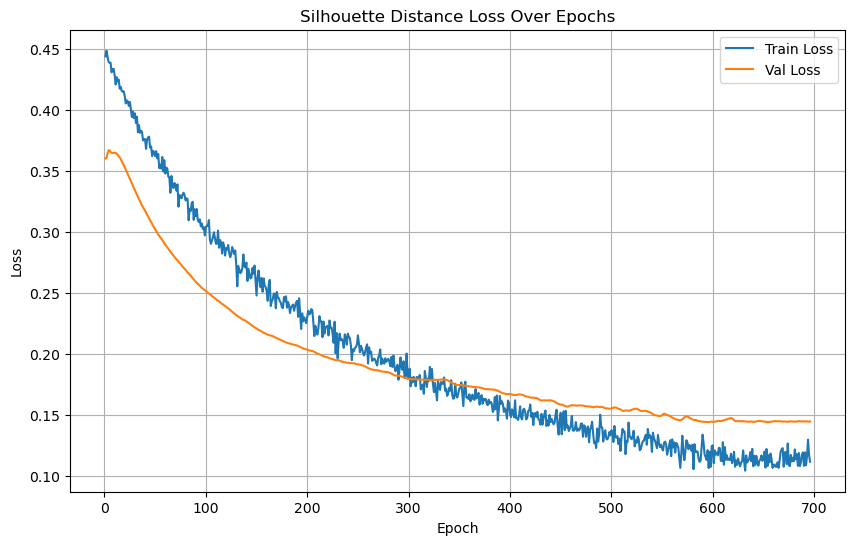

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/2309], Loss: 0.0563
Test Batch [20/2309], Loss: 0.0656
Test Batch [30/2309], Loss: 0.5000
Test Batch [40/2309], Loss: 0.0240
Test Batch [50/2309], Loss: 0.5000
Test Batch [60/2309], Loss: 0.5000


Test Batch [70/2309], Loss: 0.5000
Test Batch [80/2309], Loss: 0.0393
Test Batch [90/2309], Loss: 0.5000
Test Batch [100/2309], Loss: 0.0350
Test Batch [110/2309], Loss: 0.5000
Test Batch [120/2309], Loss: 0.0283
Test Batch [130/2309], Loss: 0.5000


Test Batch [140/2309], Loss: 0.5000
Test Batch [150/2309], Loss: 0.5000
Test Batch [160/2309], Loss: 0.0165
Test Batch [170/2309], Loss: 0.0418
Test Batch [180/2309], Loss: 0.5000
Test Batch [190/2309], Loss: 0.5000
Test Batch [200/2309], Loss: 0.0387


Test Batch [210/2309], Loss: 0.0144
Test Batch [220/2309], Loss: 0.5000
Test Batch [230/2309], Loss: 0.0372
Test Batch [240/2309], Loss: 0.5000
Test Batch [250/2309], Loss: 0.0608
Test Batch [260/2309], Loss: 0.0415
Test Batch [270/2309], Loss: 0.5000


Test Batch [280/2309], Loss: 0.5000
Test Batch [290/2309], Loss: 0.5000
Test Batch [300/2309], Loss: 0.0610
Test Batch [310/2309], Loss: 0.0114
Test Batch [320/2309], Loss: 0.0799
Test Batch [330/2309], Loss: 0.5000
Test Batch [340/2309], Loss: 0.5000
Test Batch [350/2309], Loss: 0.0131


Test Batch [360/2309], Loss: 0.0904
Test Batch [370/2309], Loss: 0.0405
Test Batch [380/2309], Loss: 0.0928
Test Batch [390/2309], Loss: 0.0602
Test Batch [400/2309], Loss: 0.0325
Test Batch [410/2309], Loss: 0.5000


Test Batch [420/2309], Loss: 0.0793
Test Batch [430/2309], Loss: 0.0130
Test Batch [440/2309], Loss: 0.5000
Test Batch [450/2309], Loss: 0.0455
Test Batch [460/2309], Loss: 0.5000
Test Batch [470/2309], Loss: 0.5000


Test Batch [480/2309], Loss: 0.0709
Test Batch [490/2309], Loss: 0.5000
Test Batch [500/2309], Loss: 0.0442
Test Batch [510/2309], Loss: 0.5000
Test Batch [520/2309], Loss: 0.0672
Test Batch [530/2309], Loss: 0.0452
Test Batch [540/2309], Loss: 0.5000


Test Batch [550/2309], Loss: 0.0400
Test Batch [560/2309], Loss: 0.0519
Test Batch [570/2309], Loss: 0.5000
Test Batch [580/2309], Loss: 0.5000
Test Batch [590/2309], Loss: 0.0684
Test Batch [600/2309], Loss: 0.0470


Test Batch [610/2309], Loss: 0.5000
Test Batch [620/2309], Loss: 0.5000
Test Batch [630/2309], Loss: 0.5000
Test Batch [640/2309], Loss: 0.0257
Test Batch [650/2309], Loss: 0.5000


Test Batch [660/2309], Loss: 0.0727
Test Batch [670/2309], Loss: 0.5000
Test Batch [680/2309], Loss: 0.0507
Test Batch [690/2309], Loss: 0.0620
Test Batch [700/2309], Loss: 0.5000
Test Batch [710/2309], Loss: 0.0431


Test Batch [720/2309], Loss: 0.5000
Test Batch [730/2309], Loss: 0.0570
Test Batch [740/2309], Loss: 0.5000
Test Batch [750/2309], Loss: 0.5000
Test Batch [760/2309], Loss: 0.0609
Test Batch [770/2309], Loss: 0.0601


Test Batch [780/2309], Loss: 0.0133
Test Batch [790/2309], Loss: 0.5000
Test Batch [800/2309], Loss: 0.0154
Test Batch [810/2309], Loss: 0.0422
Test Batch [820/2309], Loss: 0.0601
Test Batch [830/2309], Loss: 0.5000


Test Batch [840/2309], Loss: 0.0932
Test Batch [850/2309], Loss: 0.1559
Test Batch [860/2309], Loss: 0.1369
Test Batch [870/2309], Loss: 0.0199
Test Batch [880/2309], Loss: 0.5000
Test Batch [890/2309], Loss: 0.0544
Test Batch [900/2309], Loss: 0.5000


Test Batch [910/2309], Loss: 0.5000
Test Batch [920/2309], Loss: 0.0979
Test Batch [930/2309], Loss: 0.0400
Test Batch [940/2309], Loss: 0.5000
Test Batch [950/2309], Loss: 0.0141
Test Batch [960/2309], Loss: 0.0268
Test Batch [970/2309], Loss: 0.0676


Test Batch [980/2309], Loss: 0.1208
Test Batch [990/2309], Loss: 0.5000
Test Batch [1000/2309], Loss: 0.1102
Test Batch [1010/2309], Loss: 0.5000
Test Batch [1020/2309], Loss: 0.0455
Test Batch [1030/2309], Loss: 0.5000


Test Batch [1040/2309], Loss: 0.5000
Test Batch [1050/2309], Loss: 0.0294
Test Batch [1060/2309], Loss: 0.0644
Test Batch [1070/2309], Loss: 0.0427
Test Batch [1080/2309], Loss: 0.0807


Test Batch [1090/2309], Loss: 0.5000
Test Batch [1100/2309], Loss: 0.5000
Test Batch [1110/2309], Loss: 0.0147
Test Batch [1120/2309], Loss: 0.0696
Test Batch [1130/2309], Loss: 0.0324


Test Batch [1140/2309], Loss: 0.0536
Test Batch [1150/2309], Loss: 0.1230
Test Batch [1160/2309], Loss: 0.0404
Test Batch [1170/2309], Loss: 0.0635


Test Batch [1180/2309], Loss: 0.5000
Test Batch [1190/2309], Loss: 0.0756
Test Batch [1200/2309], Loss: 0.0355
Test Batch [1210/2309], Loss: 0.0220
Test Batch [1220/2309], Loss: 0.0409


Test Batch [1230/2309], Loss: 0.0255
Test Batch [1240/2309], Loss: 0.0797
Test Batch [1250/2309], Loss: 0.5000
Test Batch [1260/2309], Loss: 0.1218
Test Batch [1270/2309], Loss: 0.0387


Test Batch [1280/2309], Loss: 0.0673
Test Batch [1290/2309], Loss: 0.0358
Test Batch [1300/2309], Loss: 0.0712


Test Batch [1310/2309], Loss: 0.0541
Test Batch [1320/2309], Loss: 0.1147
Test Batch [1330/2309], Loss: 0.0706
Test Batch [1340/2309], Loss: 0.0151


Test Batch [1350/2309], Loss: 0.0916
Test Batch [1360/2309], Loss: 0.1212
Test Batch [1370/2309], Loss: 0.0740


Test Batch [1380/2309], Loss: 0.0989
Test Batch [1390/2309], Loss: 0.0846
Test Batch [1400/2309], Loss: 0.0857


Test Batch [1410/2309], Loss: 0.0658
Test Batch [1420/2309], Loss: 0.1148
Test Batch [1430/2309], Loss: 0.5000
Test Batch [1440/2309], Loss: 0.5000


Test Batch [1450/2309], Loss: 0.0893
Test Batch [1460/2309], Loss: 0.0683
Test Batch [1470/2309], Loss: 0.0446
Test Batch [1480/2309], Loss: 0.0667


Test Batch [1490/2309], Loss: 0.0682
Test Batch [1500/2309], Loss: 0.0665
Test Batch [1510/2309], Loss: 0.0918
Test Batch [1520/2309], Loss: 0.5000


Test Batch [1530/2309], Loss: 0.0602
Test Batch [1540/2309], Loss: 0.1391
Test Batch [1550/2309], Loss: 0.0426


Test Batch [1560/2309], Loss: 0.0573
Test Batch [1570/2309], Loss: 0.0562
Test Batch [1580/2309], Loss: 0.0736
Test Batch [1590/2309], Loss: 0.0913


Test Batch [1600/2309], Loss: 0.0388
Test Batch [1610/2309], Loss: 0.0638
Test Batch [1620/2309], Loss: 0.1962
Test Batch [1630/2309], Loss: 0.1493


Test Batch [1640/2309], Loss: 0.1100
Test Batch [1650/2309], Loss: 0.0275
Test Batch [1660/2309], Loss: 0.1152
Test Batch [1670/2309], Loss: 0.1137


Test Batch [1680/2309], Loss: 0.0909
Test Batch [1690/2309], Loss: 0.0711
Test Batch [1700/2309], Loss: 0.0880
Test Batch [1710/2309], Loss: 0.0647
Test Batch [1720/2309], Loss: 0.5000


Test Batch [1730/2309], Loss: 0.0641
Test Batch [1740/2309], Loss: 0.5000
Test Batch [1750/2309], Loss: 0.0394
Test Batch [1760/2309], Loss: 0.0351
Test Batch [1770/2309], Loss: 0.0306
Test Batch [1780/2309], Loss: 0.0449
Test Batch [1790/2309], Loss: 0.0672


Test Batch [1800/2309], Loss: 0.0781
Test Batch [1810/2309], Loss: 0.1213
Test Batch [1820/2309], Loss: 0.0941
Test Batch [1830/2309], Loss: 0.0582
Test Batch [1840/2309], Loss: 0.1031


Test Batch [1850/2309], Loss: 0.1216
Test Batch [1860/2309], Loss: 0.0542
Test Batch [1870/2309], Loss: 0.0551
Test Batch [1880/2309], Loss: 0.0694
Test Batch [1890/2309], Loss: 0.0588


Test Batch [1900/2309], Loss: 0.1142
Test Batch [1910/2309], Loss: 0.0956
Test Batch [1920/2309], Loss: 0.0837
Test Batch [1930/2309], Loss: 0.0961


Test Batch [1940/2309], Loss: 0.1083
Test Batch [1950/2309], Loss: 0.1398
Test Batch [1960/2309], Loss: 0.1536
Test Batch [1970/2309], Loss: 0.0897
Test Batch [1980/2309], Loss: 0.0625
Test Batch [1990/2309], Loss: 0.0400


Test Batch [2000/2309], Loss: 0.0492
Test Batch [2010/2309], Loss: 0.0622
Test Batch [2020/2309], Loss: 0.0594
Test Batch [2030/2309], Loss: 0.0708
Test Batch [2040/2309], Loss: 0.0724


Test Batch [2050/2309], Loss: 0.0575
Test Batch [2060/2309], Loss: 0.0782
Test Batch [2070/2309], Loss: 0.1626
Test Batch [2080/2309], Loss: 0.2082
Test Batch [2090/2309], Loss: 0.5000
Test Batch [2100/2309], Loss: 0.0905
Test Batch [2110/2309], Loss: 0.1508


Test Batch [2120/2309], Loss: 0.1348
Test Batch [2130/2309], Loss: 0.5000
Test Batch [2140/2309], Loss: 0.5000
Test Batch [2150/2309], Loss: 0.5000
Test Batch [2160/2309], Loss: 0.5000
Test Batch [2170/2309], Loss: 0.0235


Test Batch [2180/2309], Loss: 0.0490
Test Batch [2190/2309], Loss: 0.0291
Test Batch [2200/2309], Loss: 0.1342
Test Batch [2210/2309], Loss: 0.5000
Test Batch [2220/2309], Loss: 0.5000


Test Batch [2230/2309], Loss: 0.5000
Test Batch [2240/2309], Loss: 0.5000
Test Batch [2250/2309], Loss: 0.5000
Test Batch [2260/2309], Loss: 0.5000
Test Batch [2270/2309], Loss: 0.5000
Test Batch [2280/2309], Loss: 0.1042


Test Batch [2290/2309], Loss: 0.5000
Test Batch [2300/2309], Loss: 0.5000

Test Loss: 0.1951


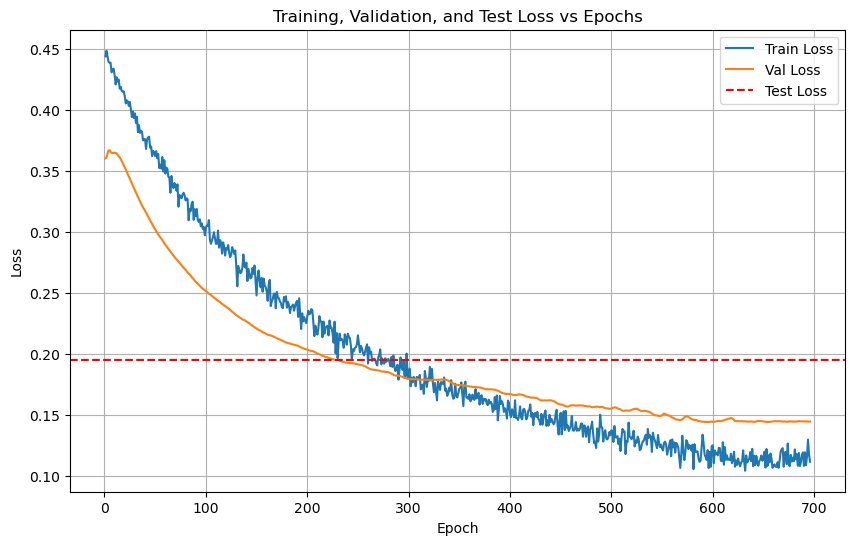

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...


  Processed batch 10/2309 for test dataset.
  Processed batch 20/2309 for test dataset.
  Processed batch 30/2309 for test dataset.


  Processed batch 40/2309 for test dataset.


  Processed batch 50/2309 for test dataset.
  Processed batch 60/2309 for test dataset.
  Processed batch 70/2309 for test dataset.


  Processed batch 80/2309 for test dataset.


  Processed batch 90/2309 for test dataset.
  Processed batch 100/2309 for test dataset.


  Processed batch 110/2309 for test dataset.


  Processed batch 120/2309 for test dataset.


  Processed batch 130/2309 for test dataset.
  Processed batch 140/2309 for test dataset.


  Processed batch 150/2309 for test dataset.


  Processed batch 160/2309 for test dataset.
  Processed batch 170/2309 for test dataset.
  Processed batch 180/2309 for test dataset.


  Processed batch 190/2309 for test dataset.


  Processed batch 200/2309 for test dataset.
  Processed batch 210/2309 for test dataset.


  Processed batch 220/2309 for test dataset.
  Processed batch 230/2309 for test dataset.
  Processed batch 240/2309 for test dataset.


  Processed batch 250/2309 for test dataset.
  Processed batch 260/2309 for test dataset.
  Processed batch 270/2309 for test dataset.


  Processed batch 280/2309 for test dataset.
  Processed batch 290/2309 for test dataset.
  Processed batch 300/2309 for test dataset.
  Processed batch 310/2309 for test dataset.


  Processed batch 320/2309 for test dataset.
  Processed batch 330/2309 for test dataset.
  Processed batch 340/2309 for test dataset.


  Processed batch 350/2309 for test dataset.
  Processed batch 360/2309 for test dataset.
  Processed batch 370/2309 for test dataset.


  Processed batch 380/2309 for test dataset.
  Processed batch 390/2309 for test dataset.
  Processed batch 400/2309 for test dataset.


  Processed batch 410/2309 for test dataset.
  Processed batch 420/2309 for test dataset.
  Processed batch 430/2309 for test dataset.
  Processed batch 440/2309 for test dataset.


  Processed batch 450/2309 for test dataset.
  Processed batch 460/2309 for test dataset.
  Processed batch 470/2309 for test dataset.
  Processed batch 480/2309 for test dataset.


  Processed batch 490/2309 for test dataset.
  Processed batch 500/2309 for test dataset.
  Processed batch 510/2309 for test dataset.


  Processed batch 520/2309 for test dataset.
  Processed batch 530/2309 for test dataset.
  Processed batch 540/2309 for test dataset.
  Processed batch 550/2309 for test dataset.


  Processed batch 560/2309 for test dataset.
  Processed batch 570/2309 for test dataset.
  Processed batch 580/2309 for test dataset.


  Processed batch 590/2309 for test dataset.
  Processed batch 600/2309 for test dataset.
  Processed batch 610/2309 for test dataset.


  Processed batch 620/2309 for test dataset.
  Processed batch 630/2309 for test dataset.
  Processed batch 640/2309 for test dataset.
  Processed batch 650/2309 for test dataset.


  Processed batch 660/2309 for test dataset.
  Processed batch 670/2309 for test dataset.
  Processed batch 680/2309 for test dataset.
  Processed batch 690/2309 for test dataset.


  Processed batch 700/2309 for test dataset.
  Processed batch 710/2309 for test dataset.
  Processed batch 720/2309 for test dataset.
  Processed batch 730/2309 for test dataset.


  Processed batch 740/2309 for test dataset.
  Processed batch 750/2309 for test dataset.
  Processed batch 760/2309 for test dataset.


  Processed batch 770/2309 for test dataset.
  Processed batch 780/2309 for test dataset.


  Processed batch 790/2309 for test dataset.
  Processed batch 800/2309 for test dataset.
  Processed batch 810/2309 for test dataset.


  Processed batch 820/2309 for test dataset.
  Processed batch 830/2309 for test dataset.
  Processed batch 840/2309 for test dataset.


  Processed batch 850/2309 for test dataset.
  Processed batch 860/2309 for test dataset.


  Processed batch 870/2309 for test dataset.
  Processed batch 880/2309 for test dataset.
  Processed batch 890/2309 for test dataset.


  Processed batch 900/2309 for test dataset.
  Processed batch 910/2309 for test dataset.
  Processed batch 920/2309 for test dataset.


  Processed batch 930/2309 for test dataset.
  Processed batch 940/2309 for test dataset.


  Processed batch 950/2309 for test dataset.
  Processed batch 960/2309 for test dataset.
  Processed batch 970/2309 for test dataset.


  Processed batch 980/2309 for test dataset.
  Processed batch 990/2309 for test dataset.
  Processed batch 1000/2309 for test dataset.
  Processed batch 1010/2309 for test dataset.


  Processed batch 1020/2309 for test dataset.
  Processed batch 1030/2309 for test dataset.
  Processed batch 1040/2309 for test dataset.


  Processed batch 1050/2309 for test dataset.
  Processed batch 1060/2309 for test dataset.
  Processed batch 1070/2309 for test dataset.


  Processed batch 1080/2309 for test dataset.
  Processed batch 1090/2309 for test dataset.


  Processed batch 1100/2309 for test dataset.
  Processed batch 1110/2309 for test dataset.
  Processed batch 1120/2309 for test dataset.
  Processed batch 1130/2309 for test dataset.


  Processed batch 1140/2309 for test dataset.
  Processed batch 1150/2309 for test dataset.
  Processed batch 1160/2309 for test dataset.


  Processed batch 1170/2309 for test dataset.
  Processed batch 1180/2309 for test dataset.


  Processed batch 1190/2309 for test dataset.
  Processed batch 1200/2309 for test dataset.
  Processed batch 1210/2309 for test dataset.


  Processed batch 1220/2309 for test dataset.
  Processed batch 1230/2309 for test dataset.
  Processed batch 1240/2309 for test dataset.


  Processed batch 1250/2309 for test dataset.
  Processed batch 1260/2309 for test dataset.
  Processed batch 1270/2309 for test dataset.


  Processed batch 1280/2309 for test dataset.
  Processed batch 1290/2309 for test dataset.
  Processed batch 1300/2309 for test dataset.


  Processed batch 1310/2309 for test dataset.
  Processed batch 1320/2309 for test dataset.
  Processed batch 1330/2309 for test dataset.


  Processed batch 1340/2309 for test dataset.
  Processed batch 1350/2309 for test dataset.
  Processed batch 1360/2309 for test dataset.


  Processed batch 1370/2309 for test dataset.
  Processed batch 1380/2309 for test dataset.
  Processed batch 1390/2309 for test dataset.


  Processed batch 1400/2309 for test dataset.
  Processed batch 1410/2309 for test dataset.
  Processed batch 1420/2309 for test dataset.


  Processed batch 1430/2309 for test dataset.
  Processed batch 1440/2309 for test dataset.
  Processed batch 1450/2309 for test dataset.


  Processed batch 1460/2309 for test dataset.
  Processed batch 1470/2309 for test dataset.
  Processed batch 1480/2309 for test dataset.
  Processed batch 1490/2309 for test dataset.


  Processed batch 1500/2309 for test dataset.
  Processed batch 1510/2309 for test dataset.
  Processed batch 1520/2309 for test dataset.


  Processed batch 1530/2309 for test dataset.
  Processed batch 1540/2309 for test dataset.
  Processed batch 1550/2309 for test dataset.


  Processed batch 1560/2309 for test dataset.
  Processed batch 1570/2309 for test dataset.
  Processed batch 1580/2309 for test dataset.


  Processed batch 1590/2309 for test dataset.
  Processed batch 1600/2309 for test dataset.
  Processed batch 1610/2309 for test dataset.


  Processed batch 1620/2309 for test dataset.
  Processed batch 1630/2309 for test dataset.
  Processed batch 1640/2309 for test dataset.


  Processed batch 1650/2309 for test dataset.
  Processed batch 1660/2309 for test dataset.
  Processed batch 1670/2309 for test dataset.
  Processed batch 1680/2309 for test dataset.


  Processed batch 1690/2309 for test dataset.
  Processed batch 1700/2309 for test dataset.
  Processed batch 1710/2309 for test dataset.


  Processed batch 1720/2309 for test dataset.
  Processed batch 1730/2309 for test dataset.
  Processed batch 1740/2309 for test dataset.
  Processed batch 1750/2309 for test dataset.


  Processed batch 1760/2309 for test dataset.
  Processed batch 1770/2309 for test dataset.
  Processed batch 1780/2309 for test dataset.


  Processed batch 1790/2309 for test dataset.
  Processed batch 1800/2309 for test dataset.
  Processed batch 1810/2309 for test dataset.
  Processed batch 1820/2309 for test dataset.


  Processed batch 1830/2309 for test dataset.
  Processed batch 1840/2309 for test dataset.
  Processed batch 1850/2309 for test dataset.
  Processed batch 1860/2309 for test dataset.


  Processed batch 1870/2309 for test dataset.
  Processed batch 1880/2309 for test dataset.


  Processed batch 1890/2309 for test dataset.
  Processed batch 1900/2309 for test dataset.
  Processed batch 1910/2309 for test dataset.


  Processed batch 1920/2309 for test dataset.
  Processed batch 1930/2309 for test dataset.
  Processed batch 1940/2309 for test dataset.
  Processed batch 1950/2309 for test dataset.


  Processed batch 1960/2309 for test dataset.
  Processed batch 1970/2309 for test dataset.
  Processed batch 1980/2309 for test dataset.


  Processed batch 1990/2309 for test dataset.
  Processed batch 2000/2309 for test dataset.


  Processed batch 2010/2309 for test dataset.
  Processed batch 2020/2309 for test dataset.
  Processed batch 2030/2309 for test dataset.


  Processed batch 2040/2309 for test dataset.
  Processed batch 2050/2309 for test dataset.
  Processed batch 2060/2309 for test dataset.


  Processed batch 2070/2309 for test dataset.
  Processed batch 2080/2309 for test dataset.
  Processed batch 2090/2309 for test dataset.
  Processed batch 2100/2309 for test dataset.


  Processed batch 2110/2309 for test dataset.
  Processed batch 2120/2309 for test dataset.
  Processed batch 2130/2309 for test dataset.
  Processed batch 2140/2309 for test dataset.


  Processed batch 2150/2309 for test dataset.
  Processed batch 2160/2309 for test dataset.
  Processed batch 2170/2309 for test dataset.
  Processed batch 2180/2309 for test dataset.


  Processed batch 2190/2309 for test dataset.
  Processed batch 2200/2309 for test dataset.
  Processed batch 2210/2309 for test dataset.
  Processed batch 2220/2309 for test dataset.


  Processed batch 2230/2309 for test dataset.
  Processed batch 2240/2309 for test dataset.
  Processed batch 2250/2309 for test dataset.


  Processed batch 2260/2309 for test dataset.
  Processed batch 2270/2309 for test dataset.
  Processed batch 2280/2309 for test dataset.


  Processed batch 2290/2309 for test dataset.
  Processed batch 2300/2309 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 93.33%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.67      0.80      0.73         5
           2       0.75      0.60      0.67         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         5
           7       1.00      1.00      1.00         5
           8       1.00      1.00      1.00         5

    accuracy                           0.93        45
   macro avg       0.94      0.93      0.93        45
weighted avg       0.94      0.93      0.93        45


LOG: Evaluating on the test set...
Test Accuracy: 97.43%



Test Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     65926
           1       0.93      0.94      0.94      7553
           2       0.83      0.81      0.82      3045
           3       0.69      0.95      0.80      2640
           4       0.96      0.91      0.94      6539
           5       0.92      0.94      0.93      9203
           6       0.94      0.88      0.91      7242
           7       1.00      0.99      0.99     42781
           8       0.98      0.99      0.99      2818

    accuracy                           0.97    147747
   macro avg       0.92      0.93      0.92    147747
weighted avg       0.98      0.97      0.97    147747

Saved SCL_SDL+LRM predictions and true labels to model_predictions


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (147747, 128)
Test labels shape: (147747,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3212  |  Val Loss: 2.2064
Validation loss improved from inf to 2.2064.
[Epoch 2/1000] Train Loss: 2.1704  |  Val Loss: 2.0857
Validation loss improved from 2.2064 to 2.0857.
[Epoch 3/1000] Train Loss: 2.0492  |  Val Loss: 1.9836
Validation loss improved from 2.0857 to 1.9836.
[Epoch 4/1000] Train Loss: 1.9348  |  Val Loss: 1.8876
Validation loss improved from 1.9836 to 1.8876.
[Epoch 5/1000] Train Loss: 1.8292  |  Val Loss: 1.7950
Validation loss improved from 1.8876 to 1.7950.
[Epoch 6/1000] Train Loss: 1.7290  |  Val Loss: 1.7109
Validation loss improved from 1.7950 to 1.7109.
[Epoch 7/1000] Train Loss: 1.6401  |  Val Loss: 1.6348
Validation loss improved from 1.7109 to 1.6348.
[Epoch 8/1000] Train Loss: 1.5569  |  Val Loss: 1.5660
Validation loss improved from 1.6348 to 1.5660.
[Epoch 9/1000] Train Loss: 1.4839  |  Val Loss: 1.5011
Validation loss improved from 1.5660 to 1.5011.
[Epoch 10/1000] Train Loss: 1.4139  |  Val Loss: 1.4405
Validation loss impr

[Epoch 14/1000] Train Loss: 1.1803  |  Val Loss: 1.2265
Validation loss improved from 1.2766 to 1.2265.
[Epoch 15/1000] Train Loss: 1.1287  |  Val Loss: 1.1782
Validation loss improved from 1.2265 to 1.1782.
[Epoch 16/1000] Train Loss: 1.0796  |  Val Loss: 1.1310
Validation loss improved from 1.1782 to 1.1310.


[Epoch 17/1000] Train Loss: 1.0308  |  Val Loss: 1.0857
Validation loss improved from 1.1310 to 1.0857.
[Epoch 18/1000] Train Loss: 0.9847  |  Val Loss: 1.0414
Validation loss improved from 1.0857 to 1.0414.
[Epoch 19/1000] Train Loss: 0.9392  |  Val Loss: 0.9984
Validation loss improved from 1.0414 to 0.9984.
[Epoch 20/1000] Train Loss: 0.8958  |  Val Loss: 0.9559
Validation loss improved from 0.9984 to 0.9559.
[Epoch 21/1000] Train Loss: 0.8532  |  Val Loss: 0.9140
Validation loss improved from 0.9559 to 0.9140.
[Epoch 22/1000] Train Loss: 0.8115  |  Val Loss: 0.8729
Validation loss improved from 0.9140 to 0.8729.
[Epoch 23/1000] Train Loss: 0.7713  |  Val Loss: 0.8330
Validation loss improved from 0.8729 to 0.8330.
[Epoch 24/1000] Train Loss: 0.7335  |  Val Loss: 0.7944
Validation loss improved from 0.8330 to 0.7944.
[Epoch 25/1000] Train Loss: 0.6969  |  Val Loss: 0.7573
Validation loss improved from 0.7944 to 0.7573.
[Epoch 26/1000] Train Loss: 0.6628  |  Val Loss: 0.7219
Validati

[Epoch 32/1000] Train Loss: 0.4973  |  Val Loss: 0.5473
Validation loss improved from 0.5731 to 0.5473.


[Epoch 33/1000] Train Loss: 0.4746  |  Val Loss: 0.5231
Validation loss improved from 0.5473 to 0.5231.
[Epoch 34/1000] Train Loss: 0.4523  |  Val Loss: 0.4996
Validation loss improved from 0.5231 to 0.4996.
[Epoch 35/1000] Train Loss: 0.4313  |  Val Loss: 0.4771
Validation loss improved from 0.4996 to 0.4771.
[Epoch 36/1000] Train Loss: 0.4112  |  Val Loss: 0.4558
Validation loss improved from 0.4771 to 0.4558.
[Epoch 37/1000] Train Loss: 0.3921  |  Val Loss: 0.4356
Validation loss improved from 0.4558 to 0.4356.
[Epoch 38/1000] Train Loss: 0.3736  |  Val Loss: 0.4163
Validation loss improved from 0.4356 to 0.4163.
[Epoch 39/1000] Train Loss: 0.3562  |  Val Loss: 0.3974
Validation loss improved from 0.4163 to 0.3974.
[Epoch 40/1000] Train Loss: 0.3394  |  Val Loss: 0.3801
Validation loss improved from 0.3974 to 0.3801.
[Epoch 41/1000] Train Loss: 0.3237  |  Val Loss: 0.3635
Validation loss improved from 0.3801 to 0.3635.
[Epoch 42/1000] Train Loss: 0.3091  |  Val Loss: 0.3482
Validati

[Epoch 49/1000] Train Loss: 0.2287  |  Val Loss: 0.2637
Validation loss improved from 0.2740 to 0.2637.
[Epoch 50/1000] Train Loss: 0.2203  |  Val Loss: 0.2553
Validation loss improved from 0.2637 to 0.2553.
[Epoch 51/1000] Train Loss: 0.2119  |  Val Loss: 0.2463
Validation loss improved from 0.2553 to 0.2463.
[Epoch 52/1000] Train Loss: 0.2046  |  Val Loss: 0.2377
Validation loss improved from 0.2463 to 0.2377.
[Epoch 53/1000] Train Loss: 0.1973  |  Val Loss: 0.2308
Validation loss improved from 0.2377 to 0.2308.
[Epoch 54/1000] Train Loss: 0.1906  |  Val Loss: 0.2235
Validation loss improved from 0.2308 to 0.2235.
[Epoch 55/1000] Train Loss: 0.1845  |  Val Loss: 0.2181
Validation loss improved from 0.2235 to 0.2181.
[Epoch 56/1000] Train Loss: 0.1785  |  Val Loss: 0.2122
Validation loss improved from 0.2181 to 0.2122.
[Epoch 57/1000] Train Loss: 0.1731  |  Val Loss: 0.2062
Validation loss improved from 0.2122 to 0.2062.
[Epoch 58/1000] Train Loss: 0.1680  |  Val Loss: 0.2008
Validati

[Epoch 65/1000] Train Loss: 0.1404  |  Val Loss: 0.1716
Validation loss improved from 0.1757 to 0.1716.
[Epoch 66/1000] Train Loss: 0.1372  |  Val Loss: 0.1684
Validation loss improved from 0.1716 to 0.1684.
[Epoch 67/1000] Train Loss: 0.1346  |  Val Loss: 0.1647
Validation loss improved from 0.1684 to 0.1647.
[Epoch 68/1000] Train Loss: 0.1316  |  Val Loss: 0.1618
Validation loss improved from 0.1647 to 0.1618.
[Epoch 69/1000] Train Loss: 0.1290  |  Val Loss: 0.1597
Validation loss improved from 0.1618 to 0.1597.
[Epoch 70/1000] Train Loss: 0.1264  |  Val Loss: 0.1575
Validation loss improved from 0.1597 to 0.1575.
[Epoch 71/1000] Train Loss: 0.1240  |  Val Loss: 0.1556
Validation loss improved from 0.1575 to 0.1556.
[Epoch 72/1000] Train Loss: 0.1219  |  Val Loss: 0.1537
Validation loss improved from 0.1556 to 0.1537.
[Epoch 73/1000] Train Loss: 0.1197  |  Val Loss: 0.1512
Validation loss improved from 0.1537 to 0.1512.
[Epoch 74/1000] Train Loss: 0.1177  |  Val Loss: 0.1489
Validati

[Epoch 82/1000] Train Loss: 0.1044  |  Val Loss: 0.1332
Validation loss improved from 0.1349 to 0.1332.
[Epoch 83/1000] Train Loss: 0.1031  |  Val Loss: 0.1324
Validation loss improved from 0.1332 to 0.1324.
[Epoch 84/1000] Train Loss: 0.1019  |  Val Loss: 0.1298
Validation loss improved from 0.1324 to 0.1298.
[Epoch 85/1000] Train Loss: 0.1005  |  Val Loss: 0.1281
Validation loss improved from 0.1298 to 0.1281.
[Epoch 86/1000] Train Loss: 0.0993  |  Val Loss: 0.1279
Validation loss improved from 0.1281 to 0.1279.
[Epoch 87/1000] Train Loss: 0.0981  |  Val Loss: 0.1276
Validation loss improved from 0.1279 to 0.1276.
[Epoch 88/1000] Train Loss: 0.0970  |  Val Loss: 0.1253
Validation loss improved from 0.1276 to 0.1253.
[Epoch 89/1000] Train Loss: 0.0958  |  Val Loss: 0.1245
Validation loss improved from 0.1253 to 0.1245.
[Epoch 90/1000] Train Loss: 0.0950  |  Val Loss: 0.1226
Validation loss improved from 0.1245 to 0.1226.
[Epoch 91/1000] Train Loss: 0.0937  |  Val Loss: 0.1223
Validati

[Epoch 98/1000] Train Loss: 0.0878  |  Val Loss: 0.1176
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 99/1000] Train Loss: 0.0869  |  Val Loss: 0.1168
Validation loss improved from 0.1175 to 0.1168.
[Epoch 100/1000] Train Loss: 0.0867  |  Val Loss: 0.1143
Validation loss improved from 0.1168 to 0.1143.
[Epoch 101/1000] Train Loss: 0.0854  |  Val Loss: 0.1152
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 102/1000] Train Loss: 0.0848  |  Val Loss: 0.1156
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 103/1000] Train Loss: 0.0841  |  Val Loss: 0.1142
Validation loss improved from 0.1143 to 0.1142.
[Epoch 104/1000] Train Loss: 0.0834  |  Val Loss: 0.1141
Validation loss improved from 0.1142 to 0.1141.
[Epoch 105/1000] Train Loss: 0.0828  |  Val Loss: 0.1124
Validation loss improved from 0.1141 to 0.1124.
[Epoch 106/1000] Train Loss: 0.0823  |  Val Loss: 0.1105
Validation loss improved from 0.1124 to 0.1105.
[Epoch 107/1000] Train Loss: 0.0816  | 

[Epoch 115/1000] Train Loss: 0.0775  |  Val Loss: 0.1063
Validation loss improved from 0.1078 to 0.1063.
[Epoch 116/1000] Train Loss: 0.0768  |  Val Loss: 0.1062
Validation loss improved from 0.1063 to 0.1062.
[Epoch 117/1000] Train Loss: 0.0766  |  Val Loss: 0.1053
Validation loss improved from 0.1062 to 0.1053.
[Epoch 118/1000] Train Loss: 0.0762  |  Val Loss: 0.1083
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 119/1000] Train Loss: 0.0757  |  Val Loss: 0.1076
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 120/1000] Train Loss: 0.0754  |  Val Loss: 0.1079
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 121/1000] Train Loss: 0.0747  |  Val Loss: 0.1050
Validation loss improved from 0.1053 to 0.1050.
[Epoch 122/1000] Train Loss: 0.0742  |  Val Loss: 0.1036
Validation loss improved from 0.1050 to 0.1036.
[Epoch 123/1000] Train Loss: 0.0739  |  Val Loss: 0.1018
Validation loss improved from 0.1036 to 0.1018.
[Epoch 124/1000] Train Loss: 0.0738  

[Epoch 131/1000] Train Loss: 0.0711  |  Val Loss: 0.1048
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 132/1000] Train Loss: 0.0709  |  Val Loss: 0.1042
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 133/1000] Train Loss: 0.0708  |  Val Loss: 0.1046
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 134/1000] Train Loss: 0.0703  |  Val Loss: 0.1015
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 135/1000] Train Loss: 0.0700  |  Val Loss: 0.0993
Validation loss improved from 0.1000 to 0.0993.
[Epoch 136/1000] Train Loss: 0.0695  |  Val Loss: 0.0993
Validation loss improved from 0.0993 to 0.0993.
[Epoch 137/1000] Train Loss: 0.0692  |  Val Loss: 0.0978
Validation loss improved from 0.0993 to 0.0978.
[Epoch 138/1000] Train Loss: 0.0688  |  Val Loss: 0.0969
Validation loss improved from 0.0978 to 0.0969.
[Epoch 139/1000] Train Loss: 0.0686  |  Val Loss: 0.0970
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 140/1000] Train Lo

[Epoch 148/1000] Train Loss: 0.0663  |  Val Loss: 0.0940
Validation loss improved from 0.0944 to 0.0940.
[Epoch 149/1000] Train Loss: 0.0664  |  Val Loss: 0.0954
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 150/1000] Train Loss: 0.0658  |  Val Loss: 0.0952
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 151/1000] Train Loss: 0.0656  |  Val Loss: 0.0945
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 152/1000] Train Loss: 0.0653  |  Val Loss: 0.0946
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 153/1000] Train Loss: 0.0652  |  Val Loss: 0.0944
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 154/1000] Train Loss: 0.0649  |  Val Loss: 0.0959
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 155/1000] Train Loss: 0.0645  |  Val Loss: 0.0962
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 156/1000] Train Loss: 0.0643  |  Val Loss: 0.0954
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 162/1000] Train Loss: 0.0626  |  Val Loss: 0.0942
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 163/1000] Train Loss: 0.0625  |  Val Loss: 0.0936
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 164/1000] Train Loss: 0.0622  |  Val Loss: 0.0964
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 165/1000] Train Loss: 0.0621  |  Val Loss: 0.0966
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 166/1000] Train Loss: 0.0617  |  Val Loss: 0.0960
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 167/1000] Train Loss: 0.0619  |  Val Loss: 0.0968
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 168/1000] Train Loss: 0.0614  |  Val Loss: 0.0947
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 169/1000] Train Loss: 0.0611  |  Val Loss: 0.0934
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 170/1000] Train Loss: 0.0613  |  Val Loss: 0.0923
Validation loss improved from 0.0931 to 0.0923.
[Epo

[Epoch 179/1000] Train Loss: 0.0600  |  Val Loss: 0.0900
Validation loss improved from 0.0916 to 0.0900.
[Epoch 180/1000] Train Loss: 0.0599  |  Val Loss: 0.0933
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 181/1000] Train Loss: 0.0593  |  Val Loss: 0.0930
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 182/1000] Train Loss: 0.0591  |  Val Loss: 0.0929
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 183/1000] Train Loss: 0.0591  |  Val Loss: 0.0935
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 184/1000] Train Loss: 0.0589  |  Val Loss: 0.0922
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 185/1000] Train Loss: 0.0587  |  Val Loss: 0.0914
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 186/1000] Train Loss: 0.0588  |  Val Loss: 0.0902
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 187/1000] Train Loss: 0.0587  |  Val Loss: 0.0916
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 195/1000] Train Loss: 0.0578  |  Val Loss: 0.0900
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 196/1000] Train Loss: 0.0574  |  Val Loss: 0.0895
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 197/1000] Train Loss: 0.0571  |  Val Loss: 0.0906
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 198/1000] Train Loss: 0.0571  |  Val Loss: 0.0908
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 199/1000] Train Loss: 0.0570  |  Val Loss: 0.0918
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 200/1000] Train Loss: 0.0570  |  Val Loss: 0.0958
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 201/1000] Train Loss: 0.0571  |  Val Loss: 0.0962
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 202/1000] Train Loss: 0.0571  |  Val Loss: 0.0927
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 203/1000] Train Loss: 0.0566  |  Val Loss: 0.0927
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 212/1000] Train Loss: 0.0554  |  Val Loss: 0.0897
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 213/1000] Train Loss: 0.0554  |  Val Loss: 0.0900
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 214/1000] Train Loss: 0.0554  |  Val Loss: 0.0892
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 215/1000] Train Loss: 0.0551  |  Val Loss: 0.0916
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 216/1000] Train Loss: 0.0553  |  Val Loss: 0.0923
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 217/1000] Train Loss: 0.0549  |  Val Loss: 0.0909
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 218/1000] Train Loss: 0.0549  |  Val Loss: 0.0880
Validation loss improved from 0.0885 to 0.0880.
[Epoch 219/1000] Train Loss: 0.0550  |  Val Loss: 0.0864
Validation loss improved from 0.0880 to 0.0864.
[Epoch 220/1000] Train Loss: 0.0553  |  Val Loss: 0.0892
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/

[Epoch 228/1000] Train Loss: 0.0536  |  Val Loss: 0.0873
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 229/1000] Train Loss: 0.0538  |  Val Loss: 0.0874
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 230/1000] Train Loss: 0.0535  |  Val Loss: 0.0874
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 231/1000] Train Loss: 0.0535  |  Val Loss: 0.0875
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 232/1000] Train Loss: 0.0534  |  Val Loss: 0.0869
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 233/1000] Train Loss: 0.0538  |  Val Loss: 0.0854
Validation loss improved from 0.0864 to 0.0854.
[Epoch 234/1000] Train Loss: 0.0535  |  Val Loss: 0.0879
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 235/1000] Train Loss: 0.0534  |  Val Loss: 0.0882
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 236/1000] Train Loss: 0.0533  |  Val Loss: 0.0904
!! Validation loss did NOT improve !! Patience: 3/100
[Ep

[Epoch 244/1000] Train Loss: 0.0524  |  Val Loss: 0.0893
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 245/1000] Train Loss: 0.0524  |  Val Loss: 0.0872
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 246/1000] Train Loss: 0.0523  |  Val Loss: 0.0862
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 247/1000] Train Loss: 0.0522  |  Val Loss: 0.0874
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 248/1000] Train Loss: 0.0522  |  Val Loss: 0.0889
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 249/1000] Train Loss: 0.0519  |  Val Loss: 0.0881
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 250/1000] Train Loss: 0.0520  |  Val Loss: 0.0869
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 251/1000] Train Loss: 0.0518  |  Val Loss: 0.0875
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 252/1000] Train Loss: 0.0517  |  Val Loss: 0.0888
!! Validation loss did NOT improve !! Patience:

[Epoch 261/1000] Train Loss: 0.0509  |  Val Loss: 0.0878
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 262/1000] Train Loss: 0.0509  |  Val Loss: 0.0867
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 263/1000] Train Loss: 0.0508  |  Val Loss: 0.0864
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 264/1000] Train Loss: 0.0510  |  Val Loss: 0.0872
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 265/1000] Train Loss: 0.0510  |  Val Loss: 0.0858
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 266/1000] Train Loss: 0.0507  |  Val Loss: 0.0867
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 267/1000] Train Loss: 0.0515  |  Val Loss: 0.0901
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 268/1000] Train Loss: 0.0510  |  Val Loss: 0.0903
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 269/1000] Train Loss: 0.0506  |  Val Loss: 0.0890
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 278/1000] Train Loss: 0.0500  |  Val Loss: 0.0866
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 279/1000] Train Loss: 0.0505  |  Val Loss: 0.0906
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 280/1000] Train Loss: 0.0501  |  Val Loss: 0.0910
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 281/1000] Train Loss: 0.0498  |  Val Loss: 0.0901
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 282/1000] Train Loss: 0.0495  |  Val Loss: 0.0875
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 283/1000] Train Loss: 0.0496  |  Val Loss: 0.0856
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 284/1000] Train Loss: 0.0496  |  Val Loss: 0.0850
Validation loss improved from 0.0851 to 0.0850.
[Epoch 285/1000] Train Loss: 0.0497  |  Val Loss: 0.0858
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 286/1000] Train Loss: 0.0494  |  Val Loss: 0.0856
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 294/1000] Train Loss: 0.0488  |  Val Loss: 0.0867
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 295/1000] Train Loss: 0.0489  |  Val Loss: 0.0862
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 296/1000] Train Loss: 0.0488  |  Val Loss: 0.0855
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 297/1000] Train Loss: 0.0489  |  Val Loss: 0.0850
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 298/1000] Train Loss: 0.0487  |  Val Loss: 0.0858
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 299/1000] Train Loss: 0.0485  |  Val Loss: 0.0870
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 300/1000] Train Loss: 0.0485  |  Val Loss: 0.0867
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 301/1000] Train Loss: 0.0484  |  Val Loss: 0.0875
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 302/1000] Train Loss: 0.0485  |  Val Loss: 0.0869
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 313/1000] Train Loss: 0.0481  |  Val Loss: 0.0870
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 314/1000] Train Loss: 0.0480  |  Val Loss: 0.0881
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 315/1000] Train Loss: 0.0478  |  Val Loss: 0.0882
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 316/1000] Train Loss: 0.0478  |  Val Loss: 0.0865
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 317/1000] Train Loss: 0.0476  |  Val Loss: 0.0864
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 318/1000] Train Loss: 0.0476  |  Val Loss: 0.0880
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 319/1000] Train Loss: 0.0475  |  Val Loss: 0.0886
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 320/1000] Train Loss: 0.0475  |  Val Loss: 0.0875
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 321/1000] Train Loss: 0.0476  |  Val Loss: 0.0884
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 330/1000] Train Loss: 0.0473  |  Val Loss: 0.0880
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 331/1000] Train Loss: 0.0470  |  Val Loss: 0.0881
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 332/1000] Train Loss: 0.0470  |  Val Loss: 0.0870
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 333/1000] Train Loss: 0.0469  |  Val Loss: 0.0877
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 334/1000] Train Loss: 0.0469  |  Val Loss: 0.0871
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 335/1000] Train Loss: 0.0468  |  Val Loss: 0.0876
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 336/1000] Train Loss: 0.0469  |  Val Loss: 0.0866
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 337/1000] Train Loss: 0.0466  |  Val Loss: 0.0870
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 338/1000] Train Loss: 0.0467  |  Val Loss: 0.0885
!! Validation loss did NOT improve !! Patience:

[Epoch 346/1000] Train Loss: 0.0462  |  Val Loss: 0.0873
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 347/1000] Train Loss: 0.0466  |  Val Loss: 0.0892
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 348/1000] Train Loss: 0.0461  |  Val Loss: 0.0881
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 349/1000] Train Loss: 0.0463  |  Val Loss: 0.0865
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 350/1000] Train Loss: 0.0464  |  Val Loss: 0.0870
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 351/1000] Train Loss: 0.0460  |  Val Loss: 0.0871
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 352/1000] Train Loss: 0.0460  |  Val Loss: 0.0871
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 353/1000] Train Loss: 0.0459  |  Val Loss: 0.0867
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 354/1000] Train Loss: 0.0467  |  Val Loss: 0.0895
!! Validation loss did NOT improve !! Patience:

[Epoch 362/1000] Train Loss: 0.0458  |  Val Loss: 0.0885
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 363/1000] Train Loss: 0.0455  |  Val Loss: 0.0885
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 364/1000] Train Loss: 0.0462  |  Val Loss: 0.0860
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 365/1000] Train Loss: 0.0456  |  Val Loss: 0.0882
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 366/1000] Train Loss: 0.0455  |  Val Loss: 0.0898
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 367/1000] Train Loss: 0.0456  |  Val Loss: 0.0898
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 368/1000] Train Loss: 0.0452  |  Val Loss: 0.0901
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 369/1000] Train Loss: 0.0452  |  Val Loss: 0.0899
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 370/1000] Train Loss: 0.0456  |  Val Loss: 0.0877
!! Validation loss did NOT improve !! Patience:

[Epoch 380/1000] Train Loss: 0.0447  |  Val Loss: 0.0906
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 381/1000] Train Loss: 0.0451  |  Val Loss: 0.0913
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 382/1000] Train Loss: 0.0449  |  Val Loss: 0.0896
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 383/1000] Train Loss: 0.0446  |  Val Loss: 0.0889
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 384/1000] Train Loss: 0.0448  |  Val Loss: 0.0902
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 385/1000] Train Loss: 0.0450  |  Val Loss: 0.0887
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 386/1000] Train Loss: 0.0443  |  Val Loss: 0.0903
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 387/1000] Train Loss: 0.0444  |  Val Loss: 0.0902
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 388/1000] Train Loss: 0.0444  |  Val Loss: 0.0899
!! Validation loss did NOT improve !! Patience:

[Epoch 396/1000] Train Loss: 0.0444  |  Val Loss: 0.0891
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 397/1000] Train Loss: 0.0443  |  Val Loss: 0.0882
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 398/1000] Train Loss: 0.0446  |  Val Loss: 0.0895
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 399/1000] Train Loss: 0.0441  |  Val Loss: 0.0889
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 400/1000] Train Loss: 0.0438  |  Val Loss: 0.0886
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 401/1000] Train Loss: 0.0441  |  Val Loss: 0.0881
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 402/1000] Train Loss: 0.0440  |  Val Loss: 0.0877
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 403/1000] Train Loss: 0.0439  |  Val Loss: 0.0868
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 404/1000] Train Loss: 0.0444  |  Val Loss: 0.0889
!! Validation loss did NOT improve !! Patience:

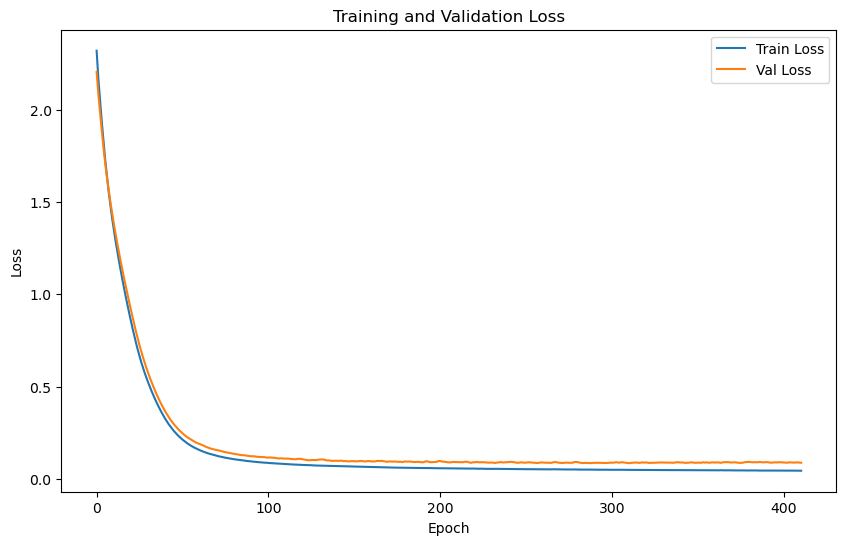

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.1132 | Test Accuracy: 97.33%


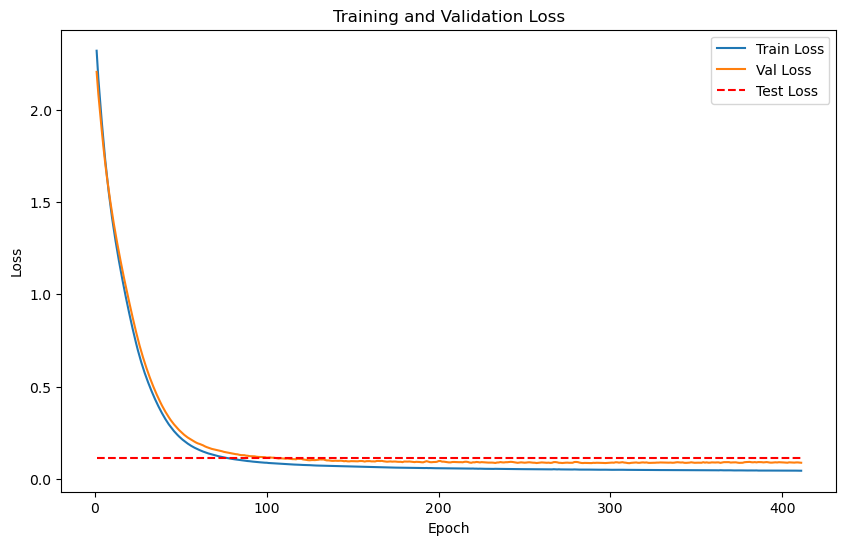

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


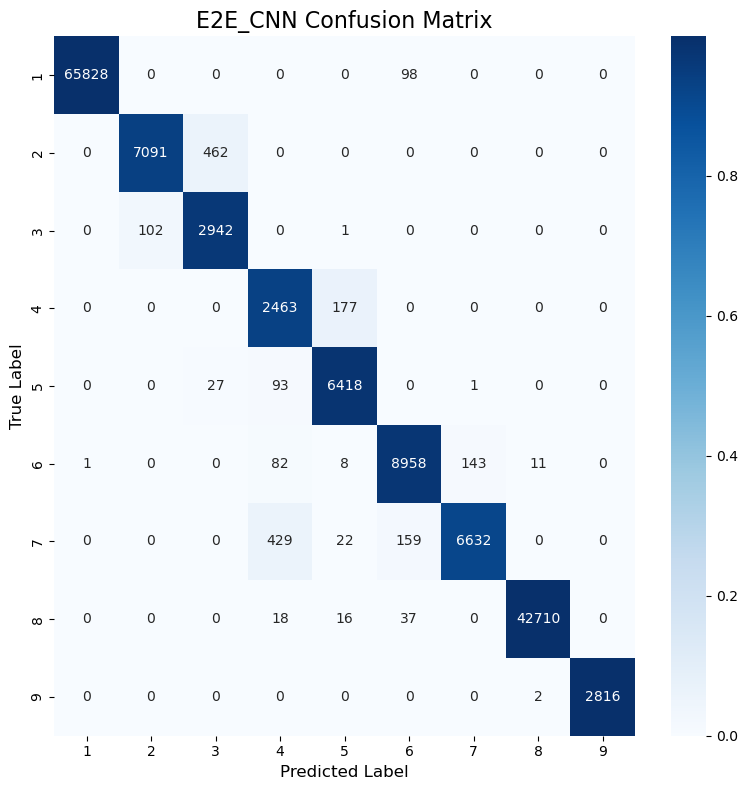

Classification Accuracy: 98.72%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


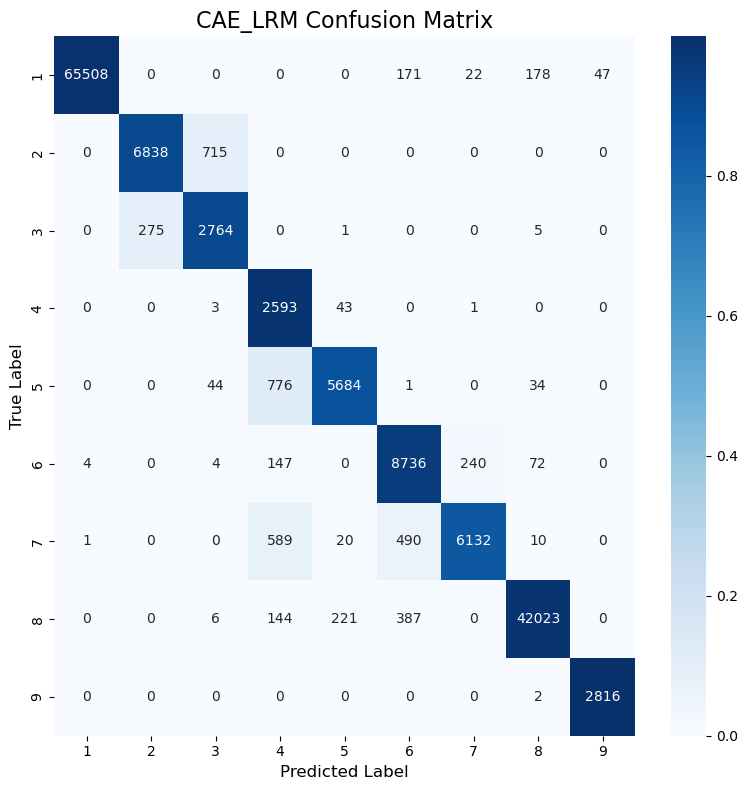

Classification Accuracy: 96.85%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


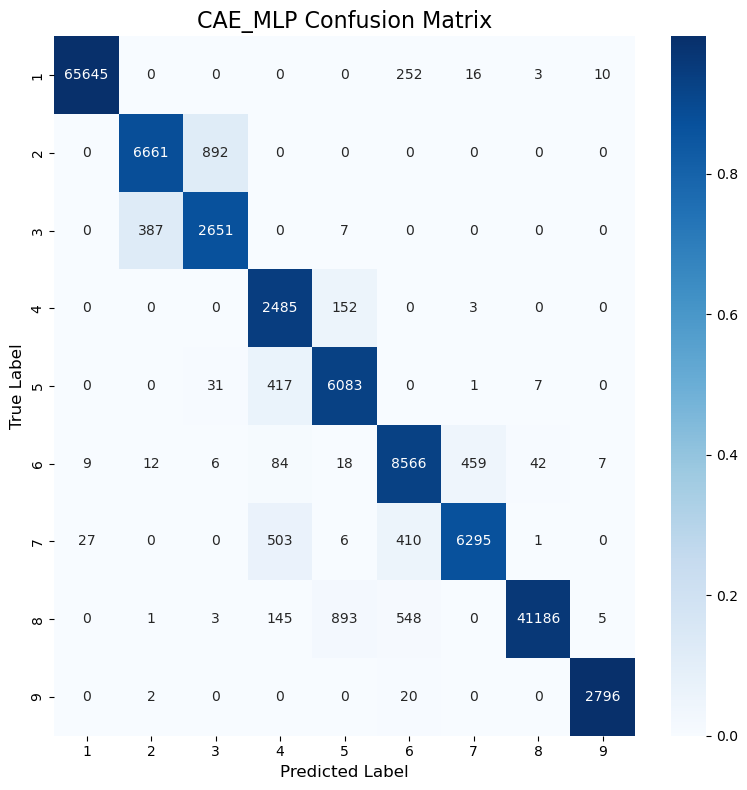

Classification Accuracy: 96.36%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


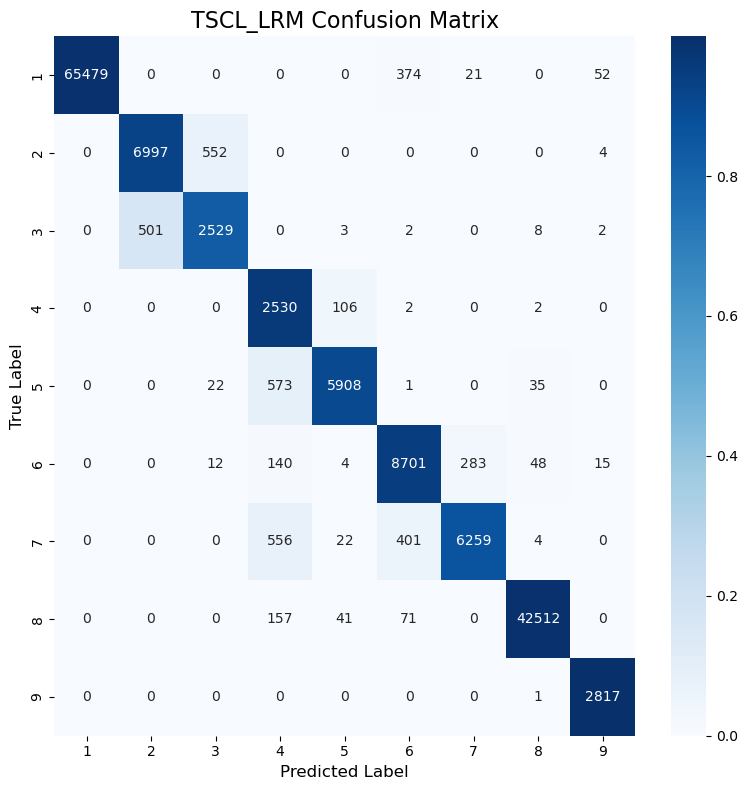

Classification Accuracy: 97.28%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


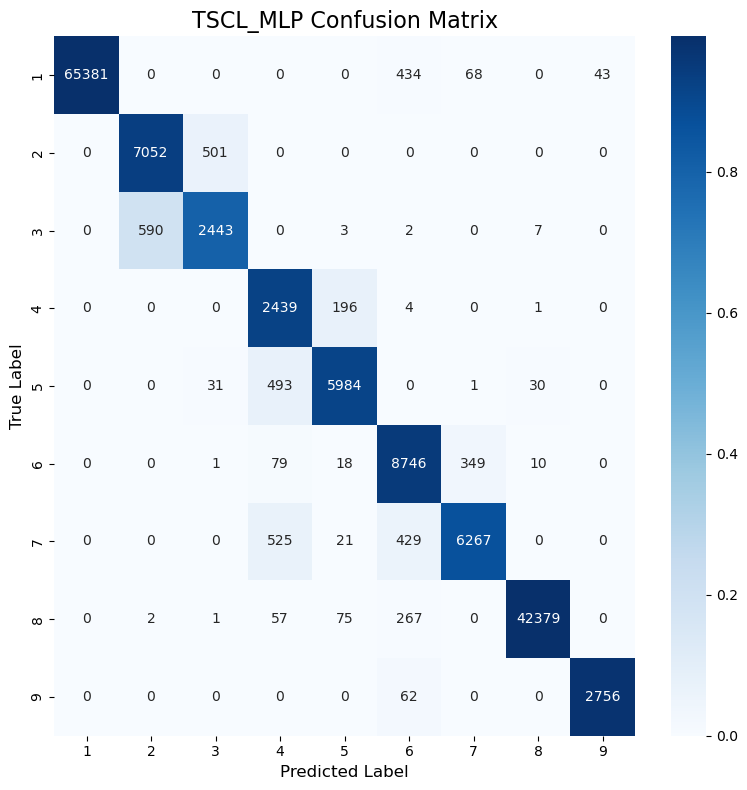

Classification Accuracy: 97.09%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


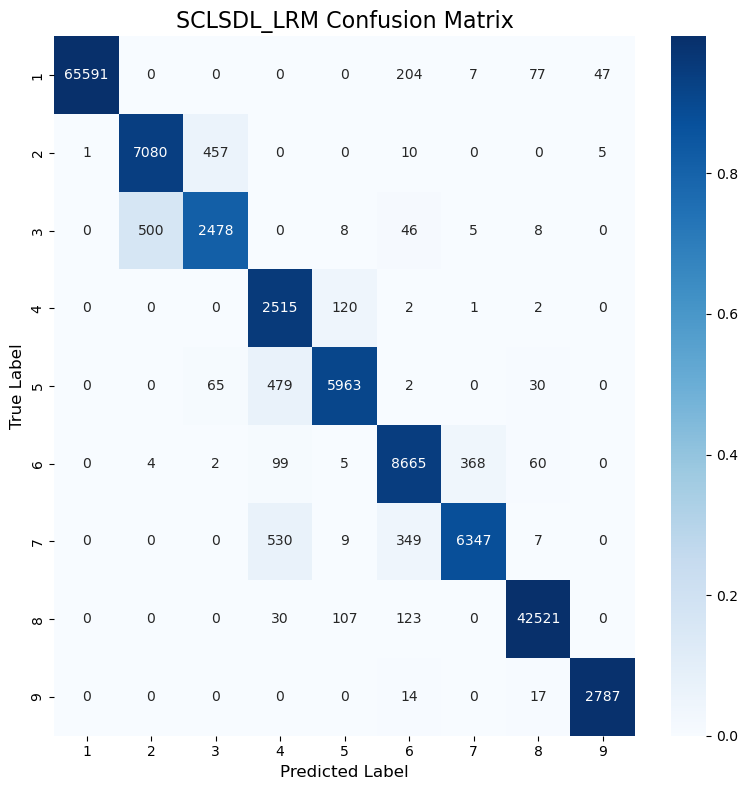

Classification Accuracy: 97.43%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


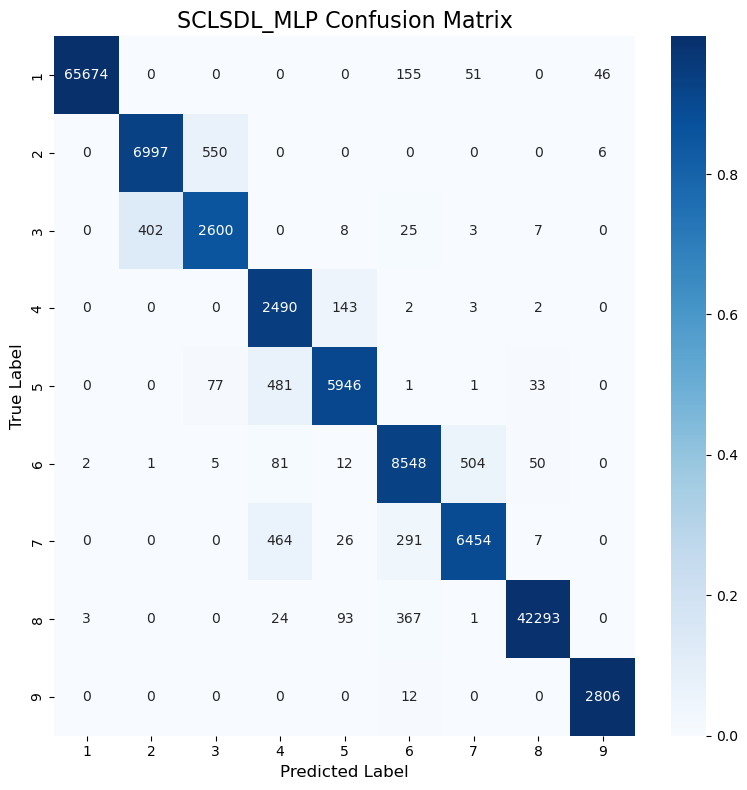

Classification Accuracy: 97.33%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          98.72
1    LRM (CAE)          96.85
2    MLP (CAE)          96.36
3     TSCL LRM          97.28
4     TSCL MLP          97.09
5  SCL_SDL LRM          97.43
6  SCL_SDL MLP          97.33

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          98.72
5  SCL_SDL LRM          97.43
6  SCL_SDL MLP          97.33
3     TSCL LRM          97.28
4     TSCL MLP          97.09
1    LRM (CAE)          96.85
2    MLP (CAE)          96.36
